## Imports

In [21]:
import csv
import cv2
import numpy as np
import time
import uuid
import json

from datetime import datetime
from matplotlib import pyplot as plt
from skimage.io import imshow, show
from LPIQE.src.LPIQE_reconstruction_executor import  LpiqeReconstructionExecutor as recon
from LPIQE.src.LPIQE_qiskit_implementation import  LpiqeQiskit
from PDU.src.PDU_function_creator import PDUFunctionCreator
from PDU.src.PDU_statistics_helper import PDUStatisticsHelper

## Class setup

In [22]:
lpique_impl=LpiqeQiskit()
backend = 'simulator_statevector'
api_key = '2990848b1062e426869449f092ae9d5295b38df83c7eeab0e100538c6ae107c6124e91b5063430ef6d9532fe5e69ebc882306c0e8e8fa34de8cb046b21dcd48b'
hub = 'ibm-q-research-2'
group = 'dept-computer-gr-1'
project = 'main'
params = [False, api_key, hub, group, project, backend]

image_shape = (16,16)
executor=recon(lpique_impl, image_shape, params)
pdu_function_creator = PDUFunctionCreator(True, image_shape, executor, 32000)
pdu_statistics_helper = PDUStatisticsHelper()

ibmqfactory.load_account:WARNING:2023-03-02 18:51:11,993: Credentials are already in use. The existing account in the session will be replaced.


## Helper functions

In [23]:
def save_results(data):
    with open('experiment_results.csv', mode='a', newline='') as results:
        results_writer = csv.writer(results, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        results_writer.writerow(data)
        results.close()

## Calibration PDU function

In [24]:

calibration_granularity = 5

pdu_function_creator.create_empty_function()
pdu_function_creator.calibrate_function(calibration_granularity)
time_of_calibrating_pdu = datetime.now().replace(tzinfo=None)

Calibrating PDU function
PDU function calibrated


## Experiment made for every image

In [25]:
def make_experiment(img_path, img_name):
    
    img_read = cv2.imread(img_path, 0)
    img = img_read / 255.0

    plt.imshow(img, cmap='gray')
    now = datetime.now().replace(tzinfo=None)
    date_time = now.strftime("%m_%d_%Y_%H_%M_%S")
    title = "res_images/" + img_name + "_before_" + date_time + "_" + backend + ".png"
    plt.savefig(title, bbox_inches='tight')
    plt.show()

    executor.create_circuit(img)
    executor.execute(32000, False)
    pdu_function_creator.apply(executor.reconstructed_image, img)
    pdu_statistics_helper.calculate(img, executor.reconstructed_image)

    res_as_json = json.dumps(executor.computation_results, indent = 4).replace(" ", "").replace("\n", "")
    
    
    plt.imshow(executor.reconstructed_image, cmap='gray')
    title = "res_images/" + img_name + "_in_progres_" + date_time + "_" + backend + ".png"
    plt.savefig(title, bbox_inches='tight')
    plt.show()
    
    mse_before = pdu_statistics_helper.mse
    stdev_before = pdu_statistics_helper.std_dev

    pdu_statistics_helper.calculate(img, pdu_function_creator.corrected_image)

    
    plt.imshow(pdu_function_creator.corrected_image, cmap='gray')
    title = "res_images/" + img_name + "_after_" + date_time + "_" + backend + ".png"
    plt.savefig(title, bbox_inches='tight')
    plt.show()
    
    mse_after = pdu_statistics_helper.mse
    st_dev_after = pdu_statistics_helper.std_dev

    now = datetime.now().replace(tzinfo=None)
    results_to_save = [images_run_uuid, group_uuid, backend, img_name, now, time_of_calibrating_pdu, calibration_granularity+1, mse_before, mse_after, stdev_before, st_dev_after, res_as_json]

    save_results(results_to_save)

## For every image do experiment 10 times

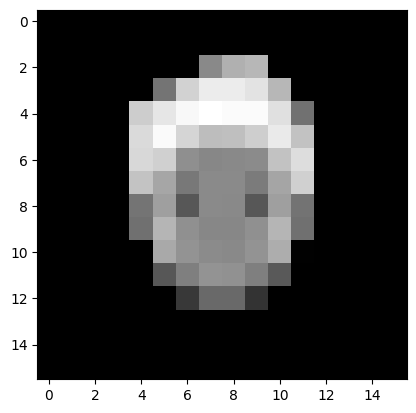

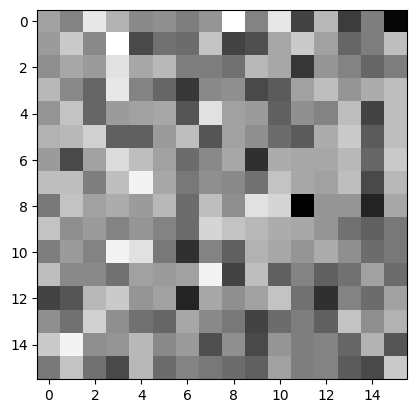

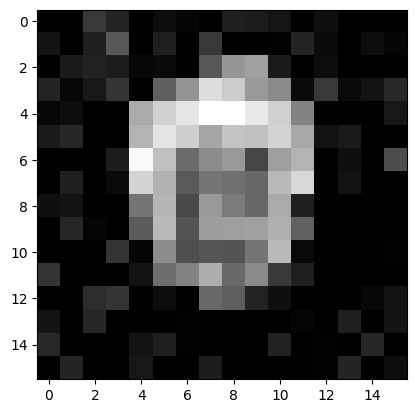

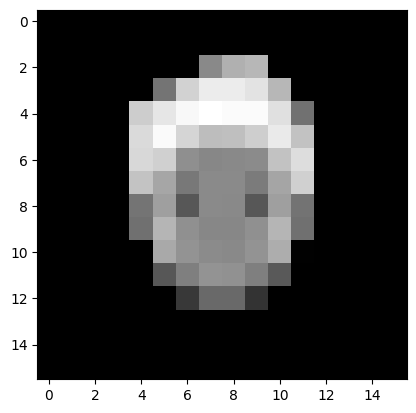

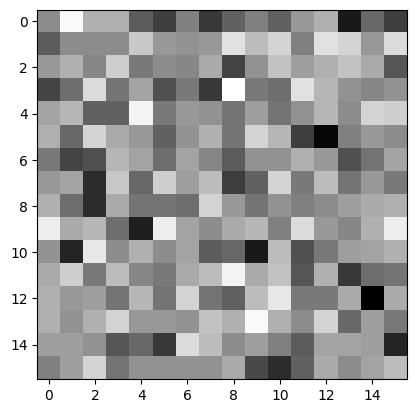

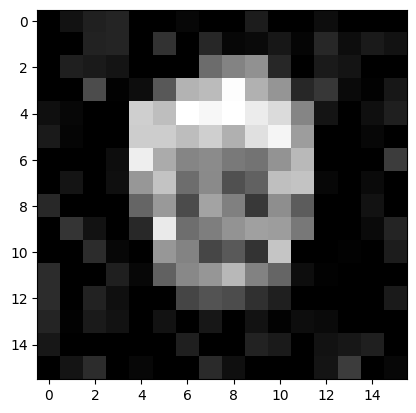

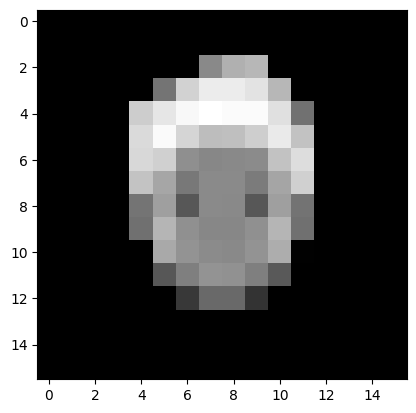

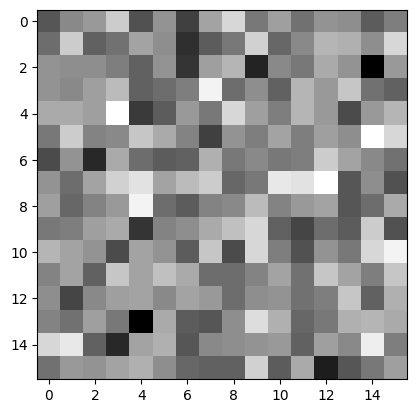

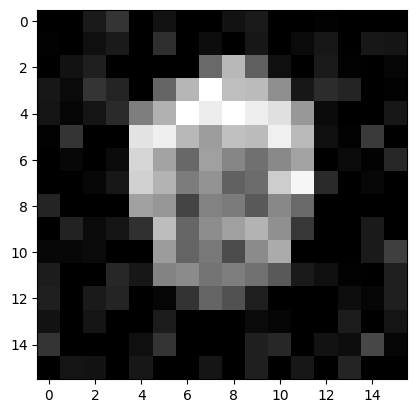

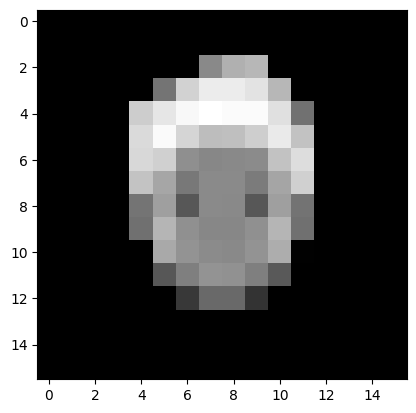

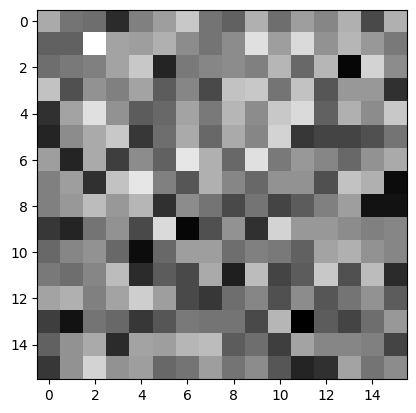

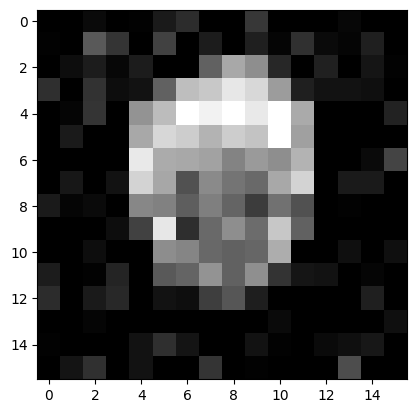

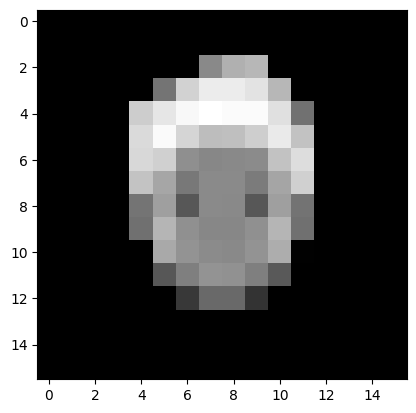

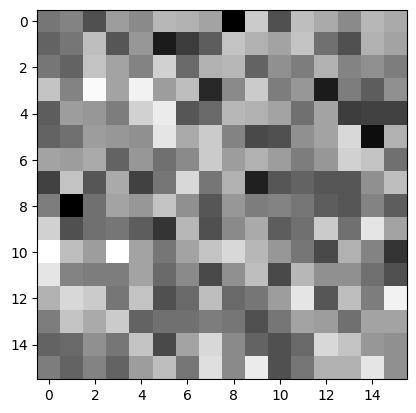

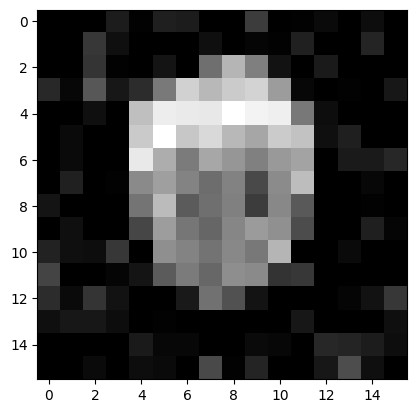

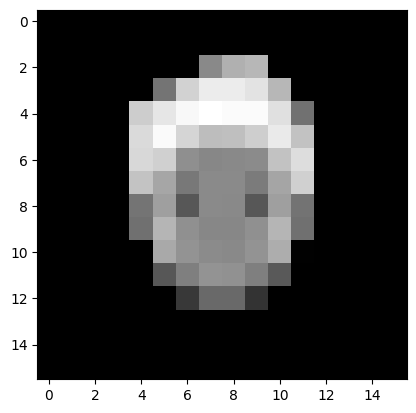

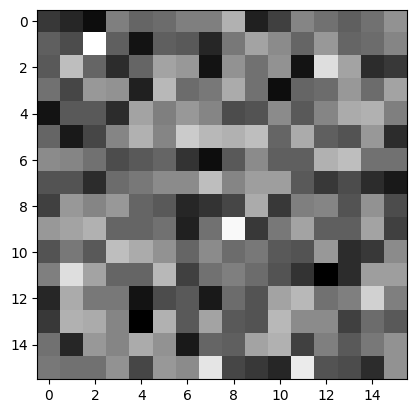

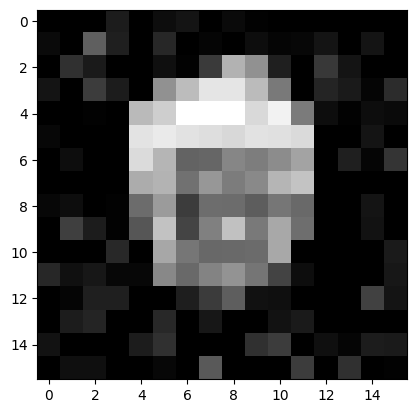

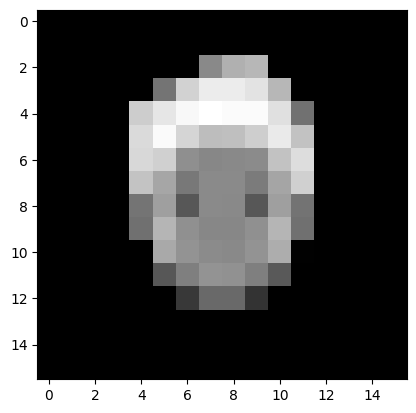

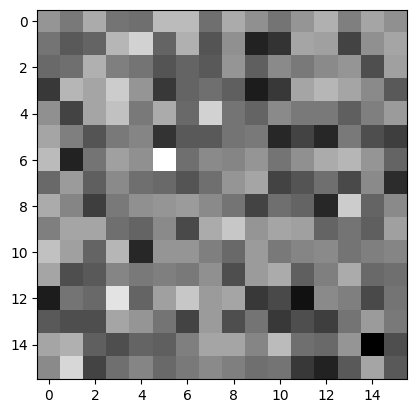

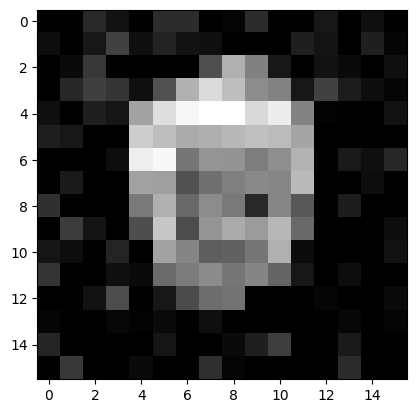

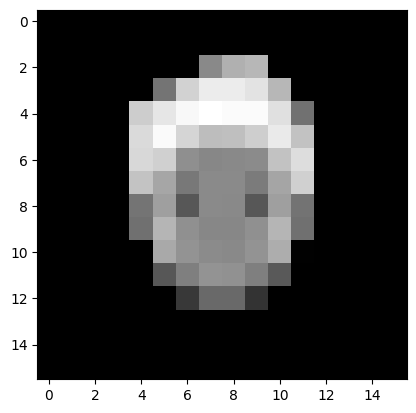

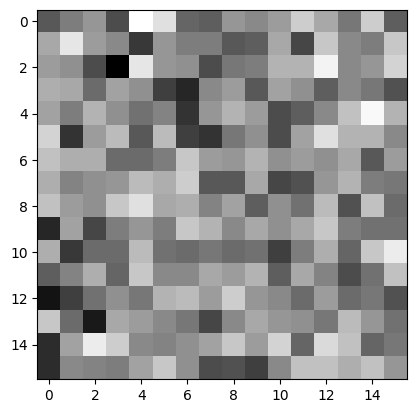

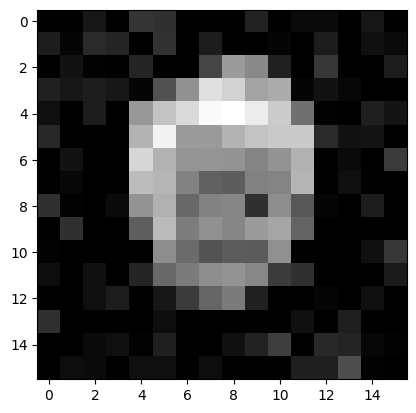

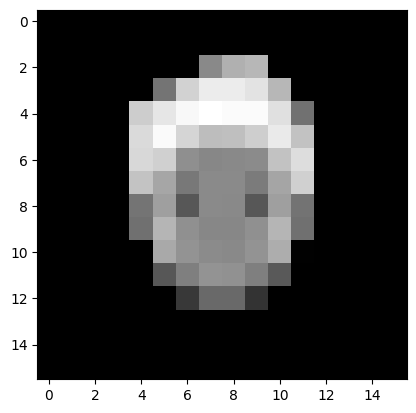

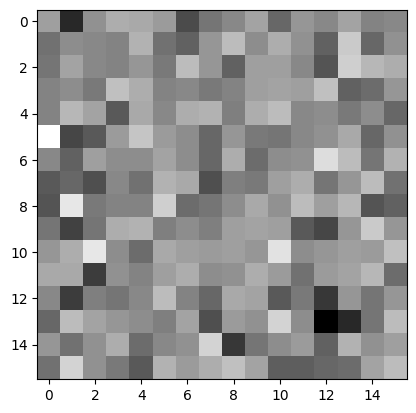

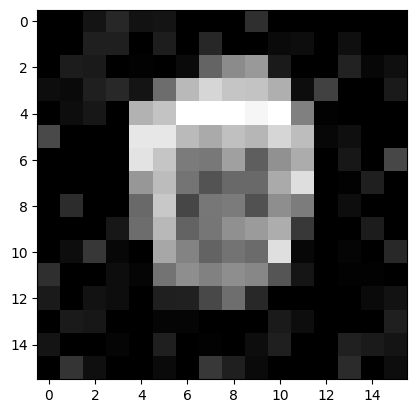

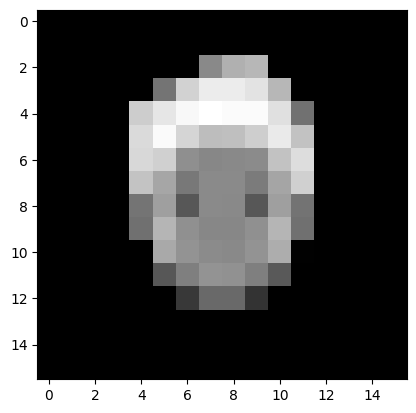

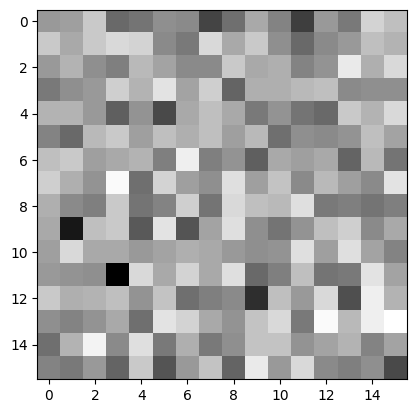

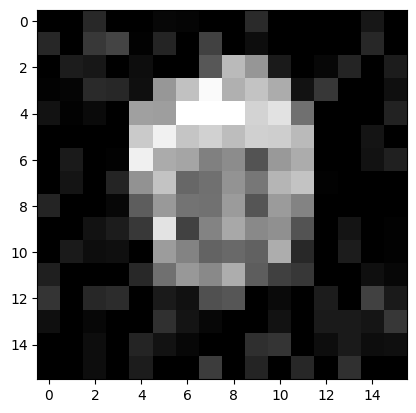

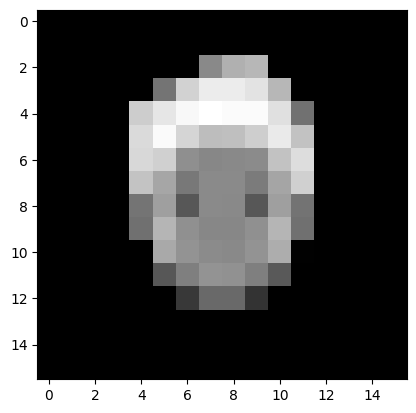

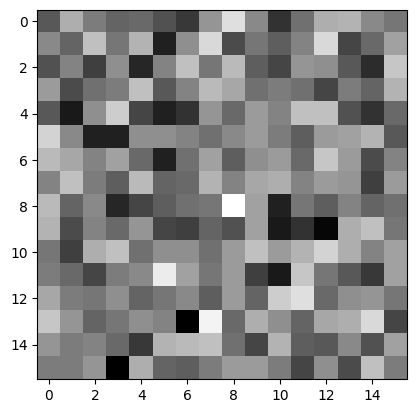

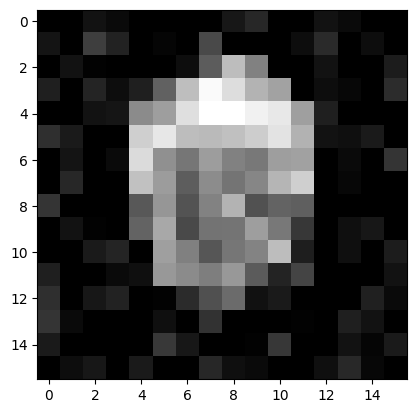

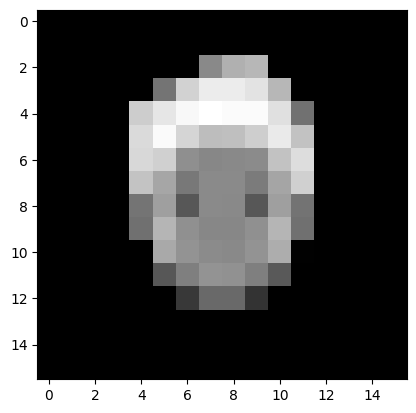

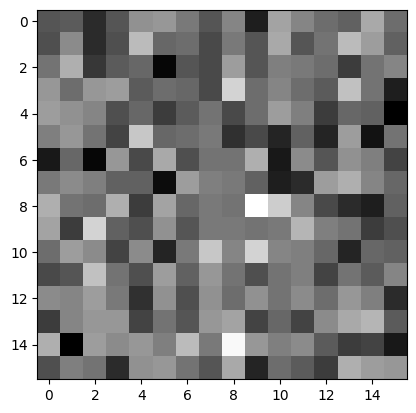

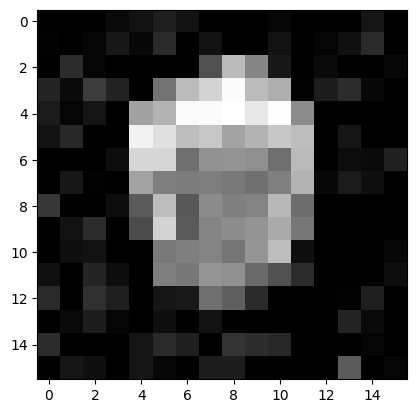

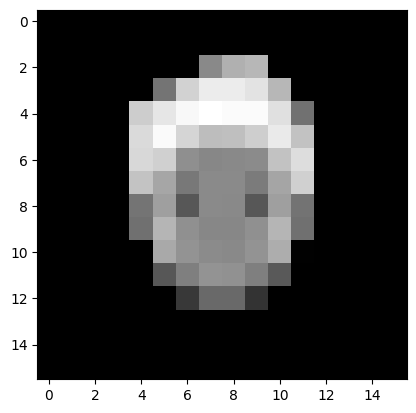

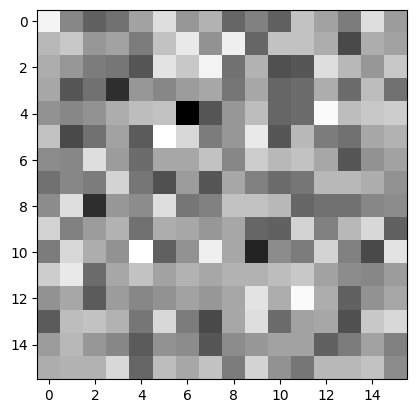

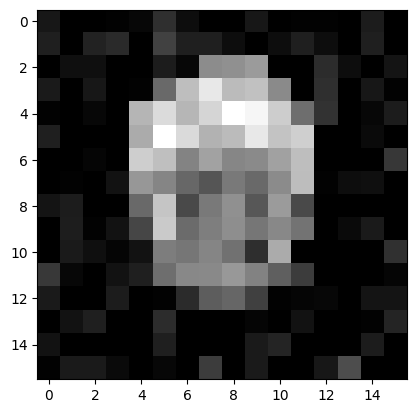

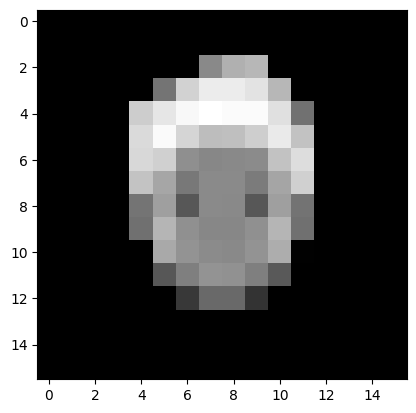

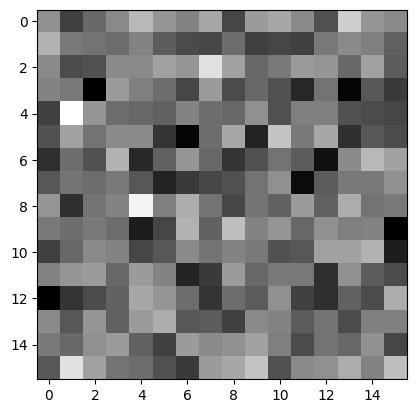

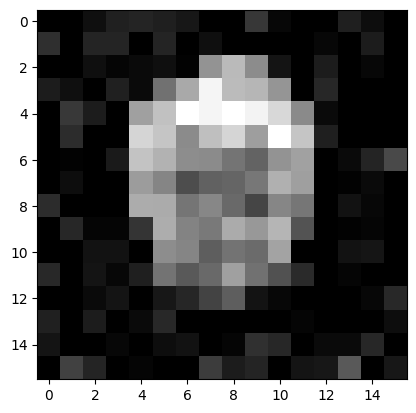

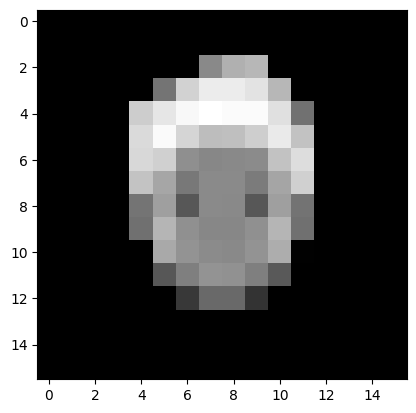

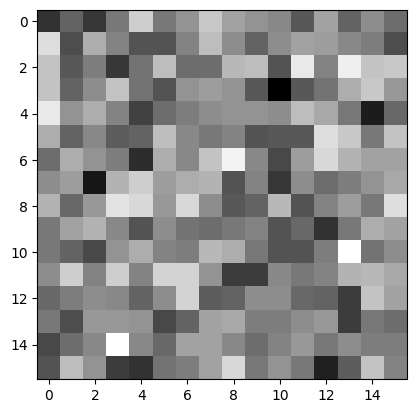

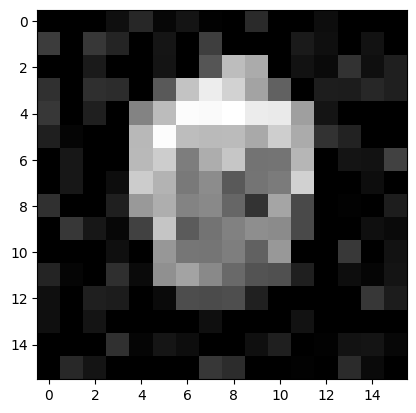

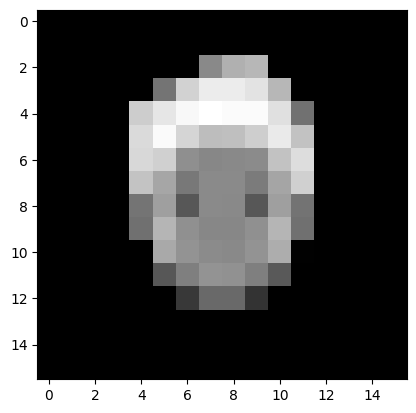

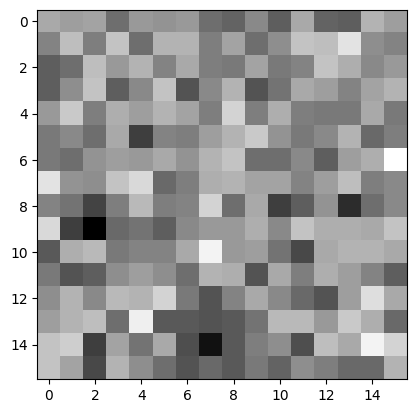

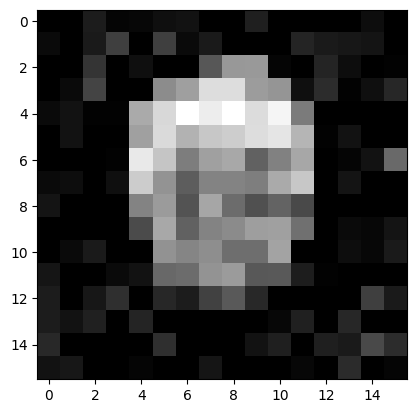

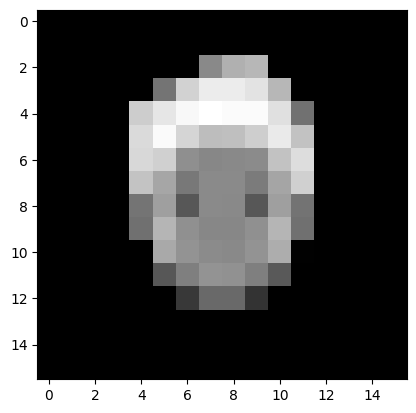

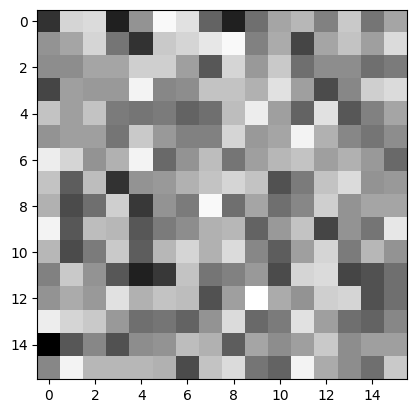

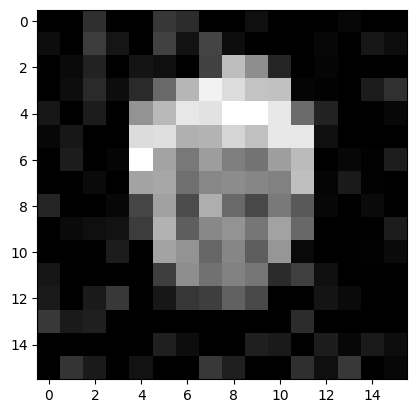

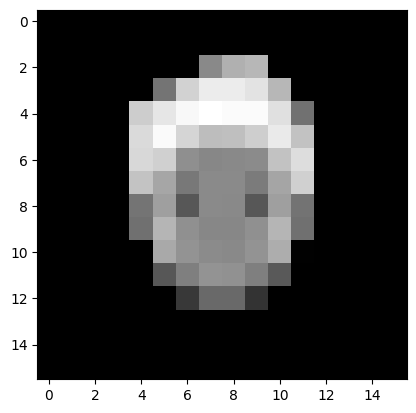

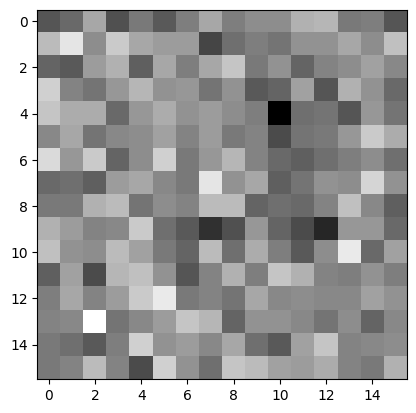

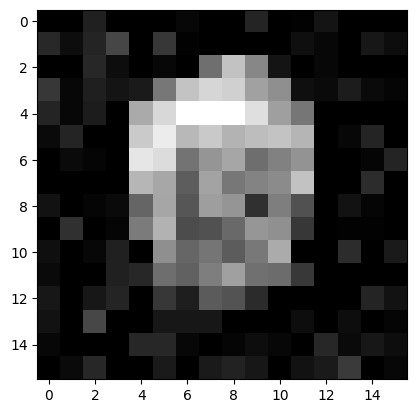

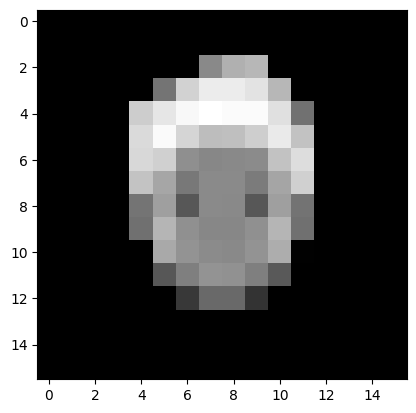

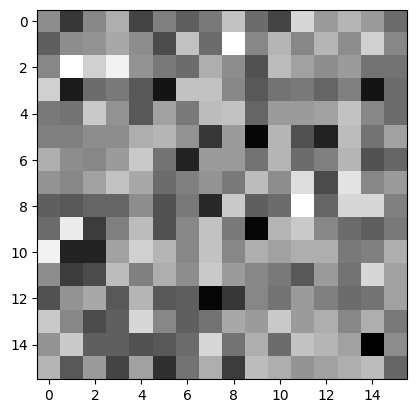

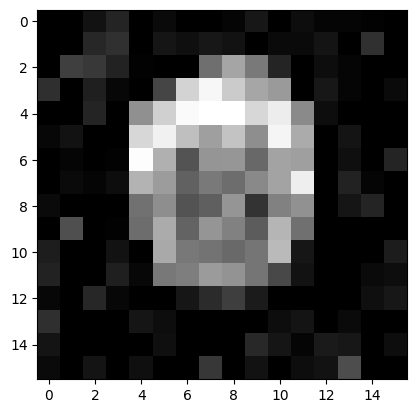

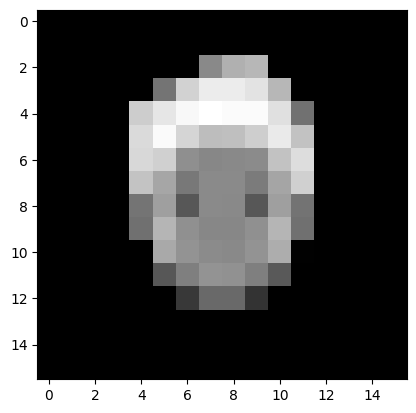

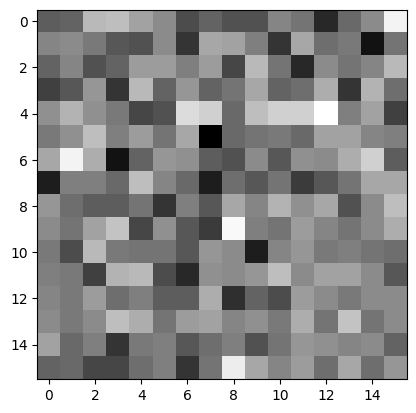

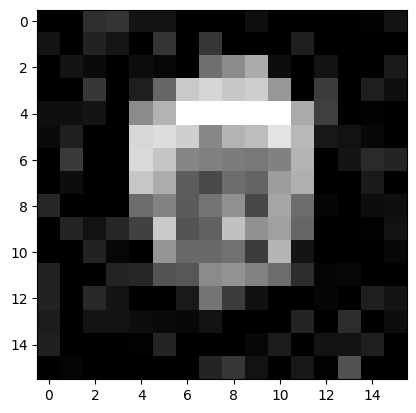

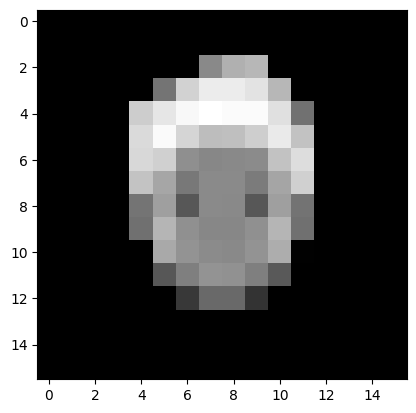

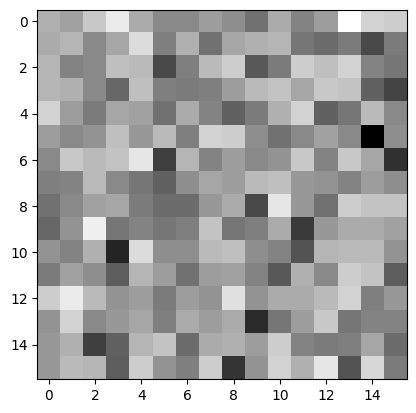

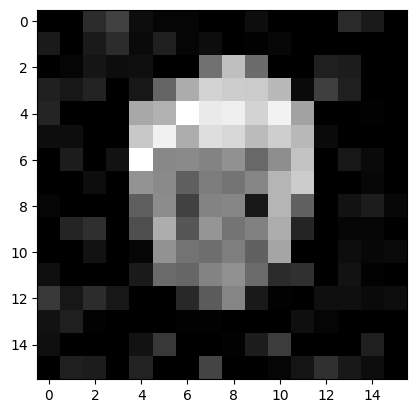

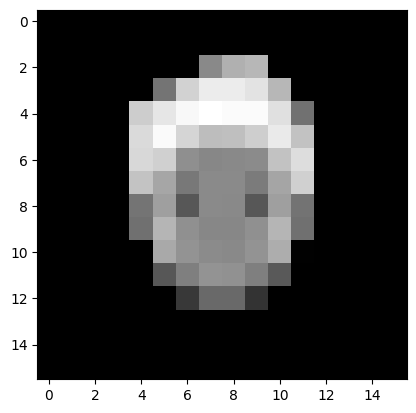

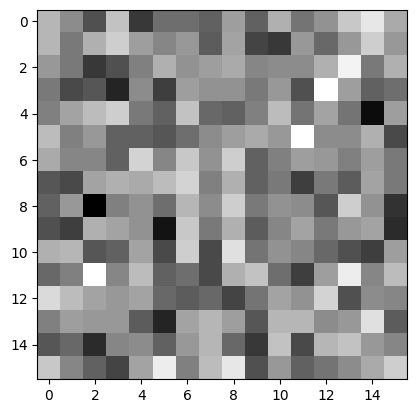

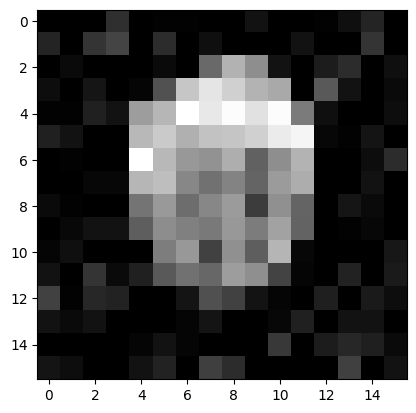

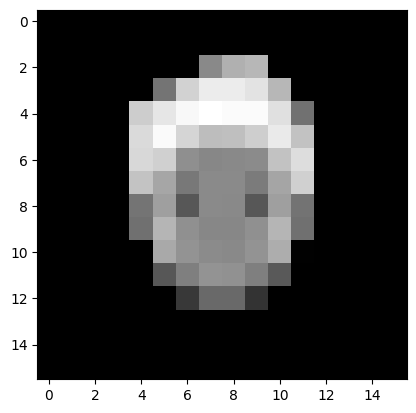

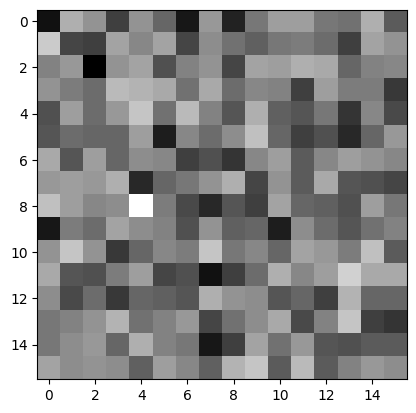

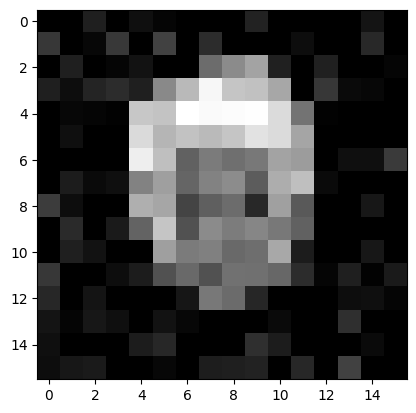

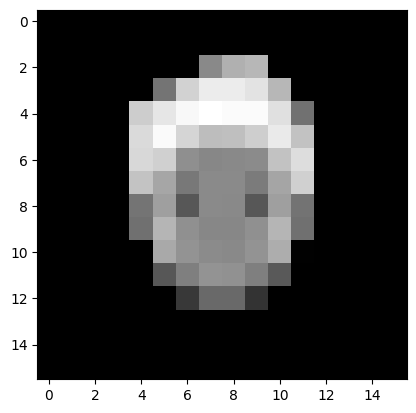

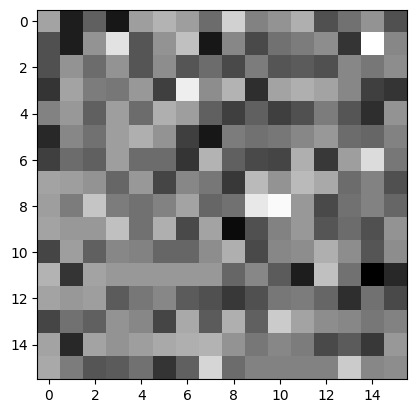

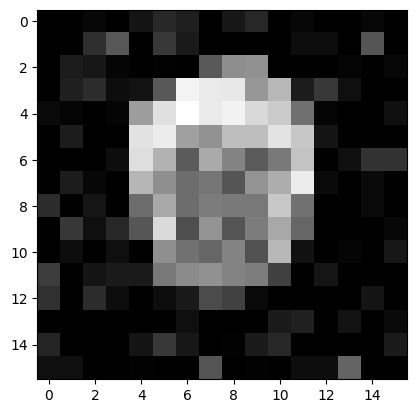

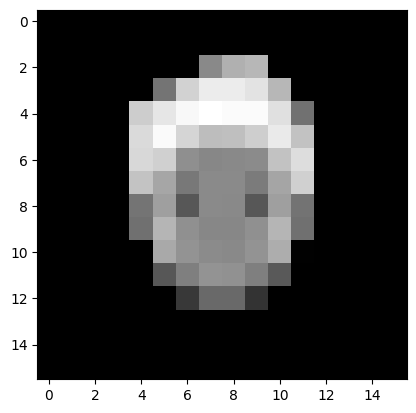

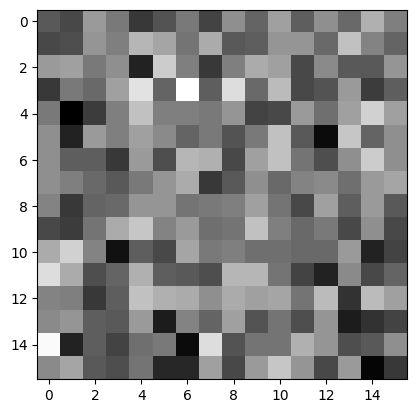

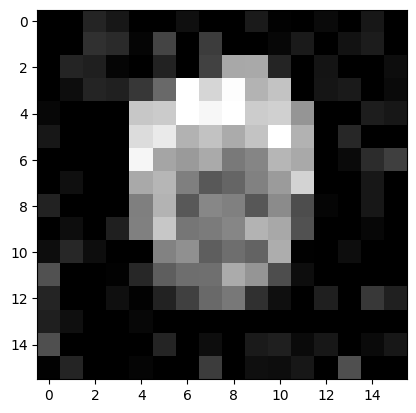

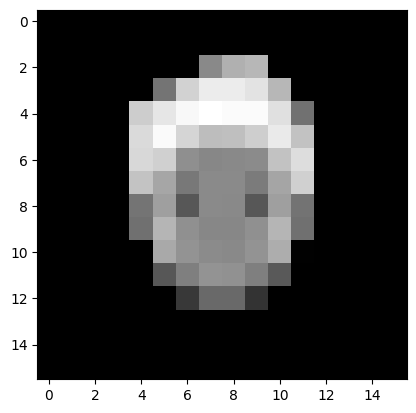

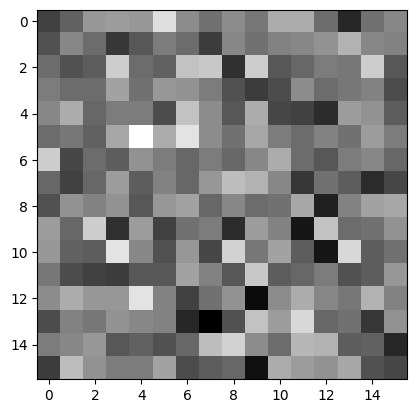

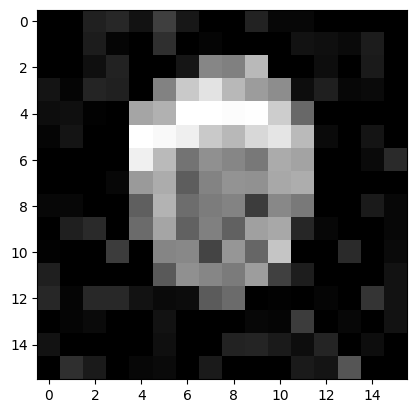

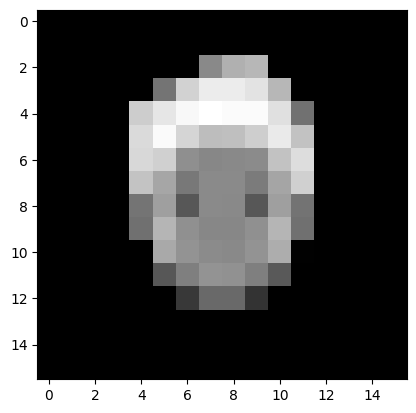

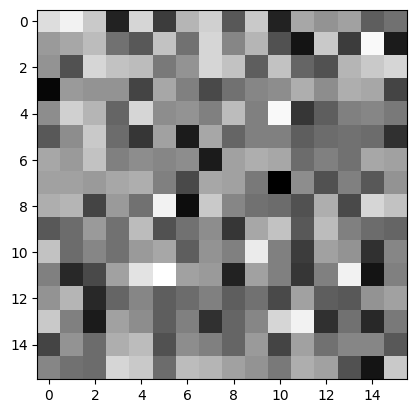

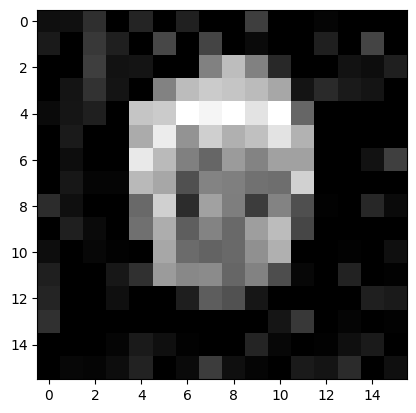

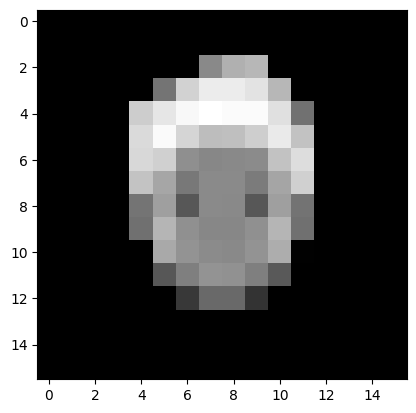

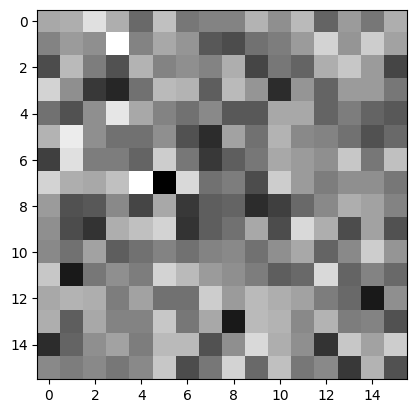

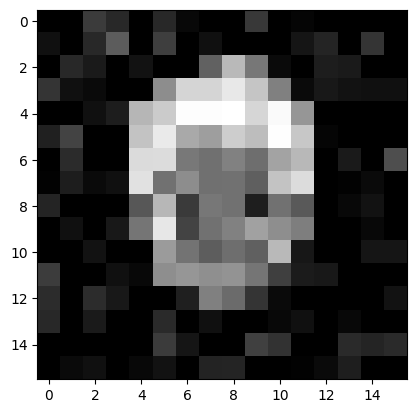

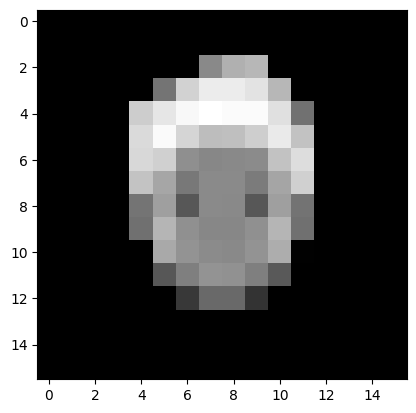

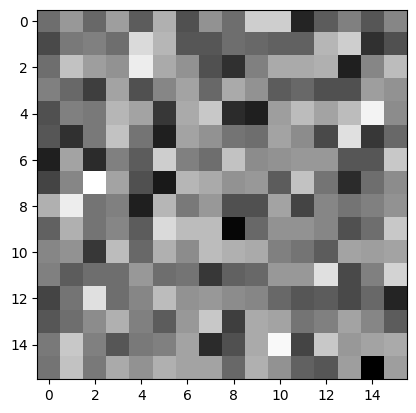

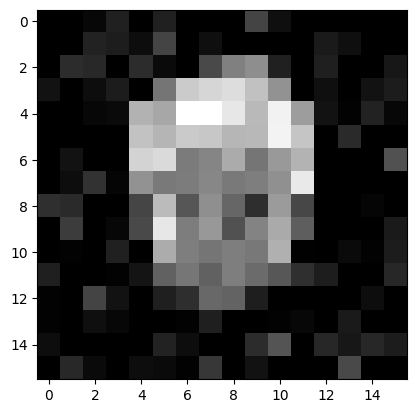

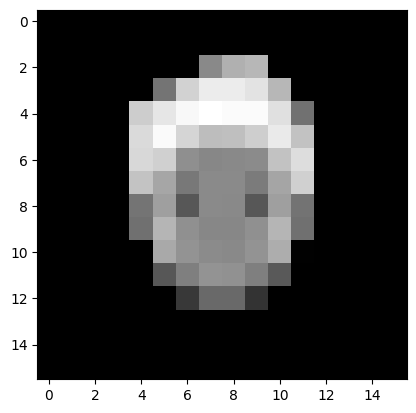

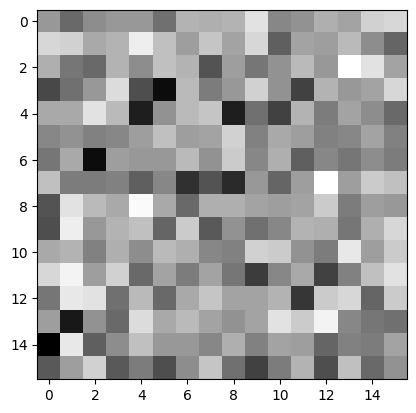

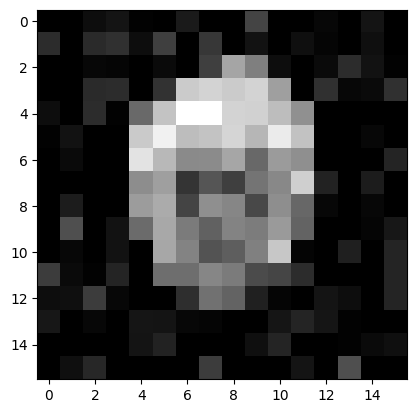

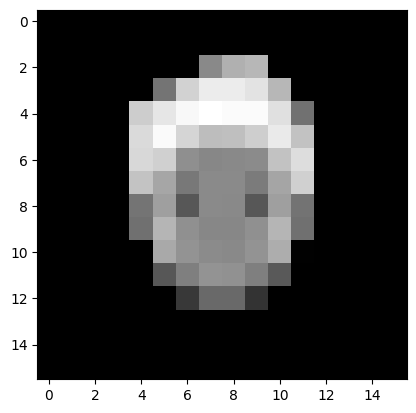

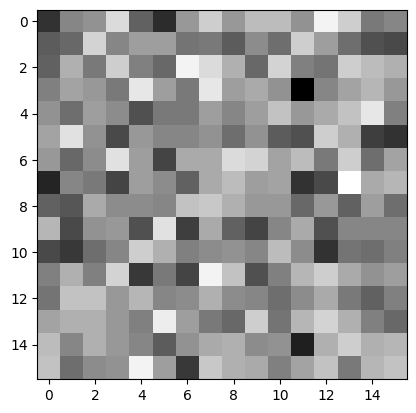

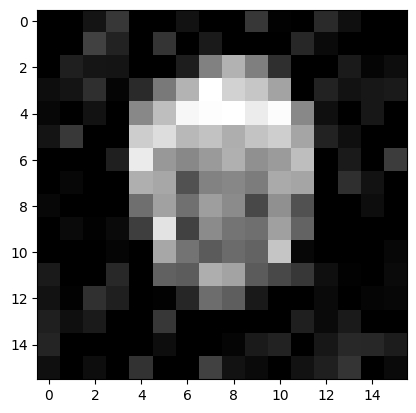

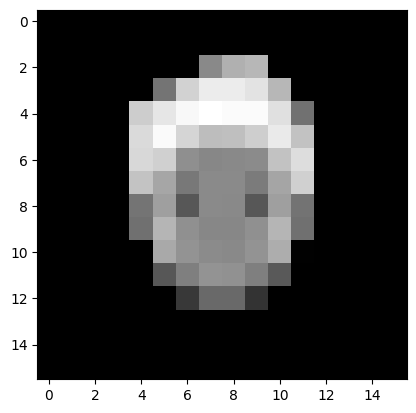

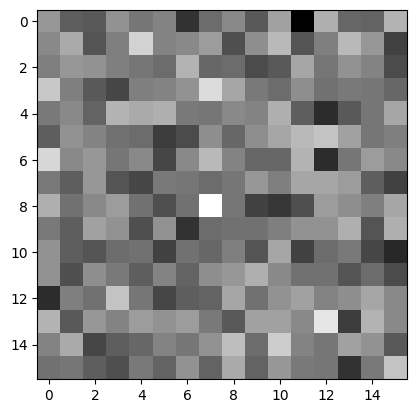

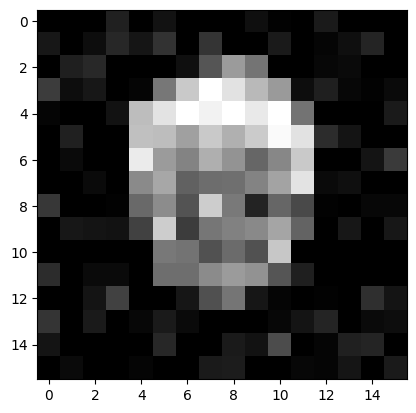

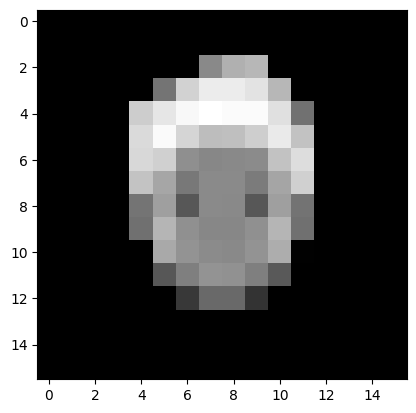

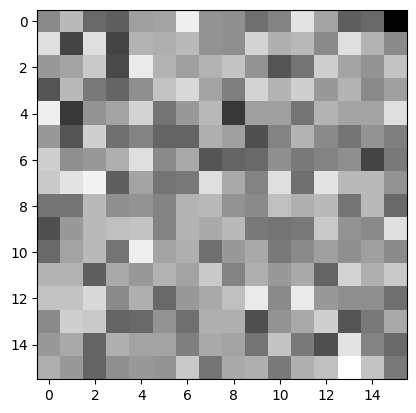

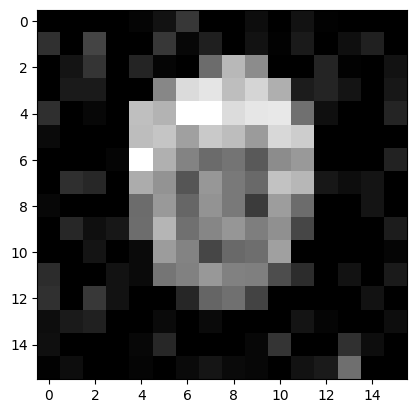

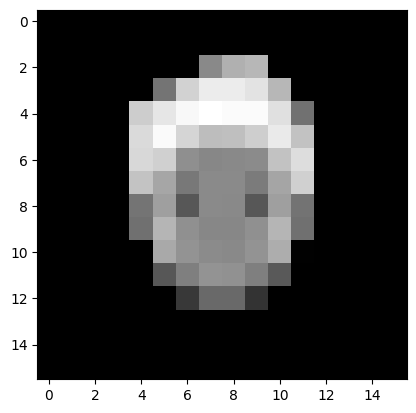

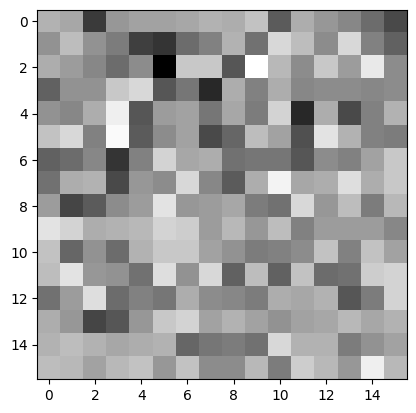

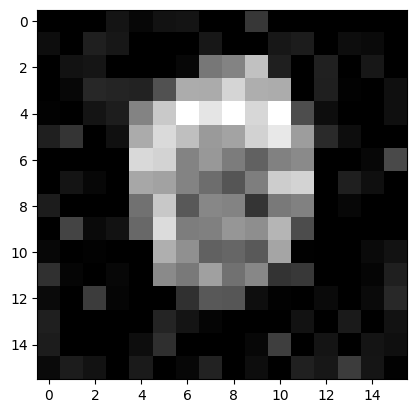

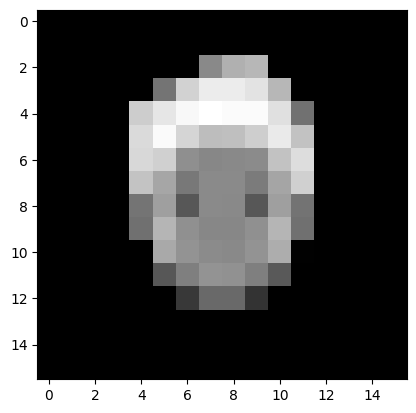

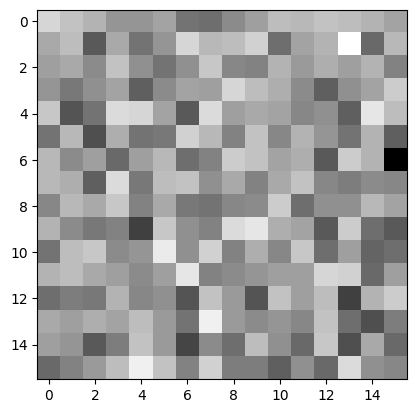

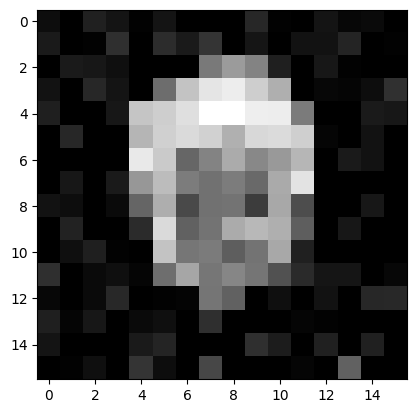

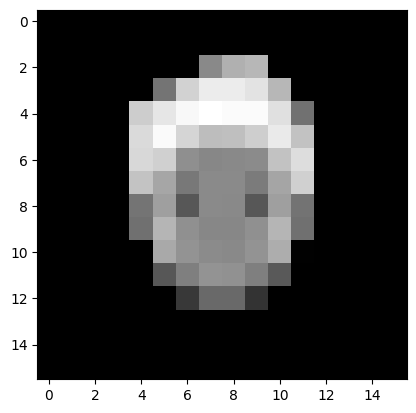

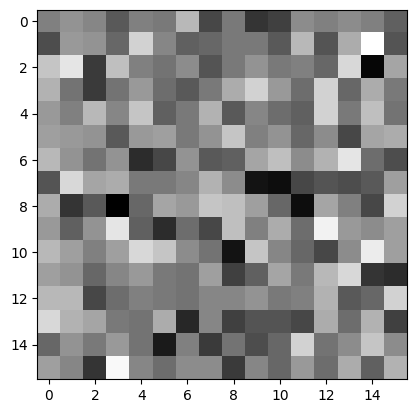

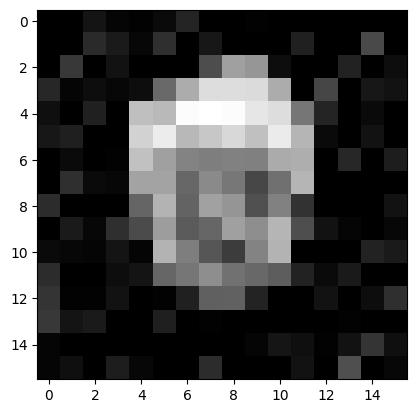

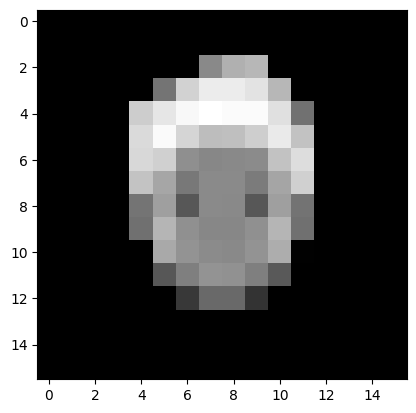

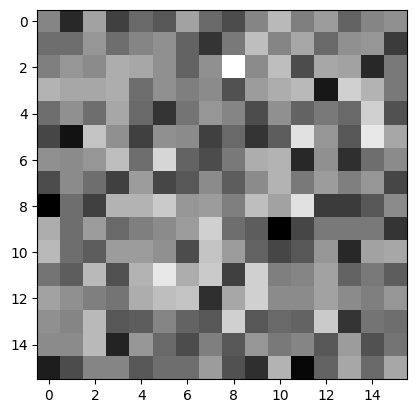

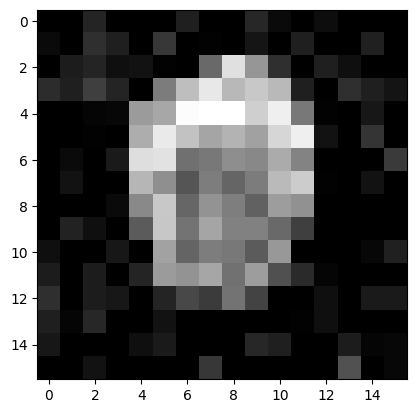

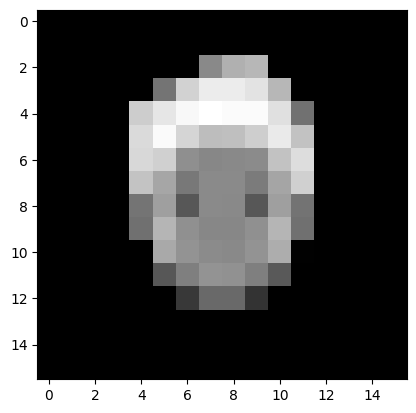

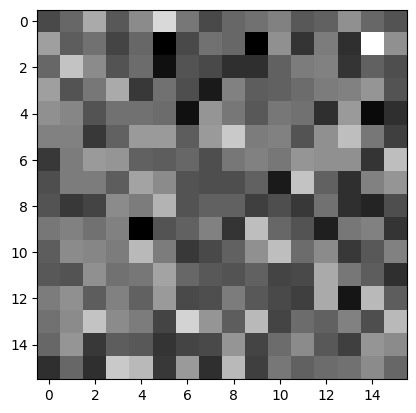

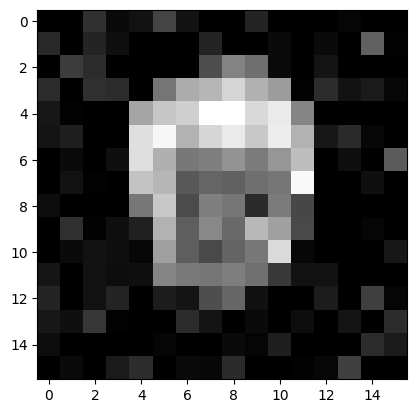

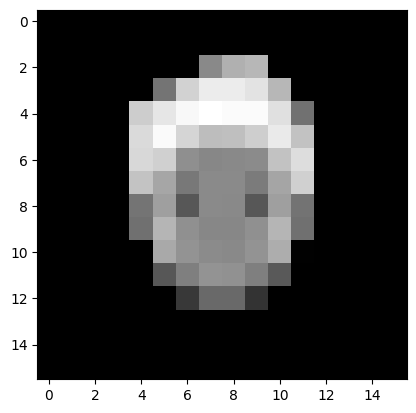

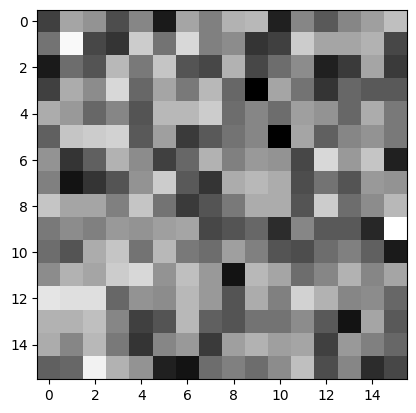

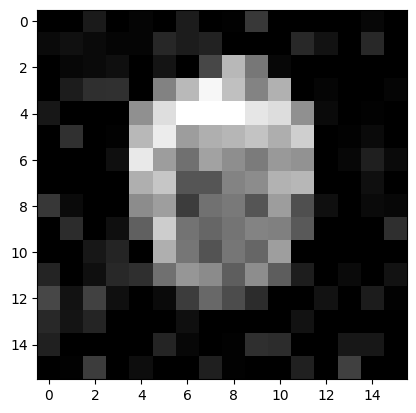

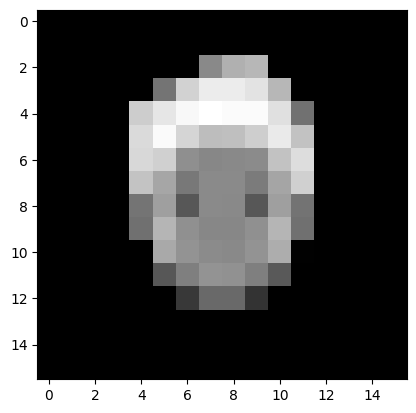

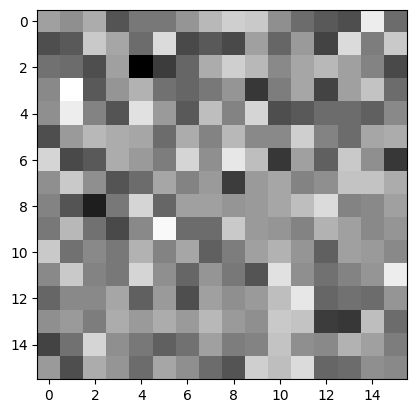

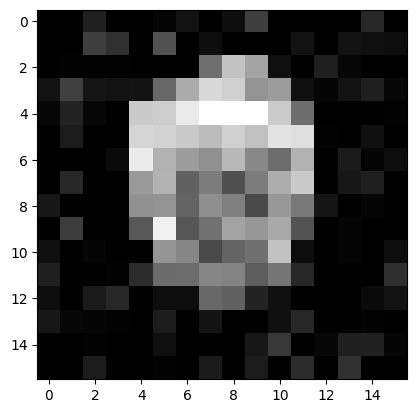

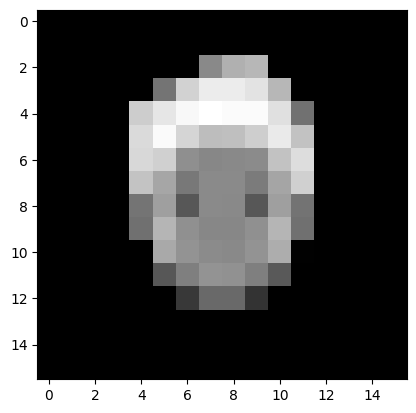

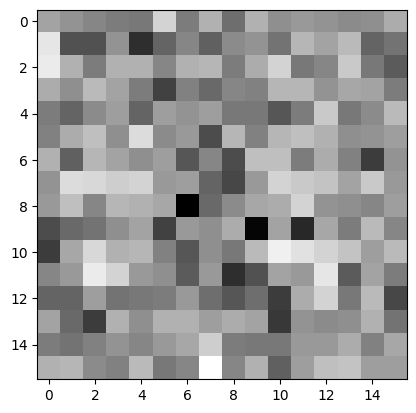

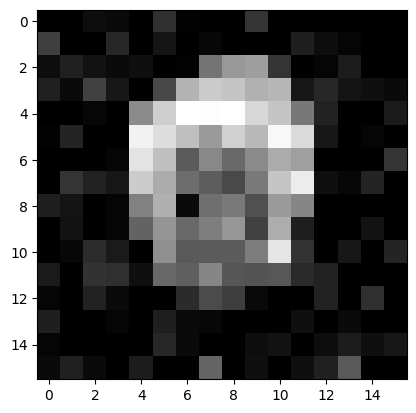

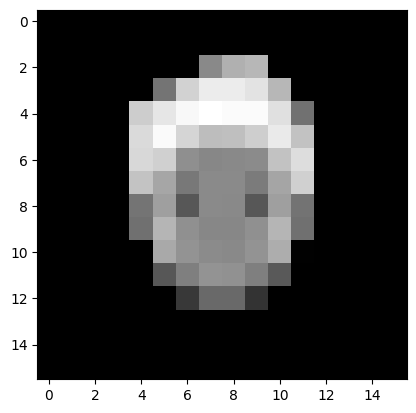

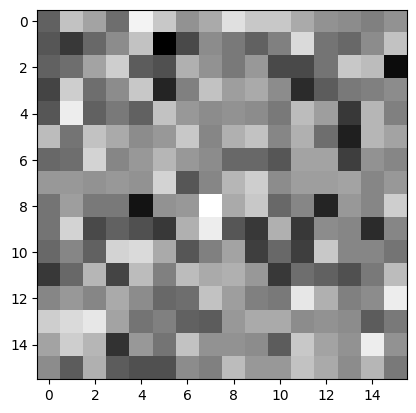

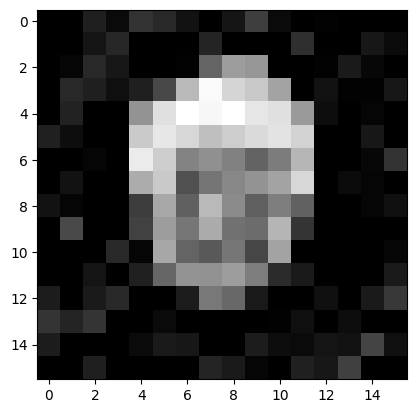

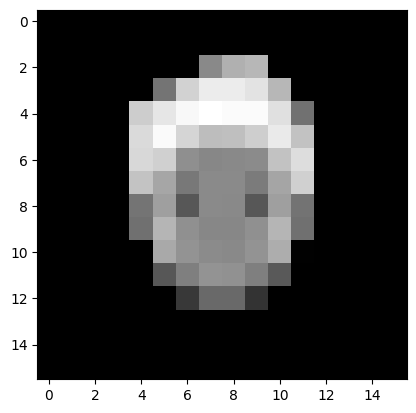

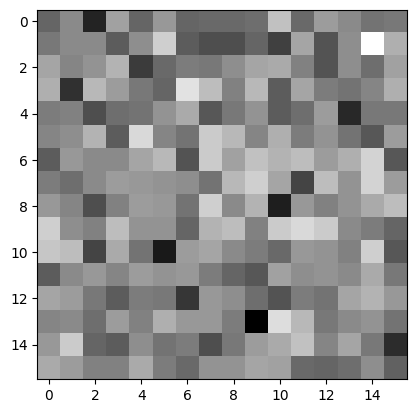

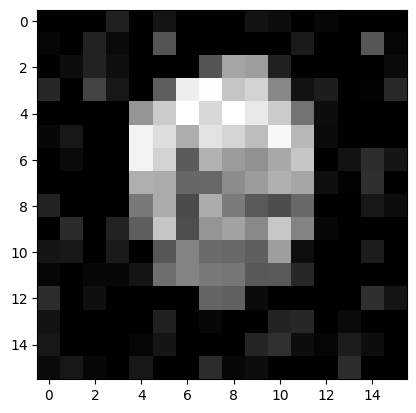

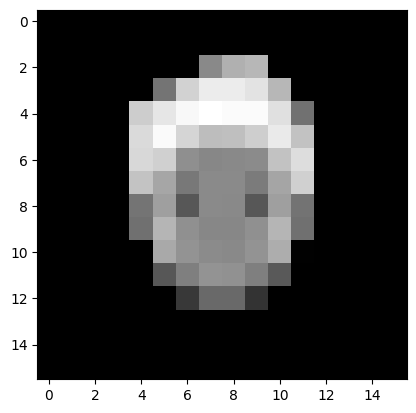

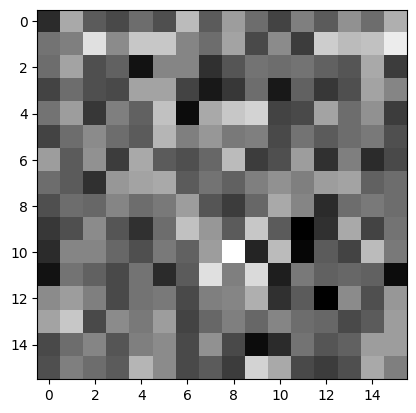

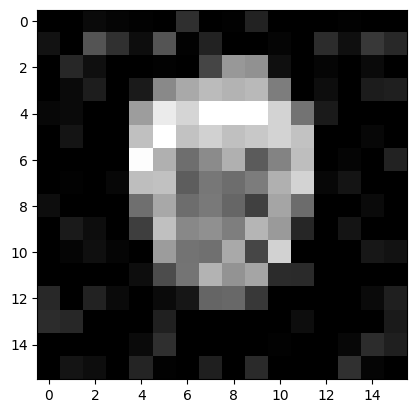

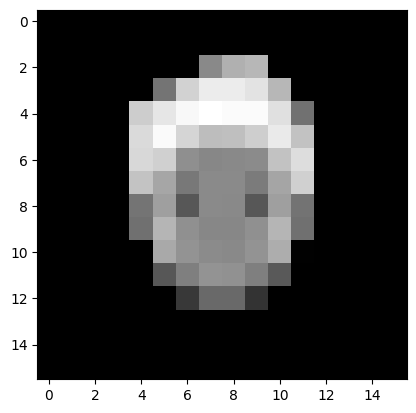

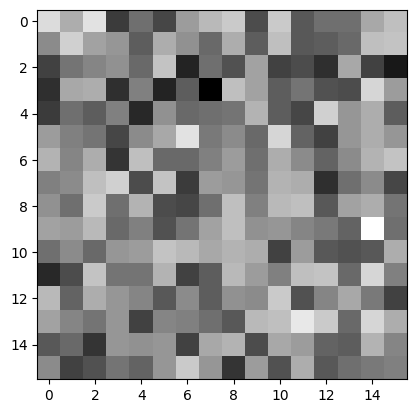

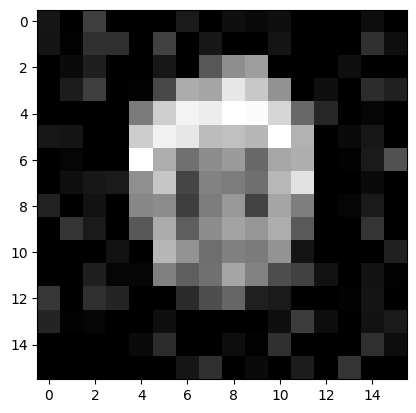

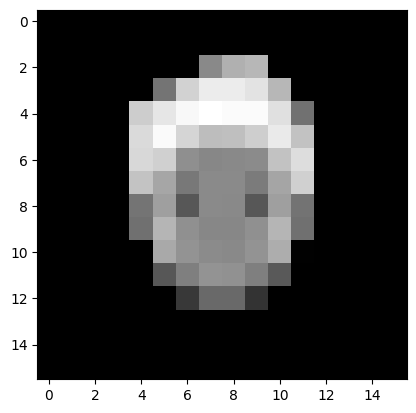

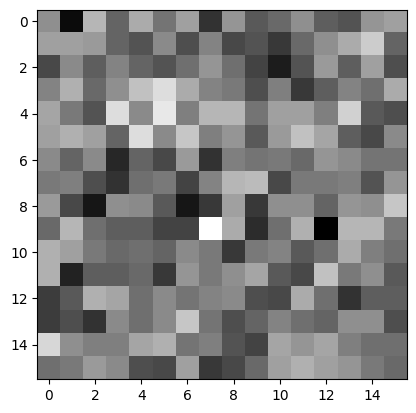

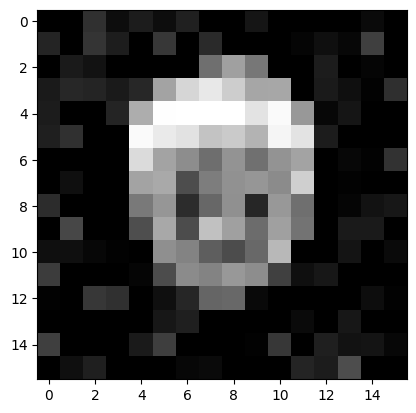

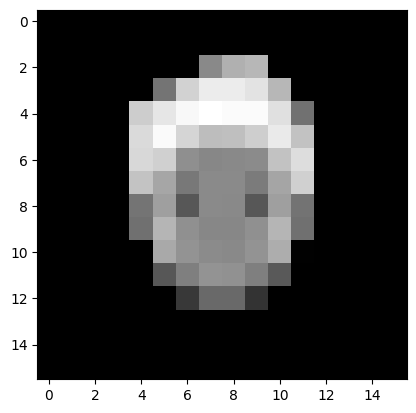

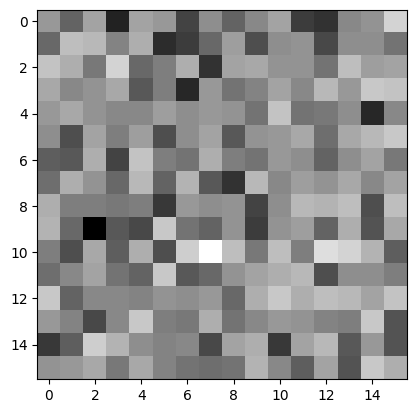

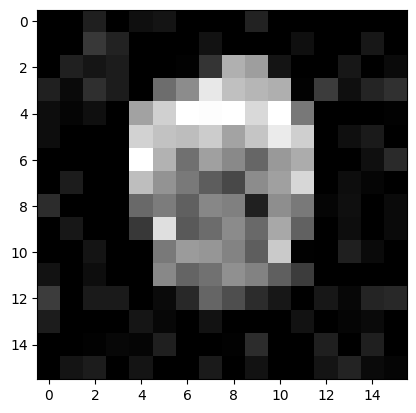

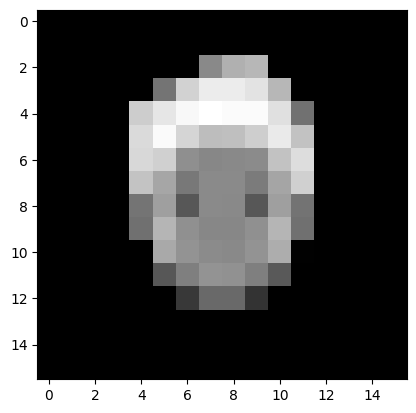

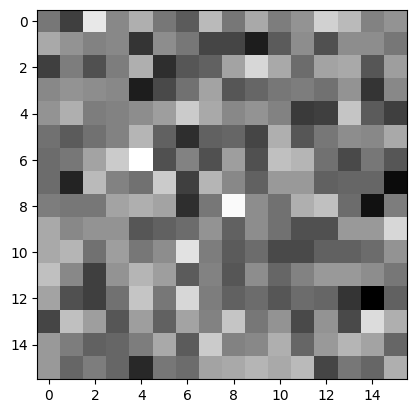

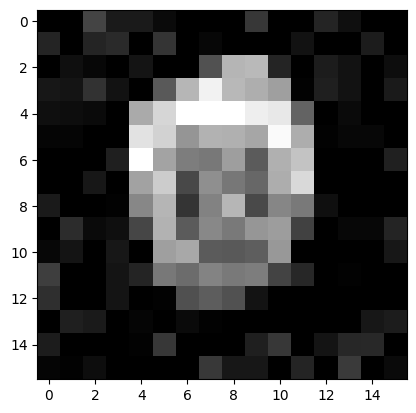

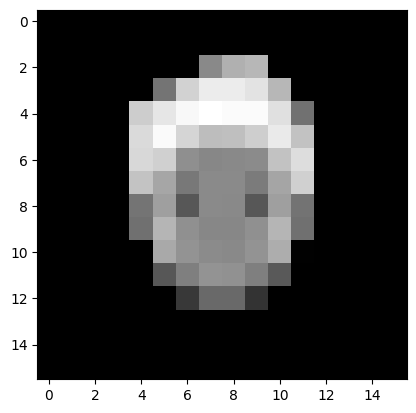

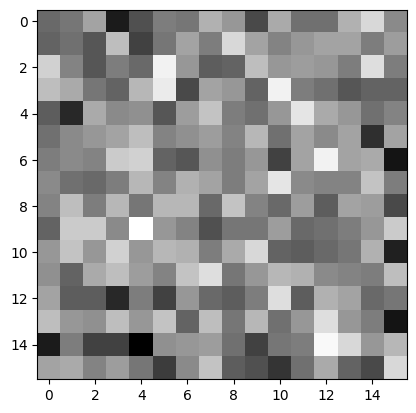

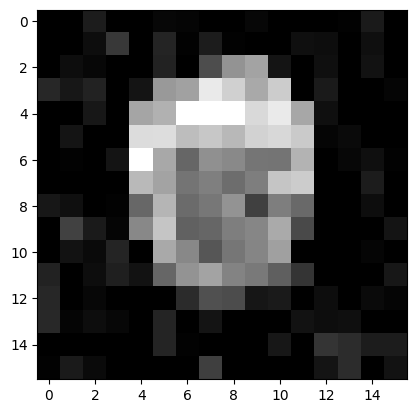

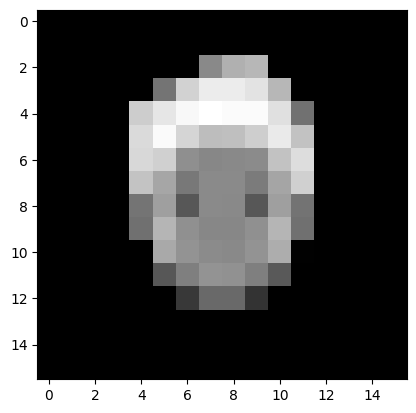

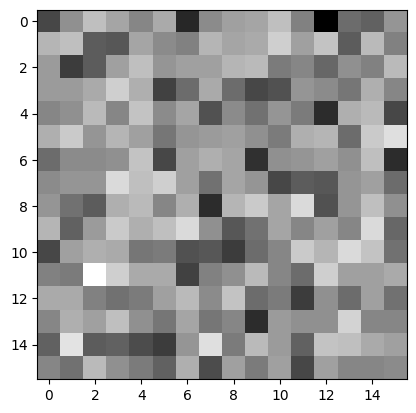

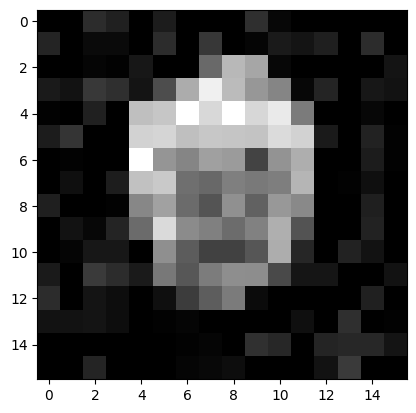

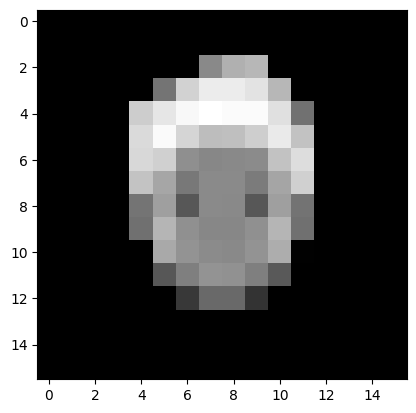

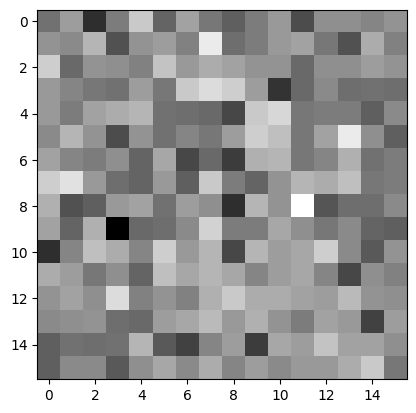

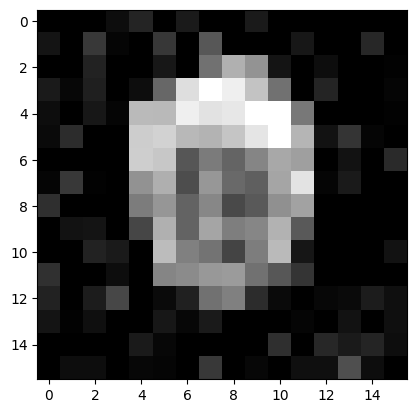

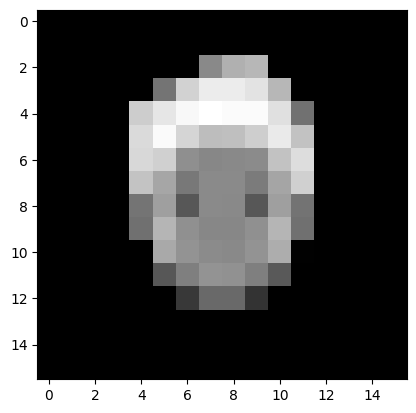

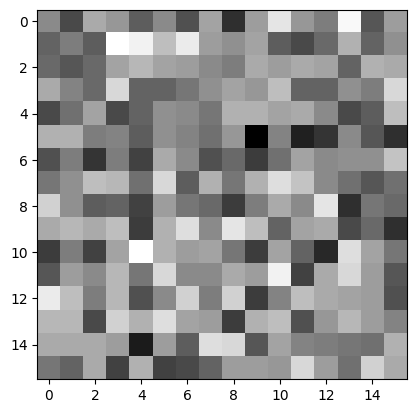

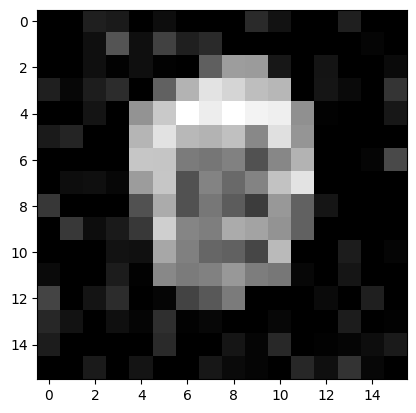

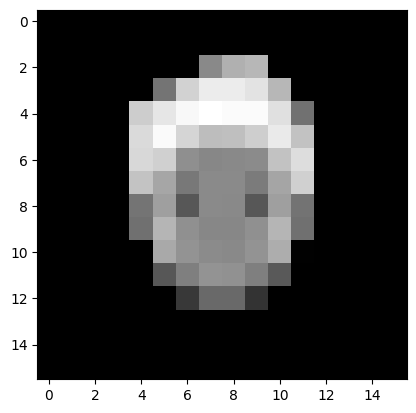

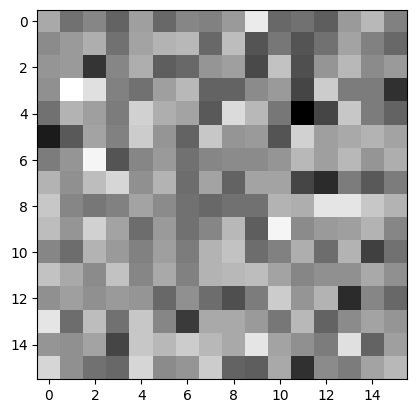

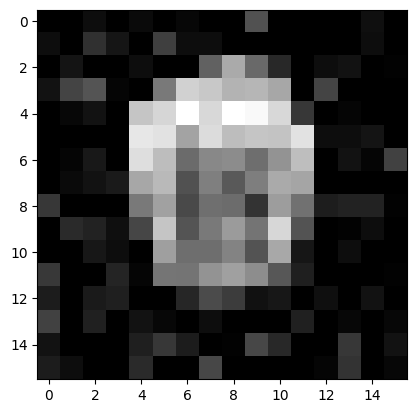

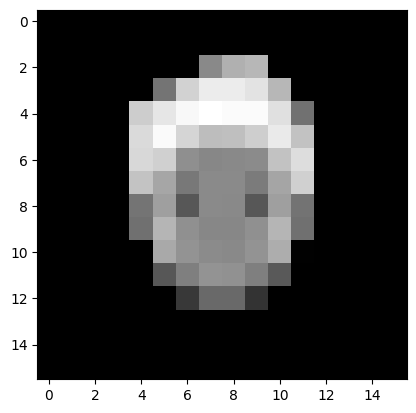

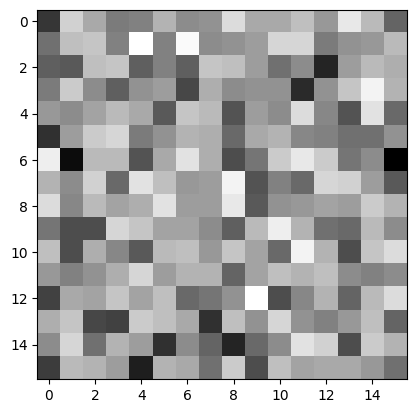

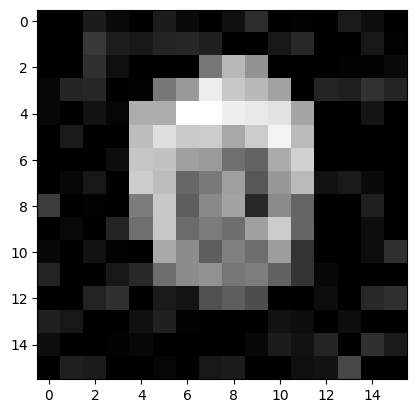

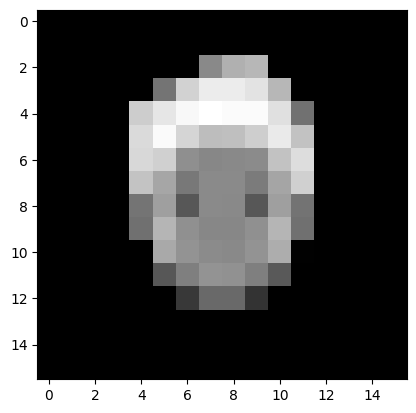

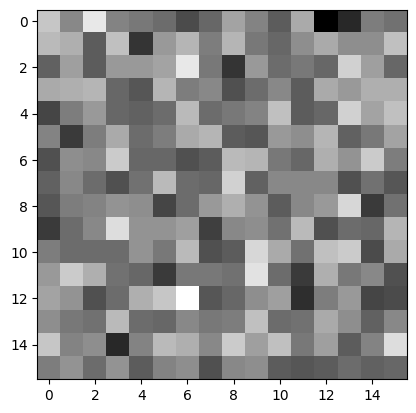

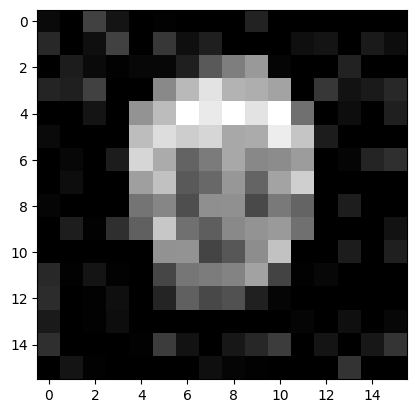

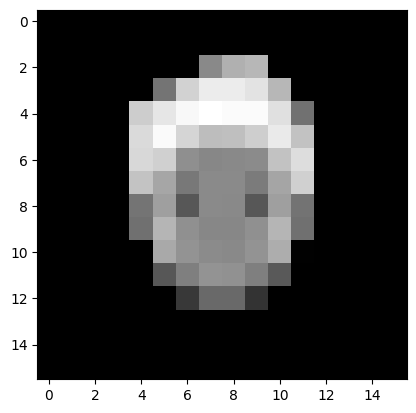

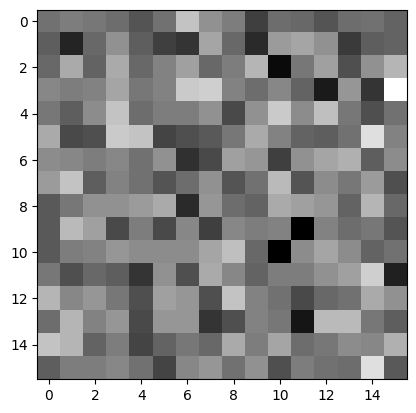

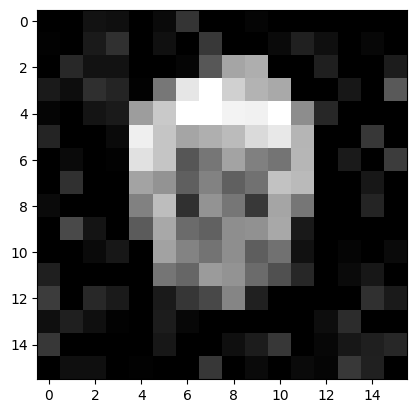

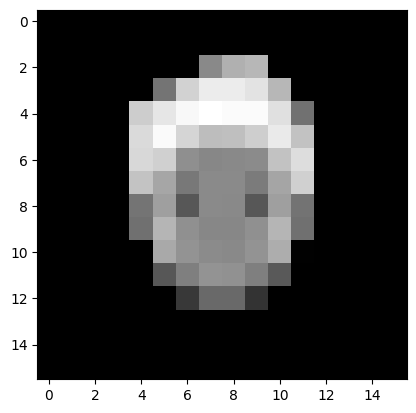

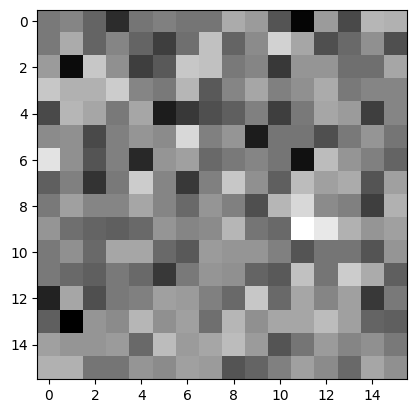

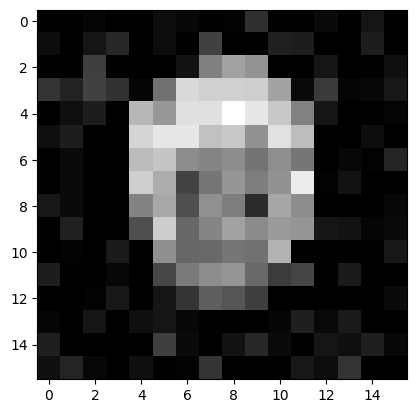

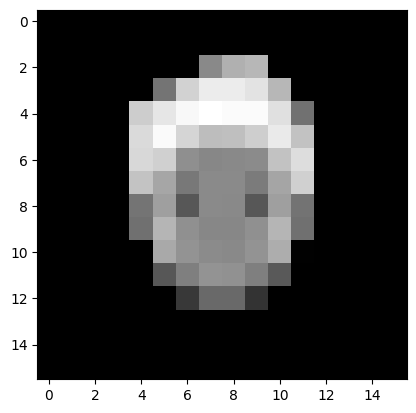

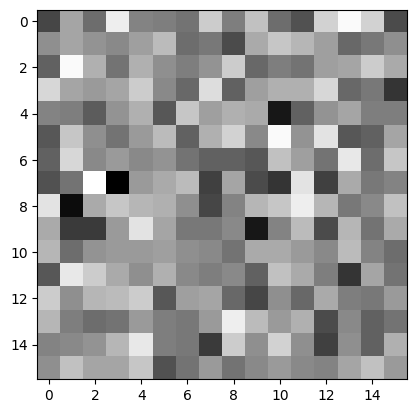

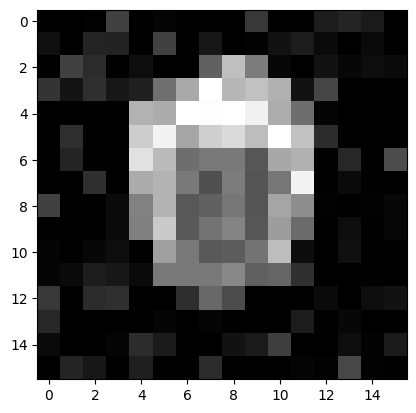

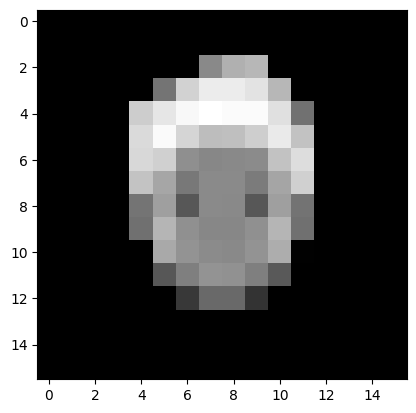

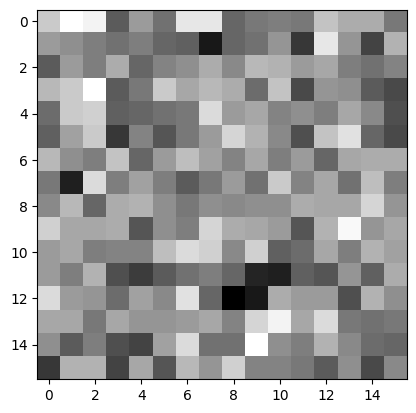

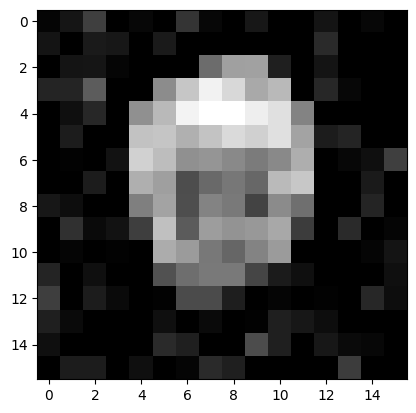

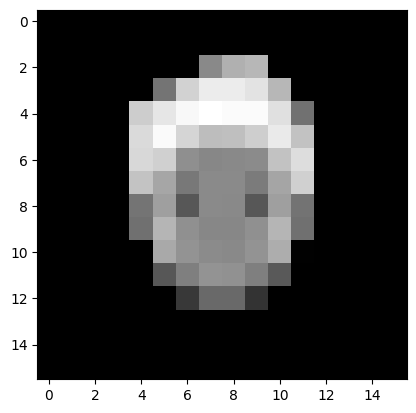

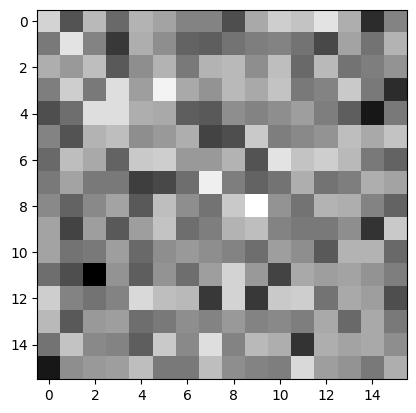

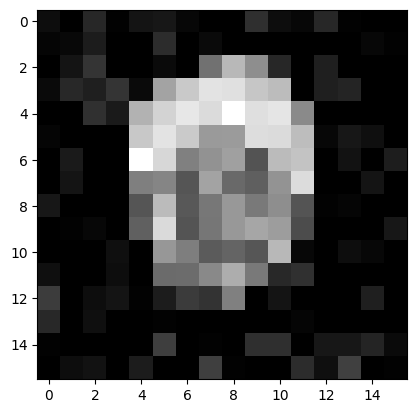

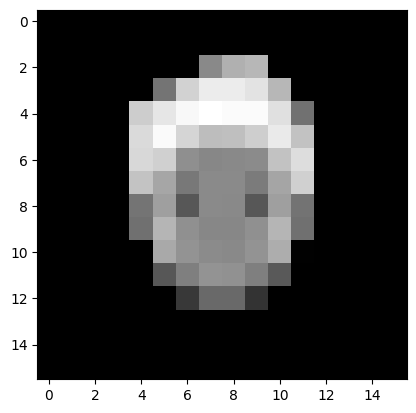

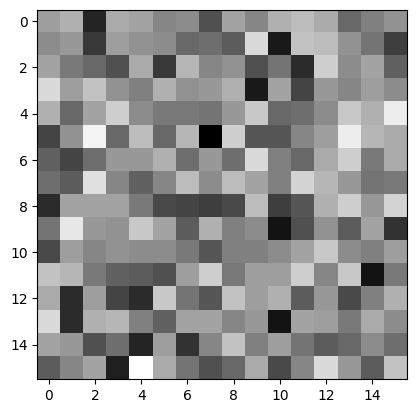

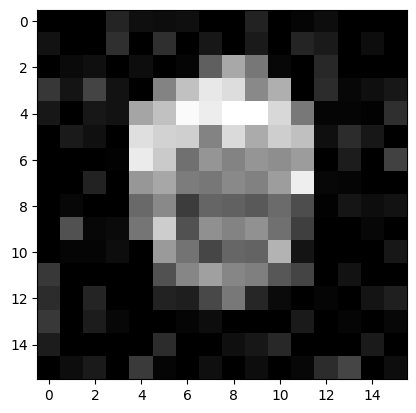

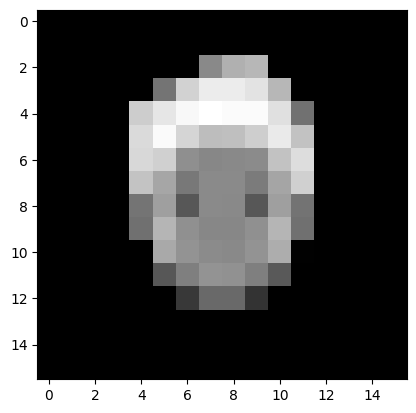

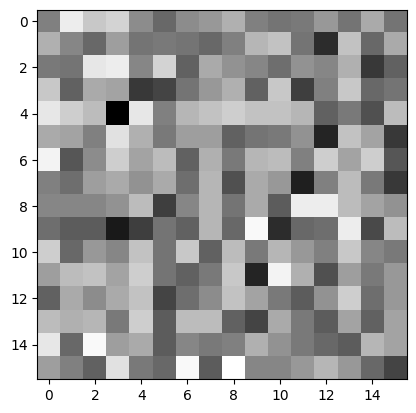

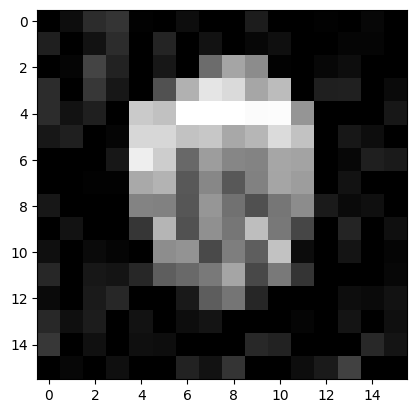

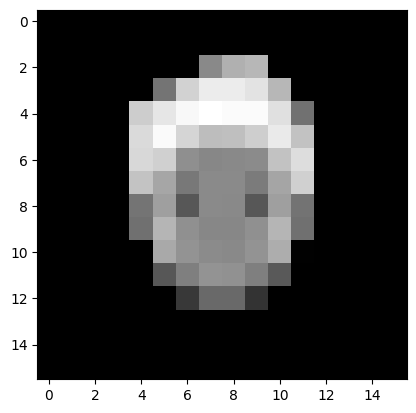

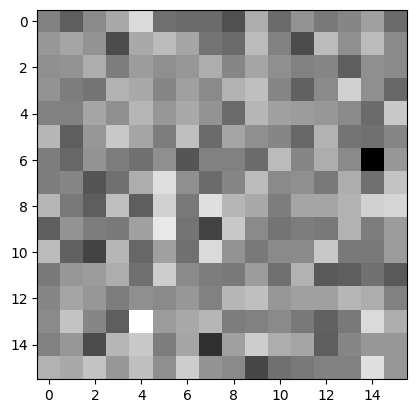

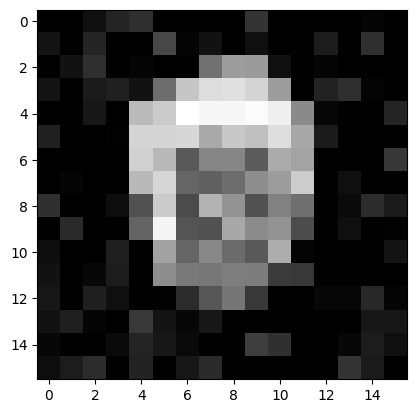

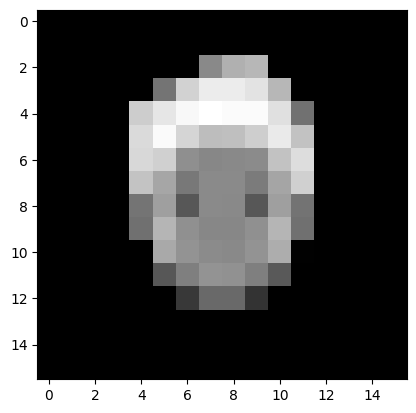

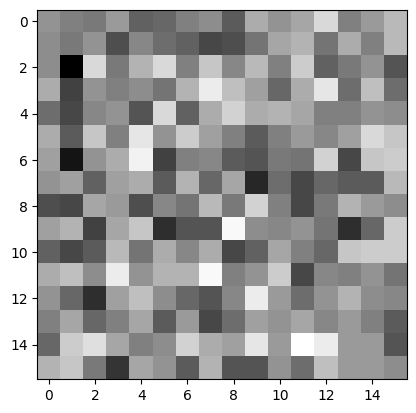

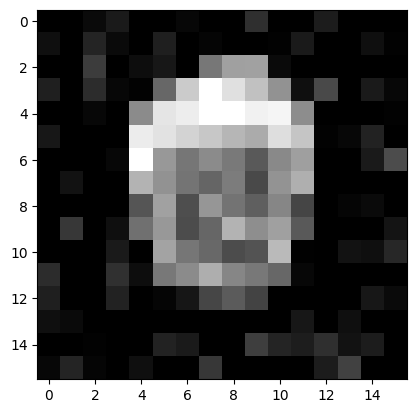

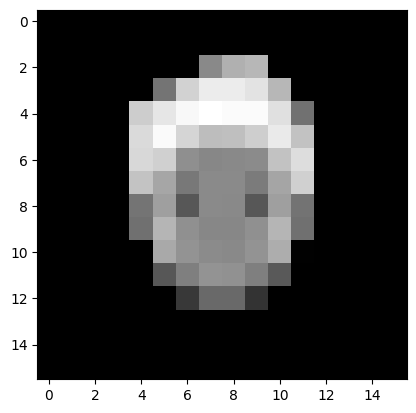

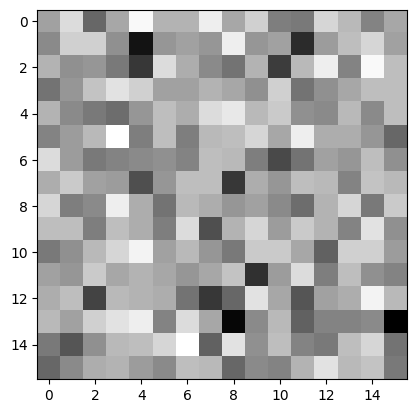

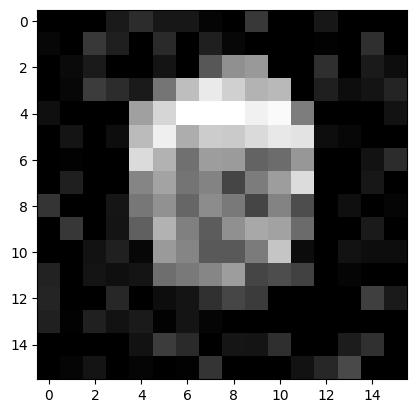

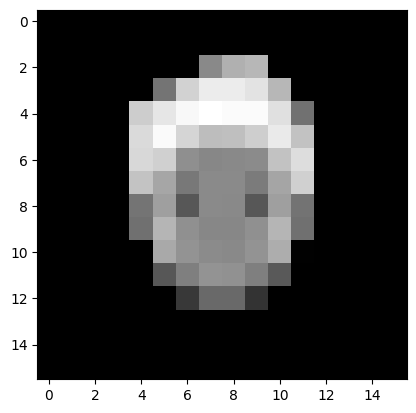

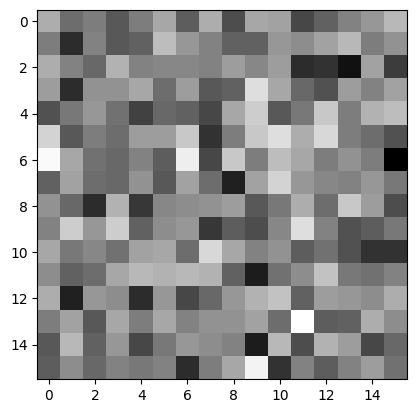

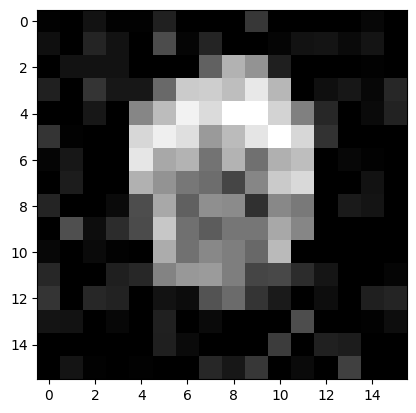

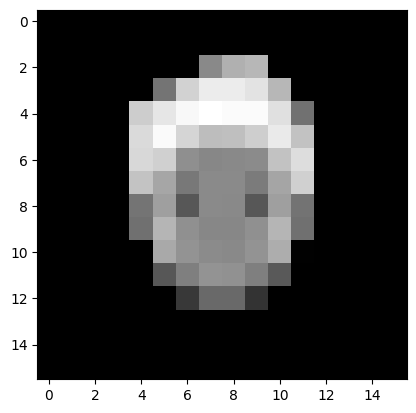

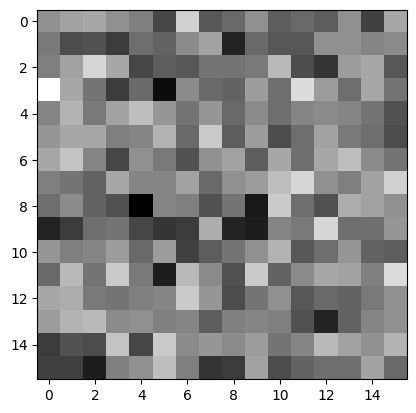

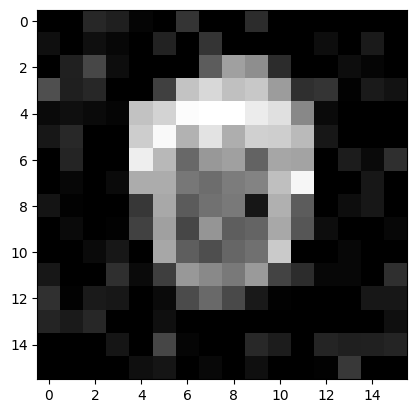

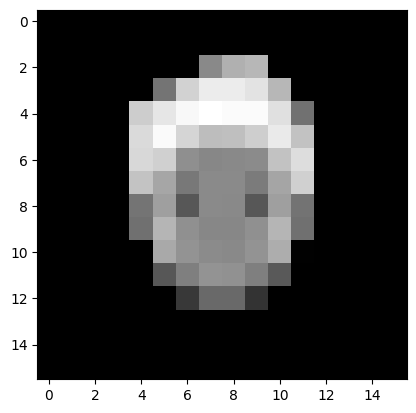

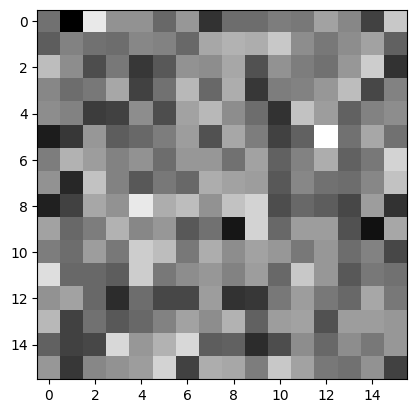

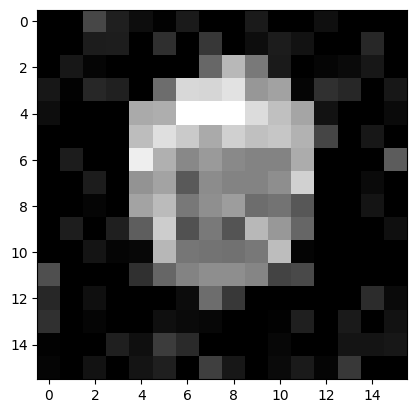

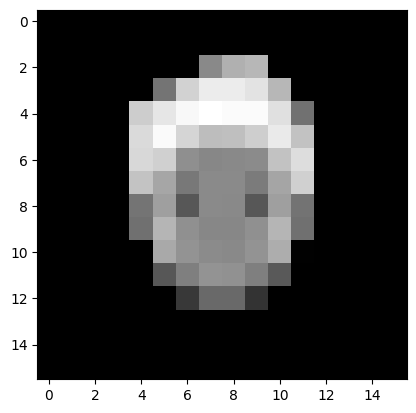

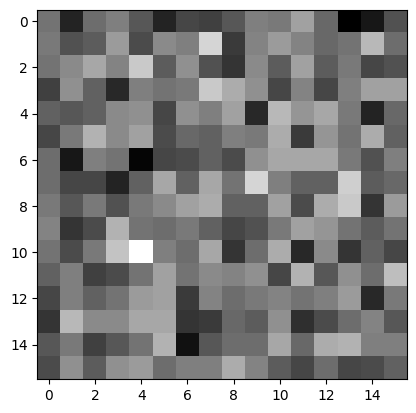

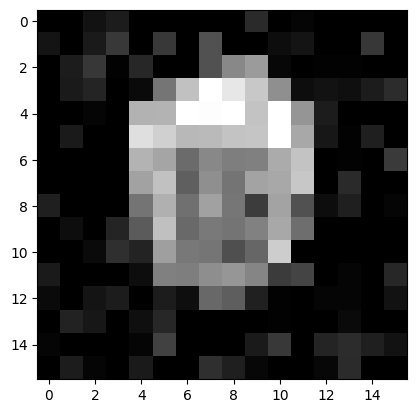

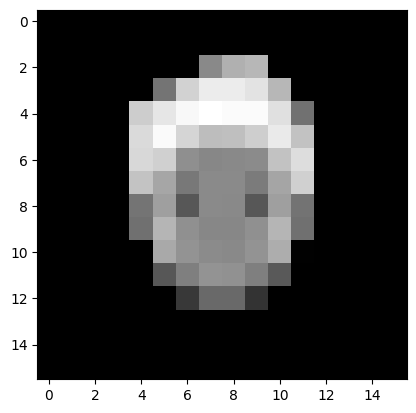

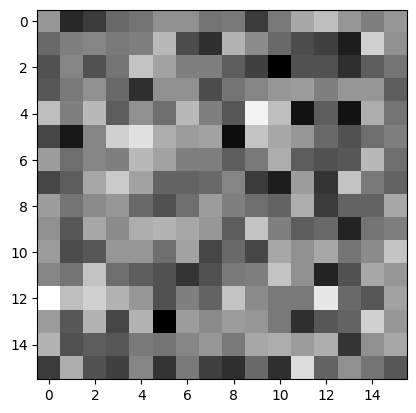

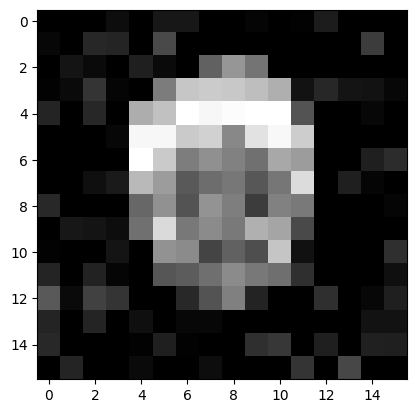

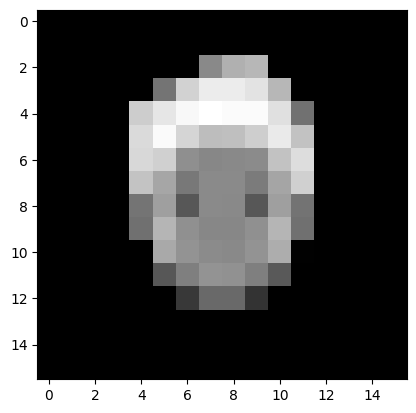

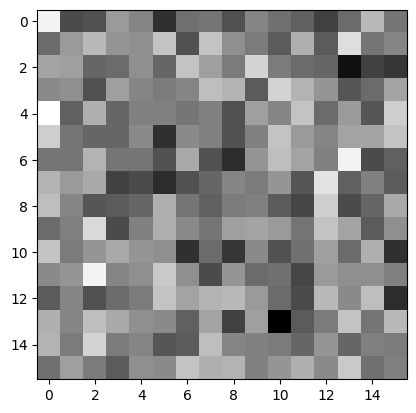

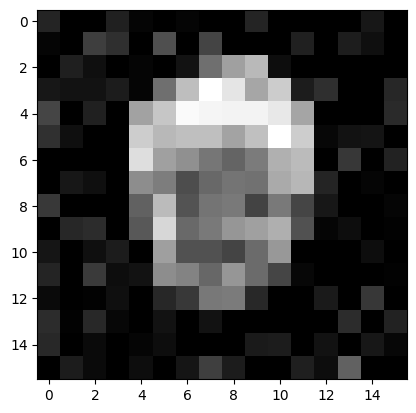

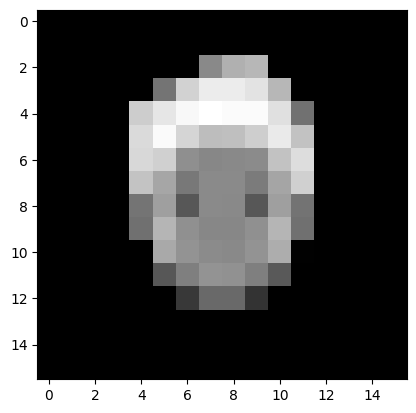

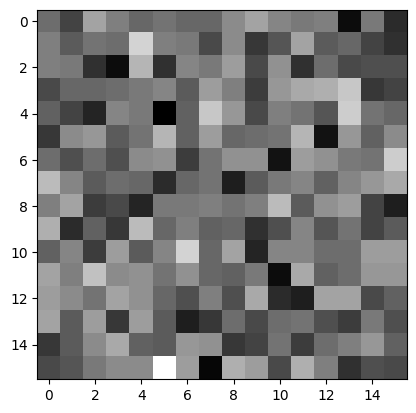

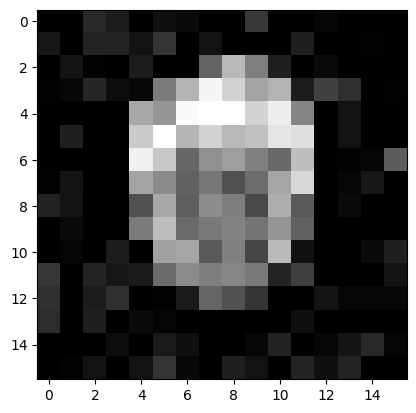

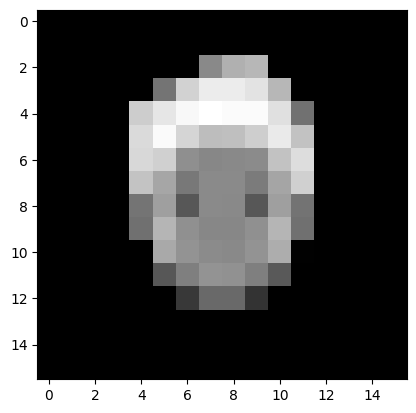

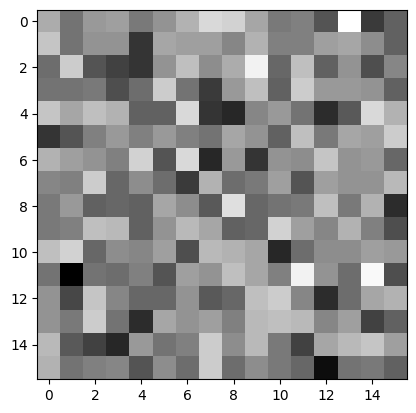

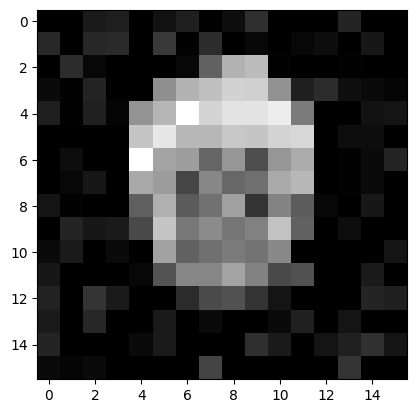

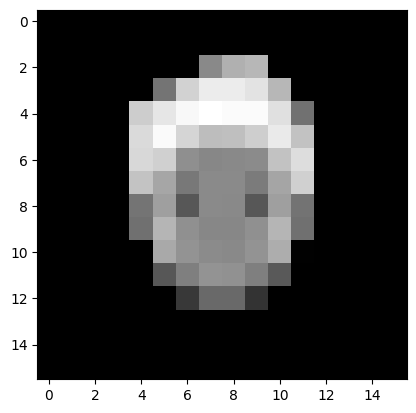

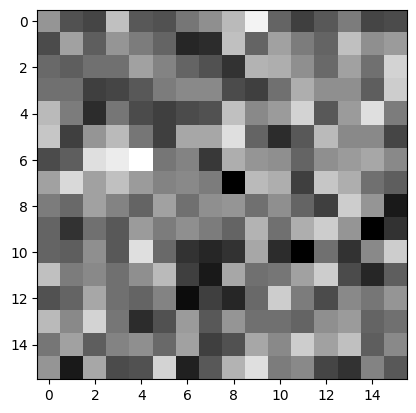

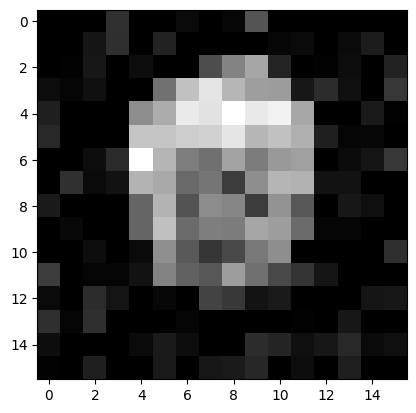

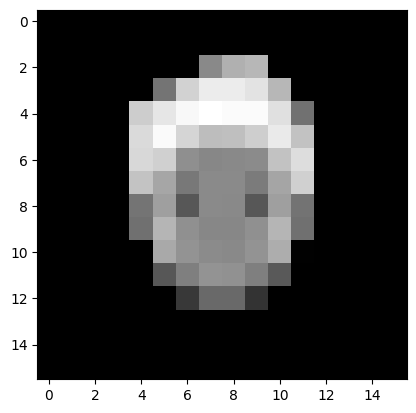

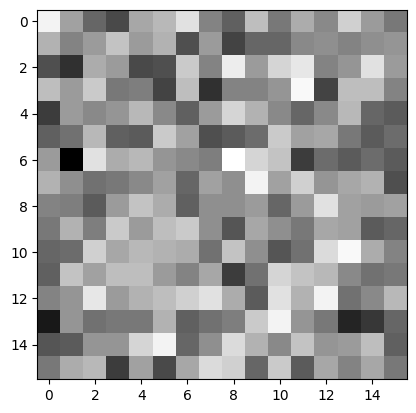

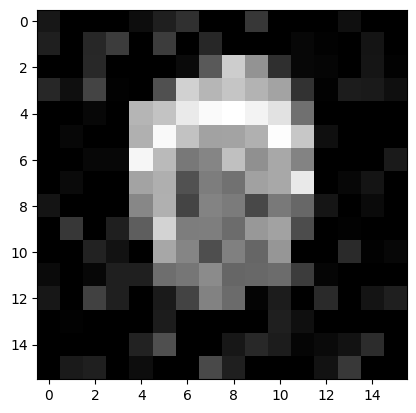

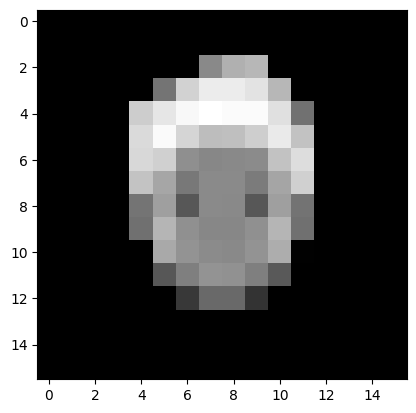

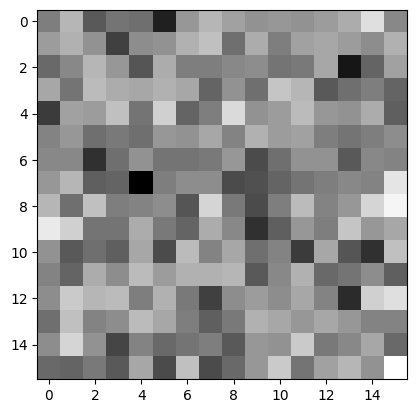

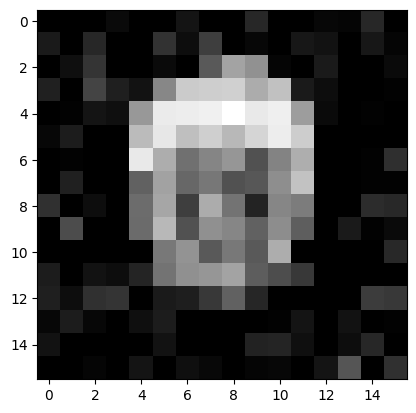

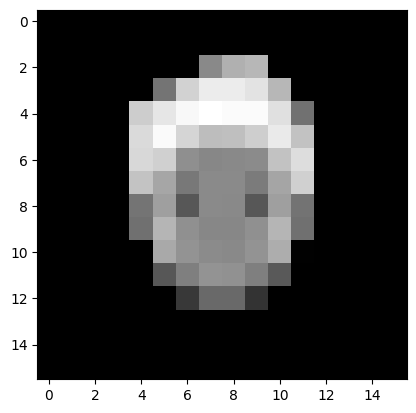

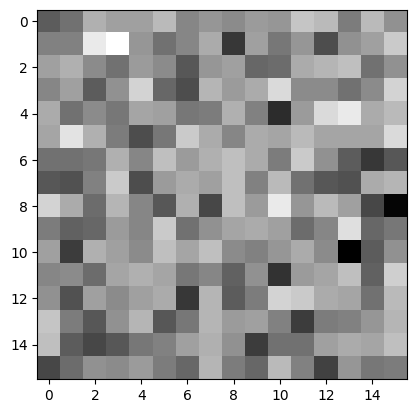

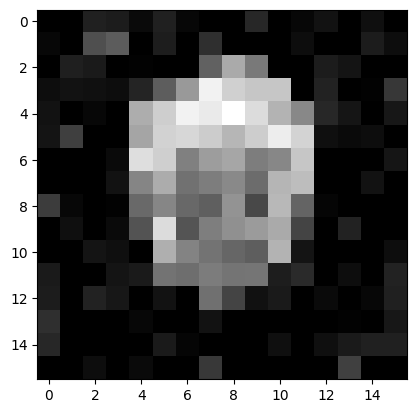

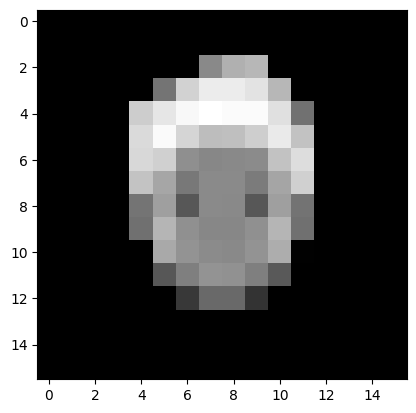

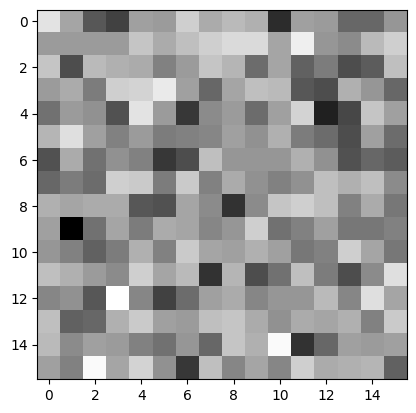

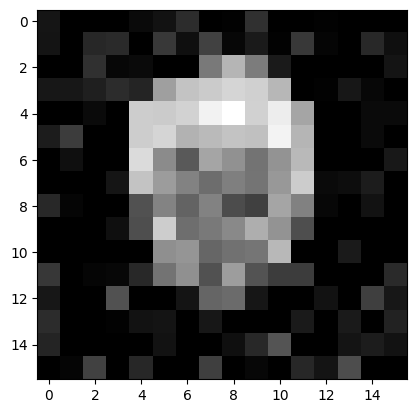

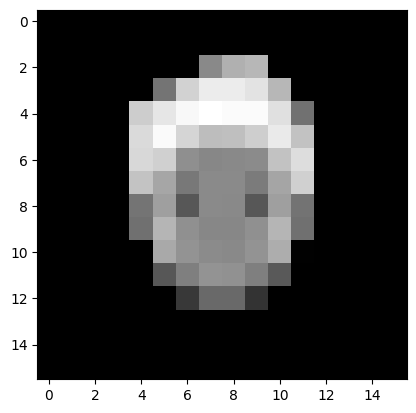

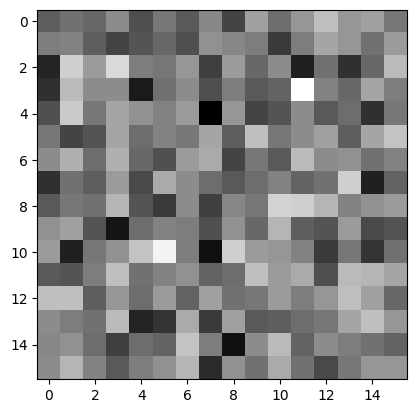

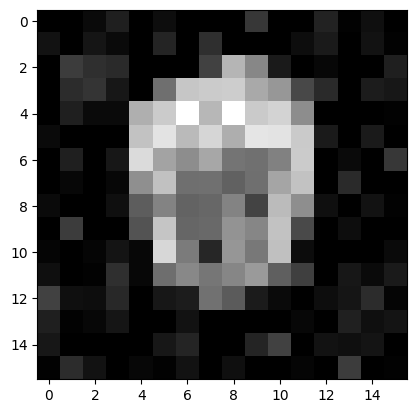

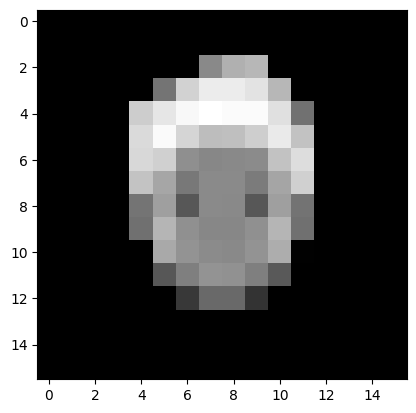

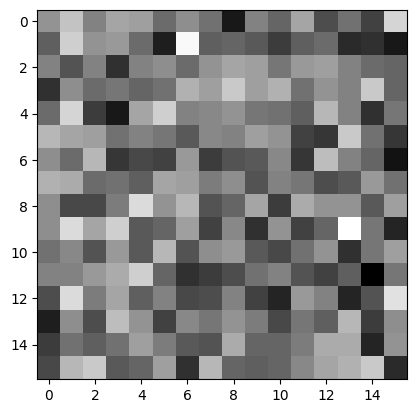

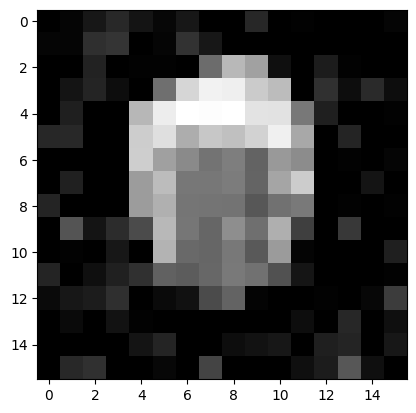

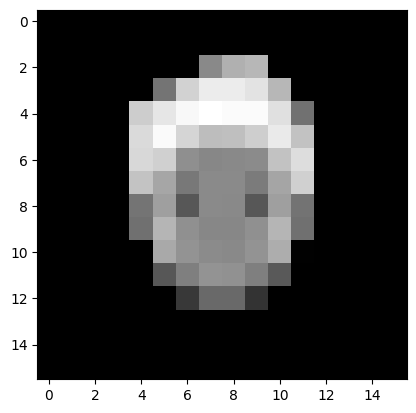

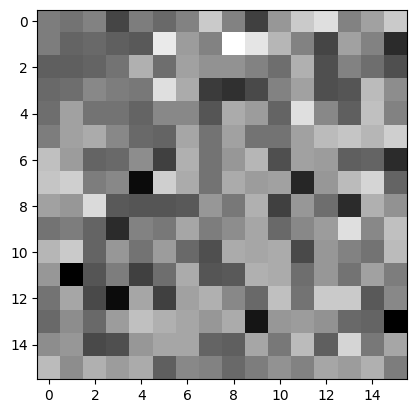

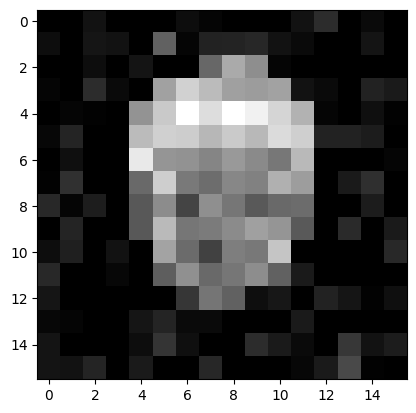

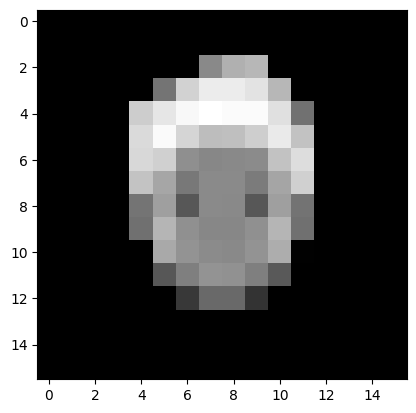

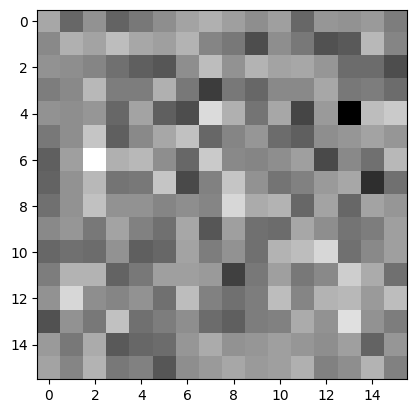

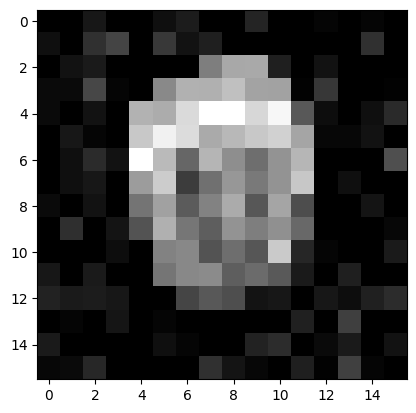

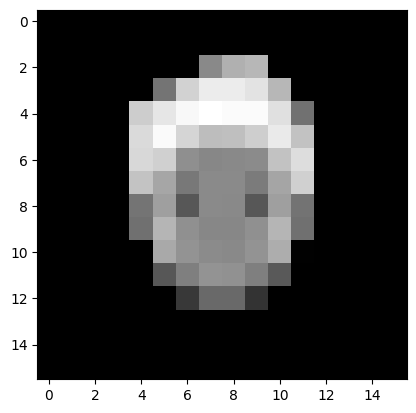

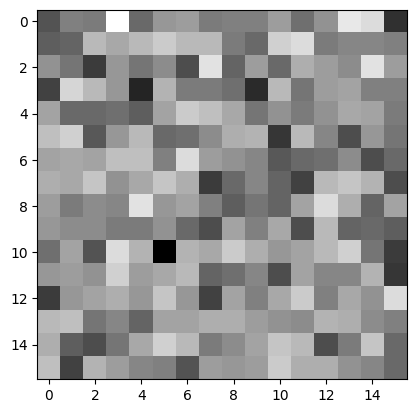

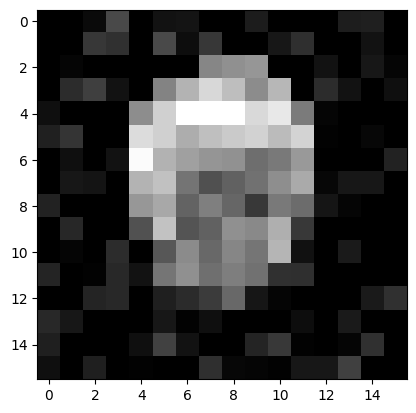

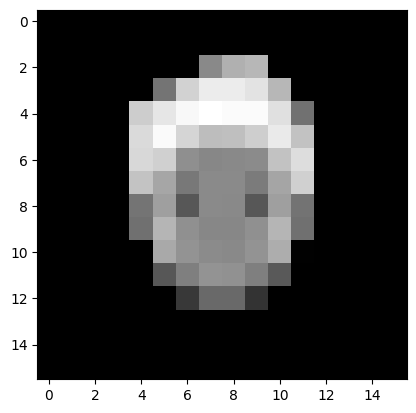

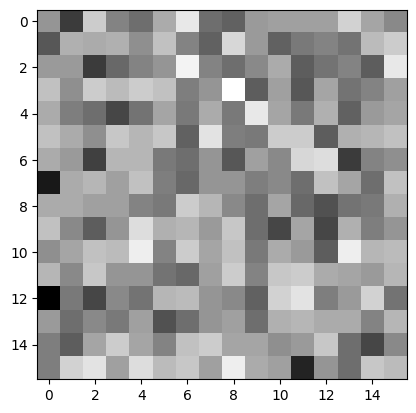

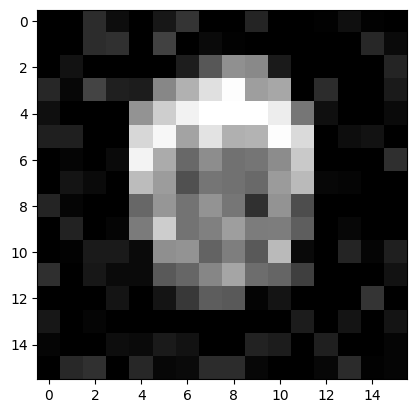

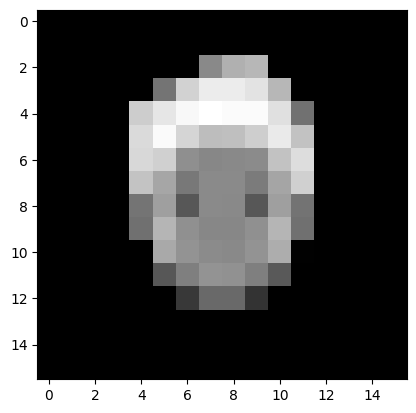

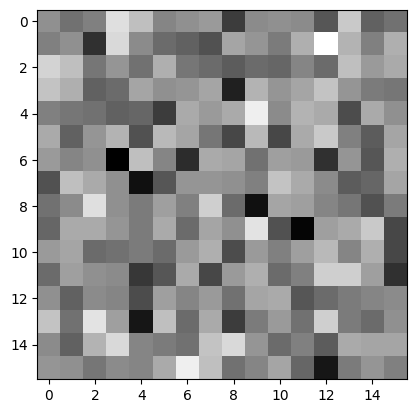

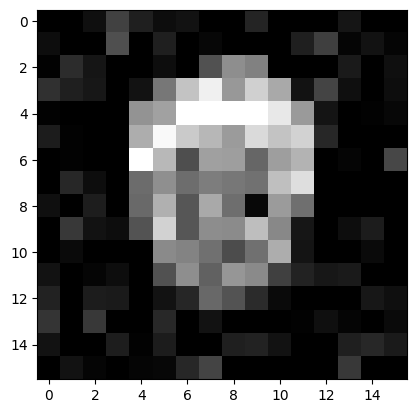

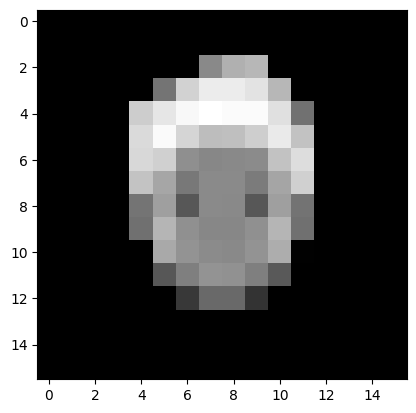

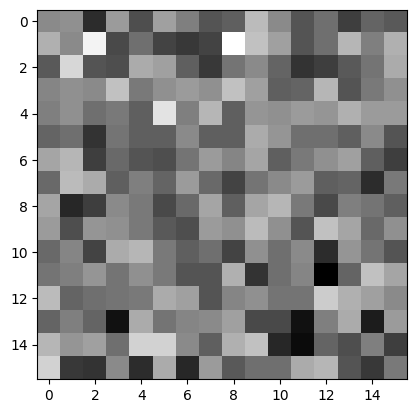

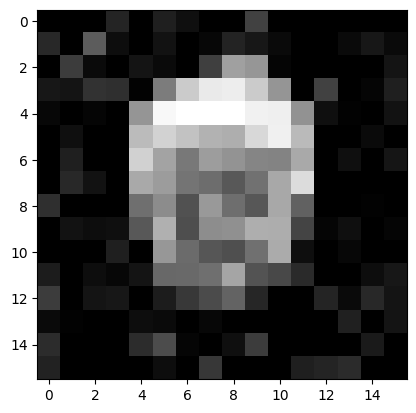

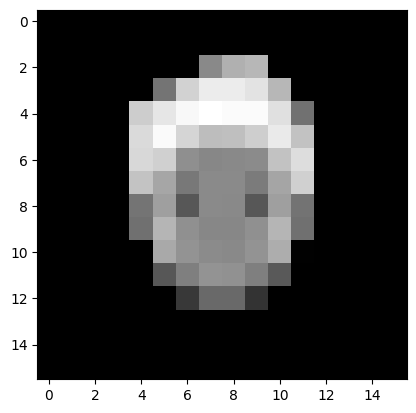

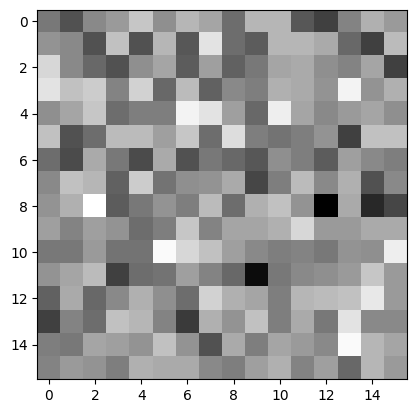

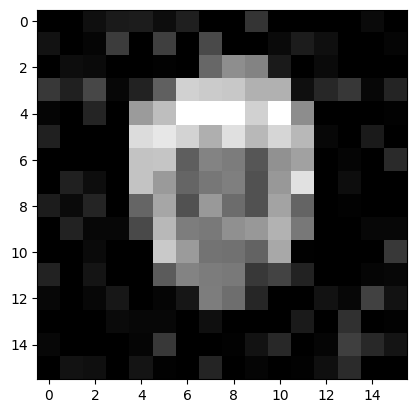

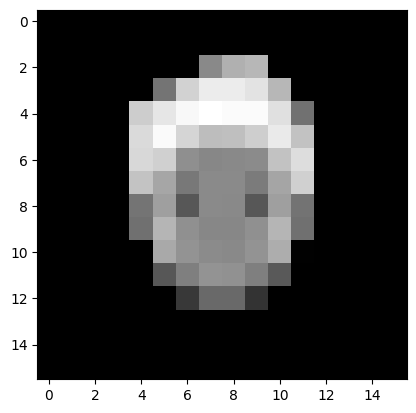

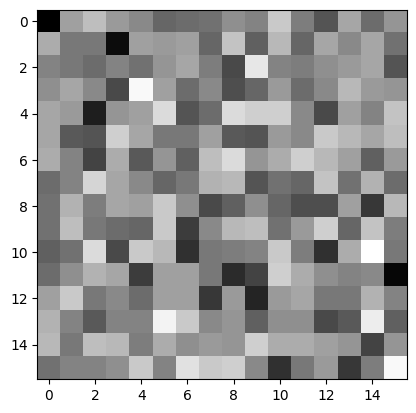

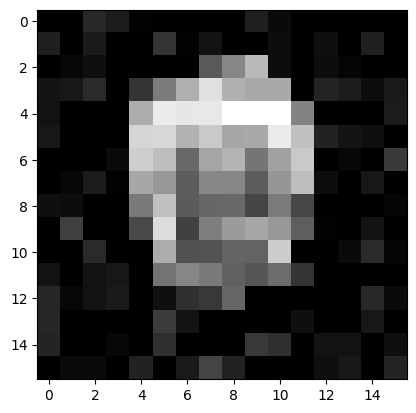

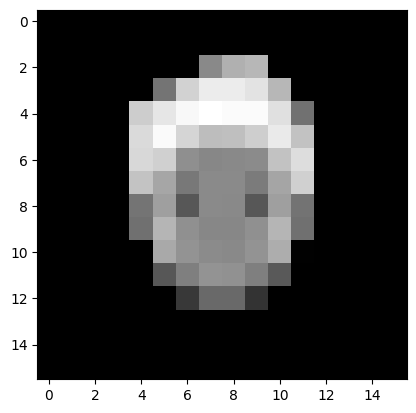

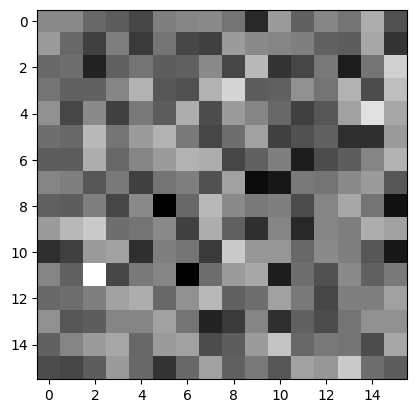

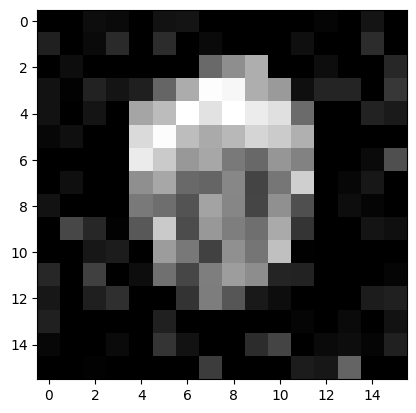

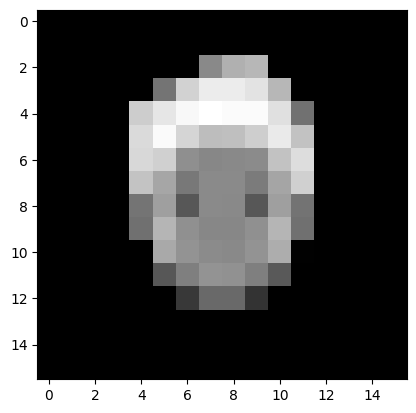

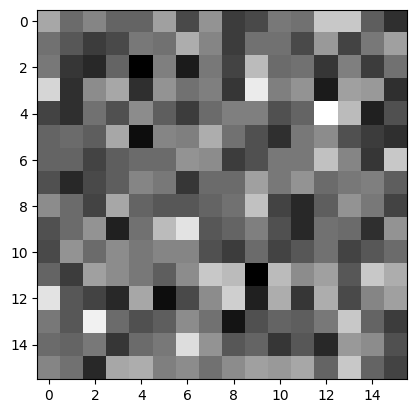

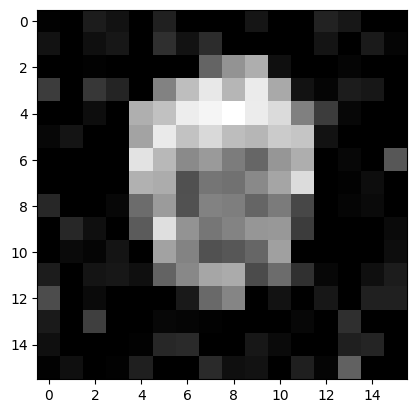

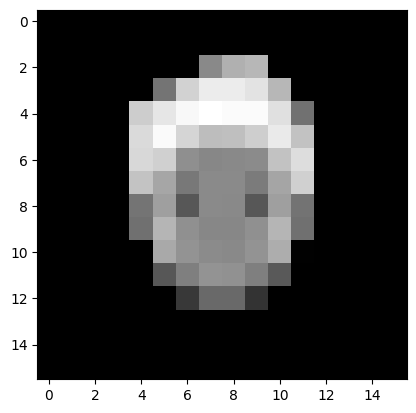

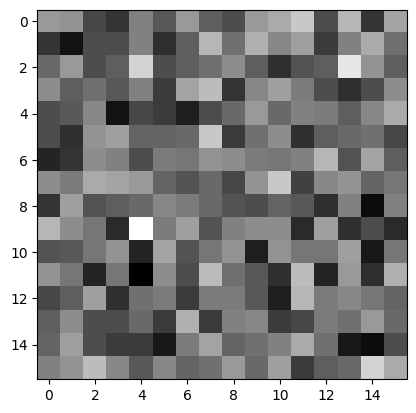

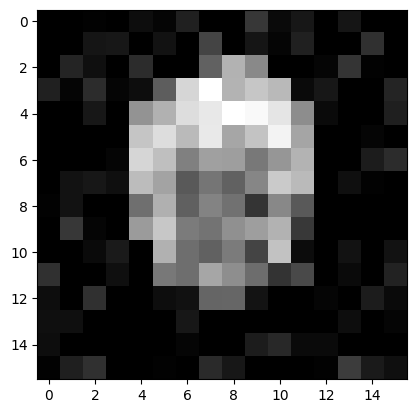

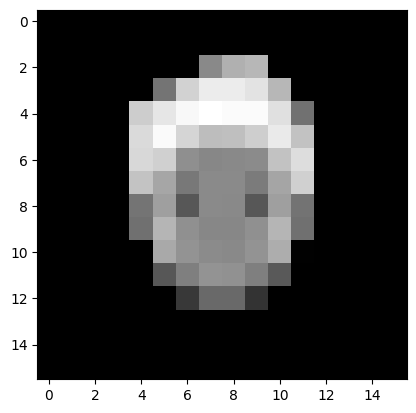

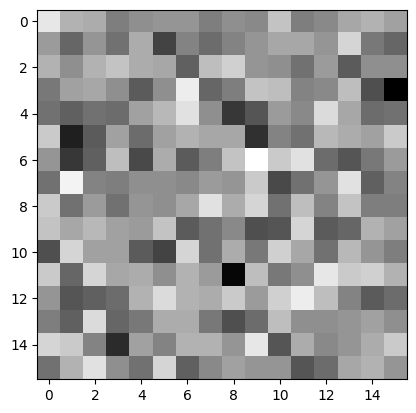

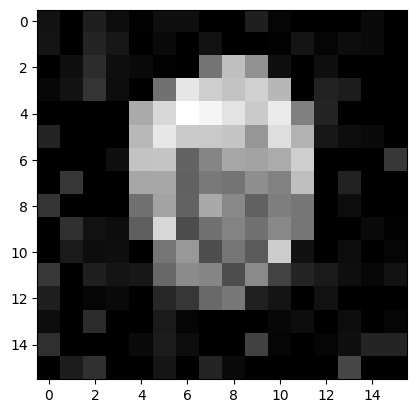

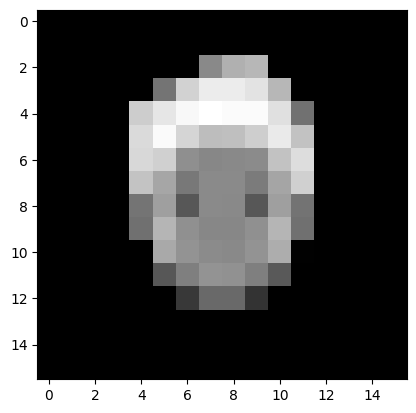

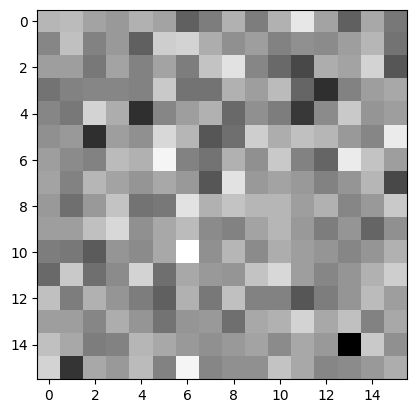

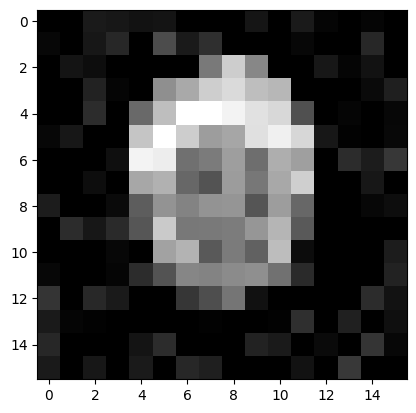

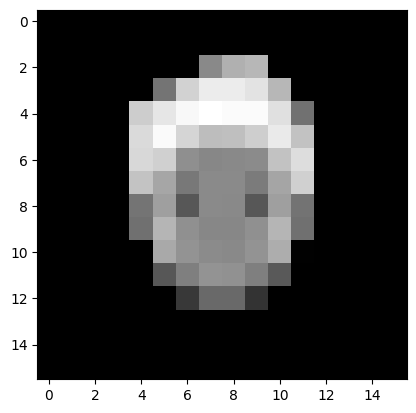

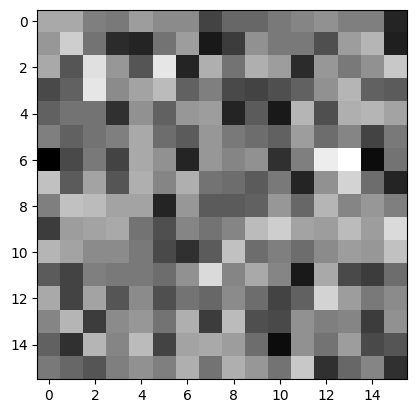

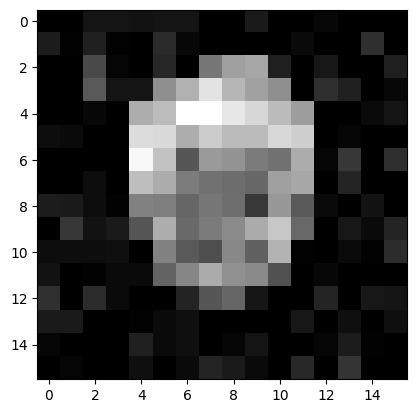

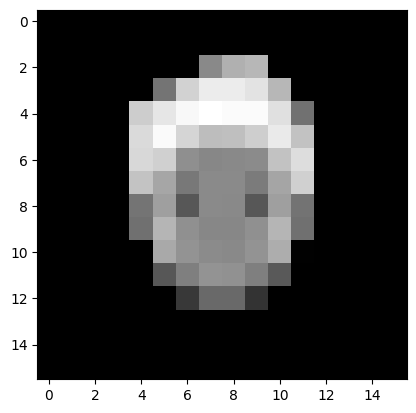

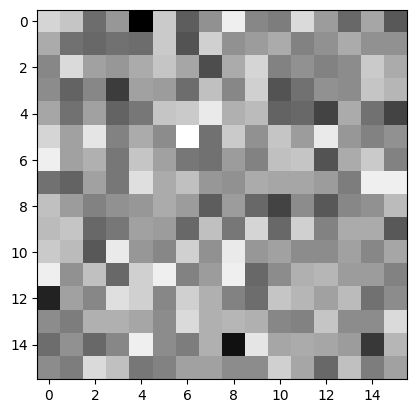

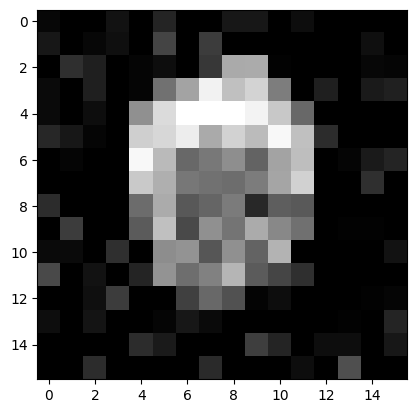

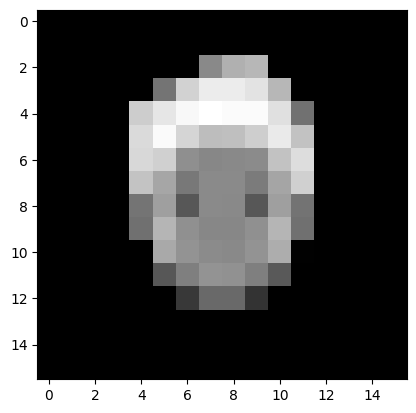

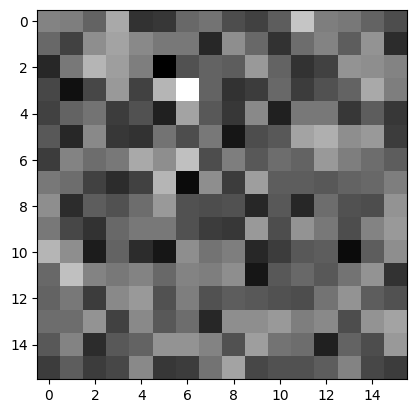

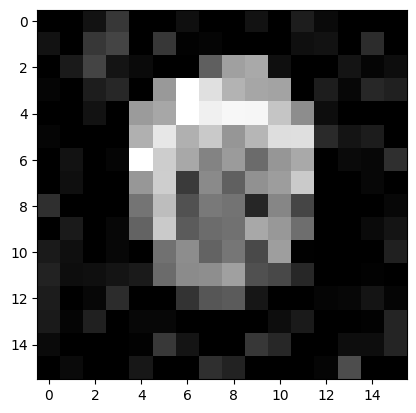

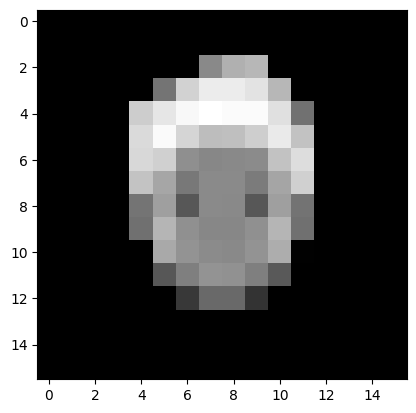

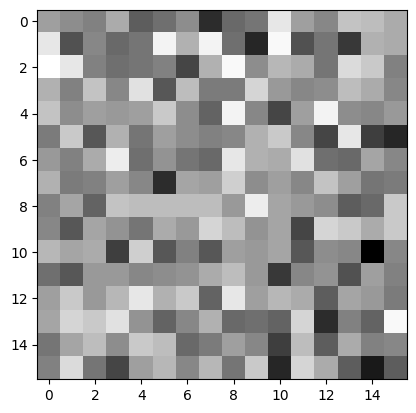

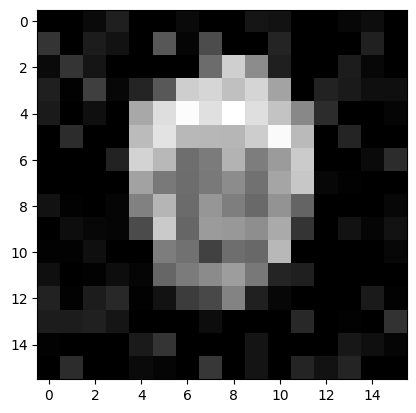

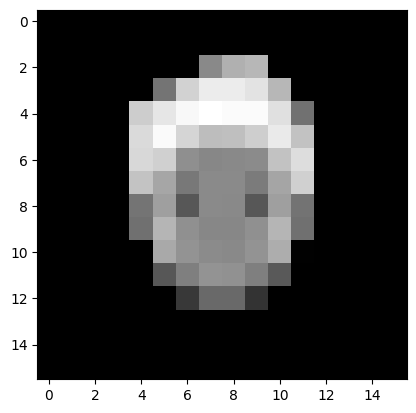

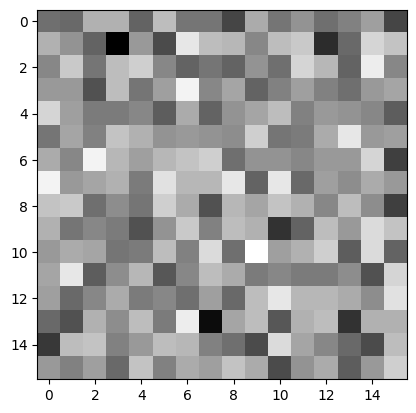

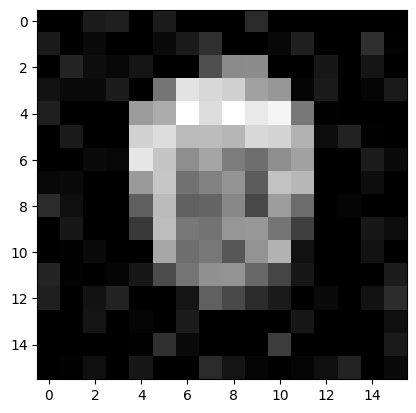

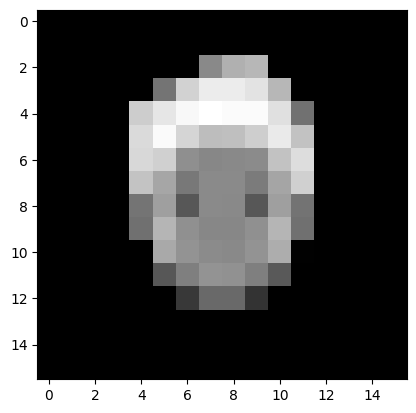

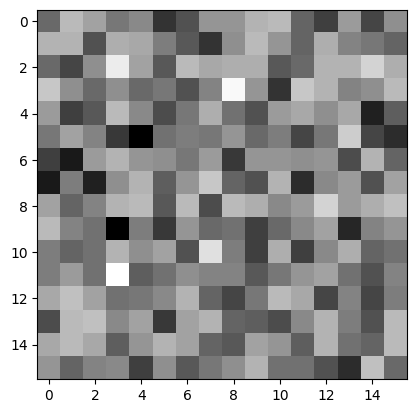

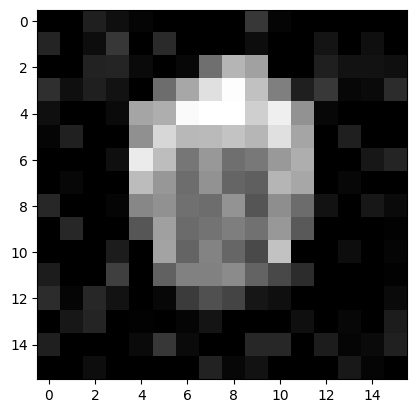

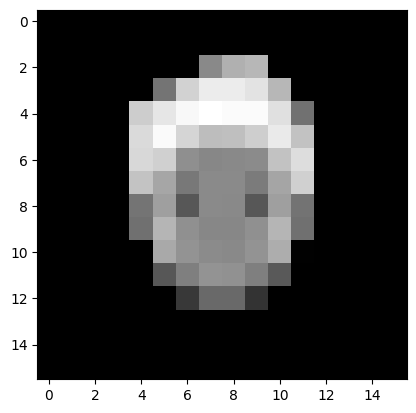

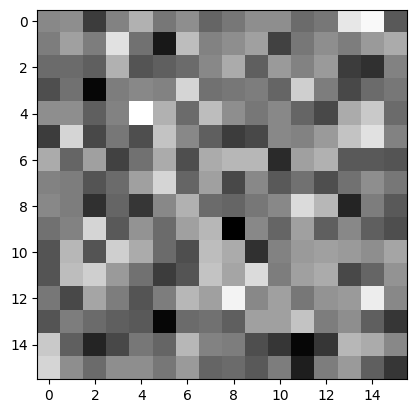

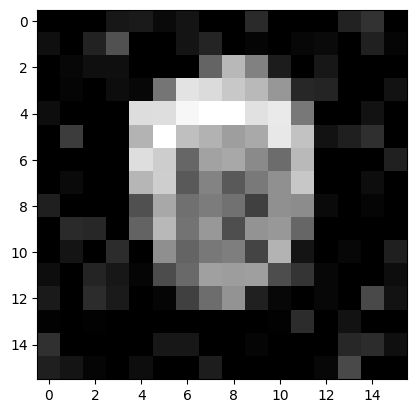

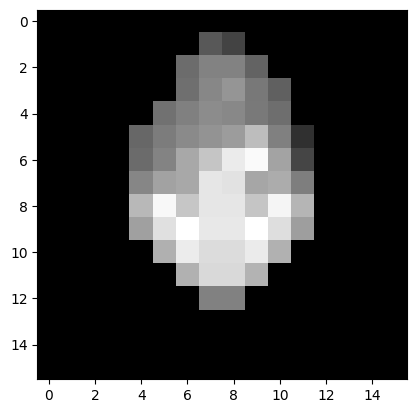

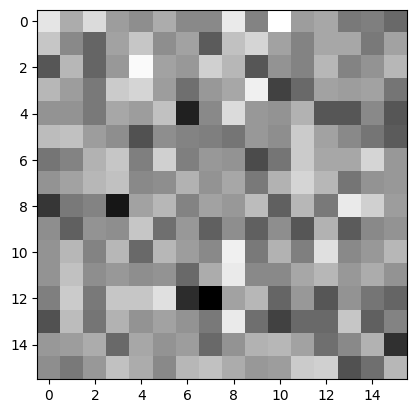

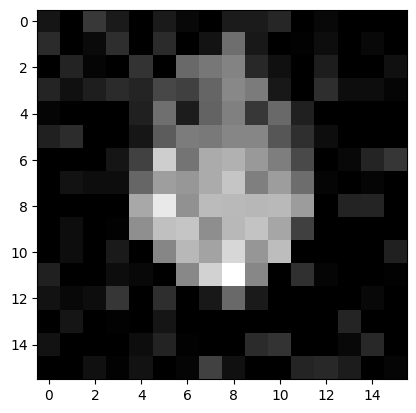

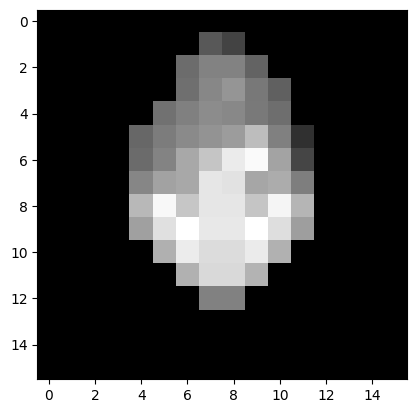

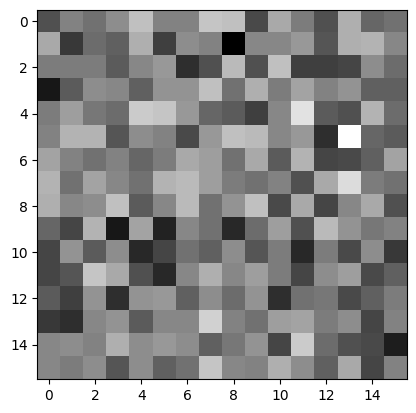

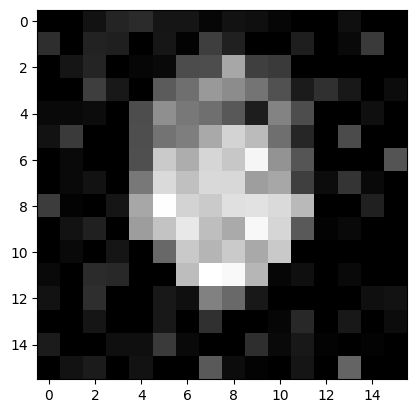

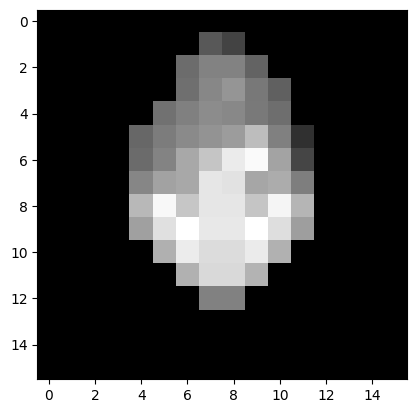

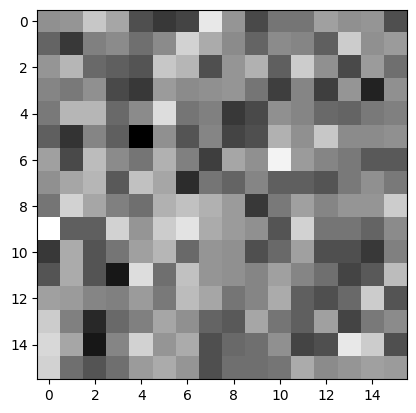

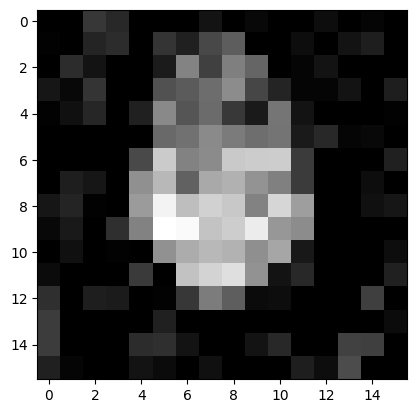

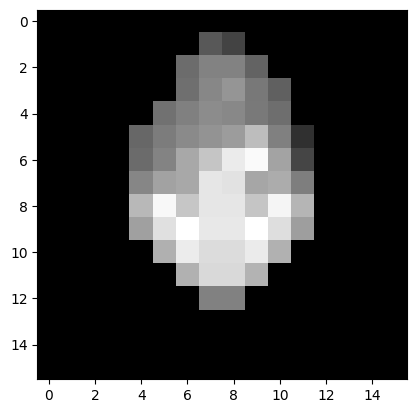

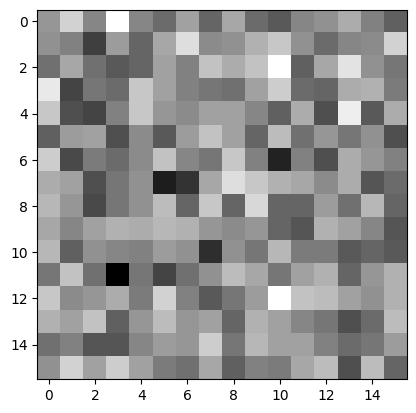

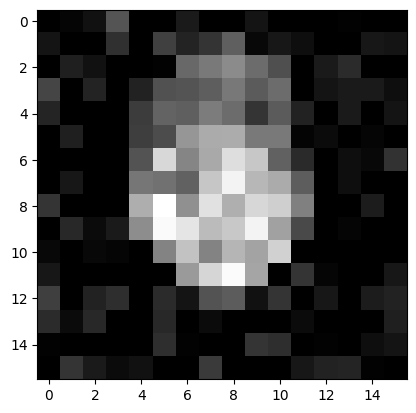

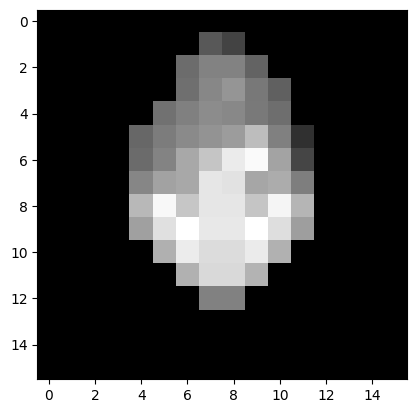

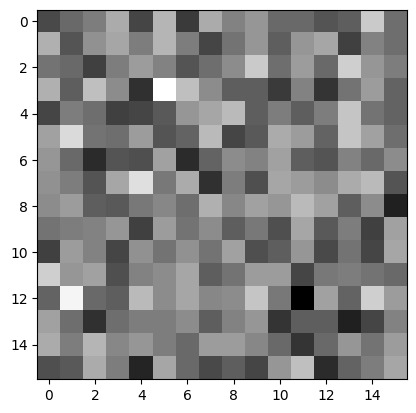

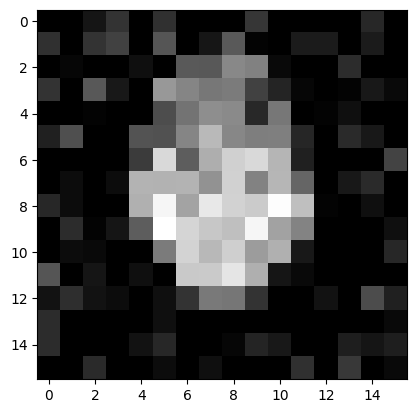

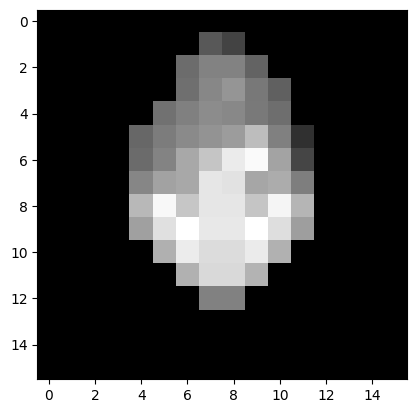

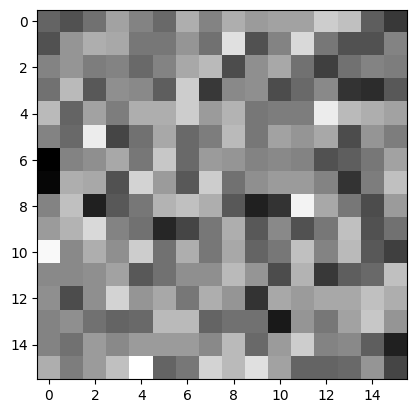

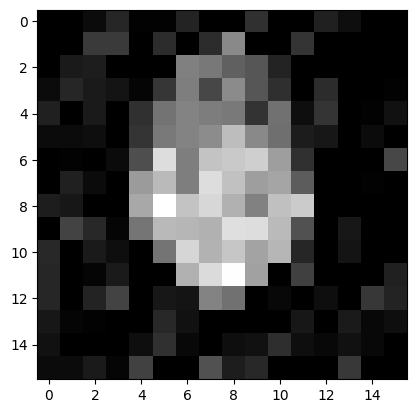

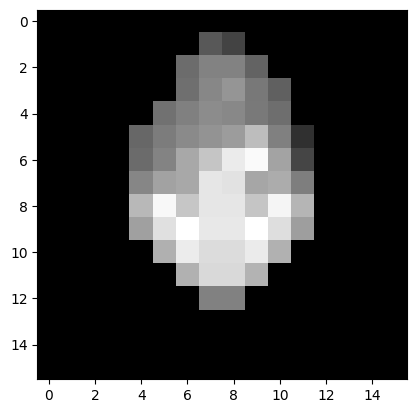

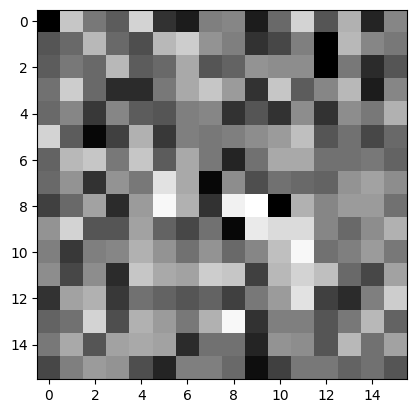

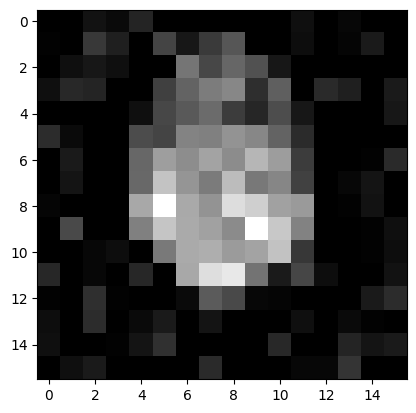

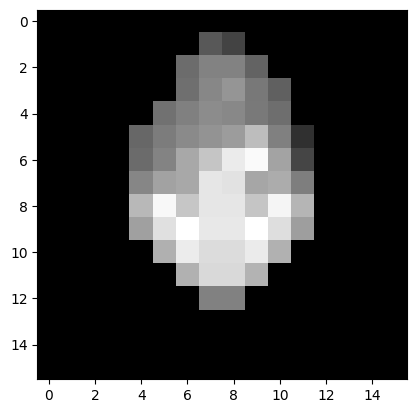

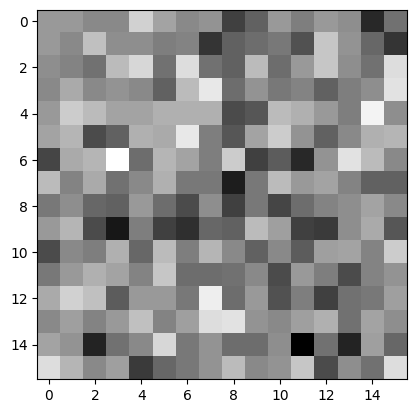

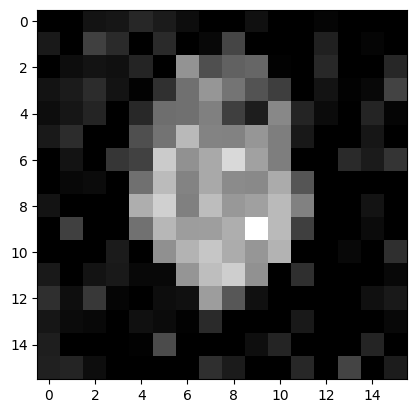

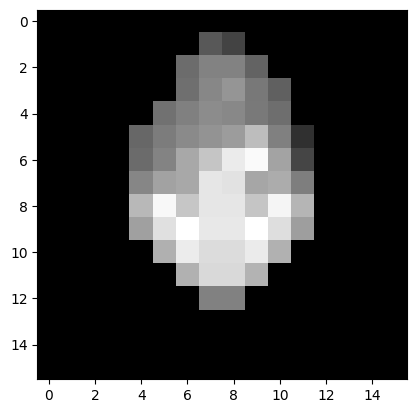

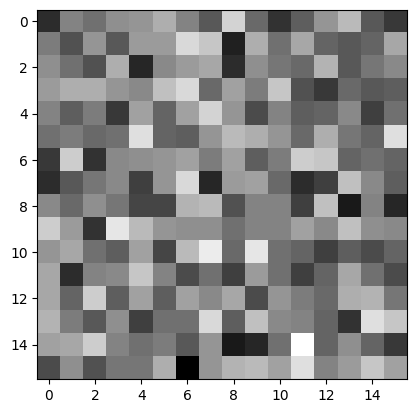

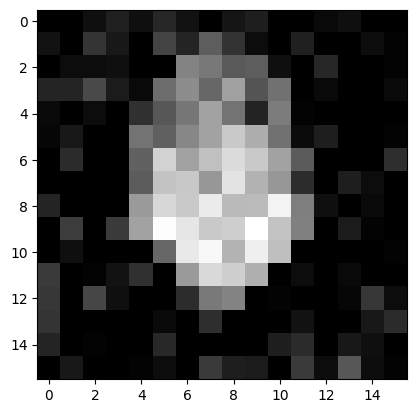

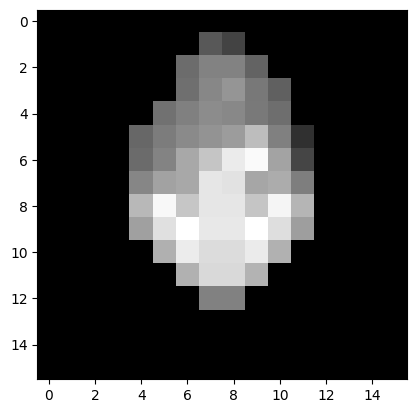

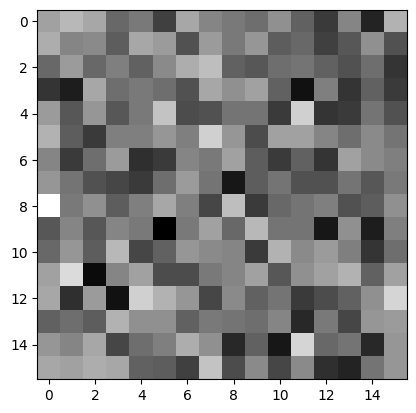

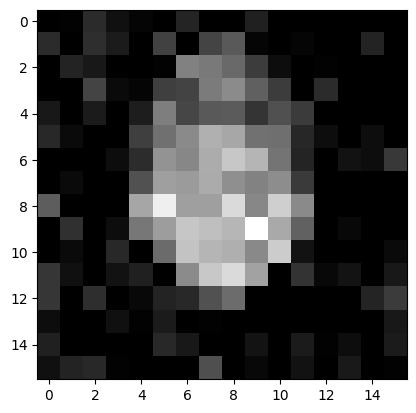

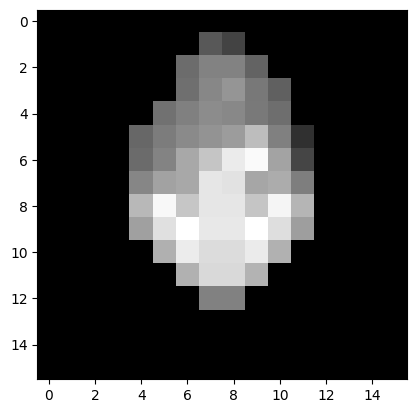

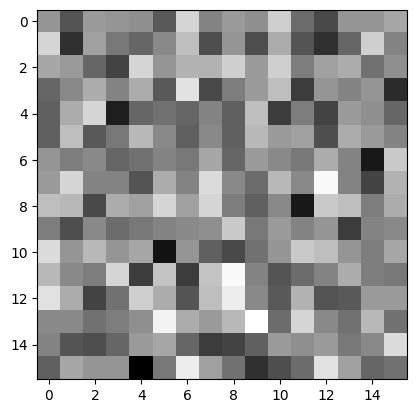

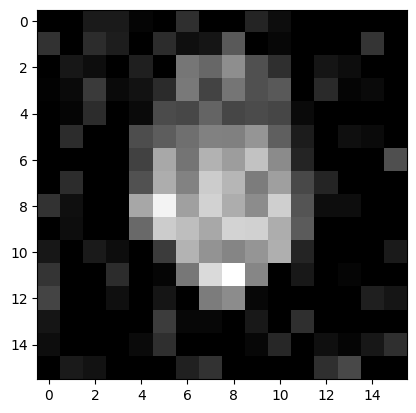

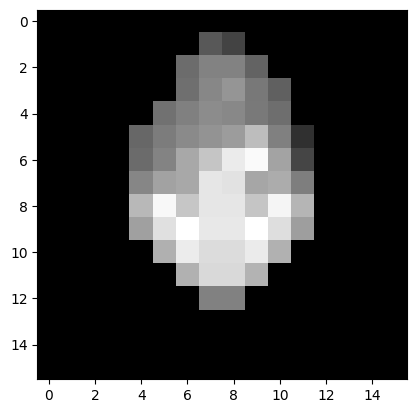

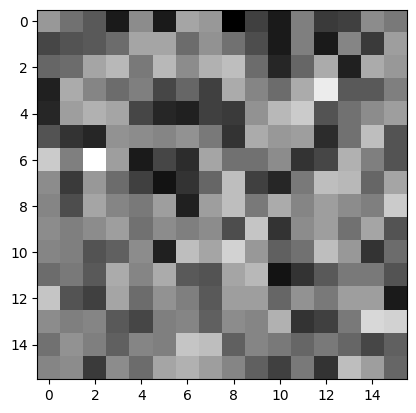

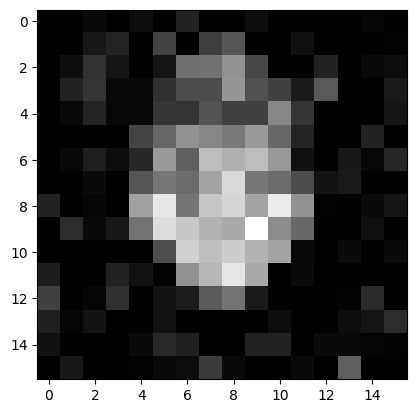

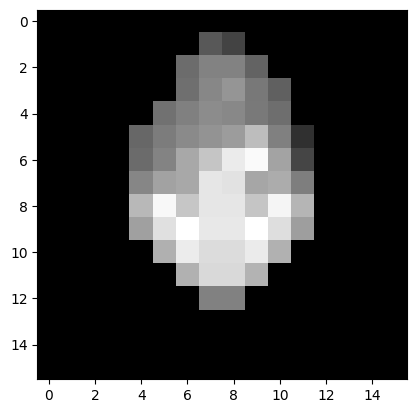

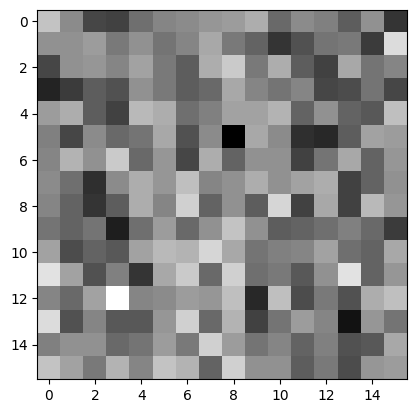

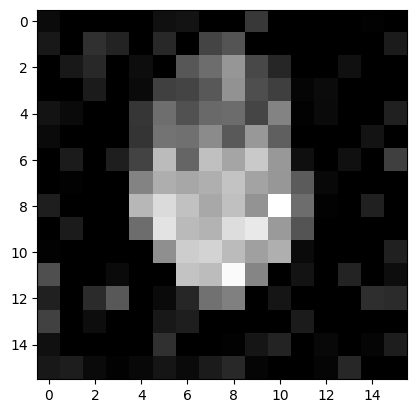

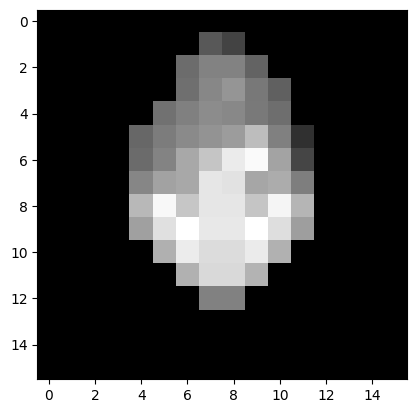

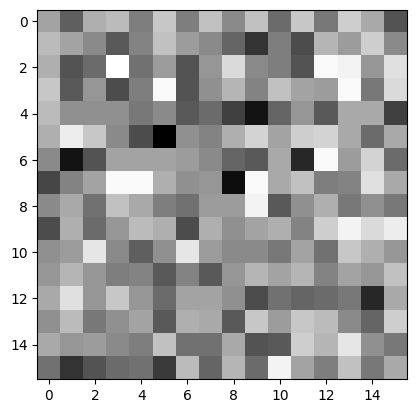

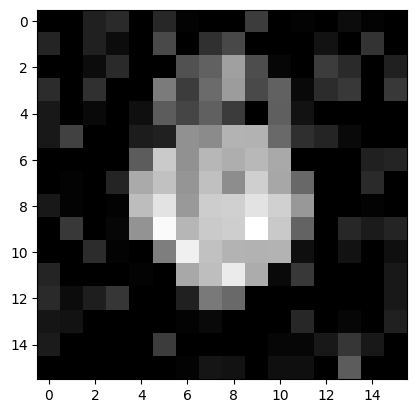

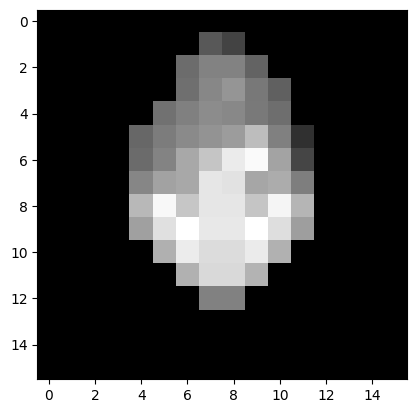

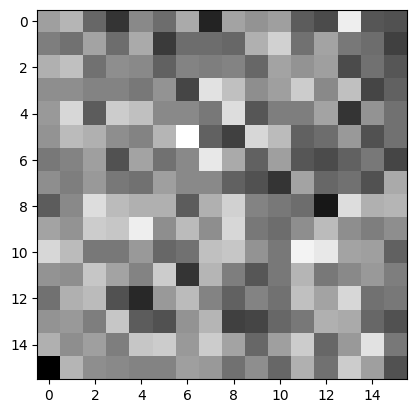

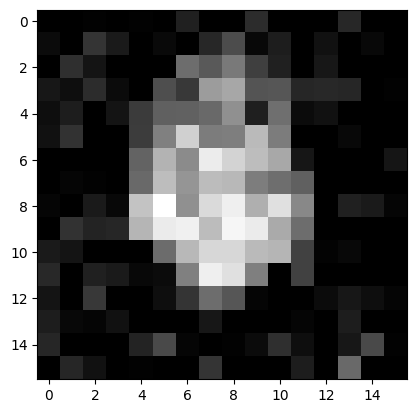

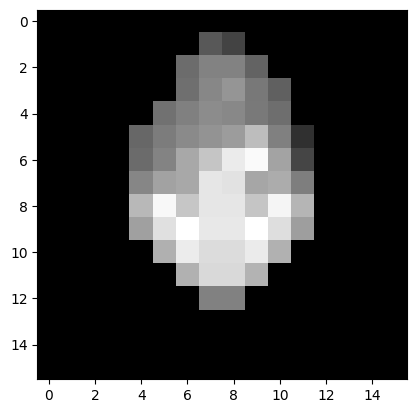

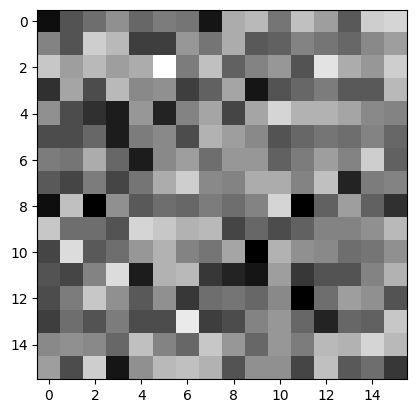

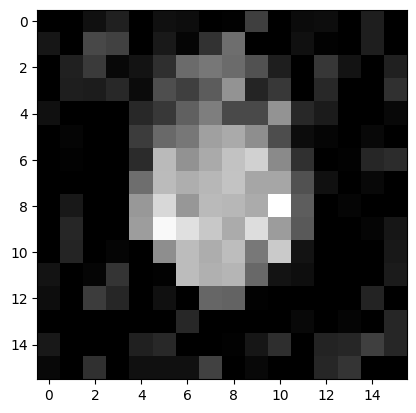

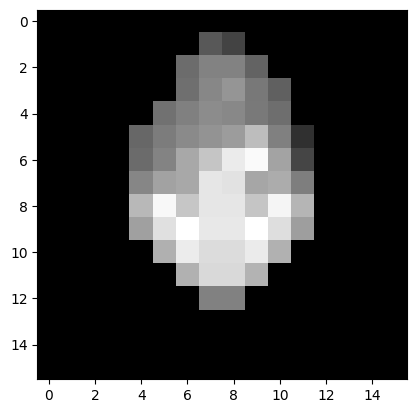

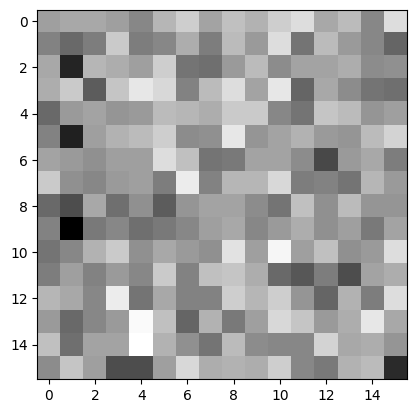

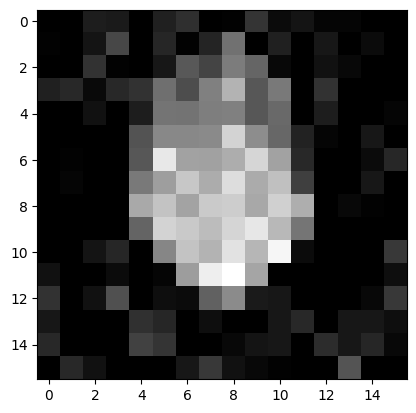

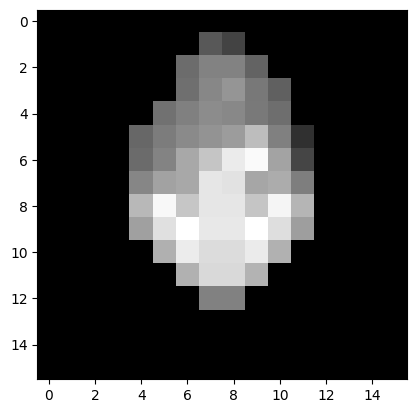

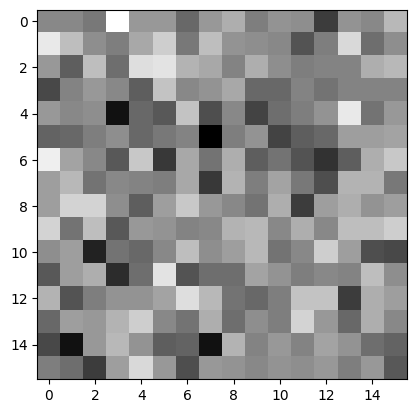

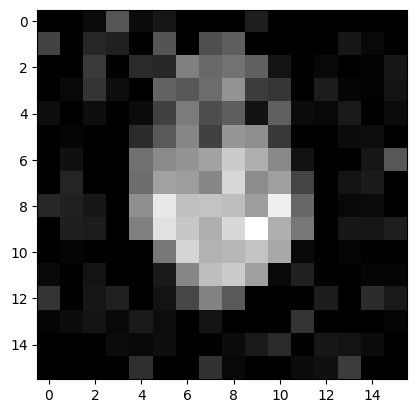

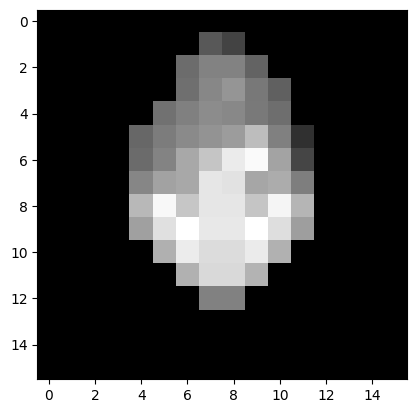

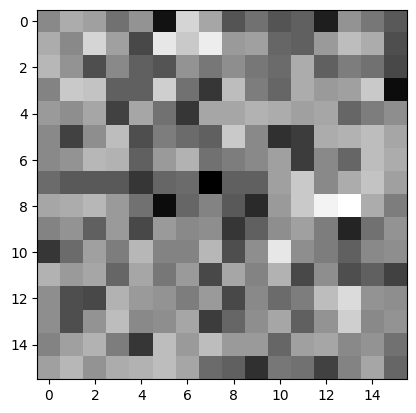

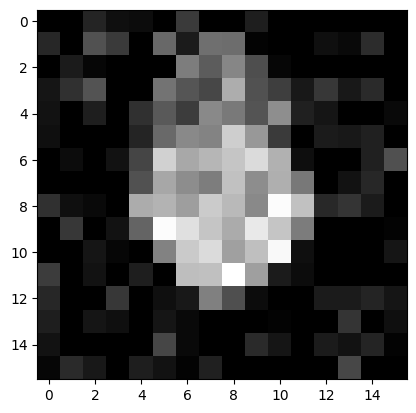

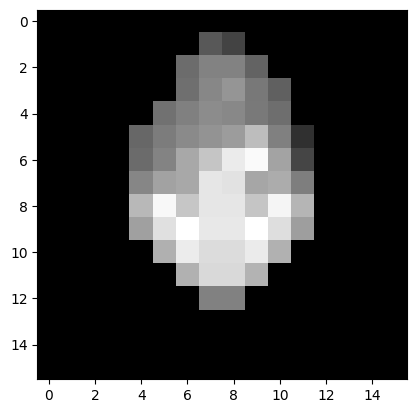

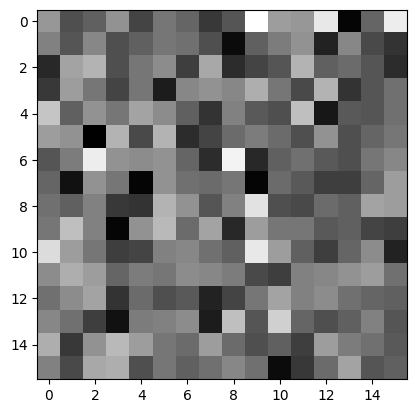

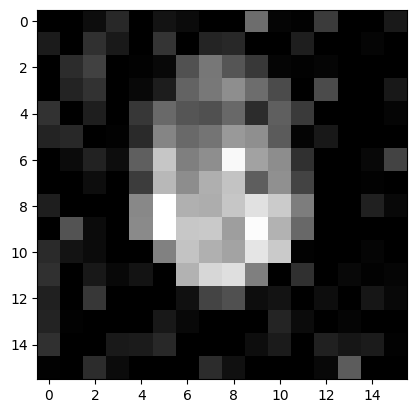

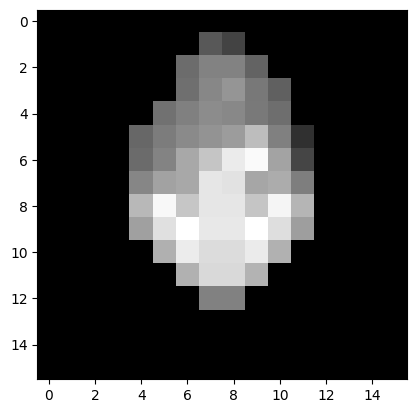

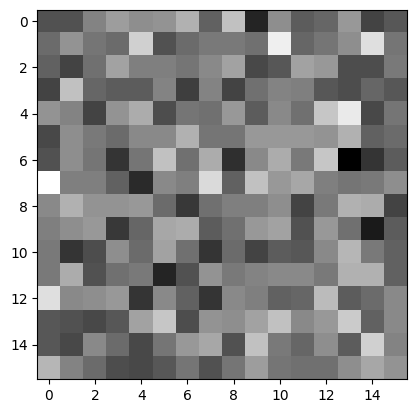

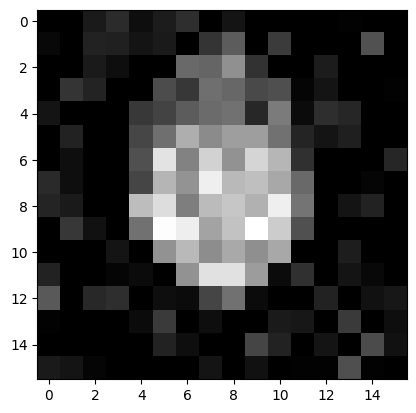

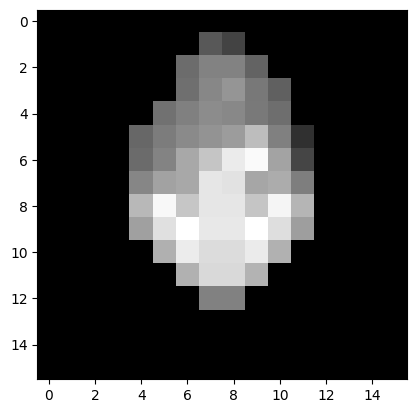

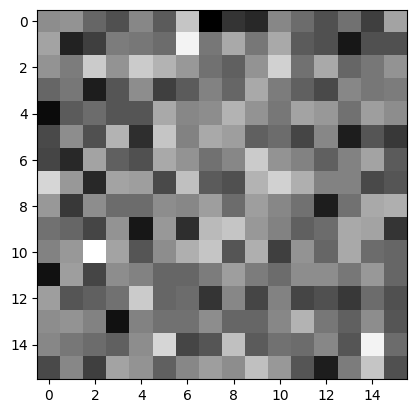

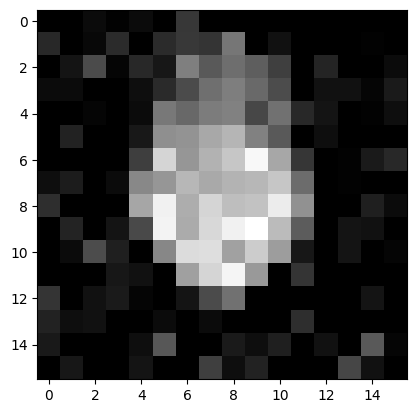

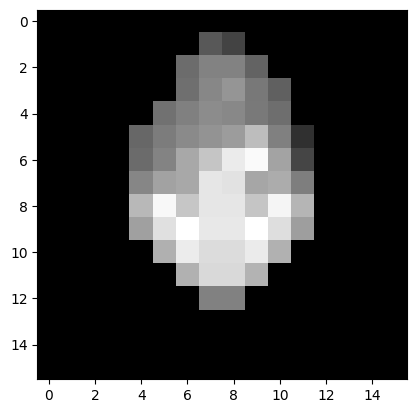

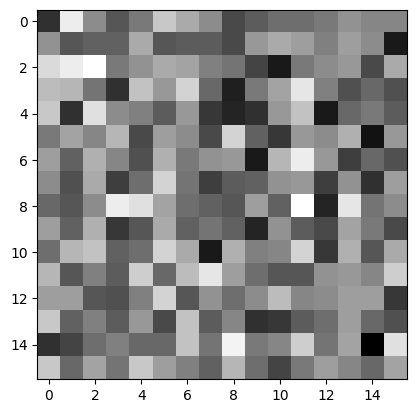

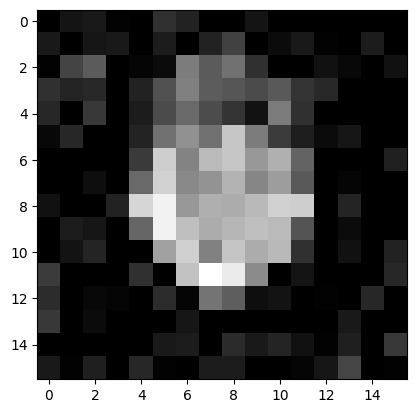

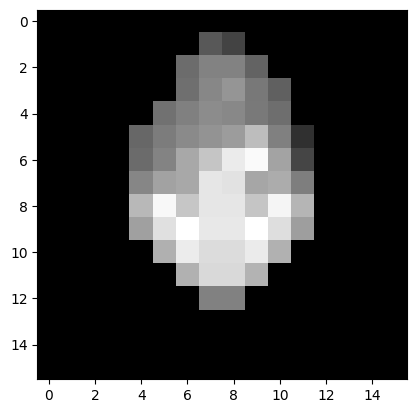

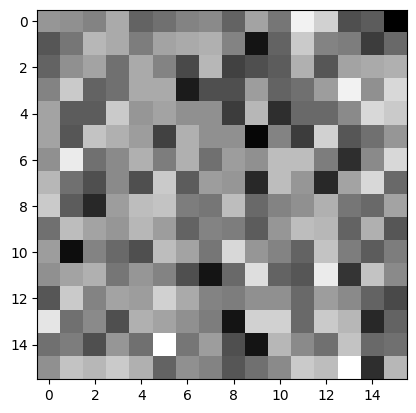

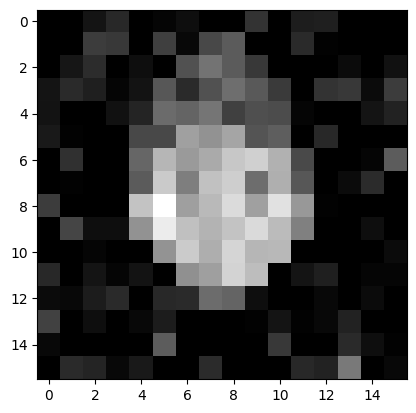

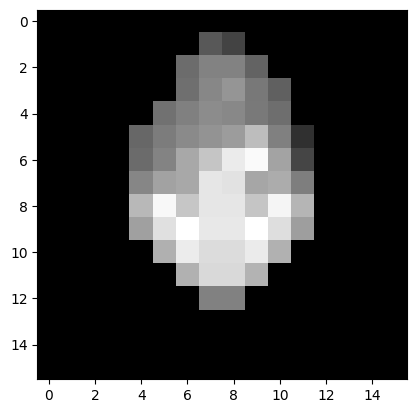

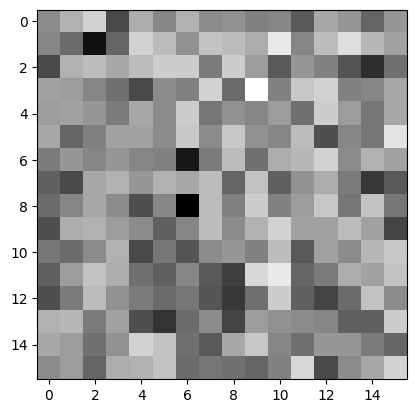

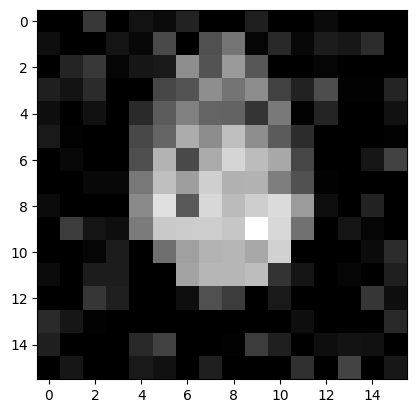

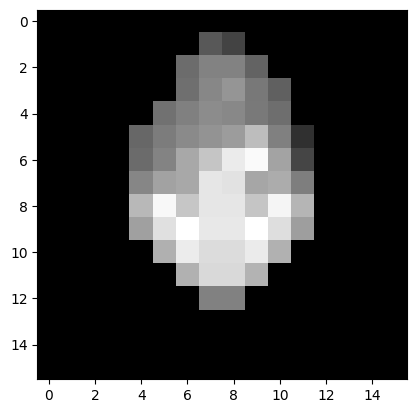

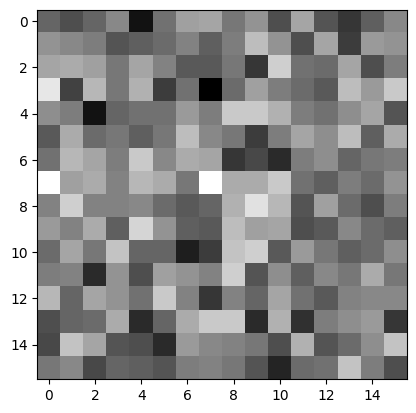

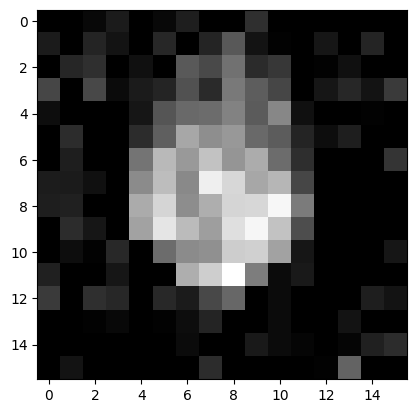

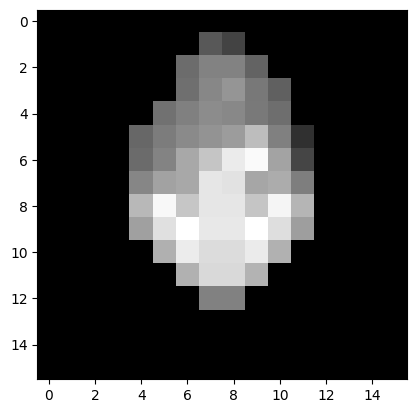

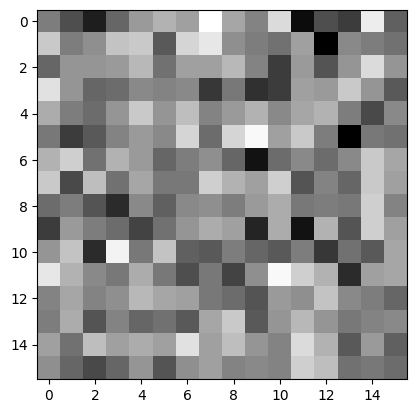

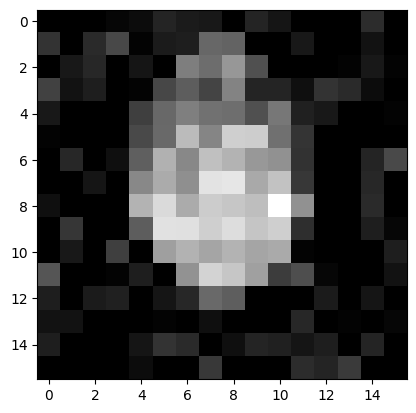

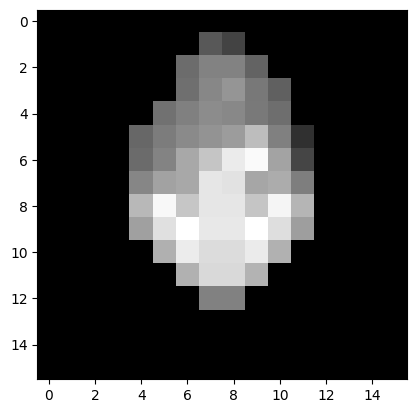

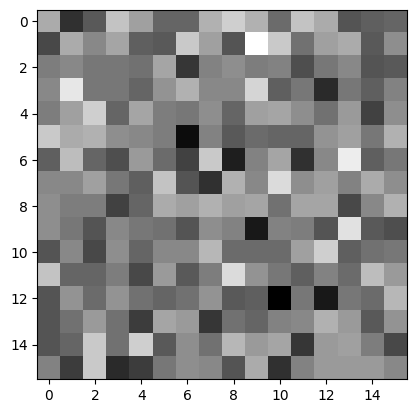

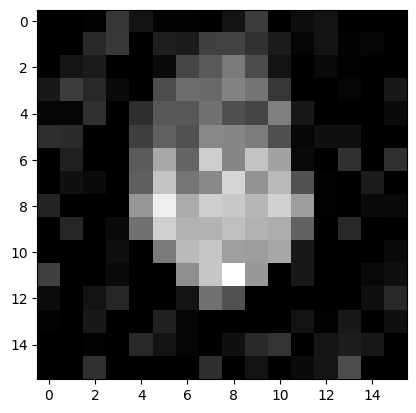

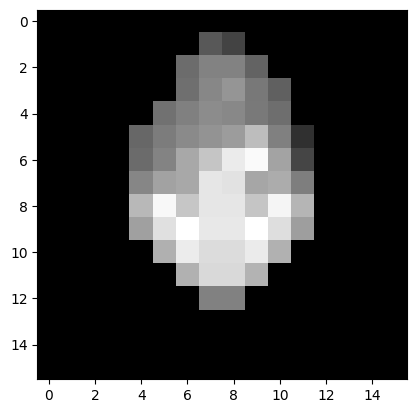

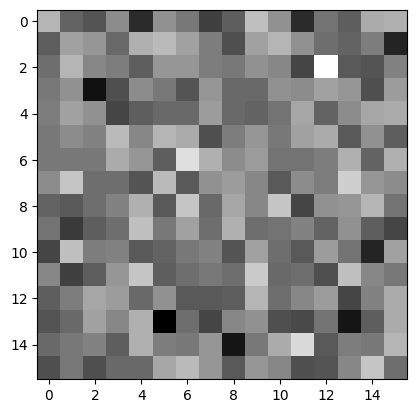

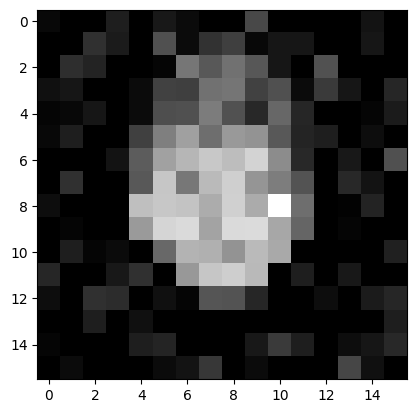

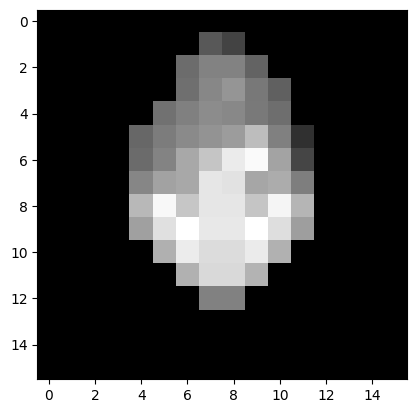

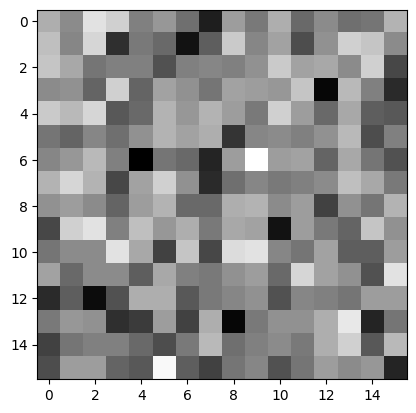

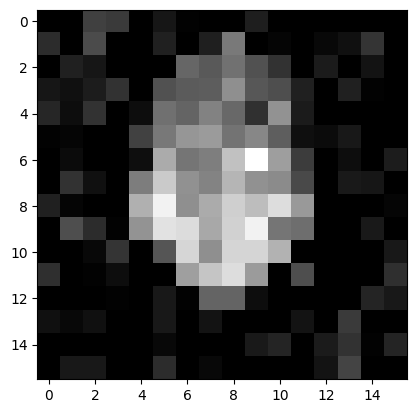

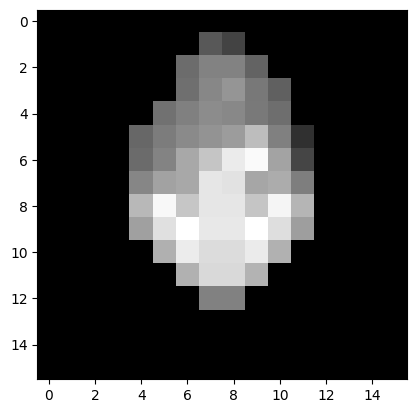

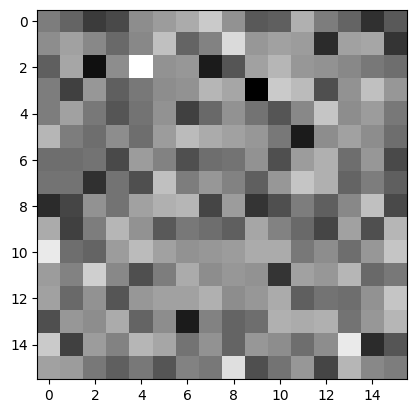

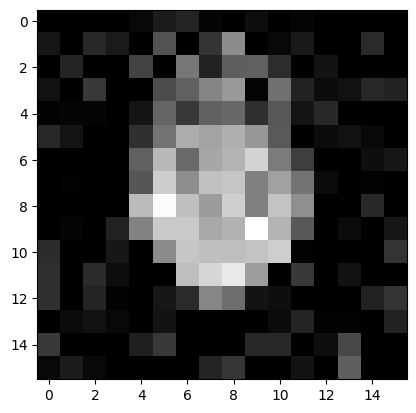

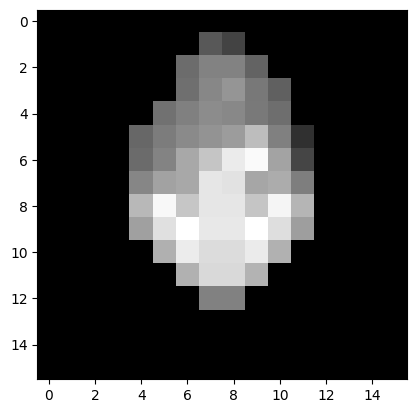

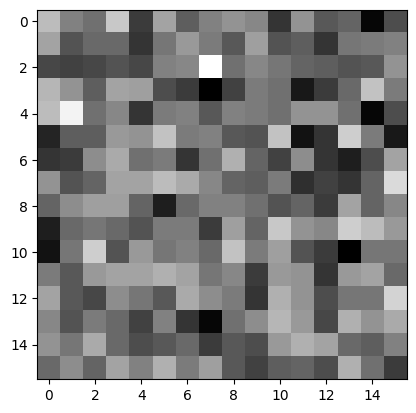

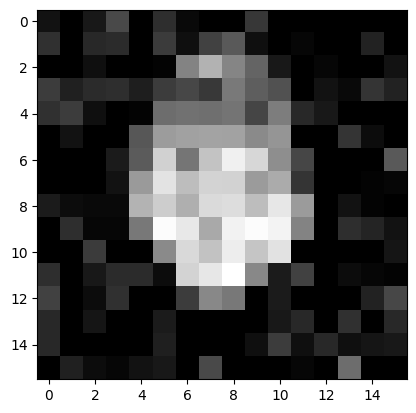

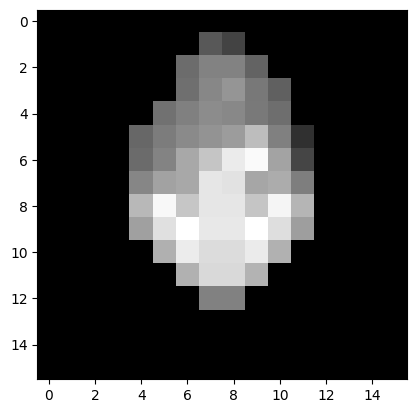

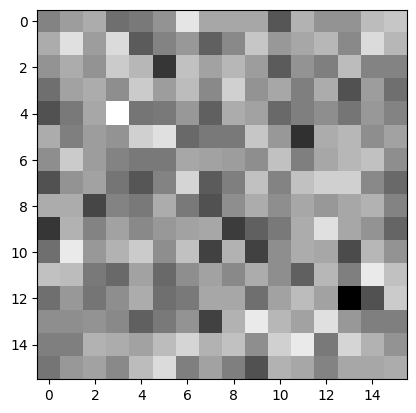

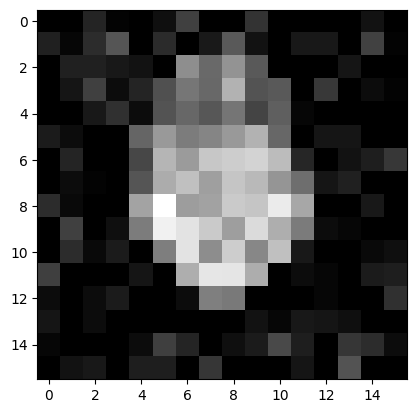

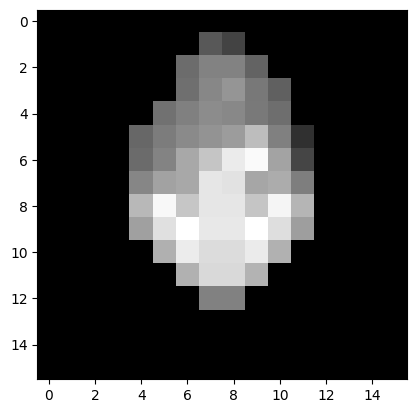

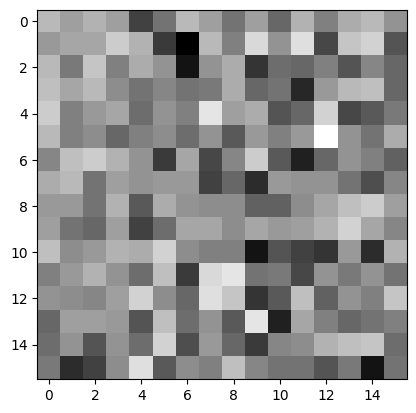

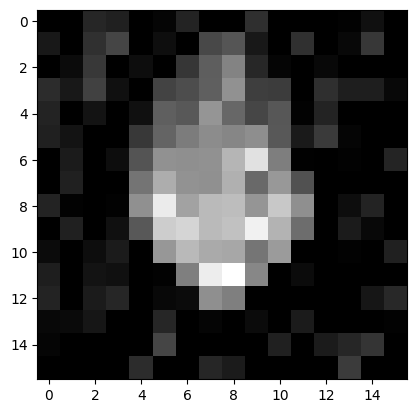

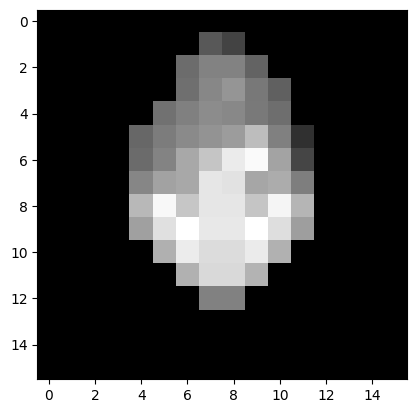

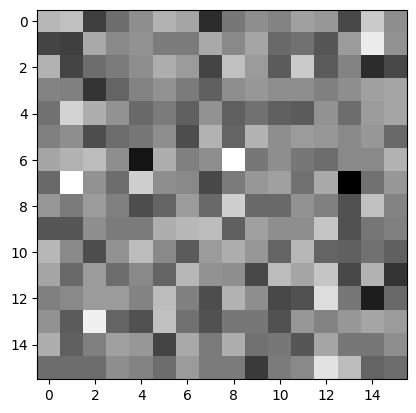

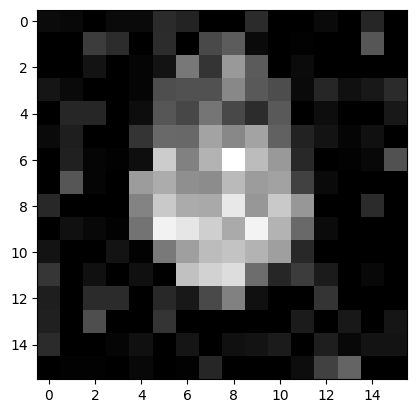

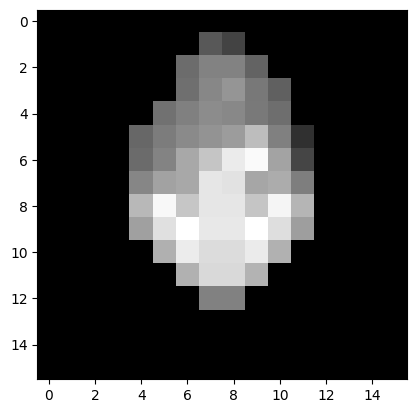

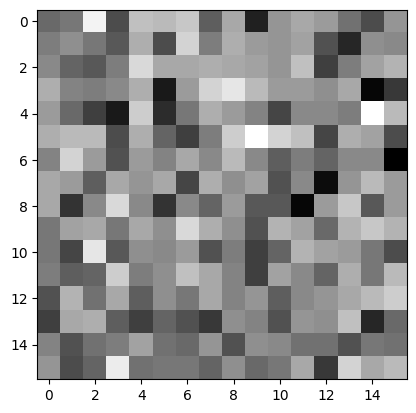

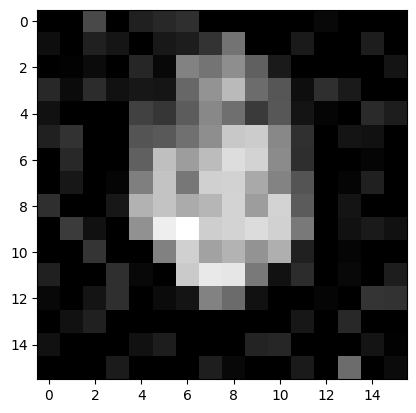

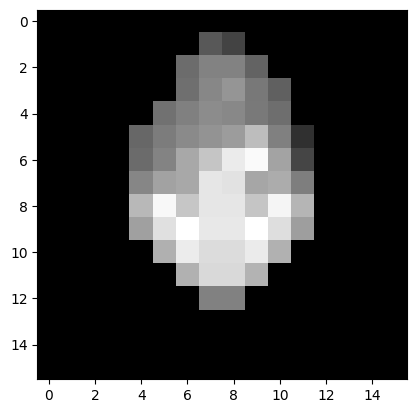

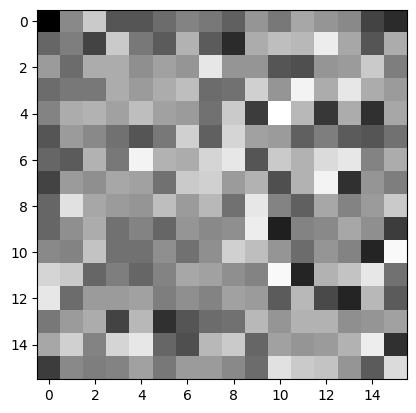

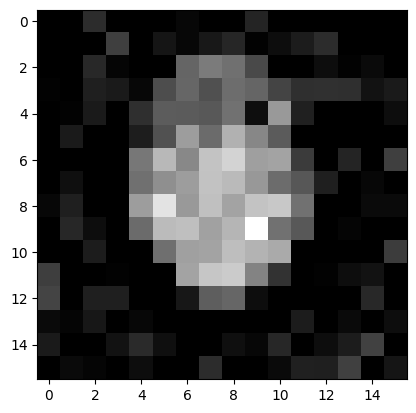

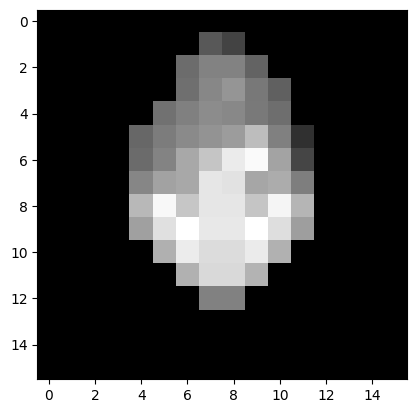

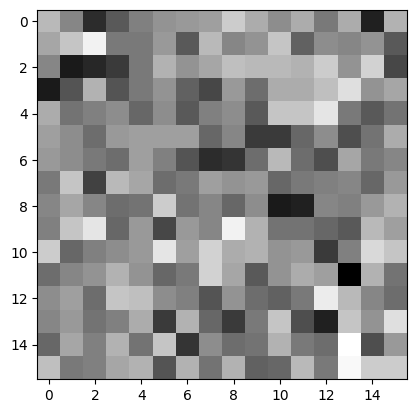

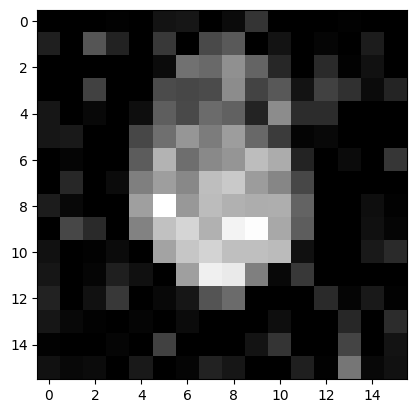

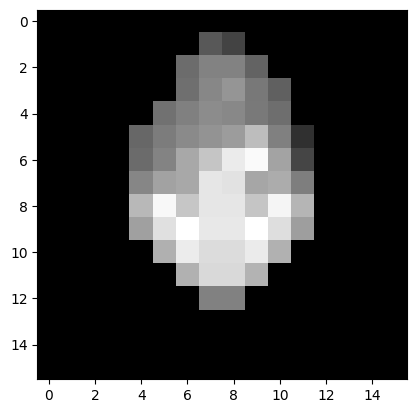

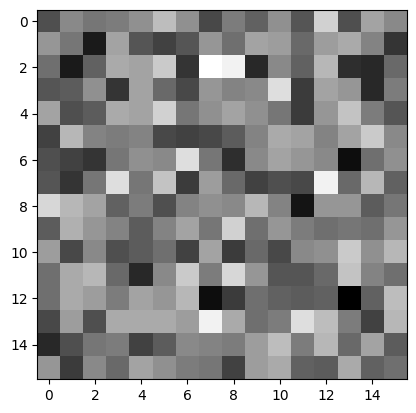

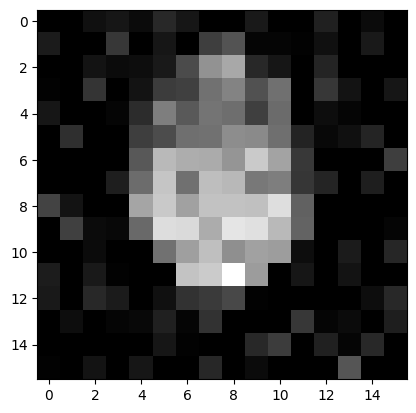

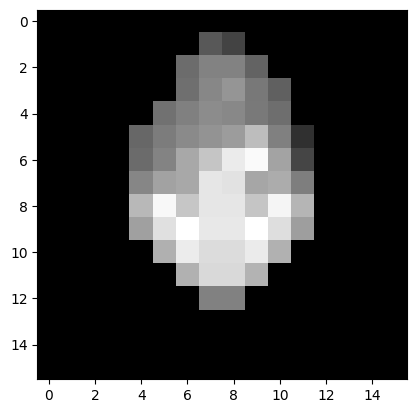

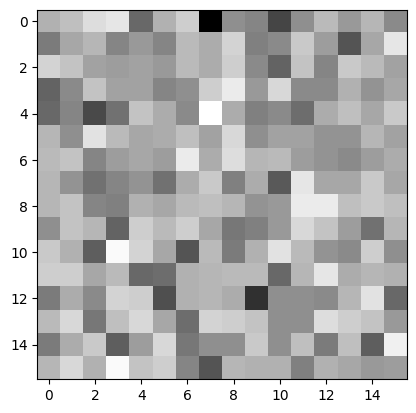

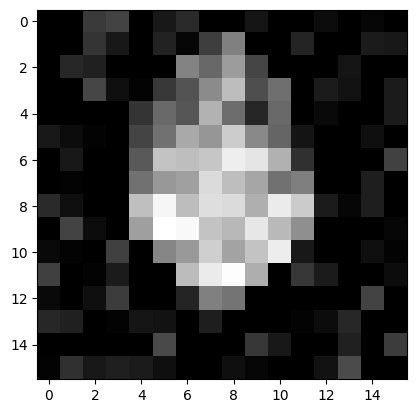

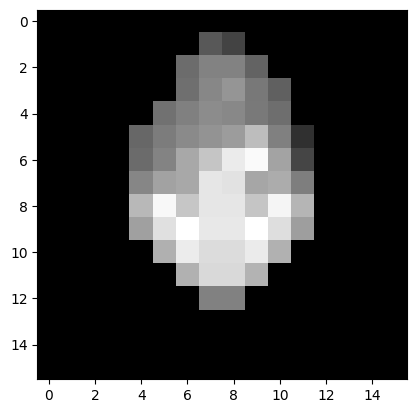

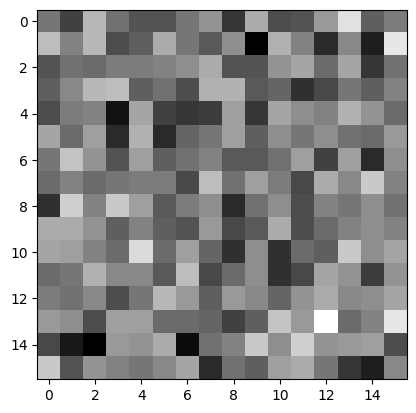

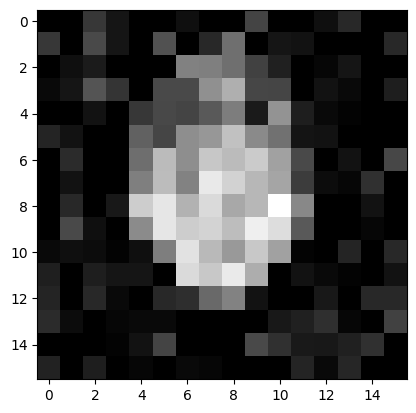

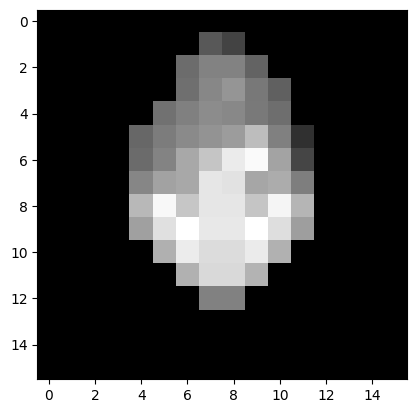

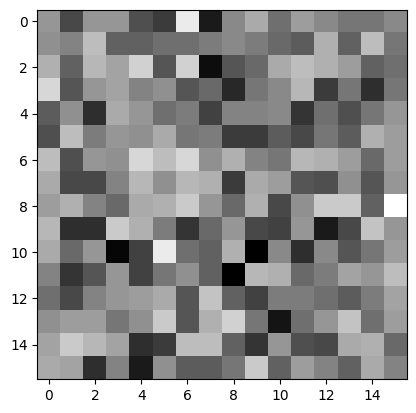

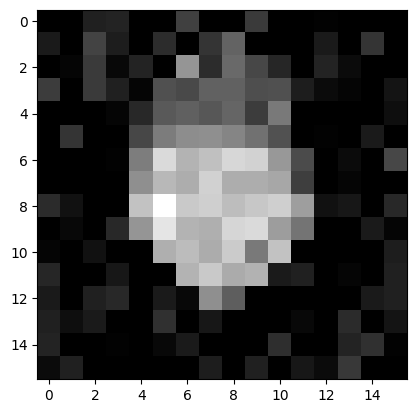

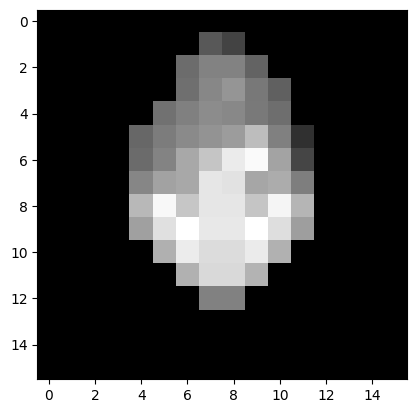

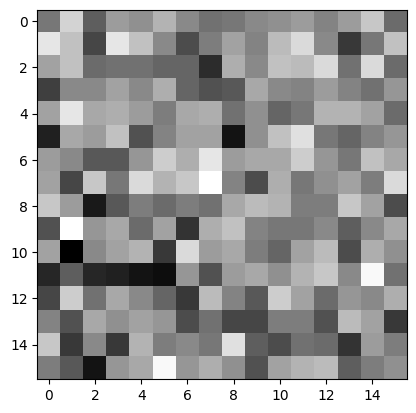

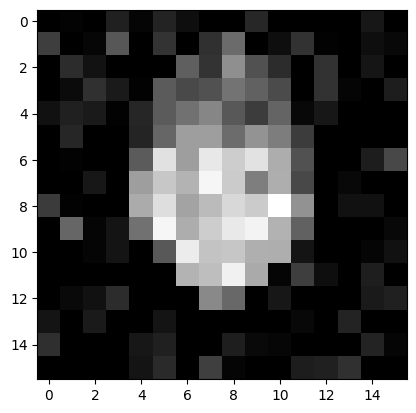

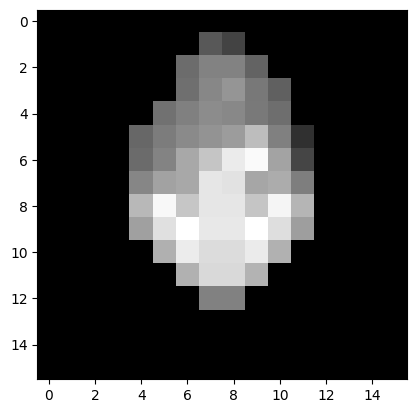

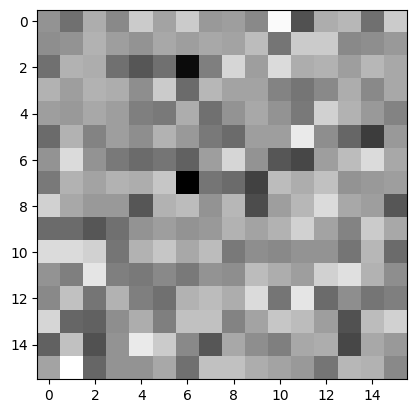

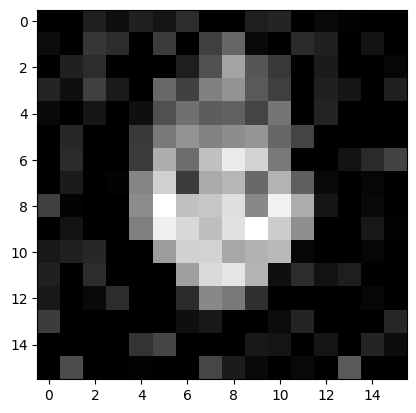

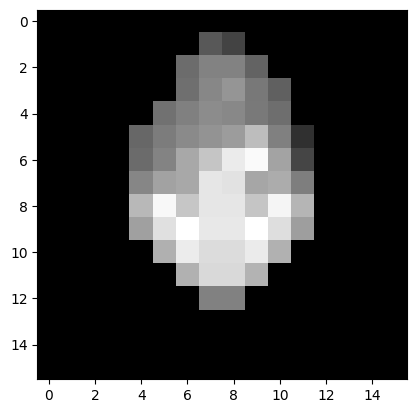

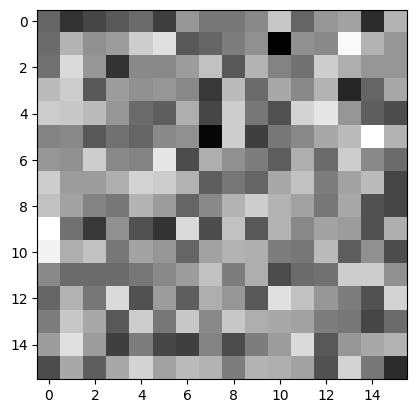

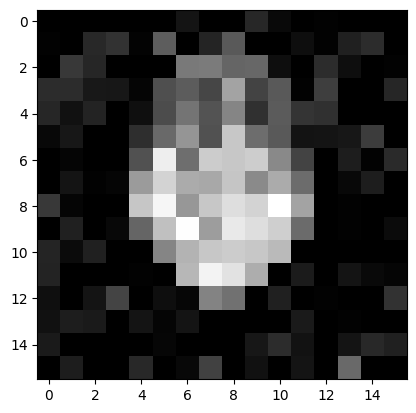

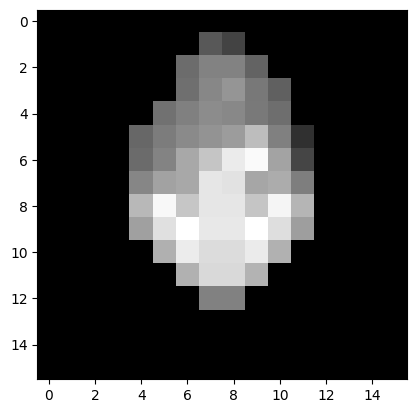

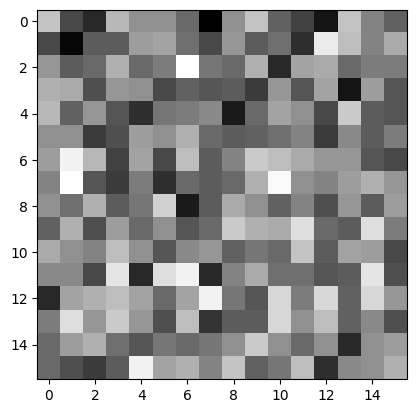

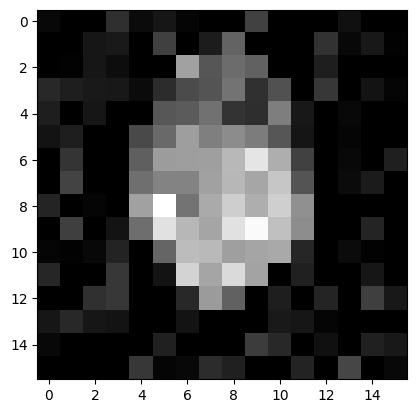

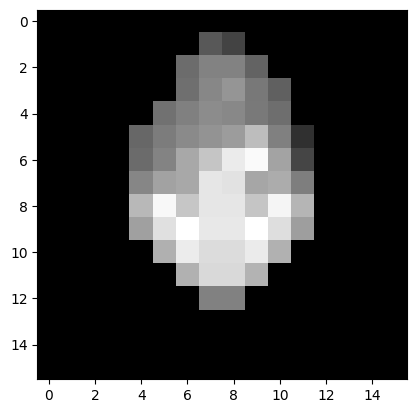

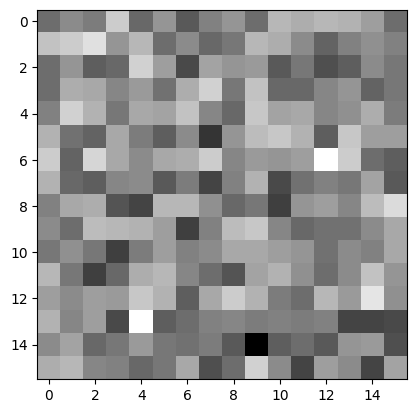

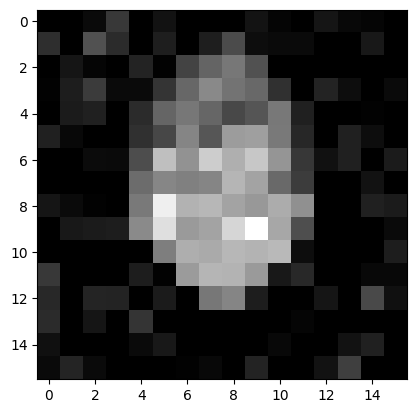

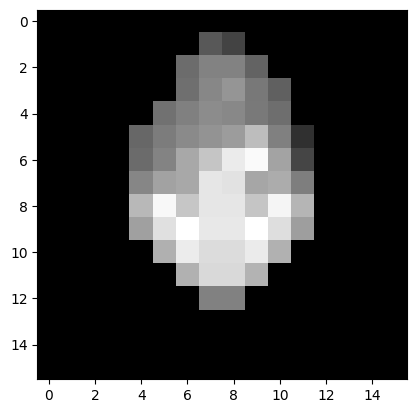

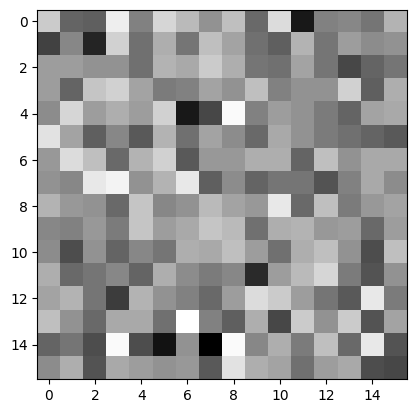

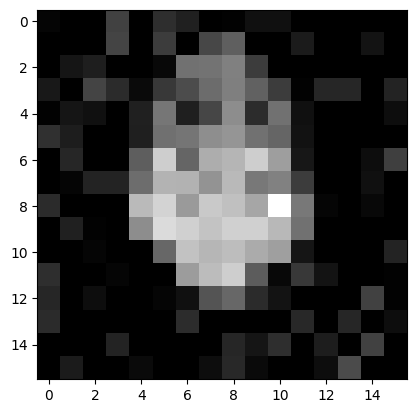

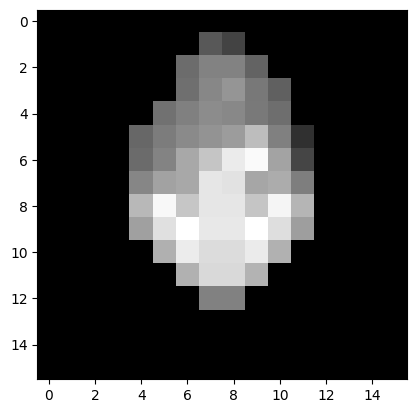

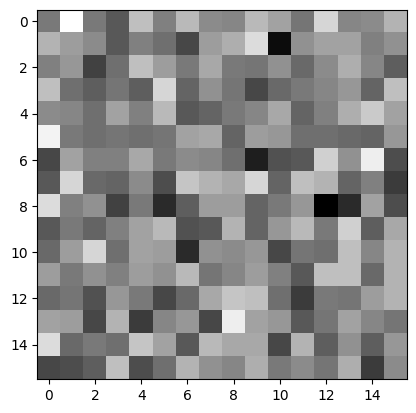

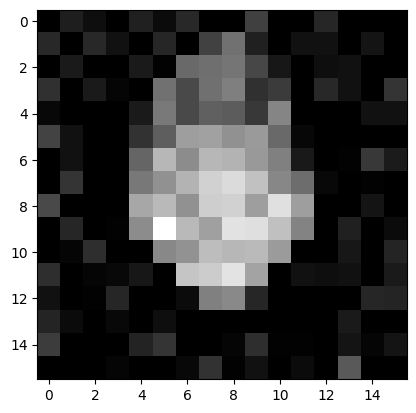

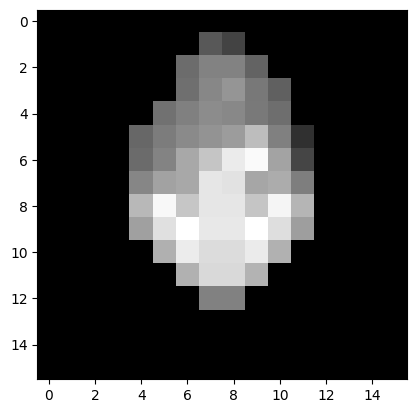

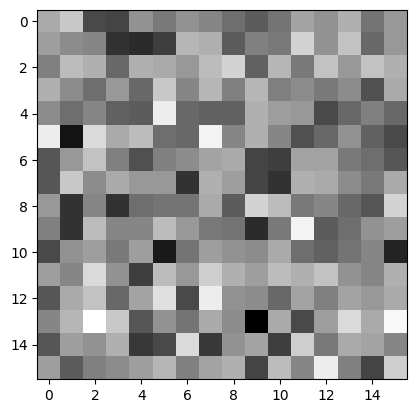

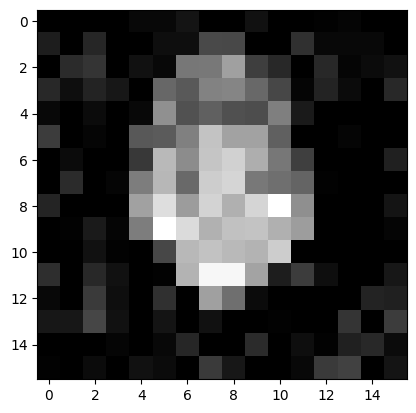

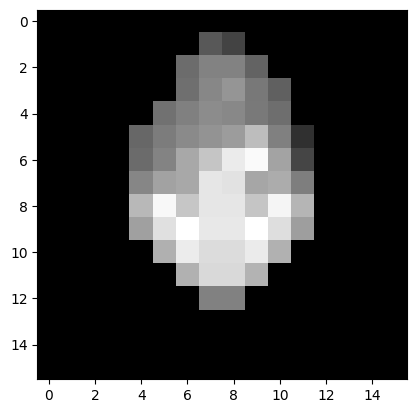

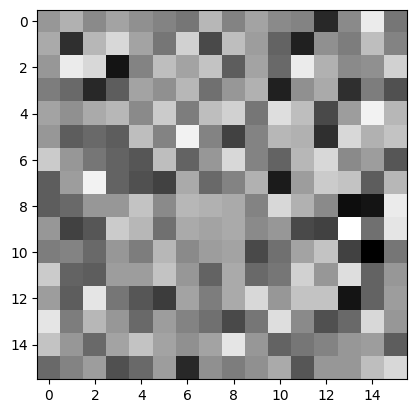

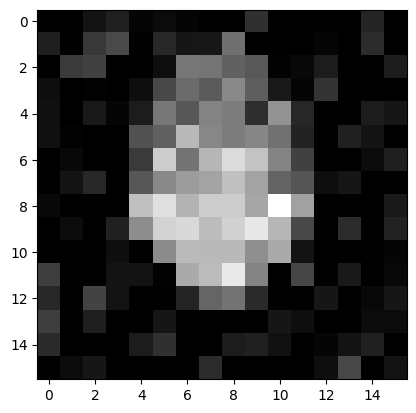

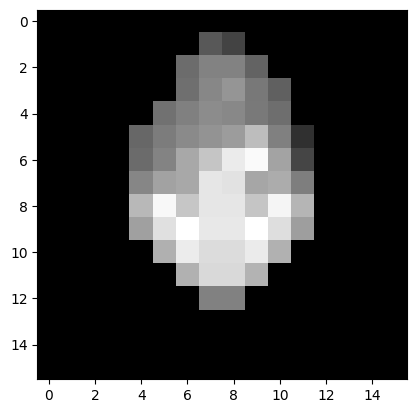

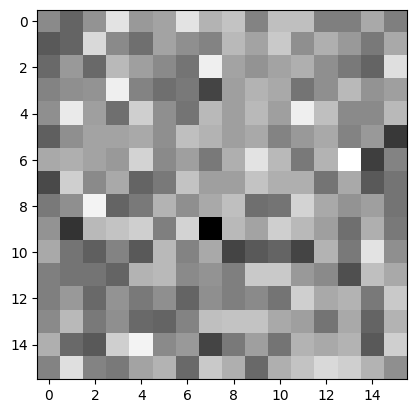

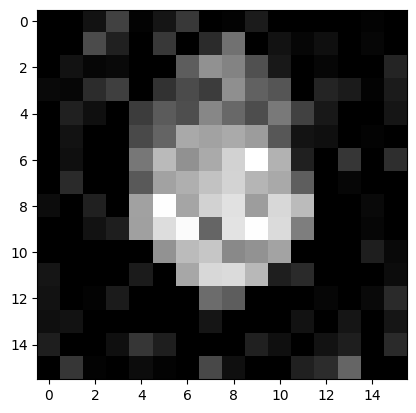

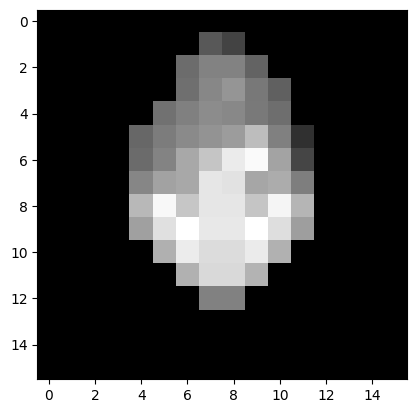

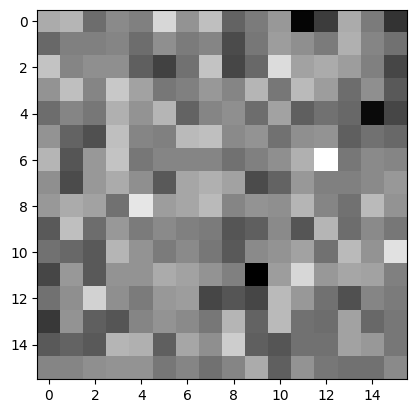

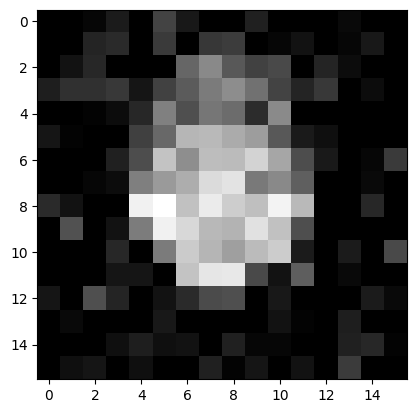

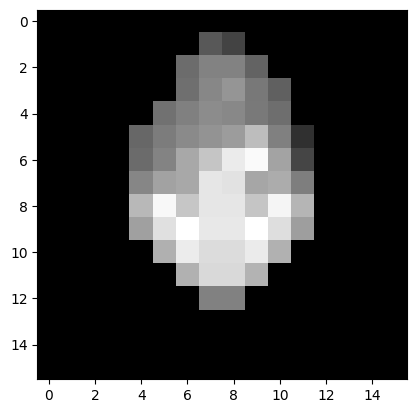

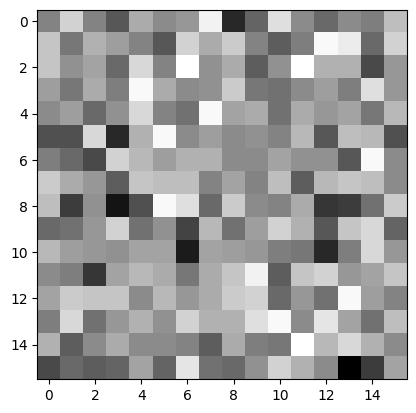

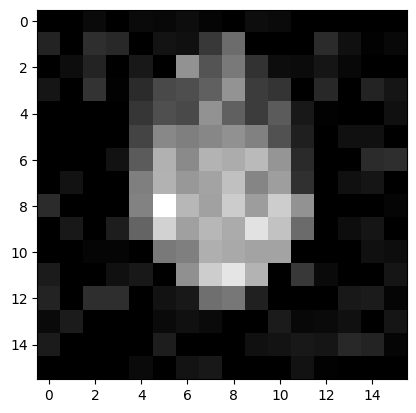

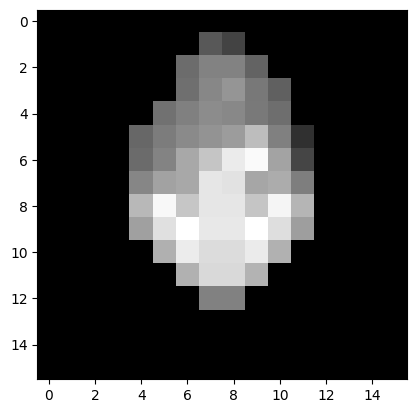

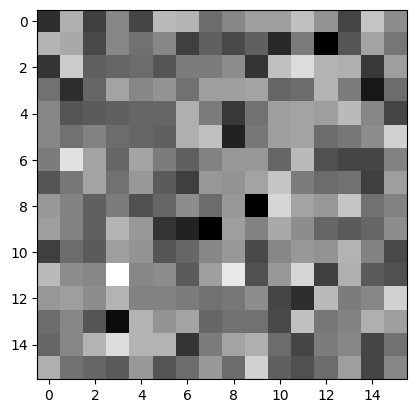

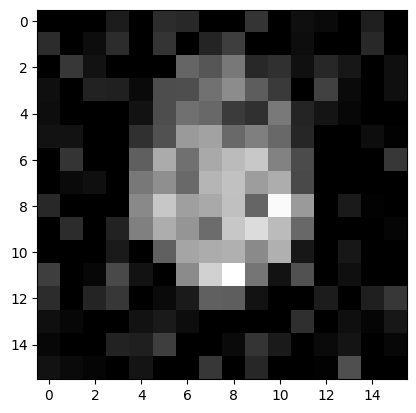

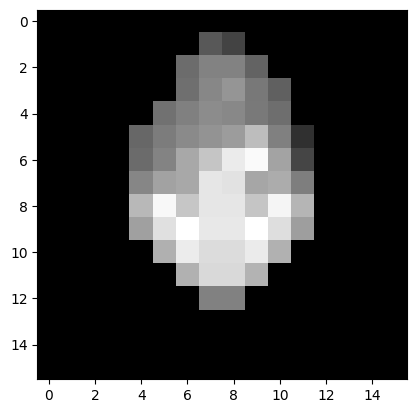

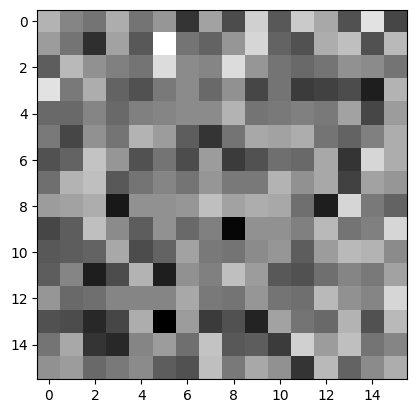

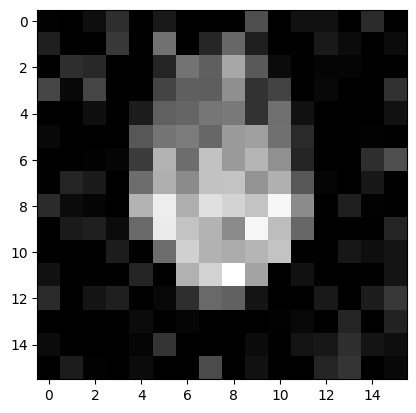

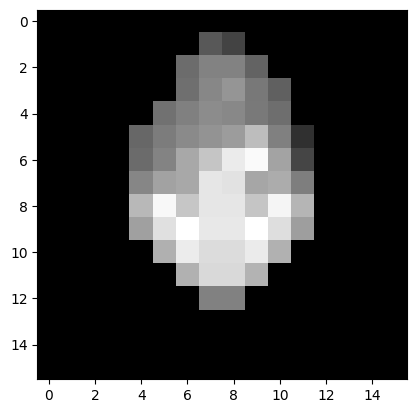

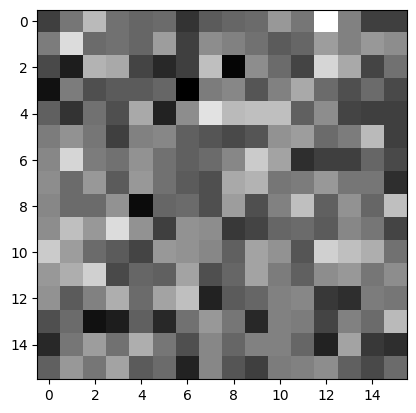

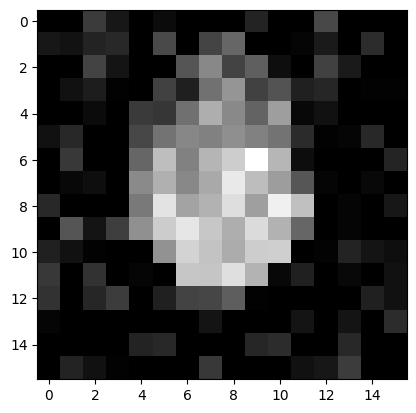

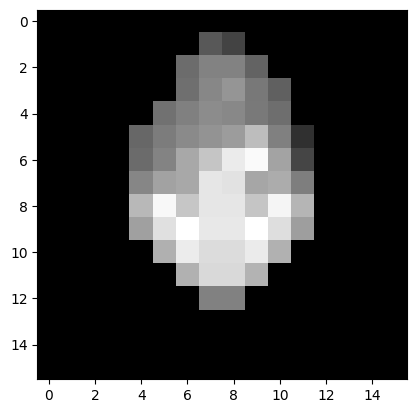

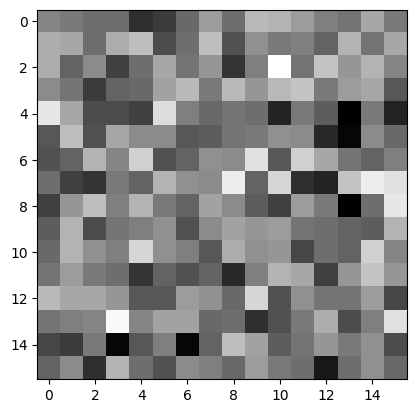

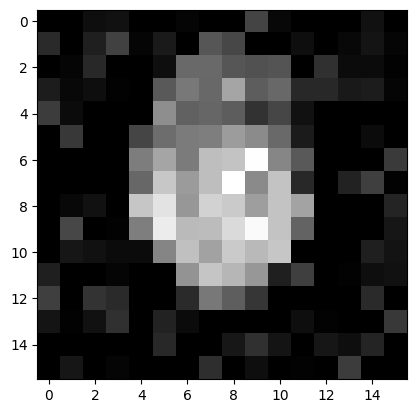

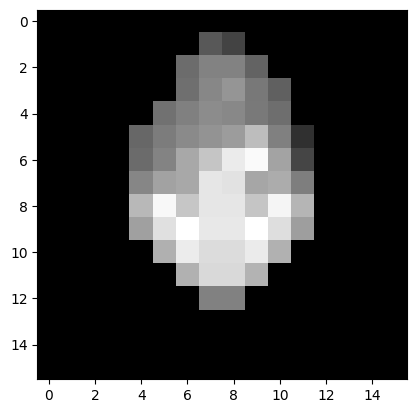

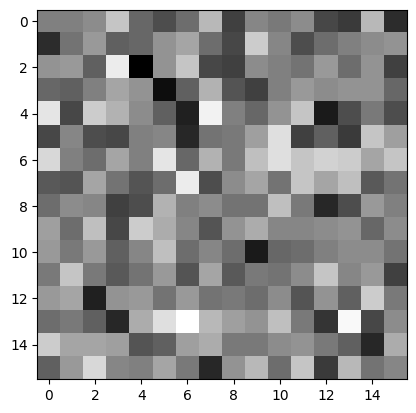

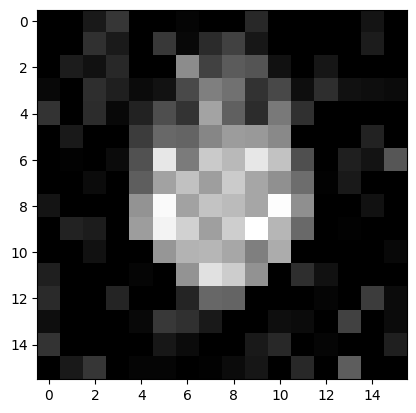

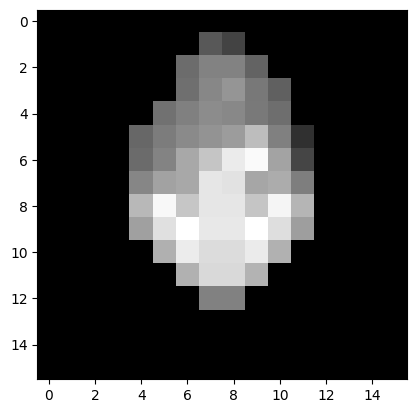

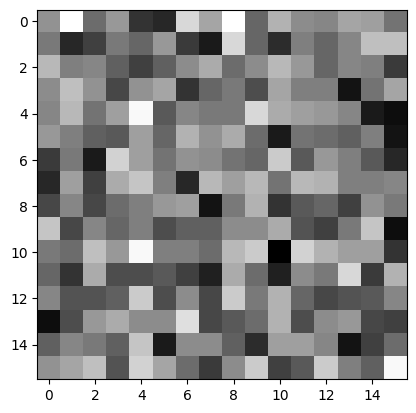

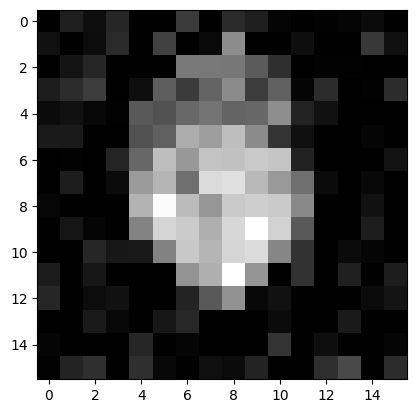

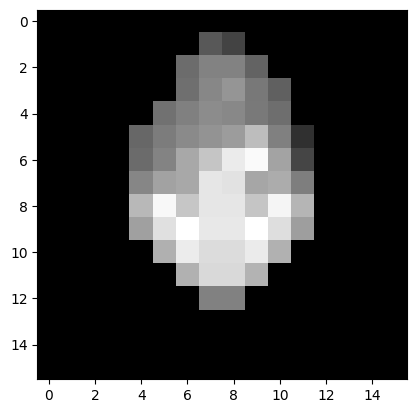

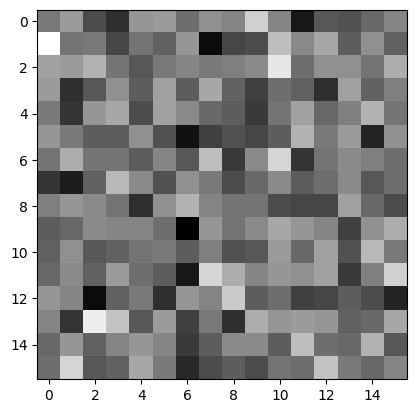

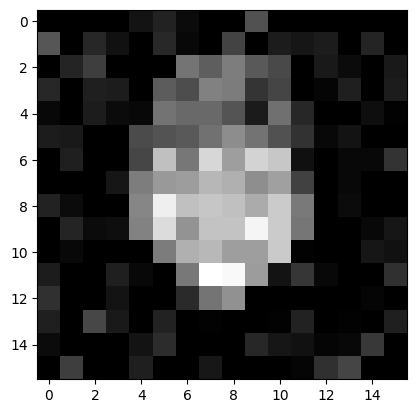

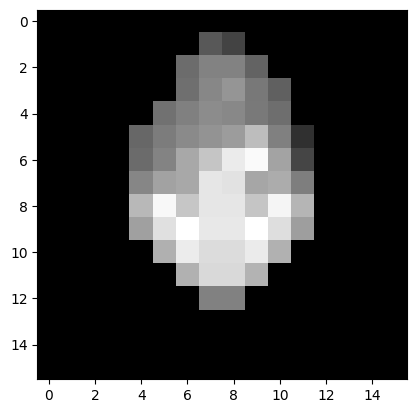

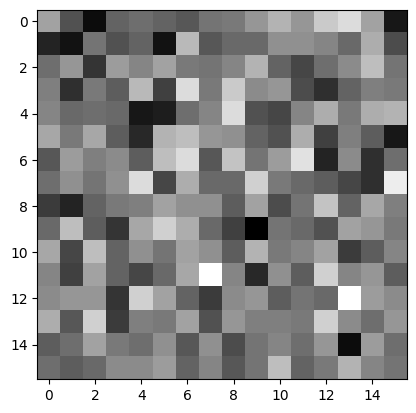

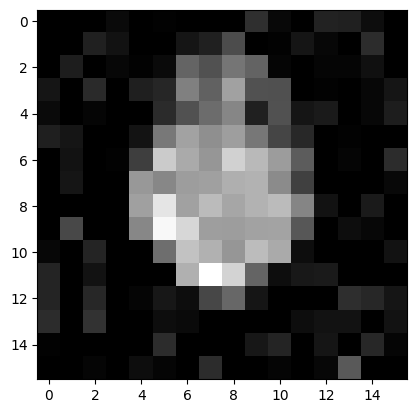

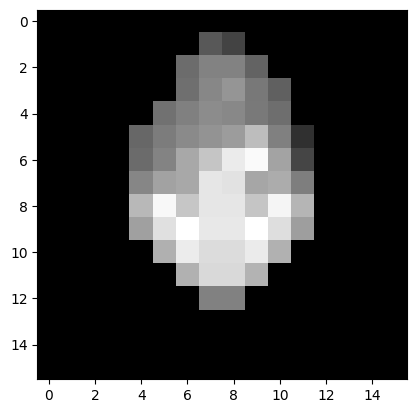

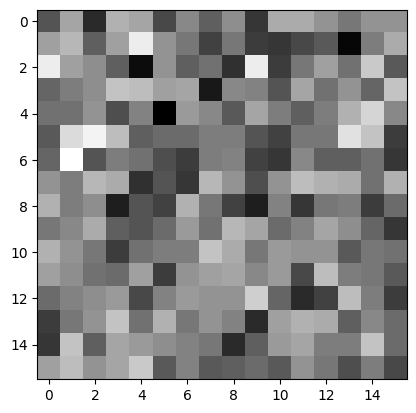

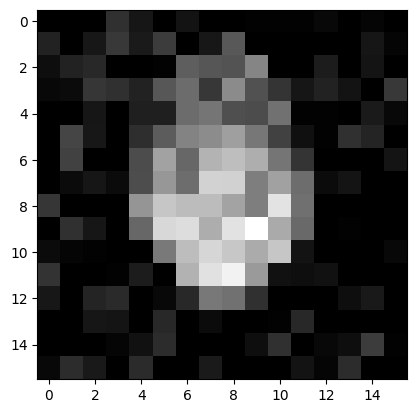

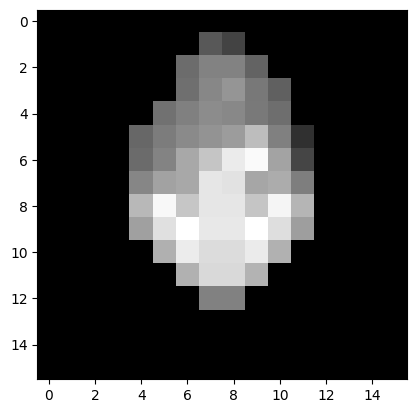

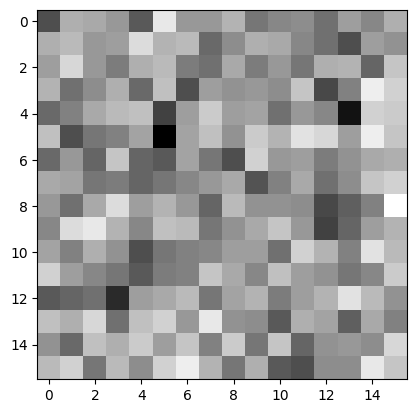

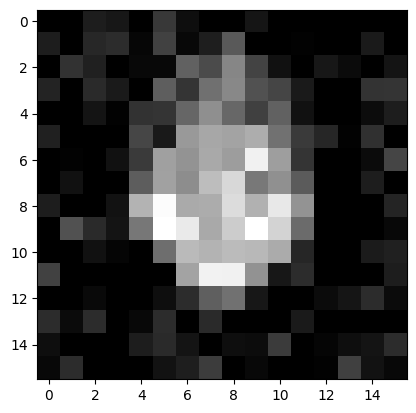

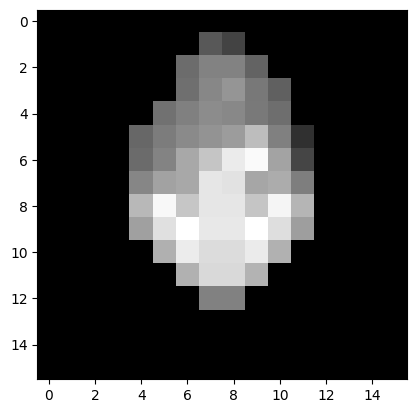

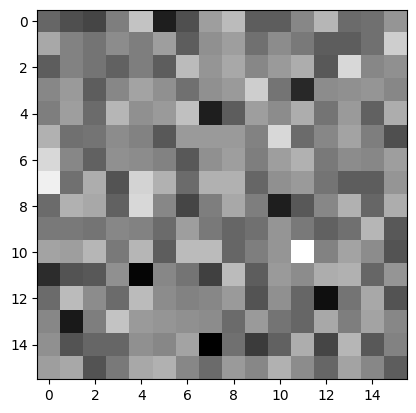

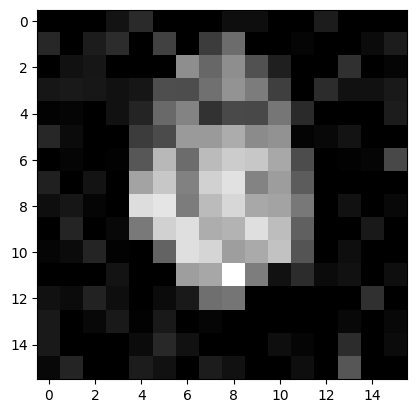

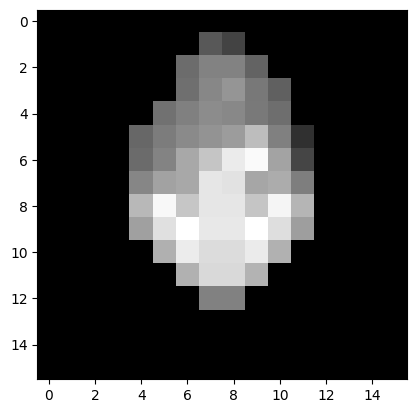

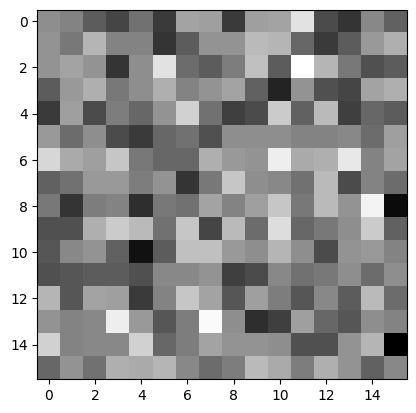

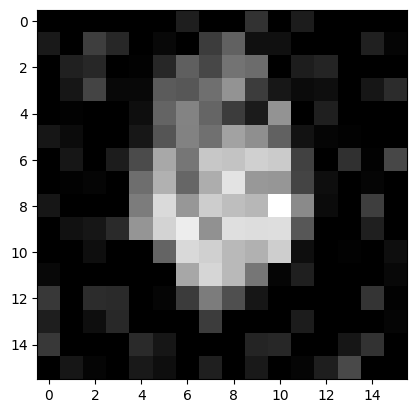

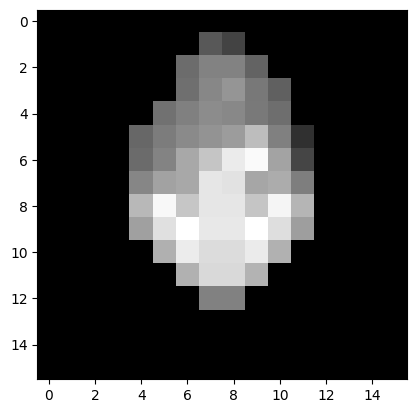

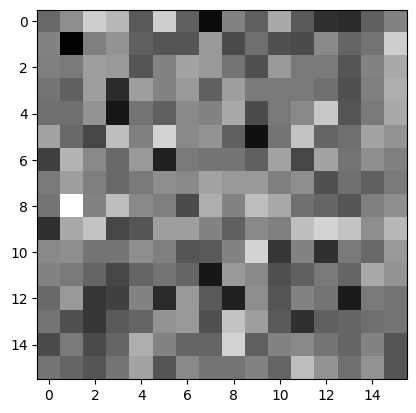

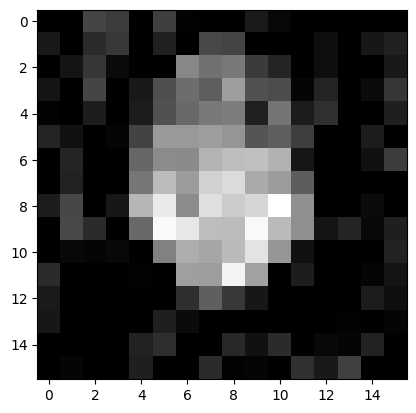

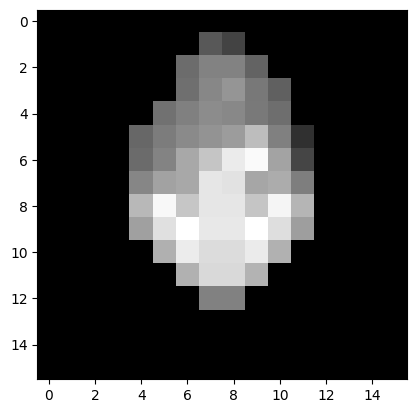

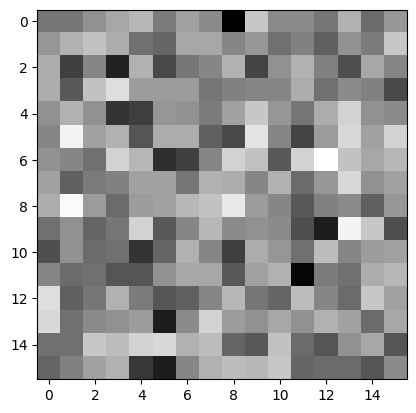

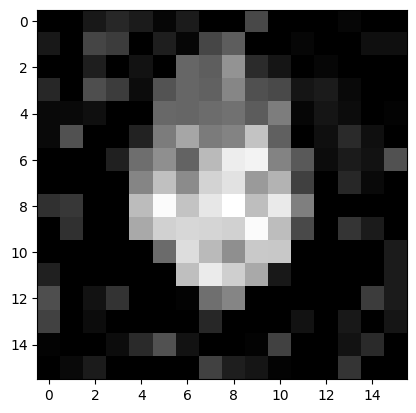

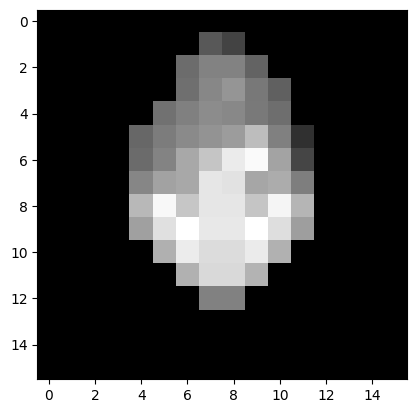

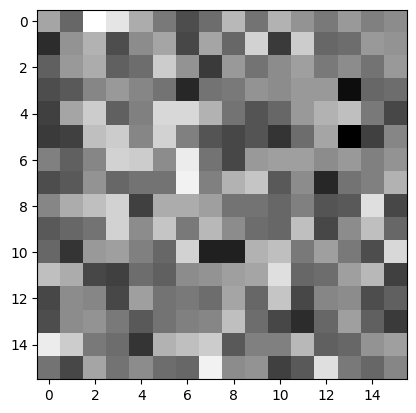

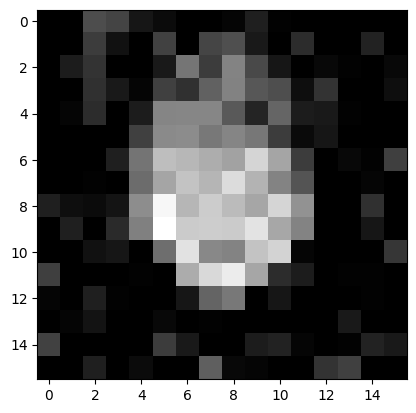

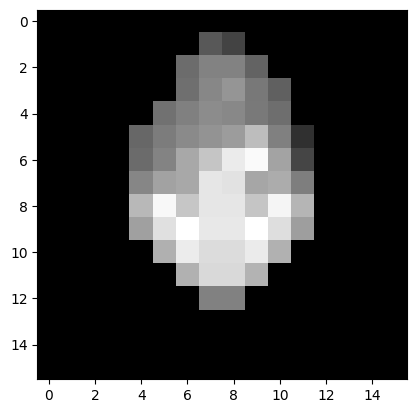

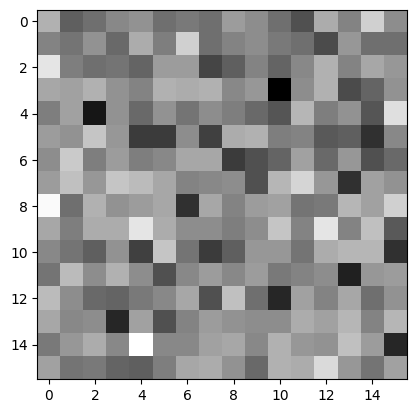

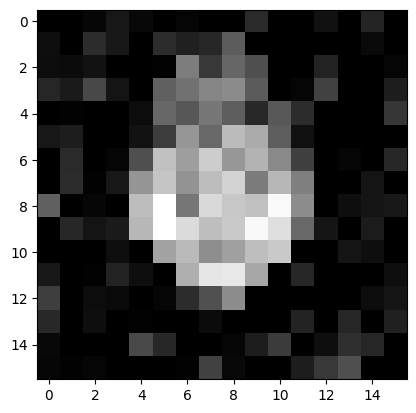

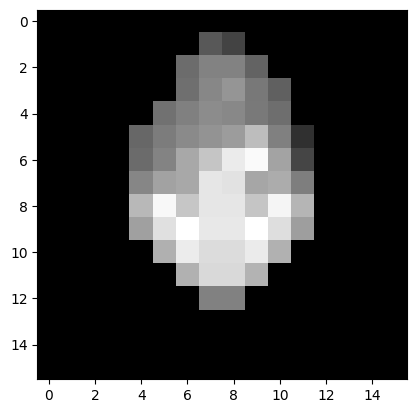

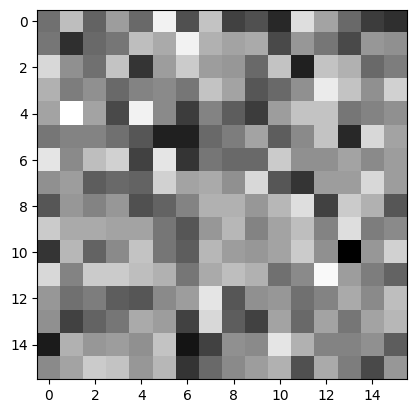

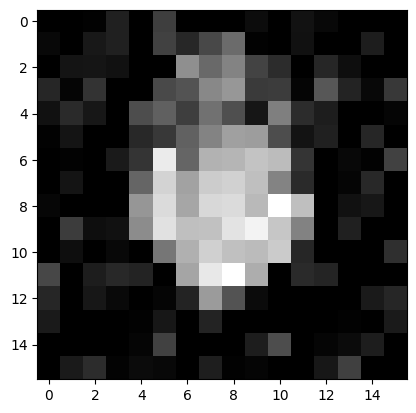

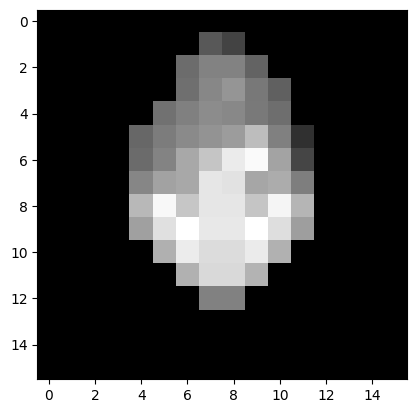

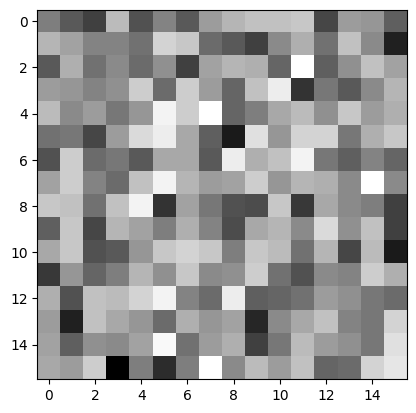

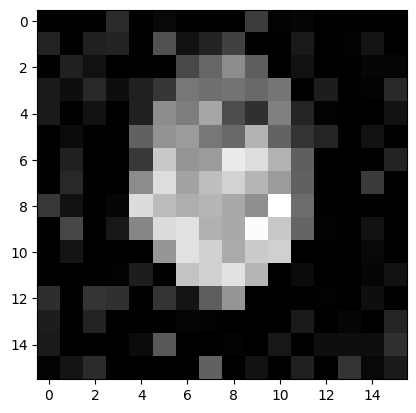

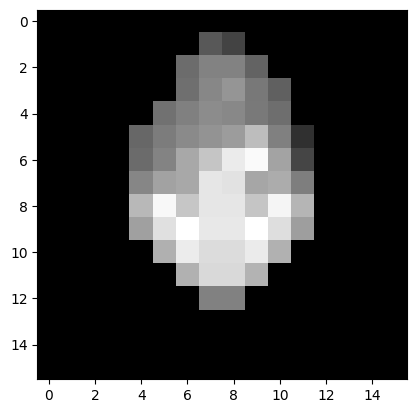

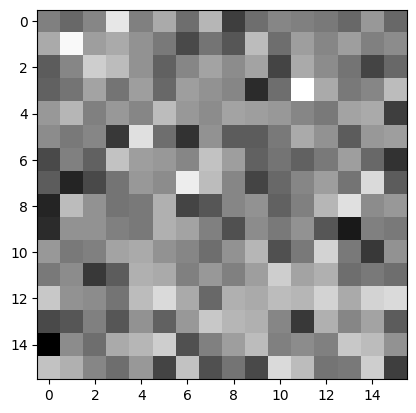

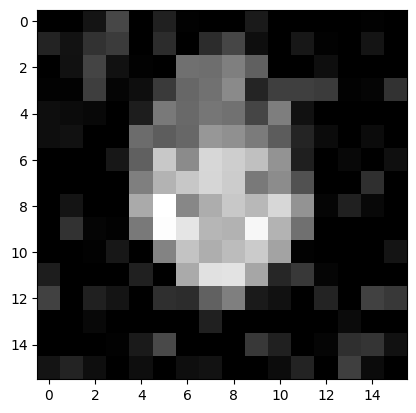

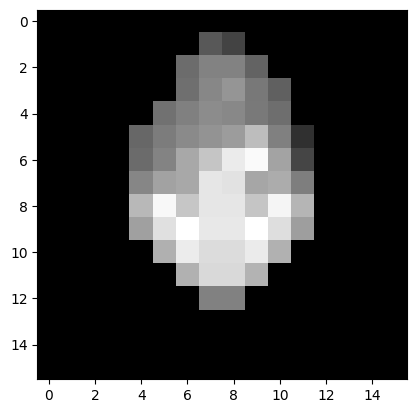

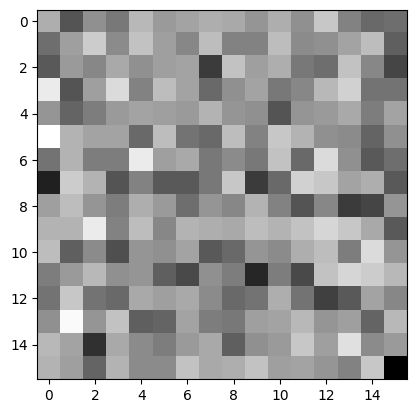

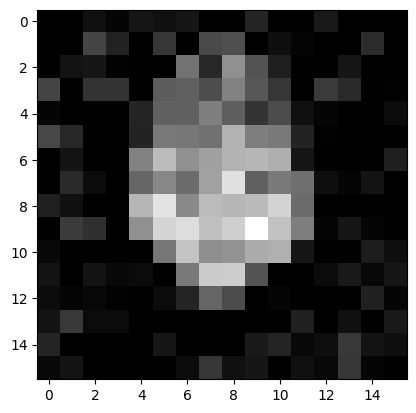

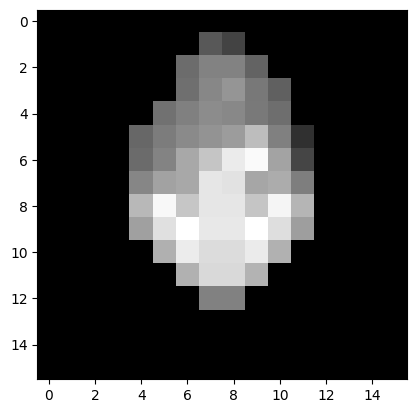

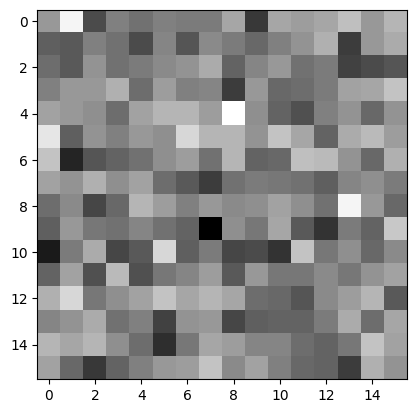

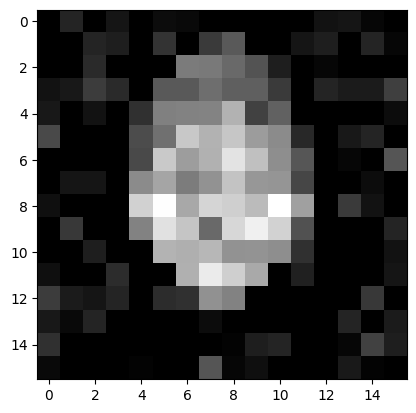

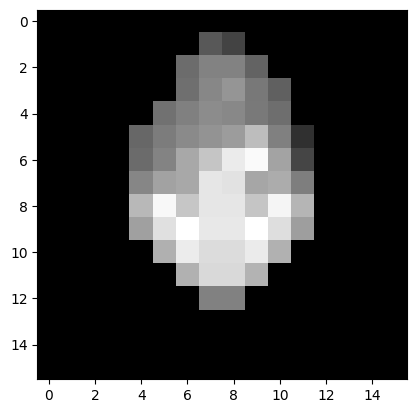

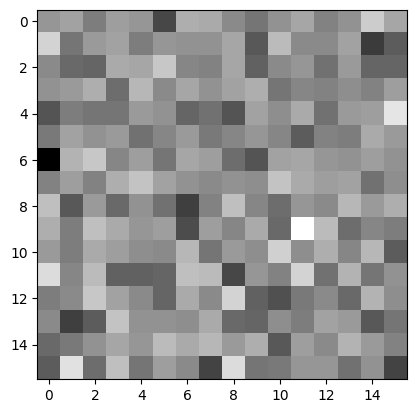

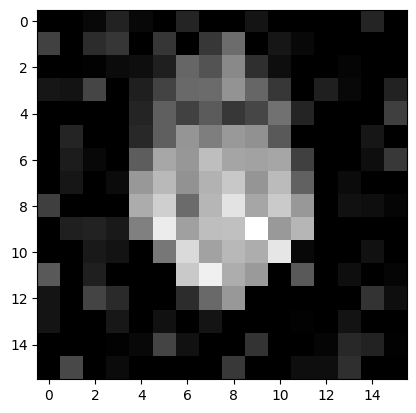

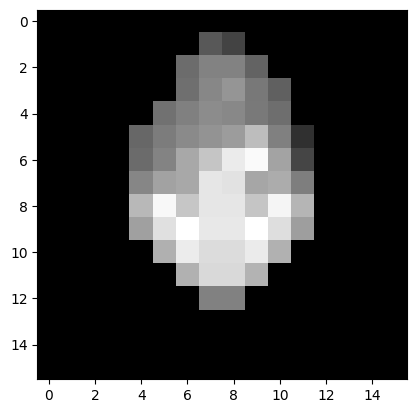

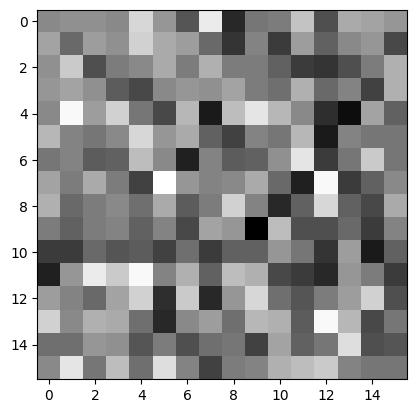

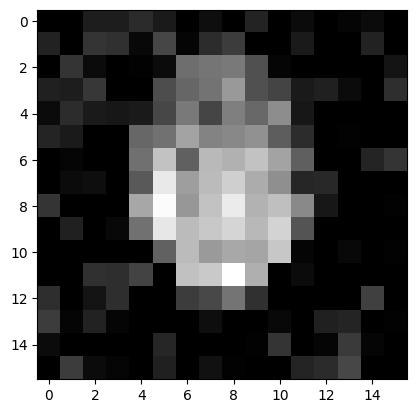

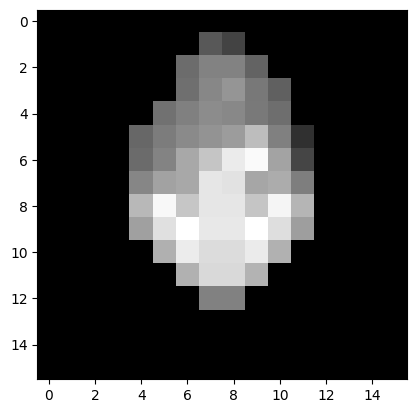

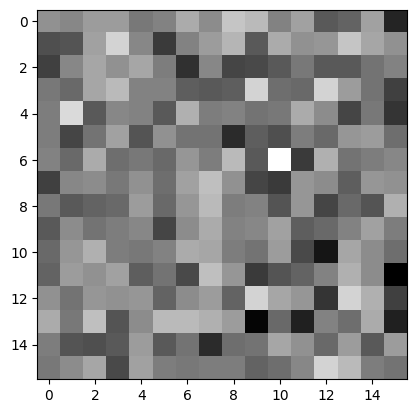

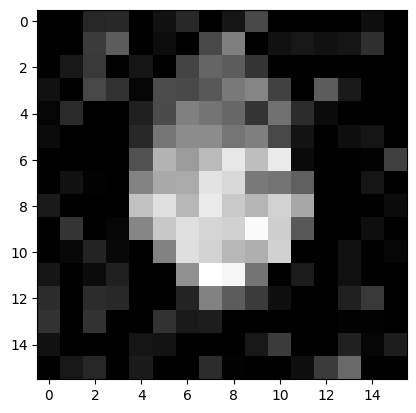

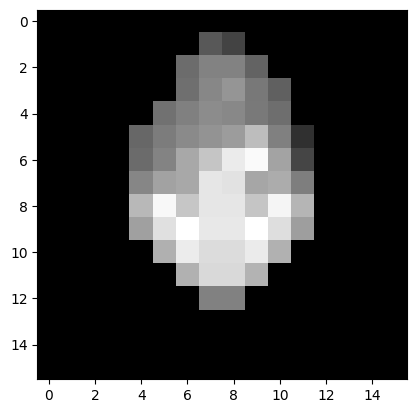

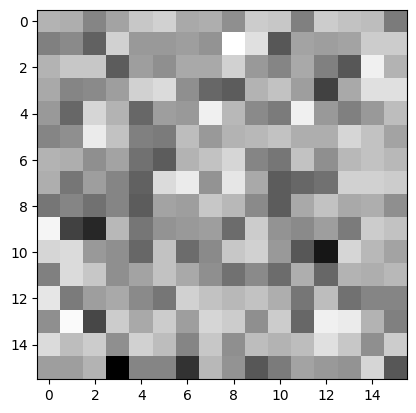

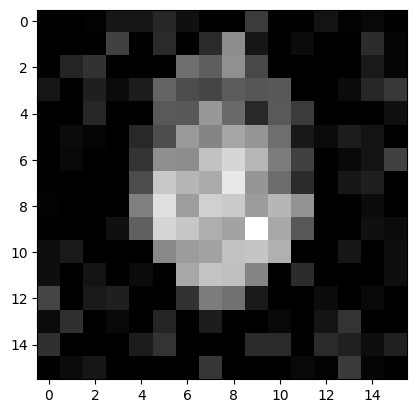

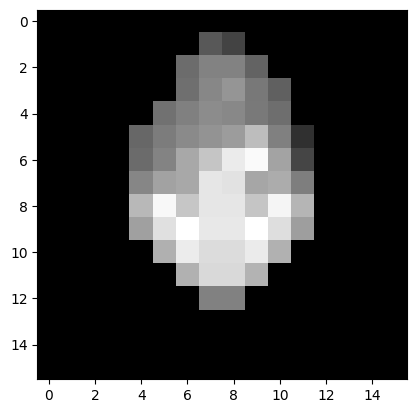

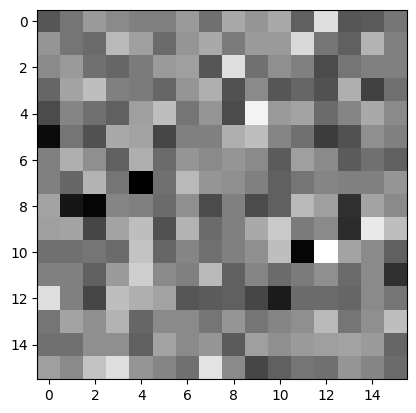

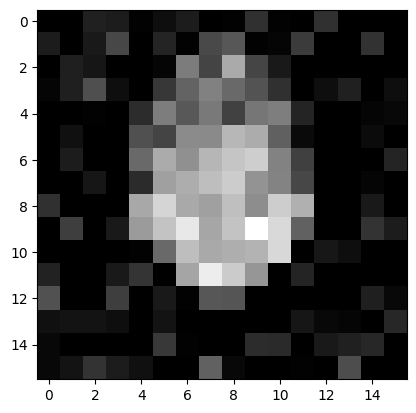

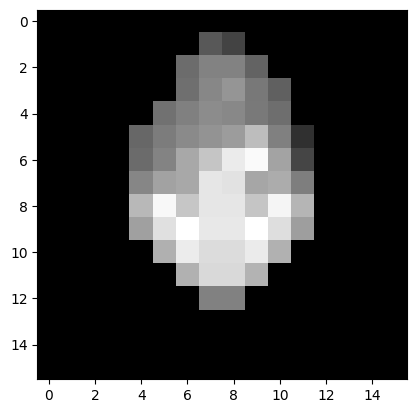

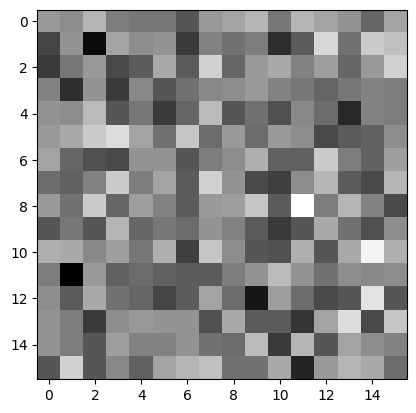

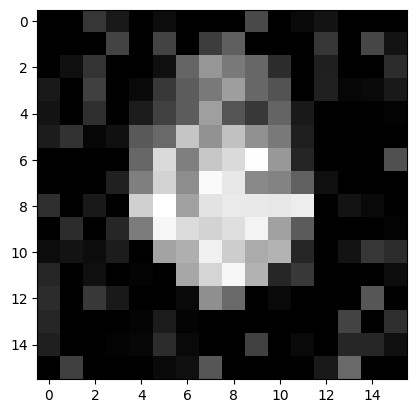

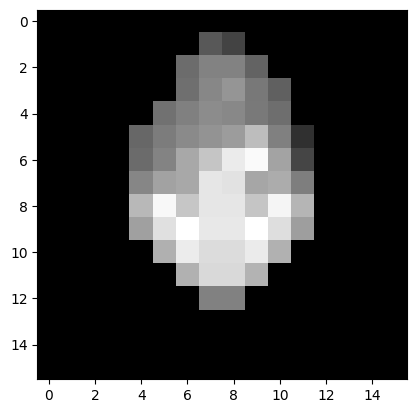

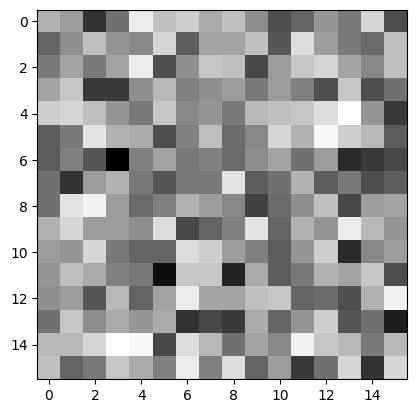

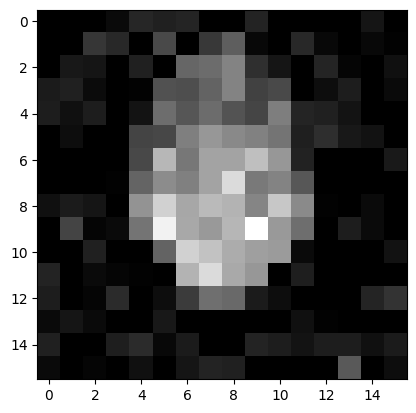

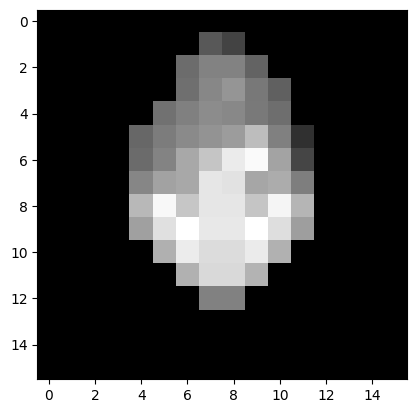

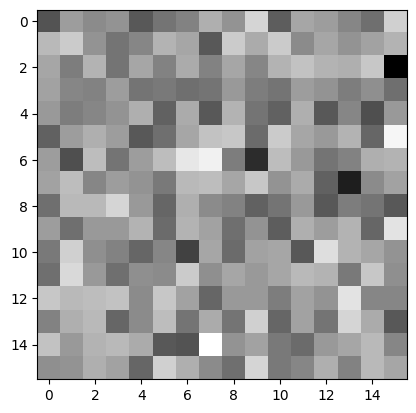

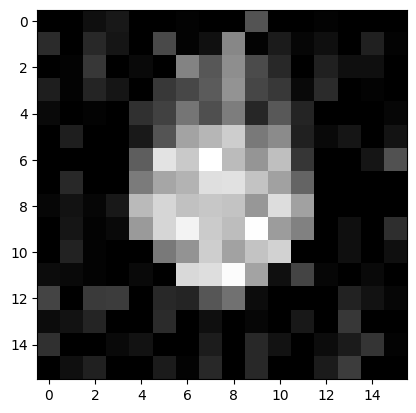

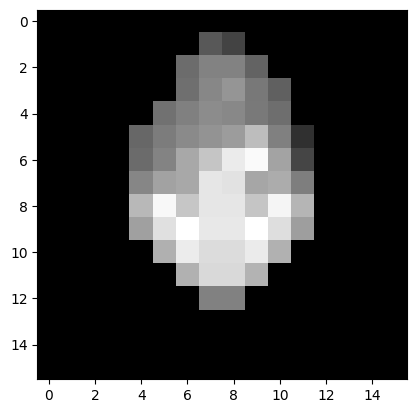

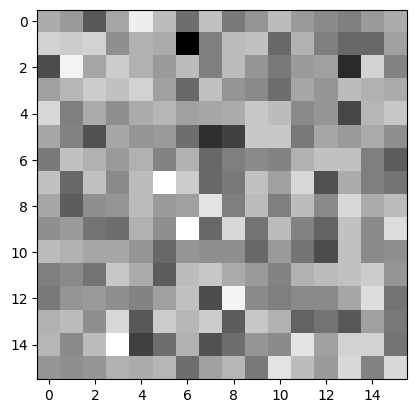

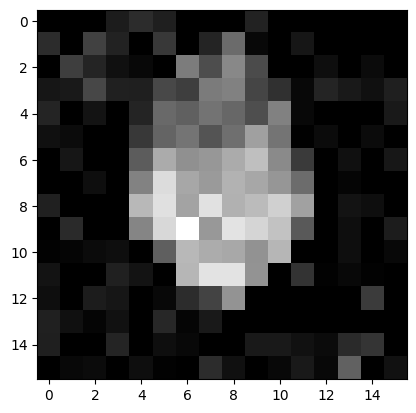

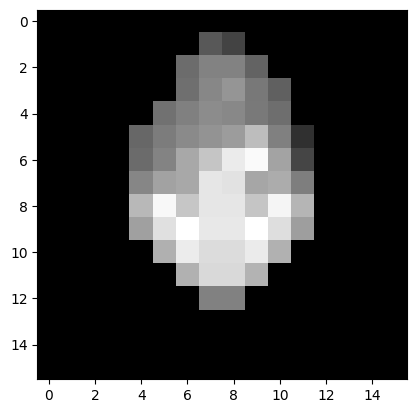

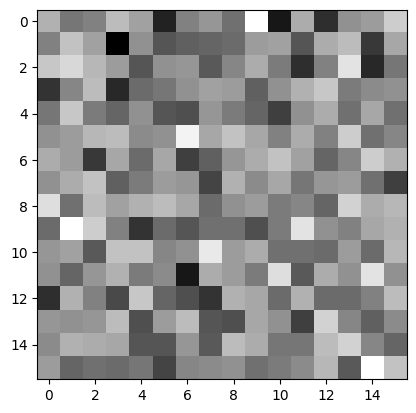

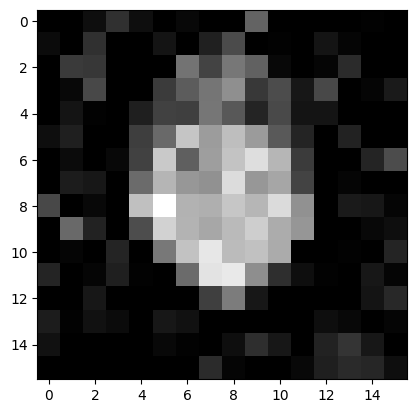

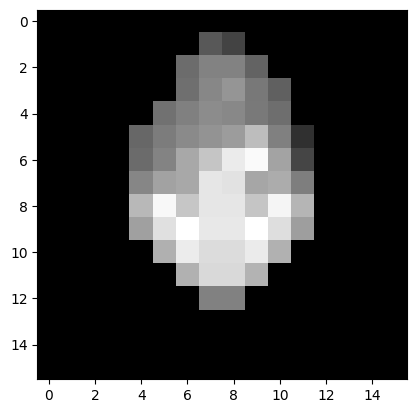

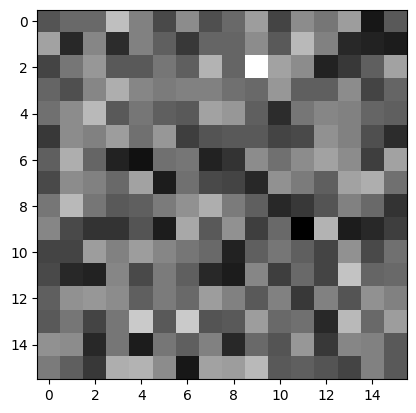

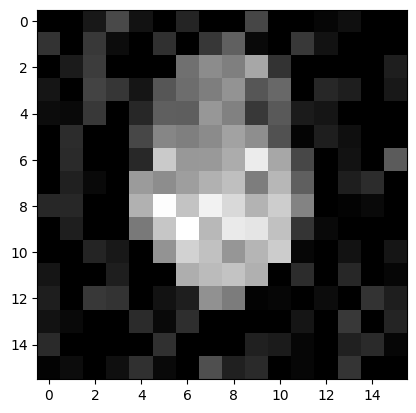

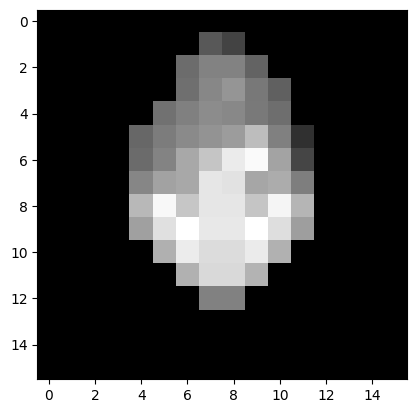

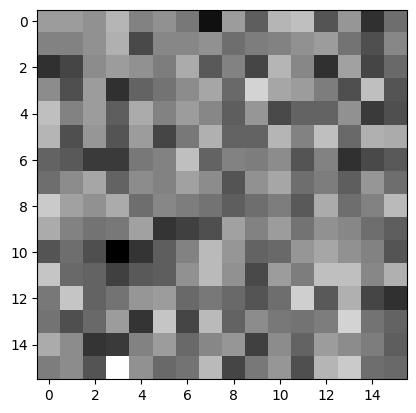

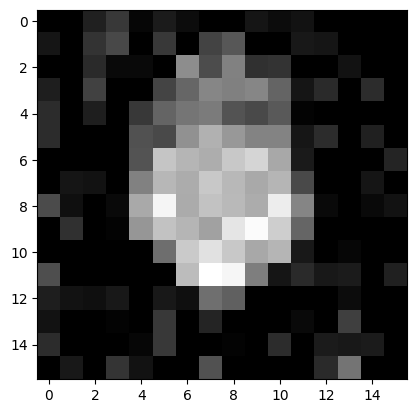

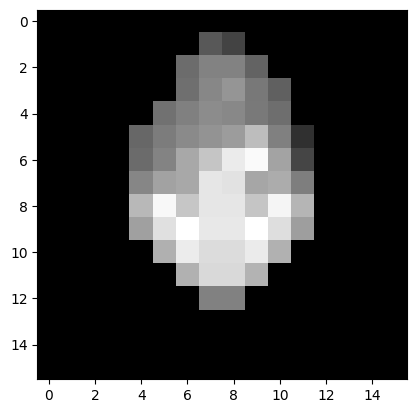

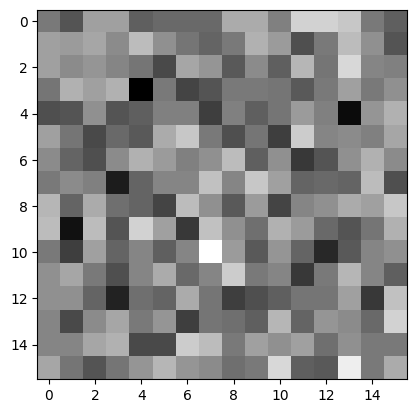

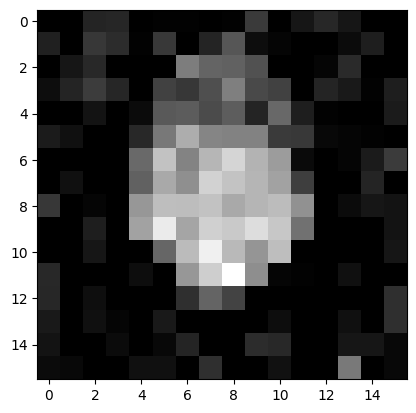

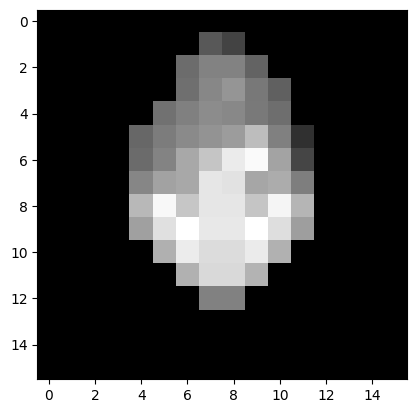

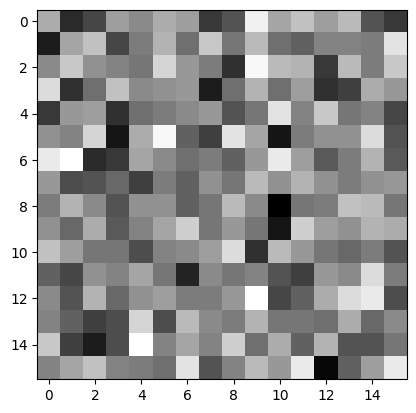

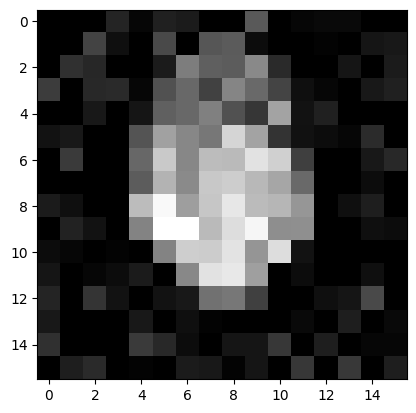

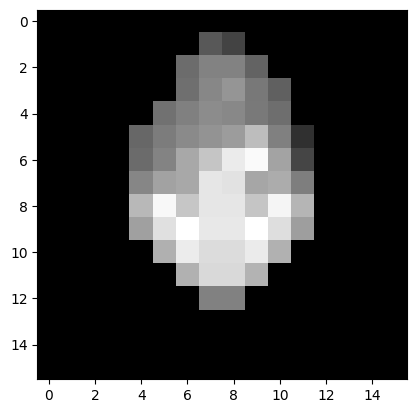

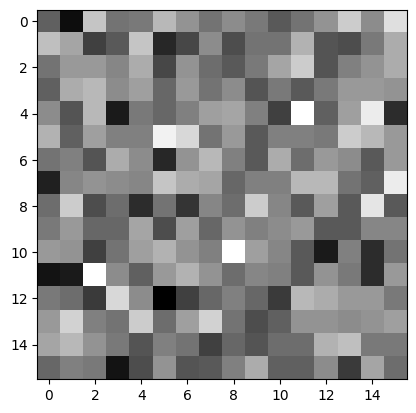

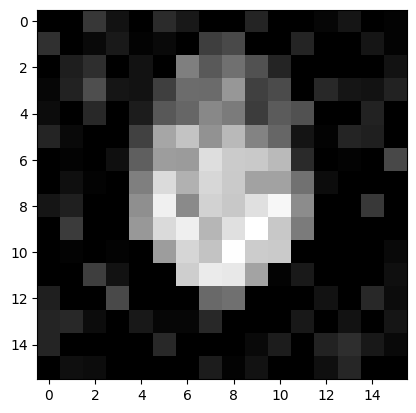

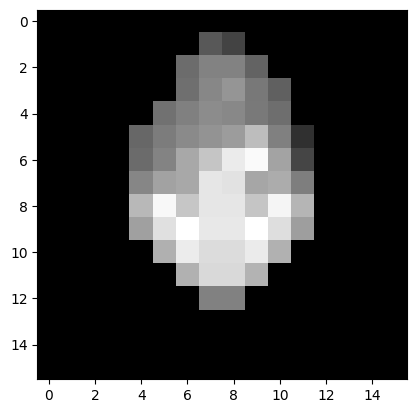

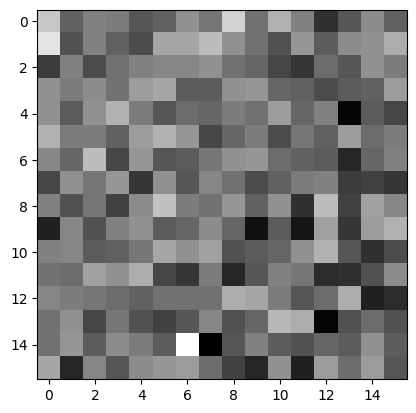

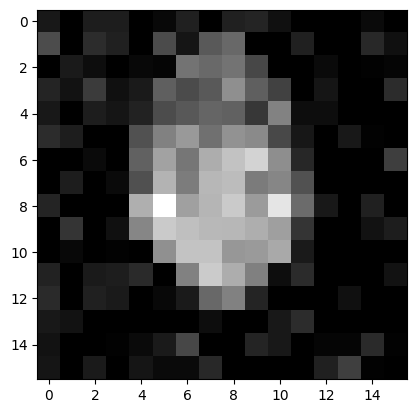

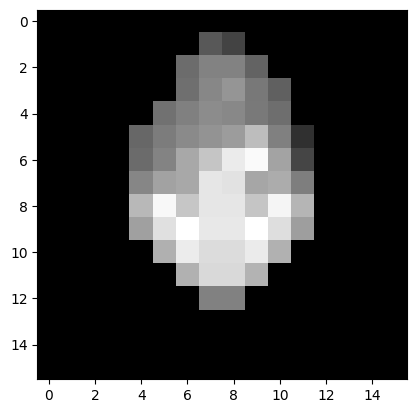

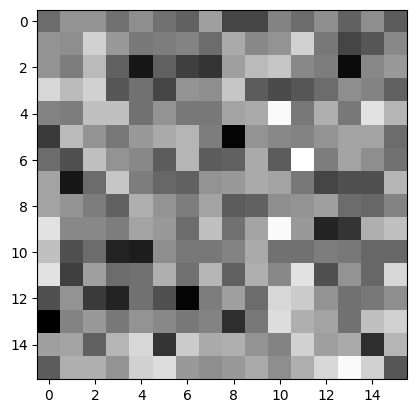

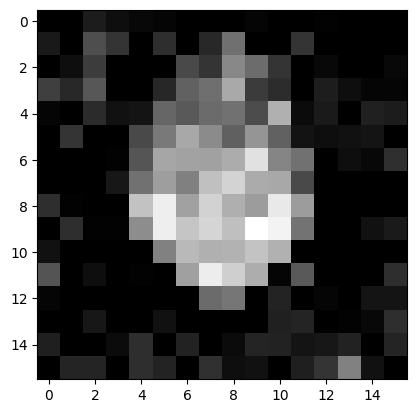

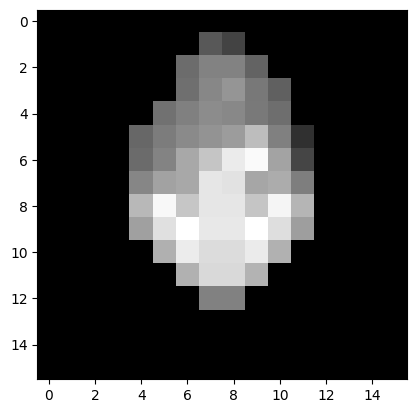

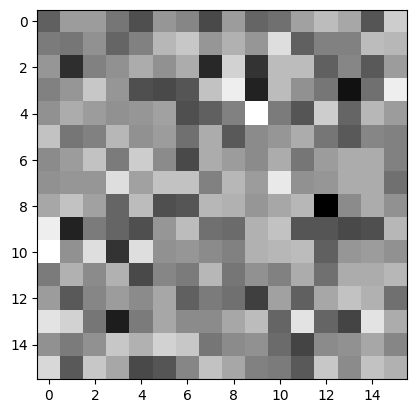

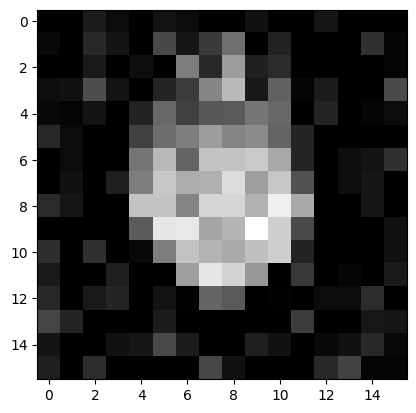

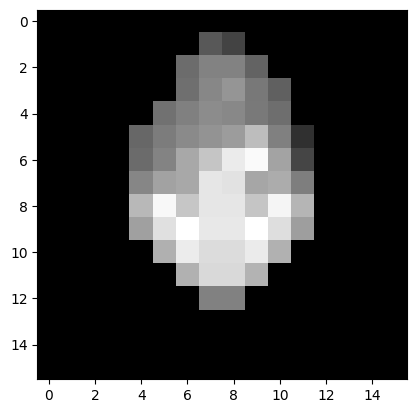

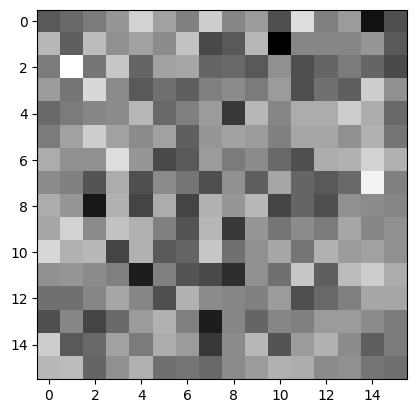

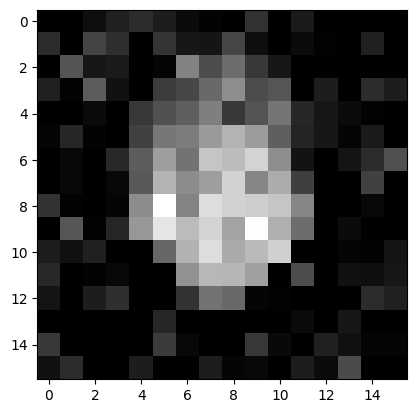

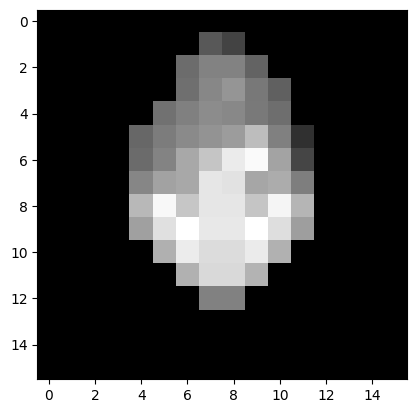

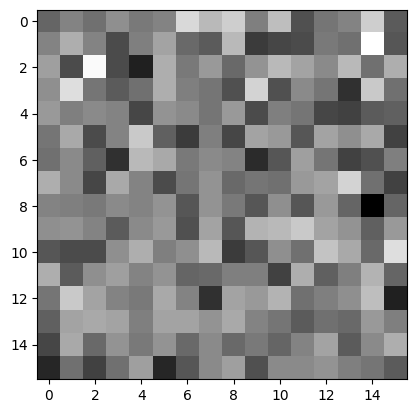

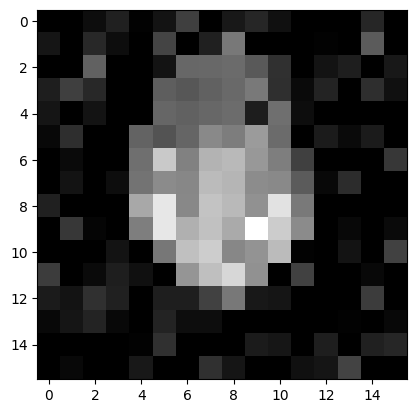

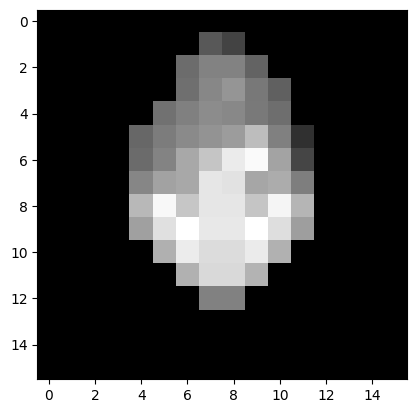

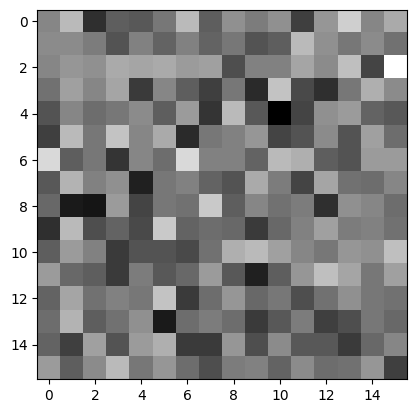

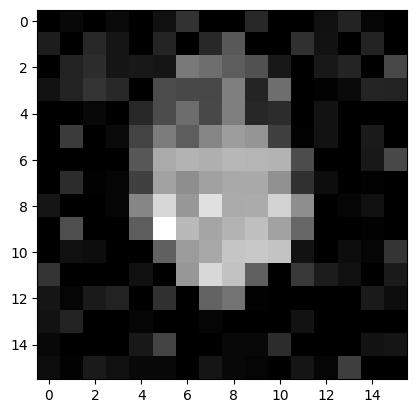

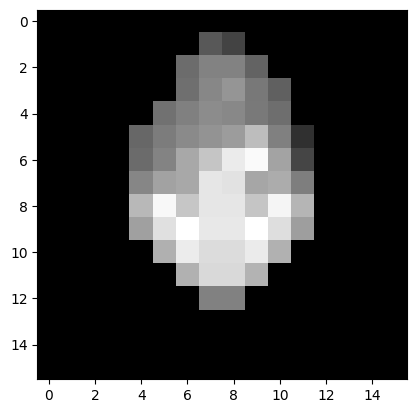

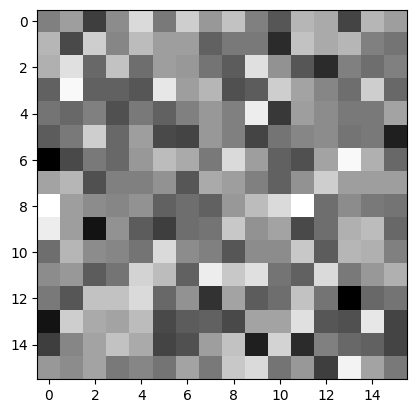

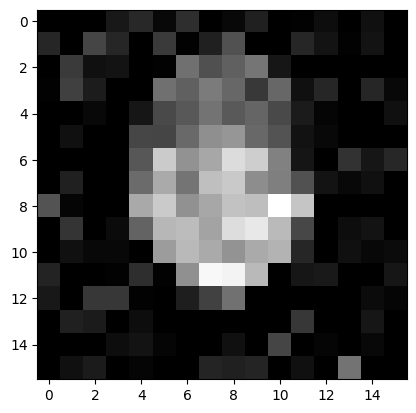

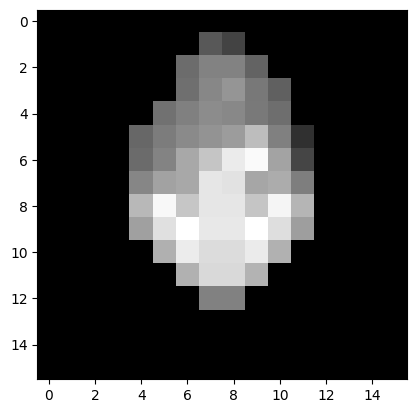

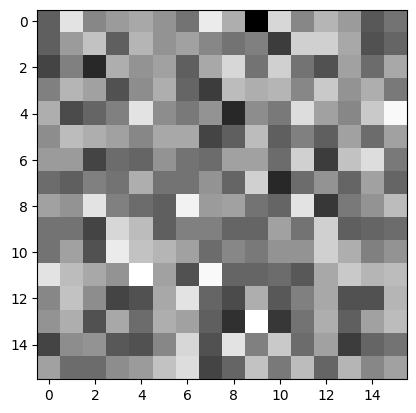

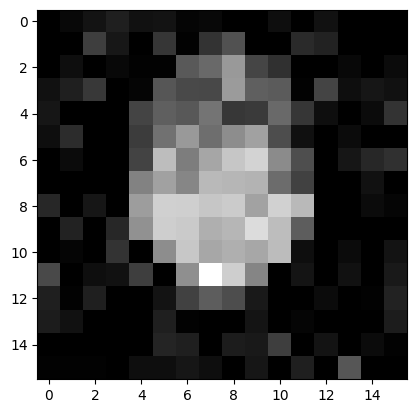

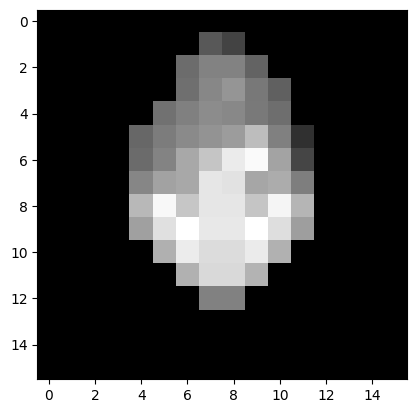

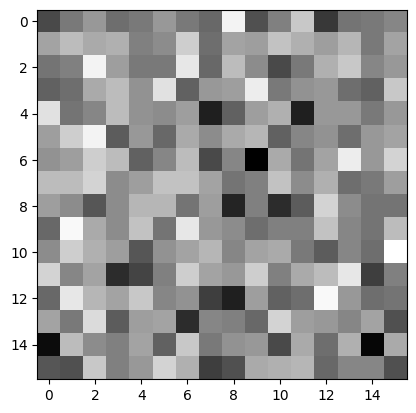

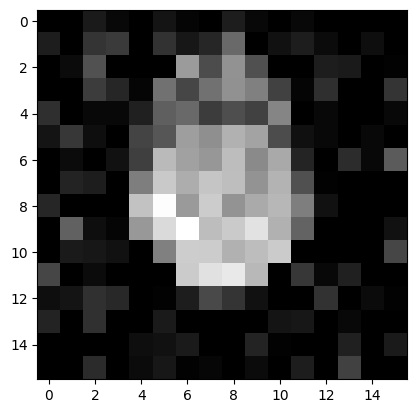

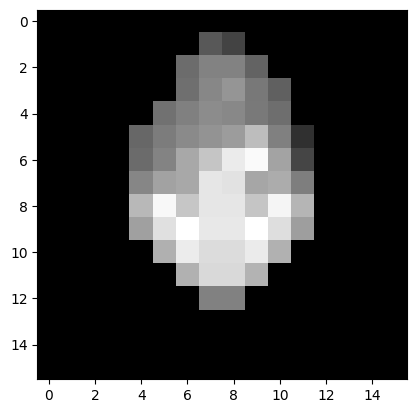

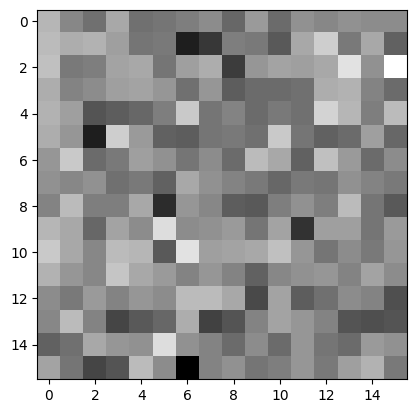

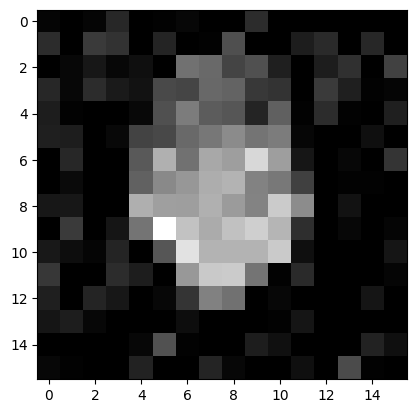

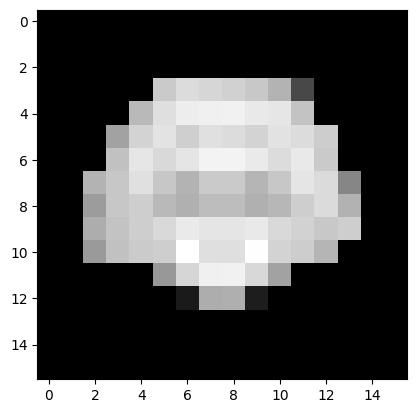

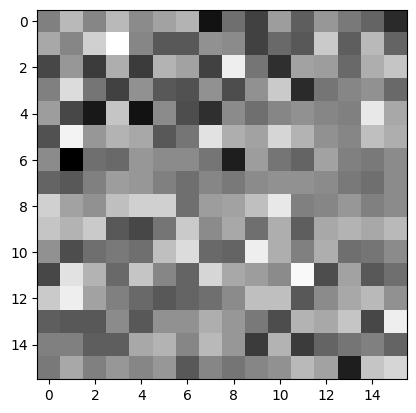

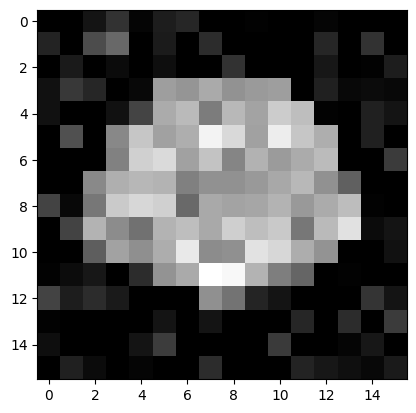

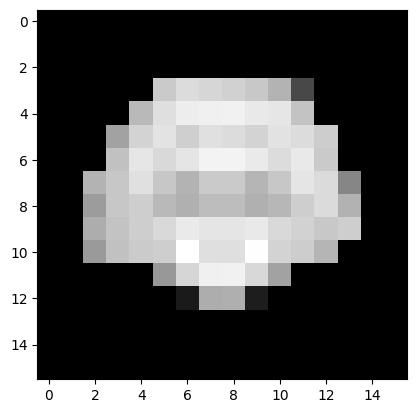

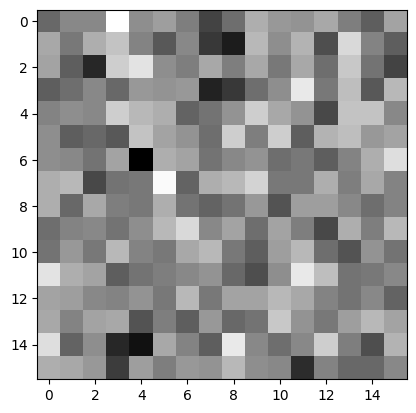

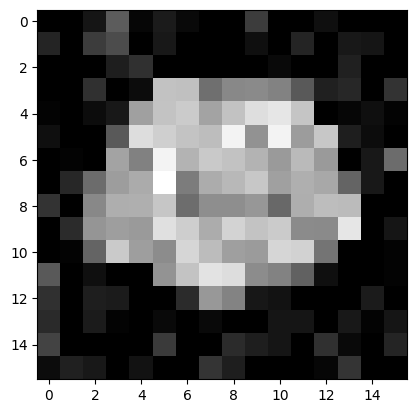

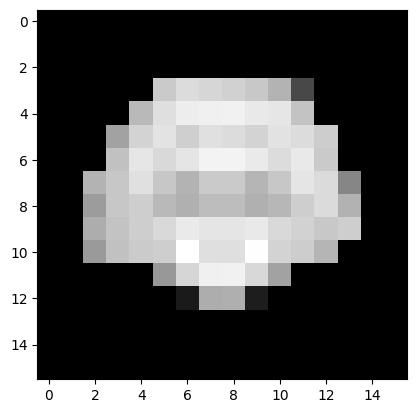

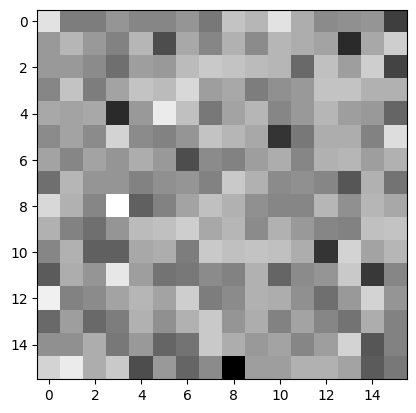

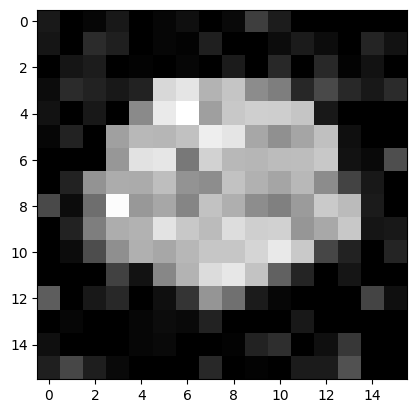

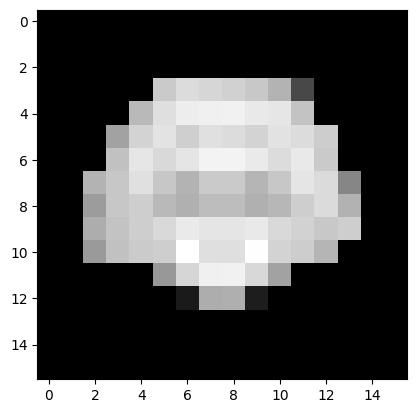

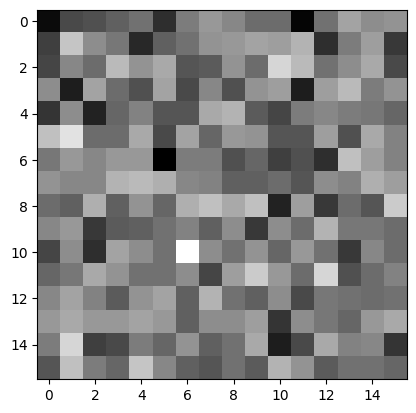

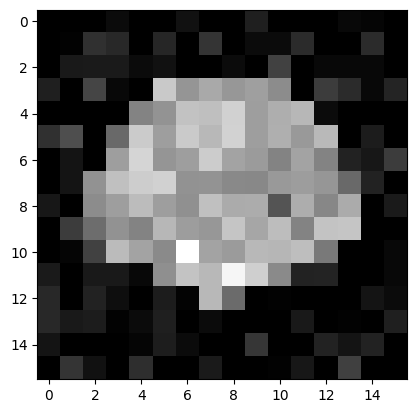

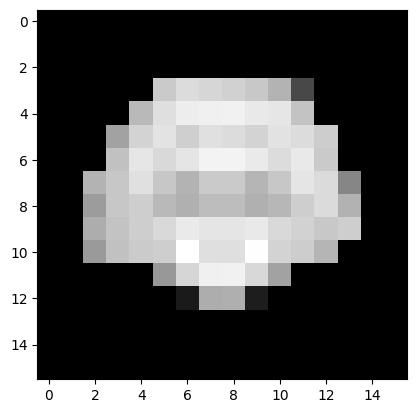

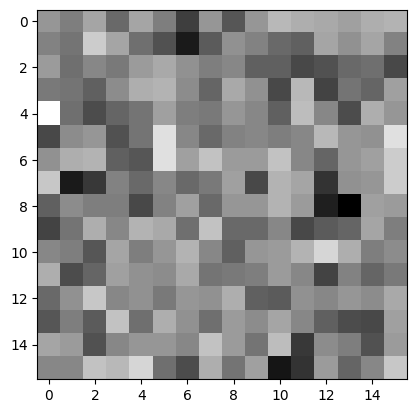

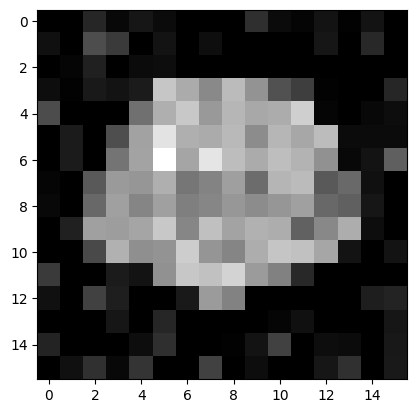

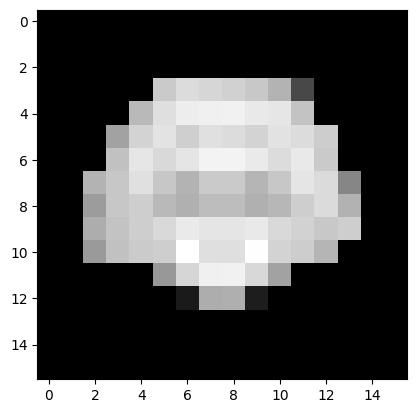

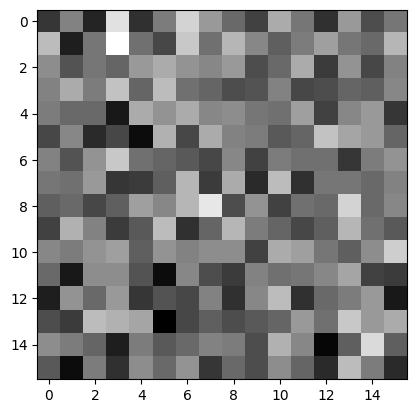

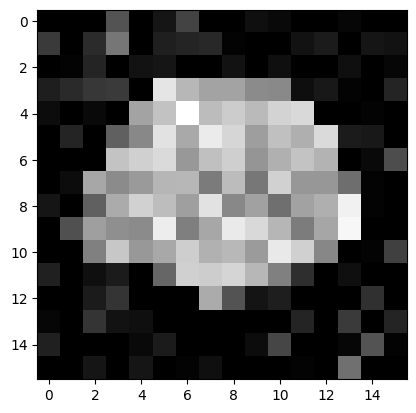

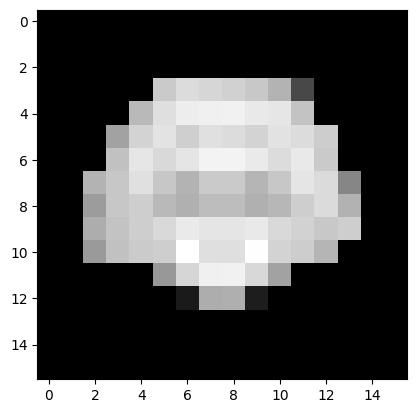

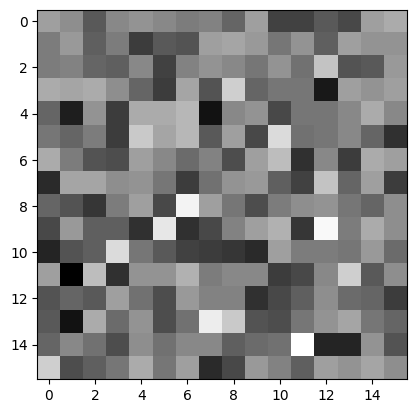

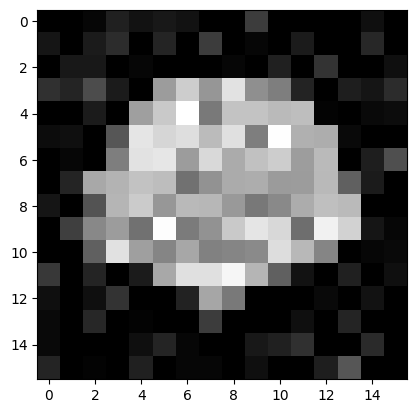

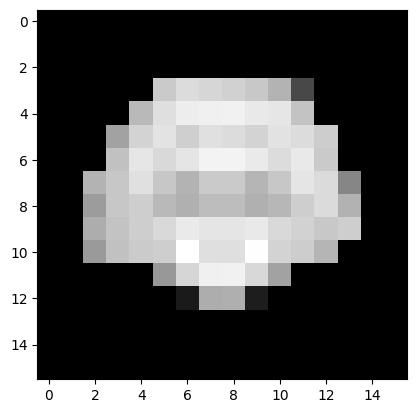

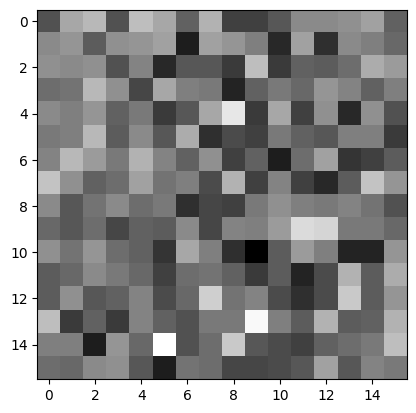

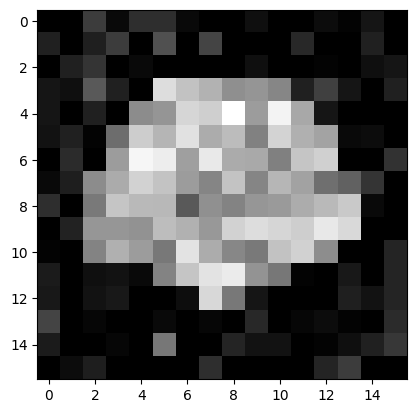

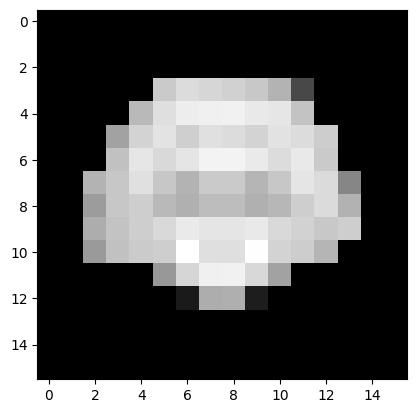

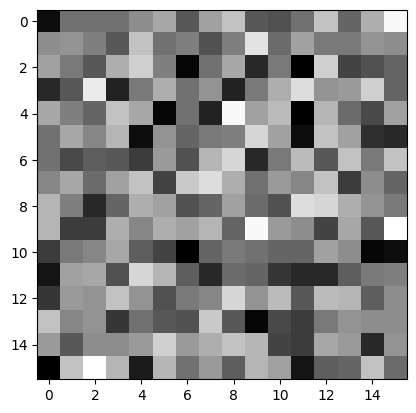

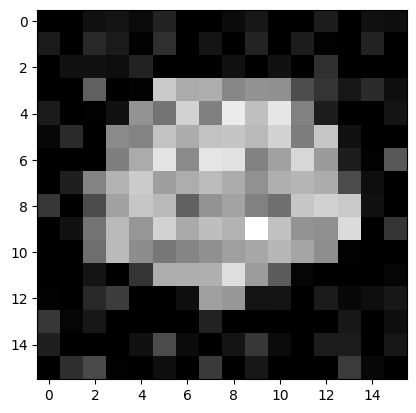

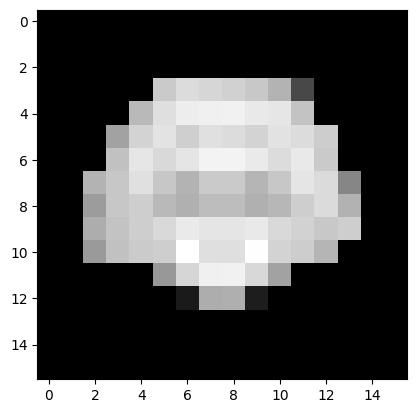

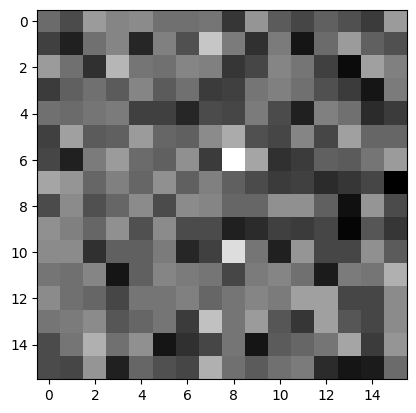

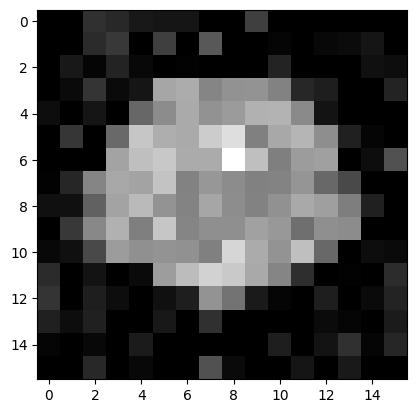

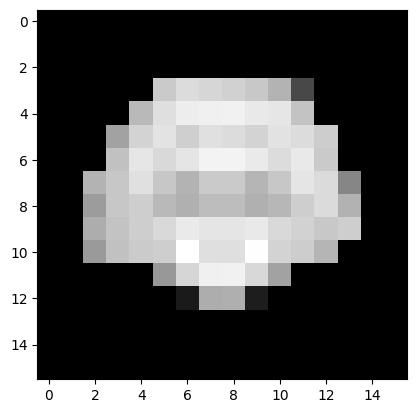

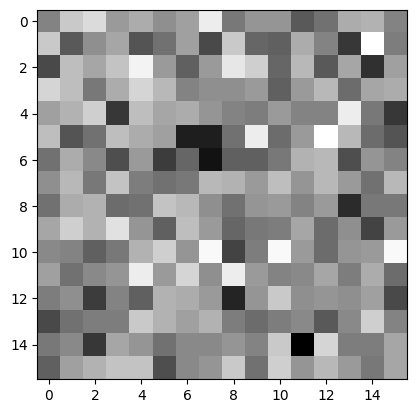

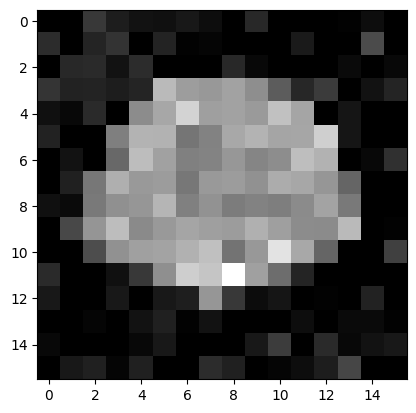

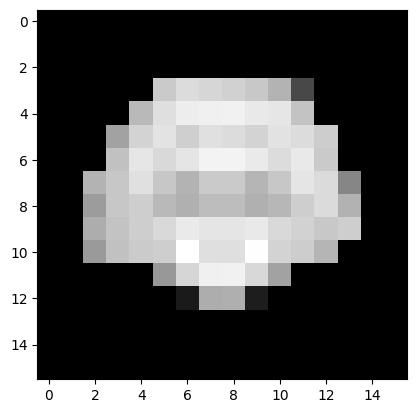

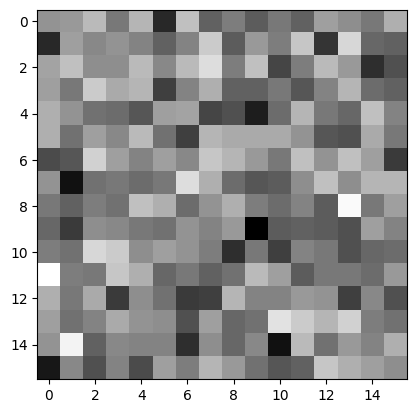

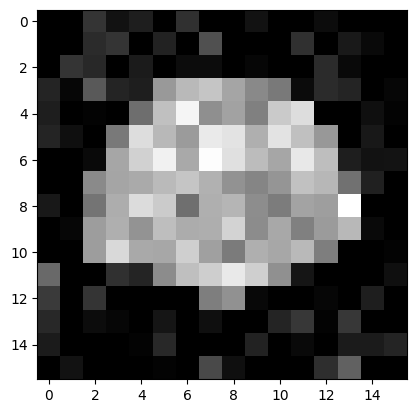

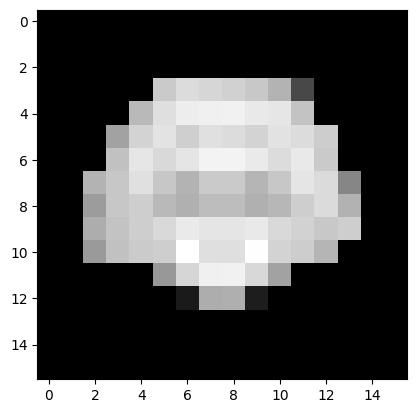

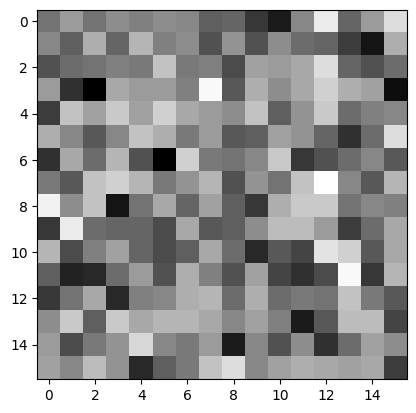

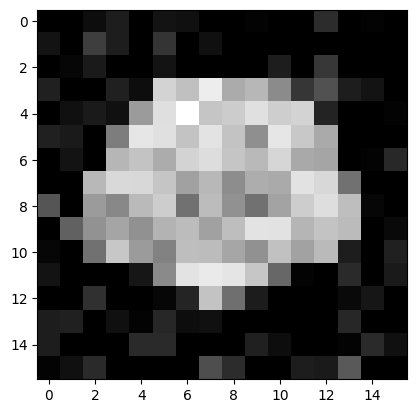

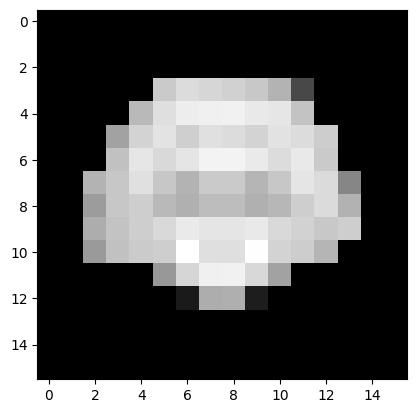

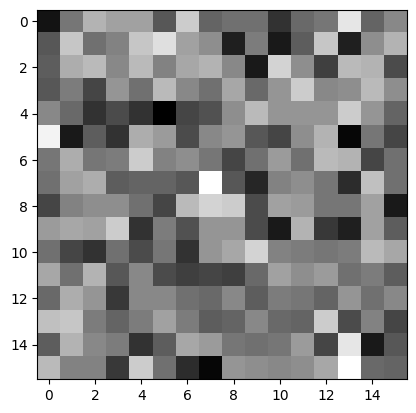

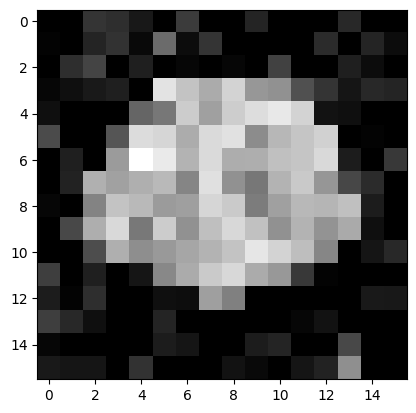

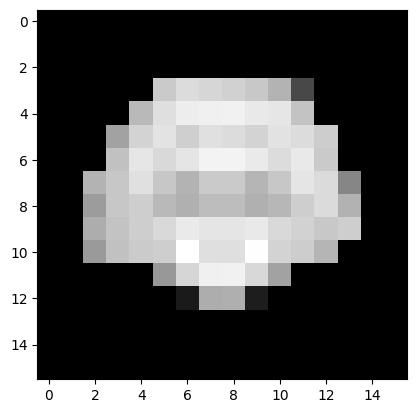

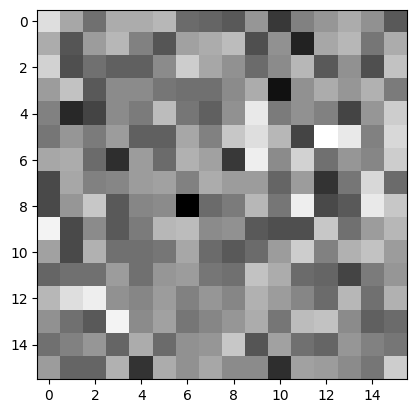

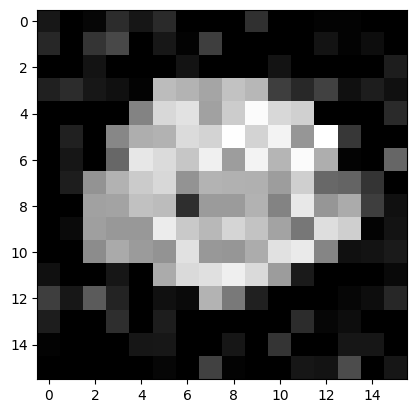

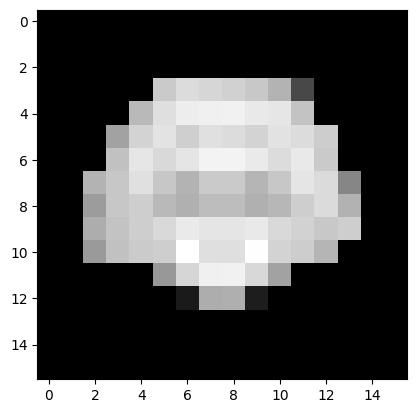

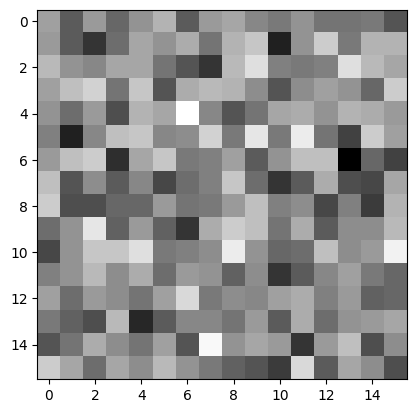

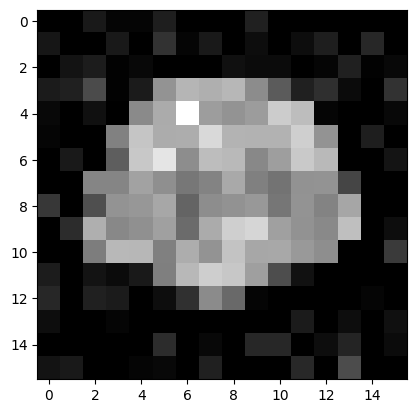

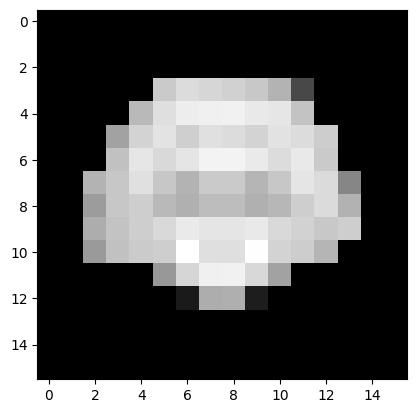

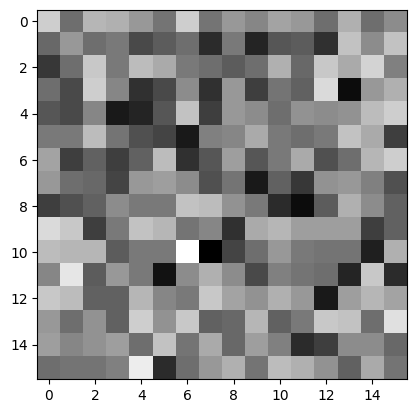

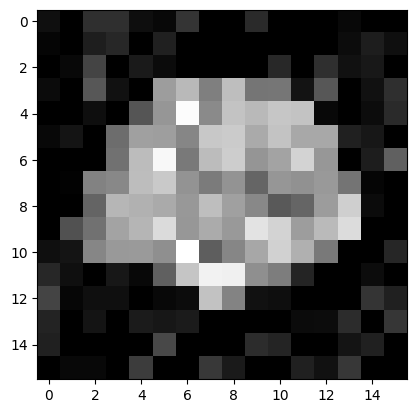

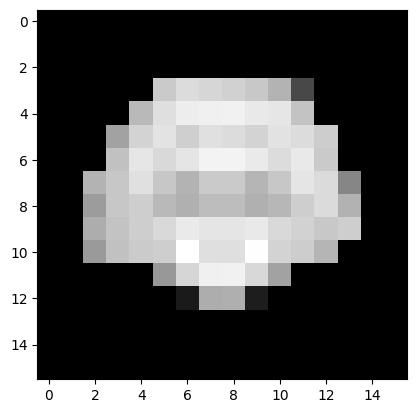

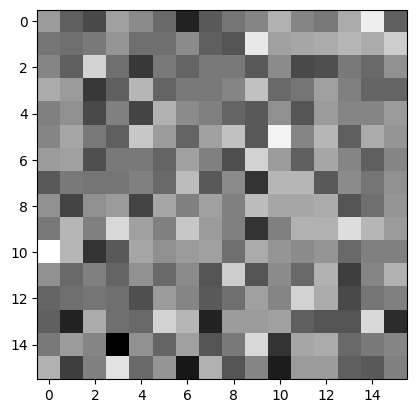

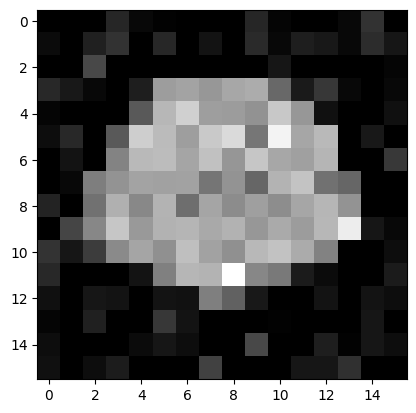

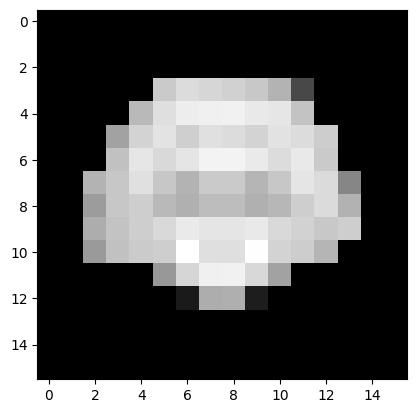

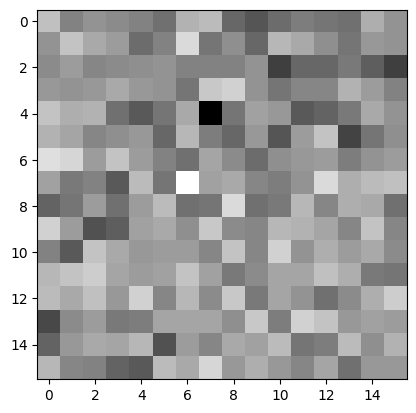

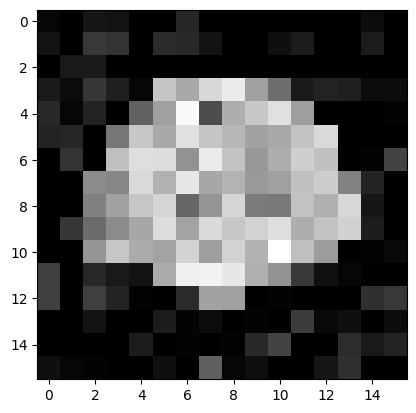

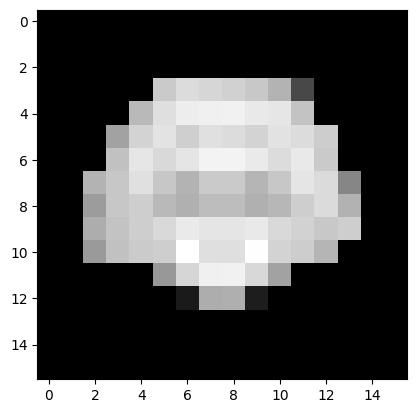

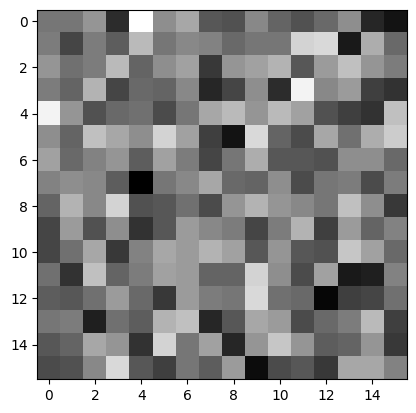

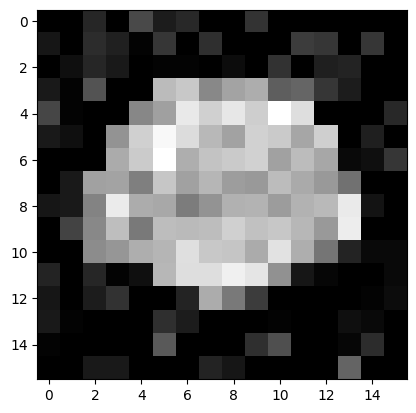

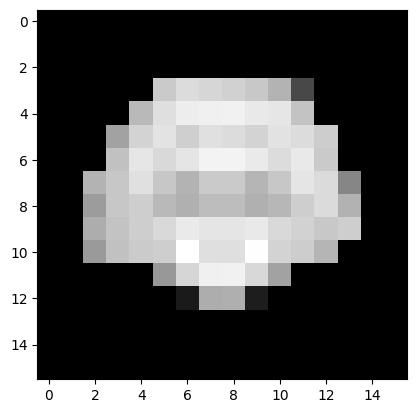

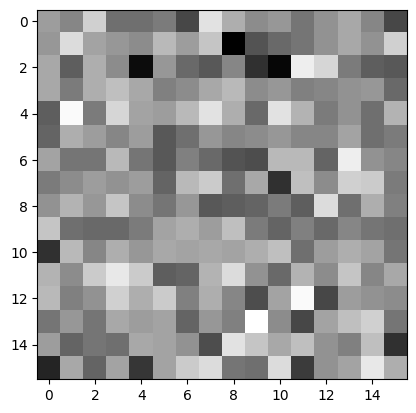

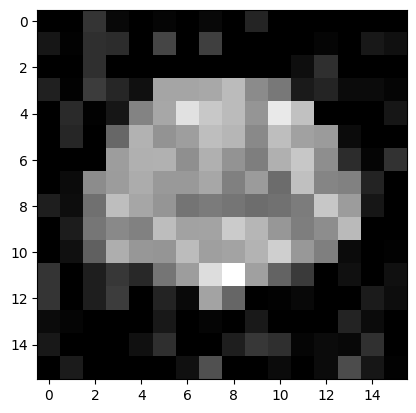

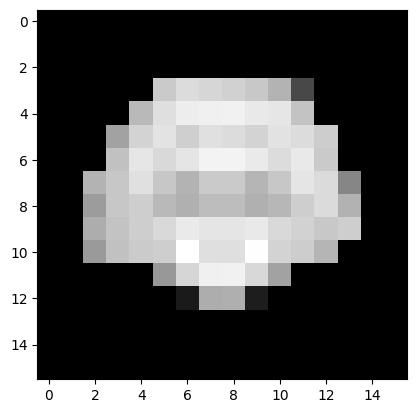

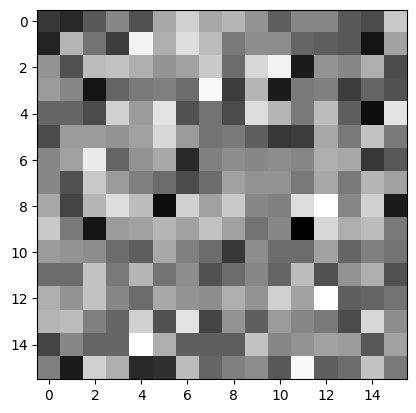

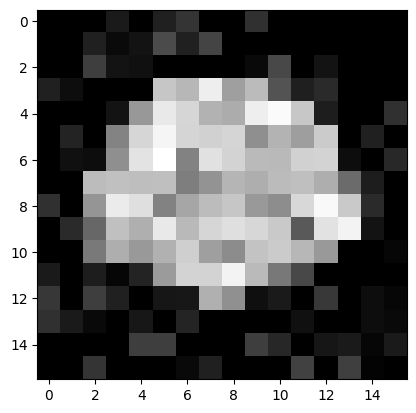

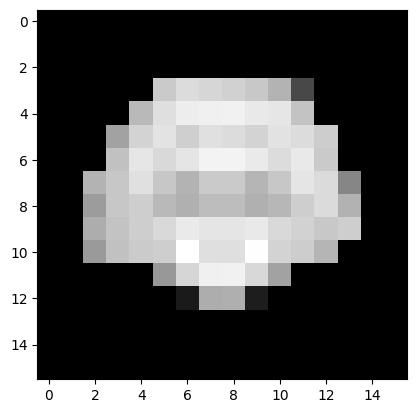

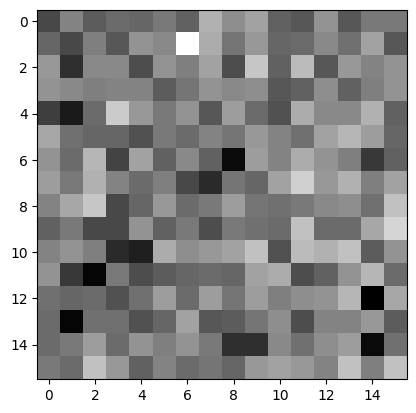

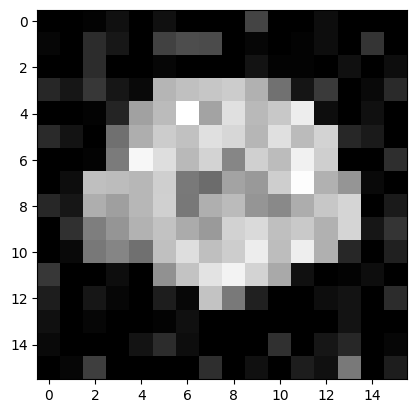

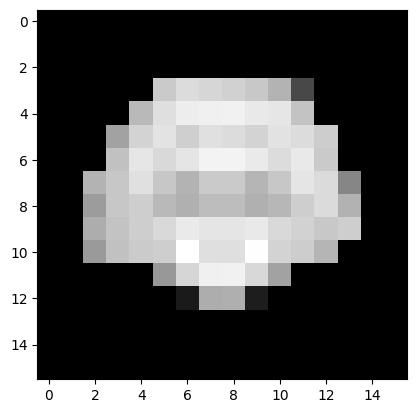

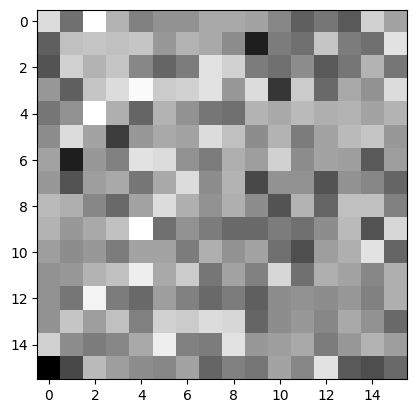

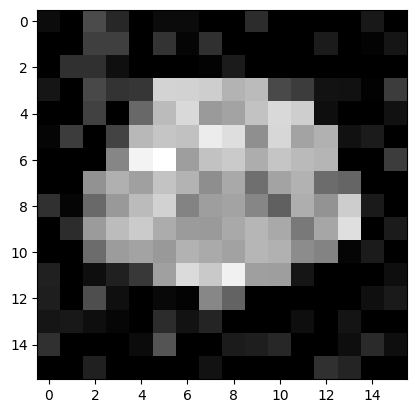

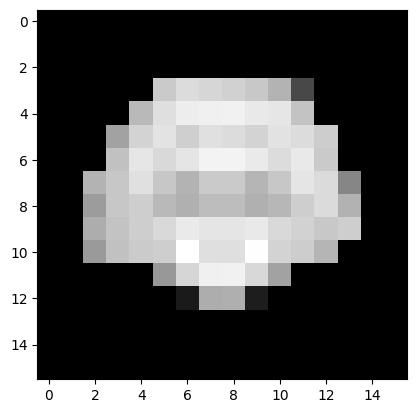

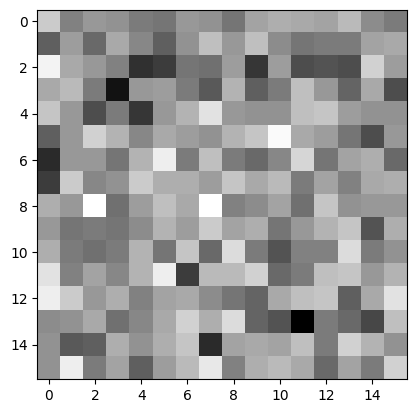

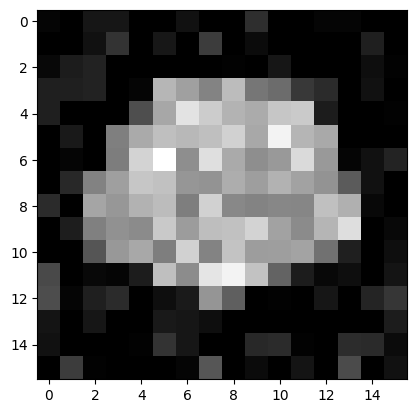

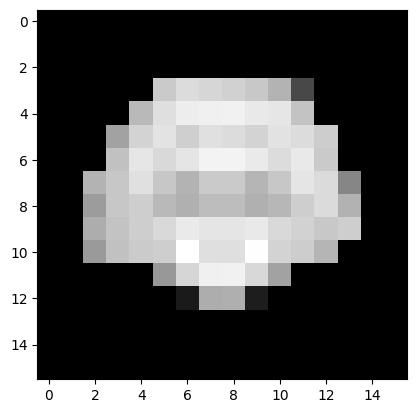

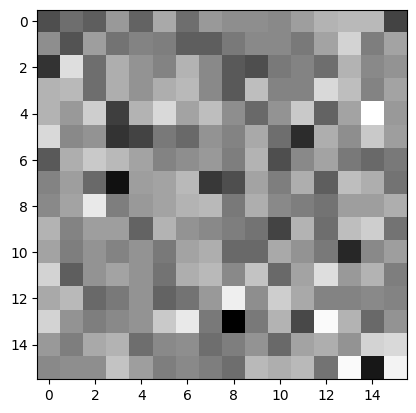

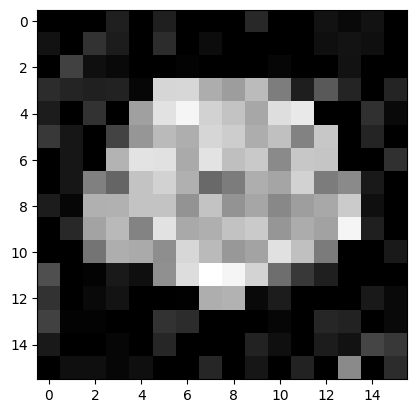

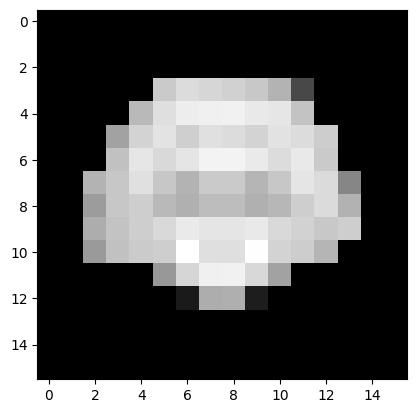

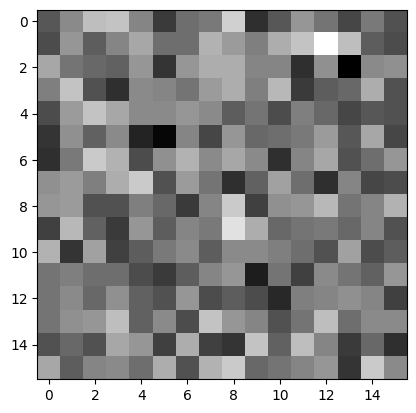

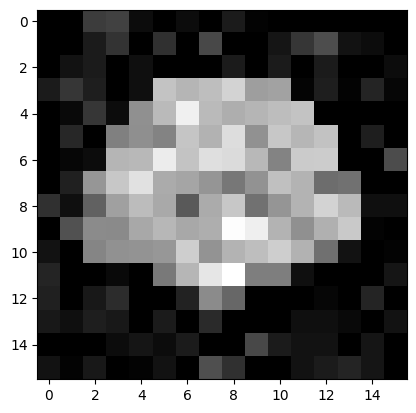

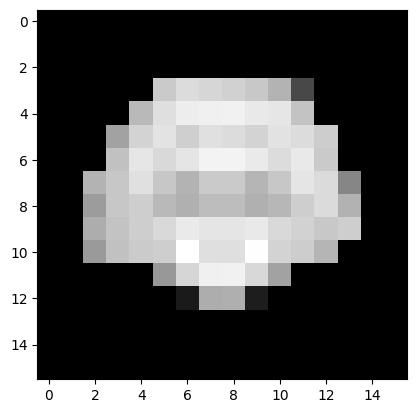

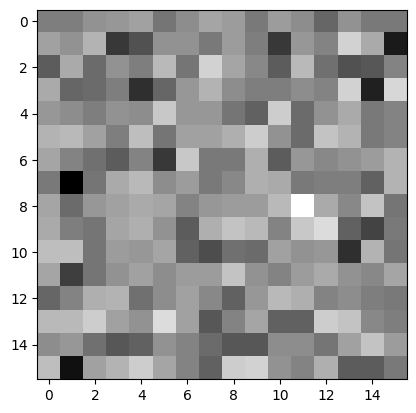

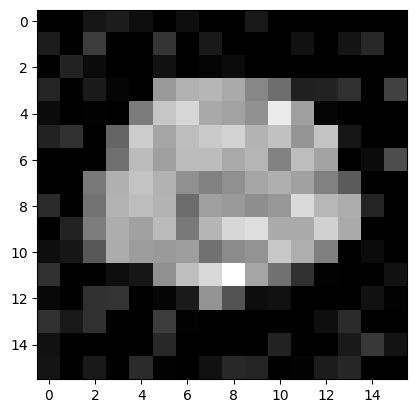

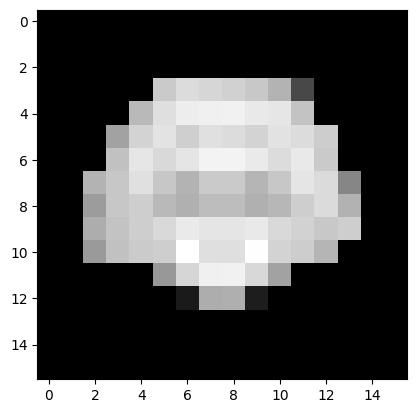

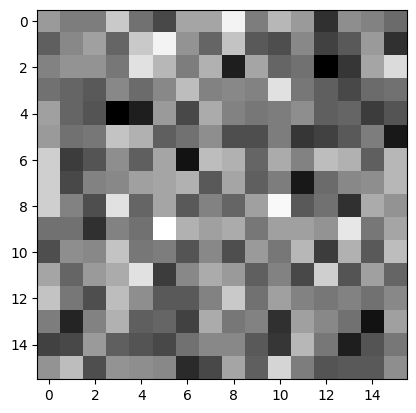

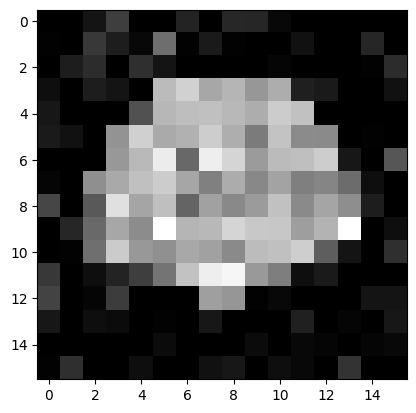

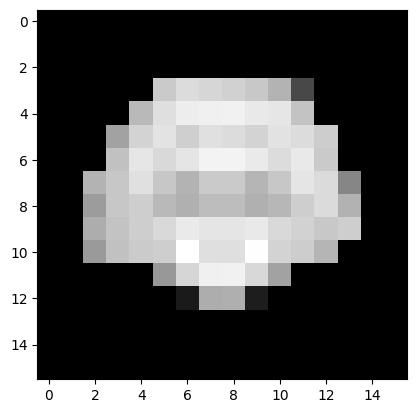

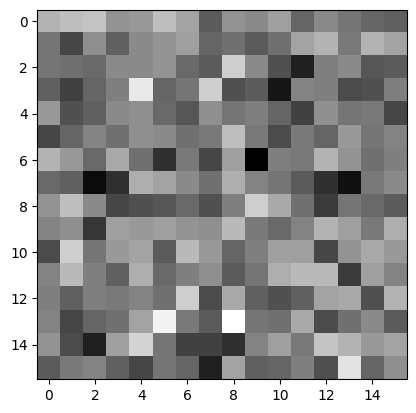

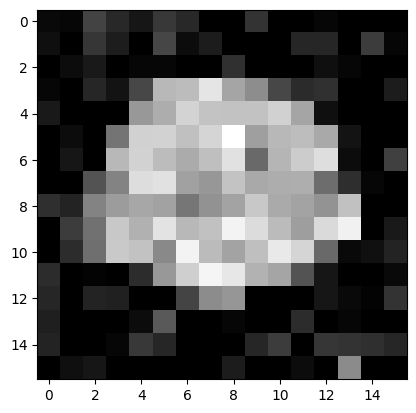

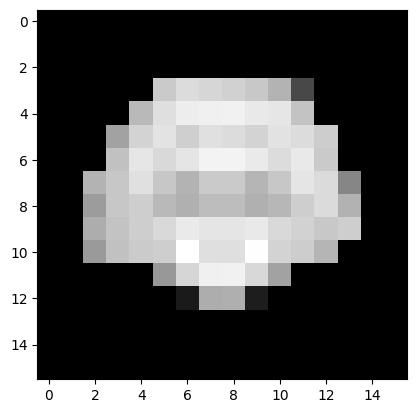

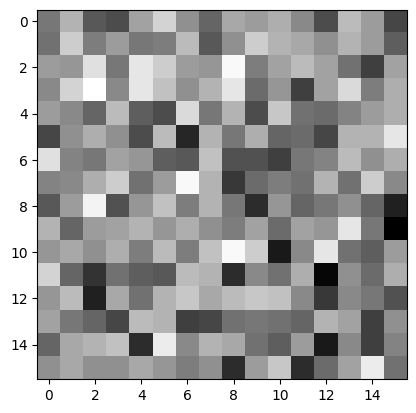

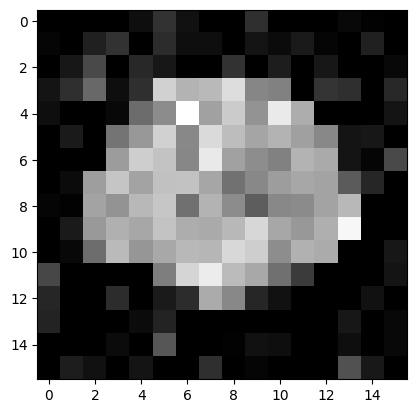

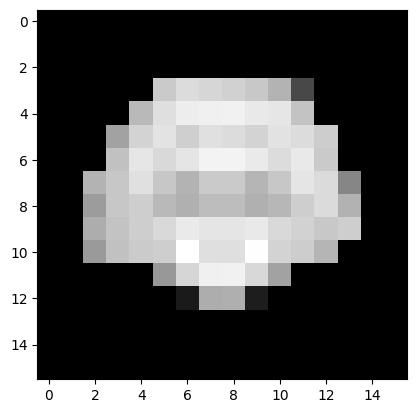

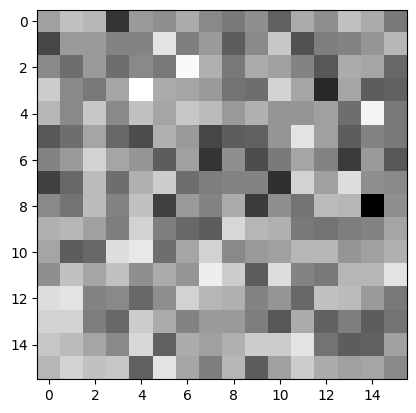

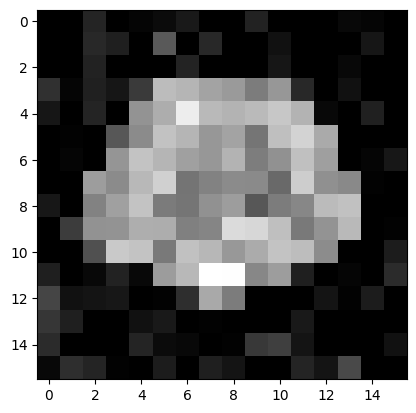

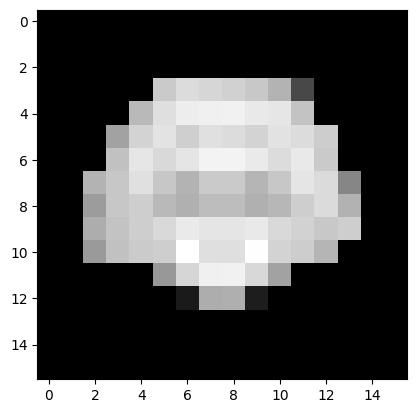

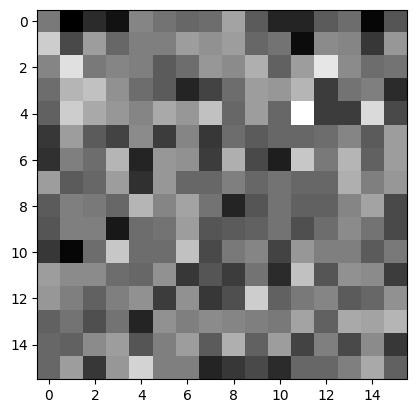

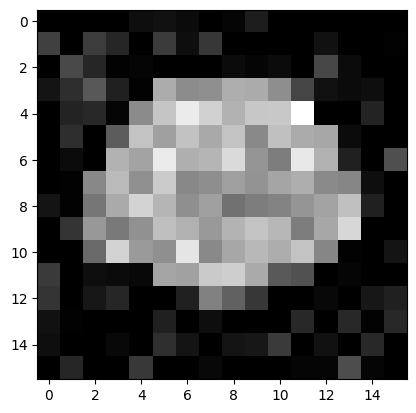

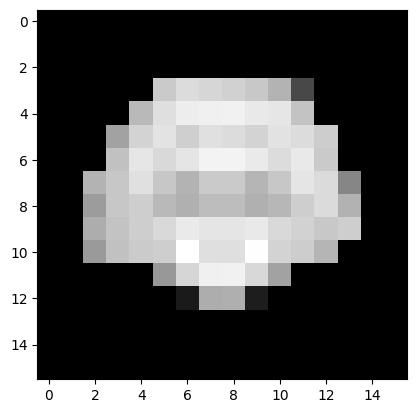

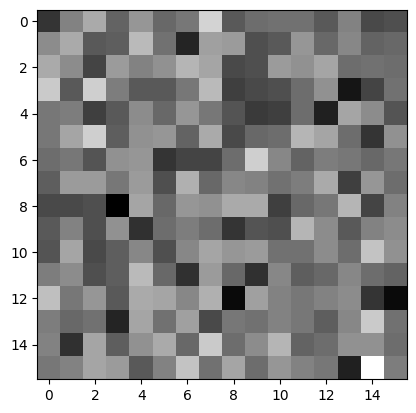

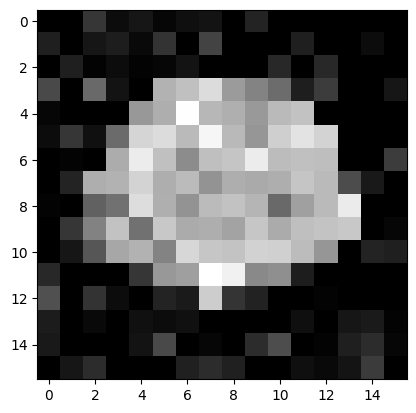

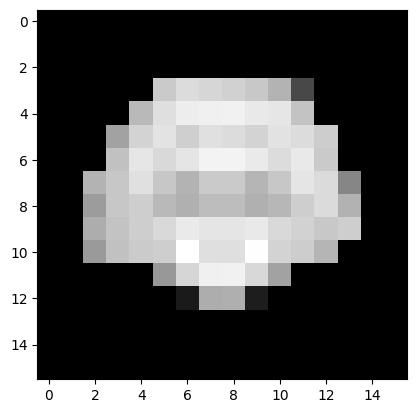

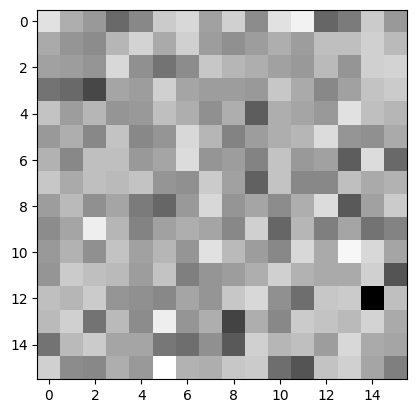

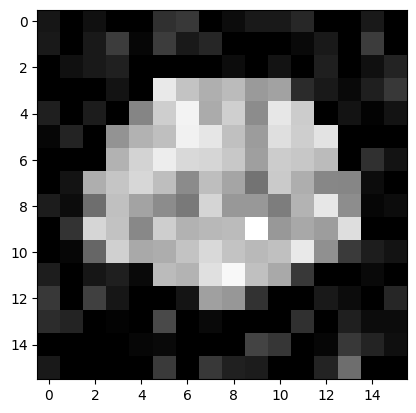

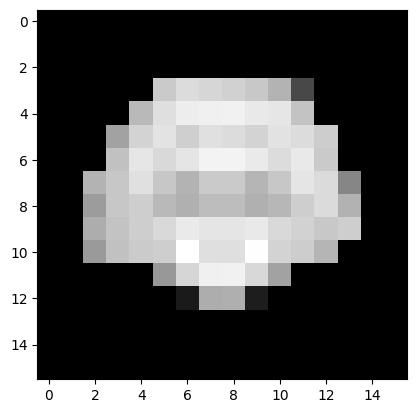

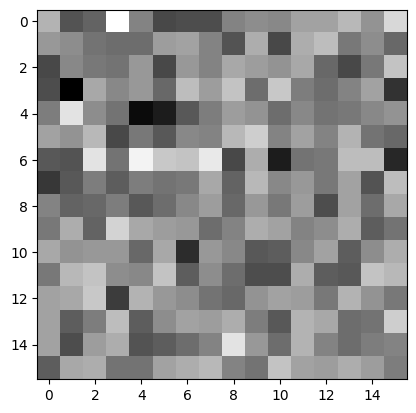

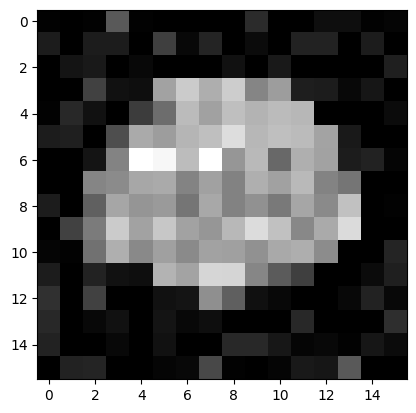

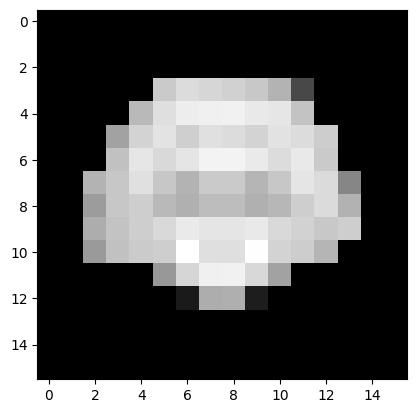

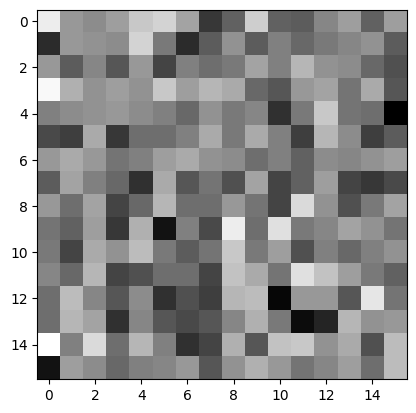

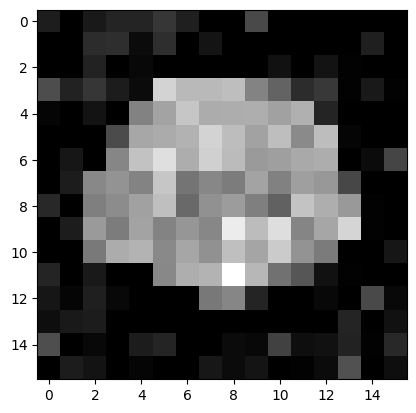

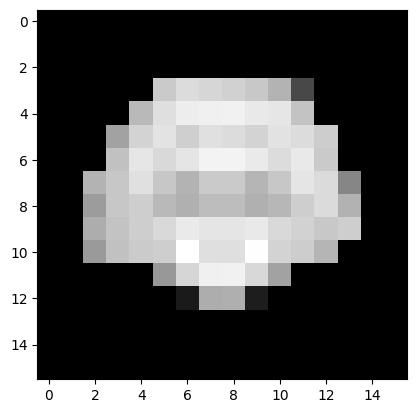

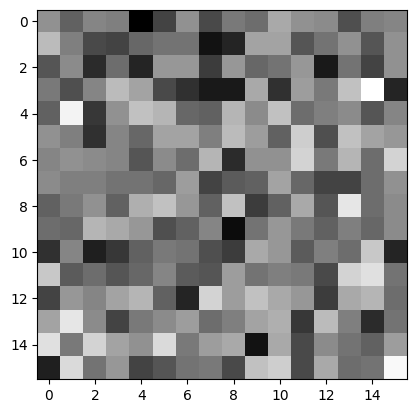

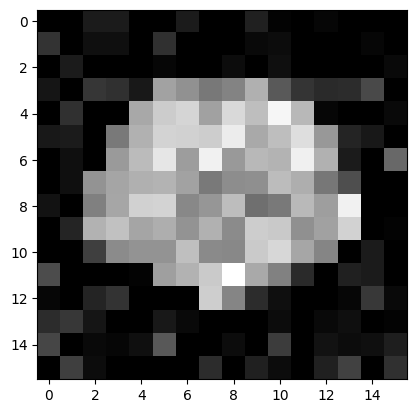

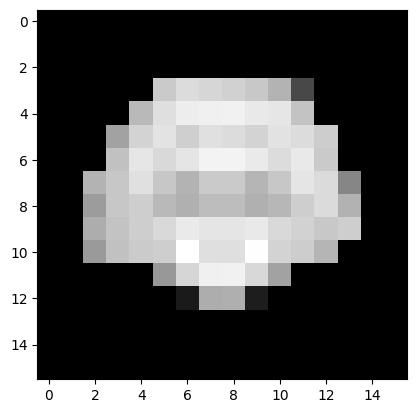

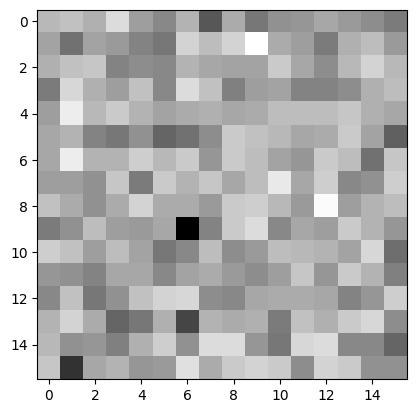

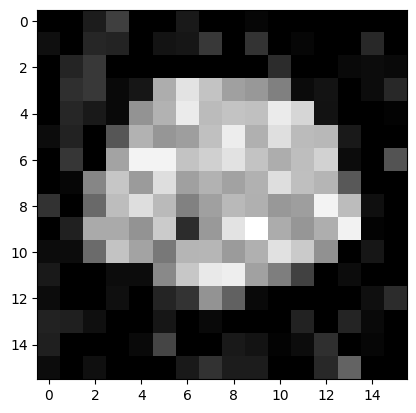

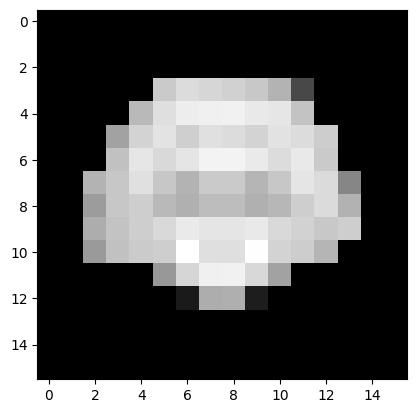

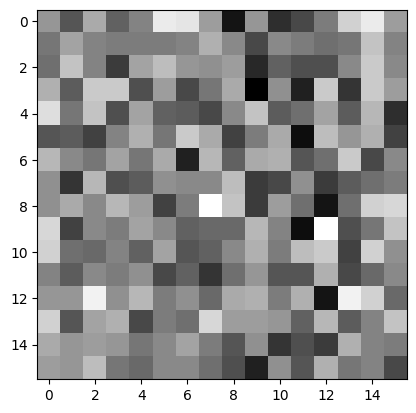

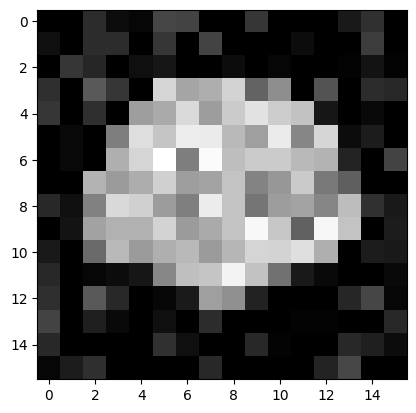

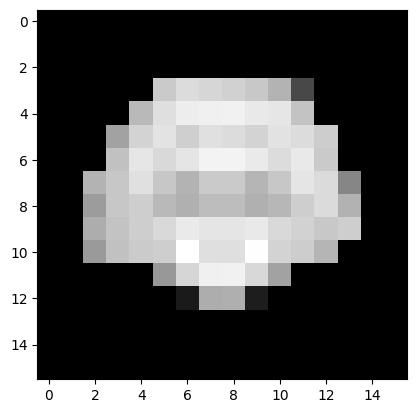

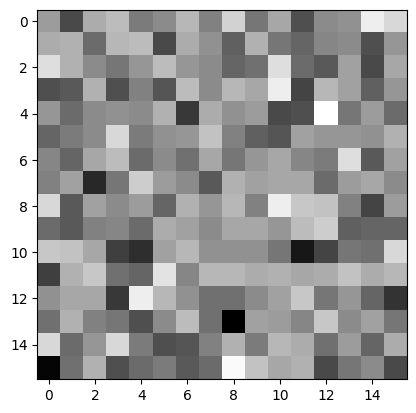

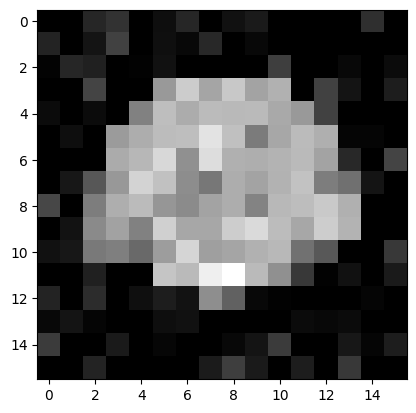

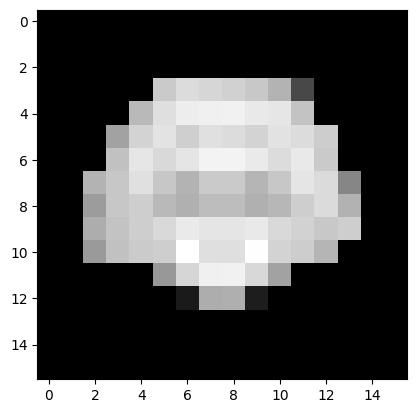

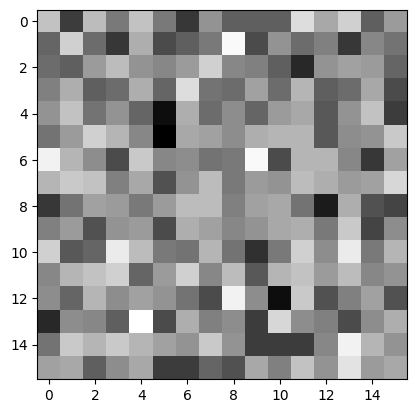

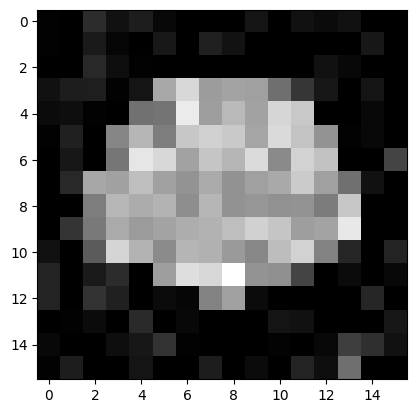

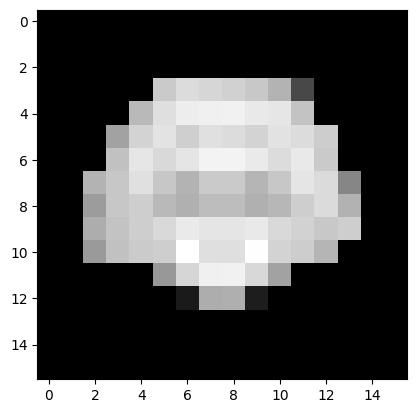

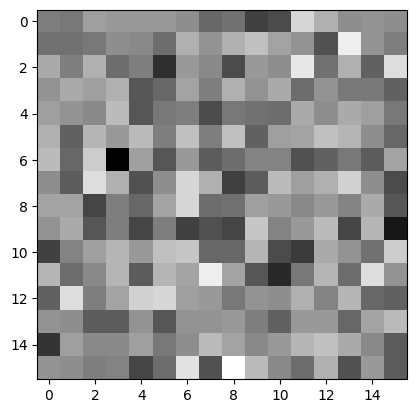

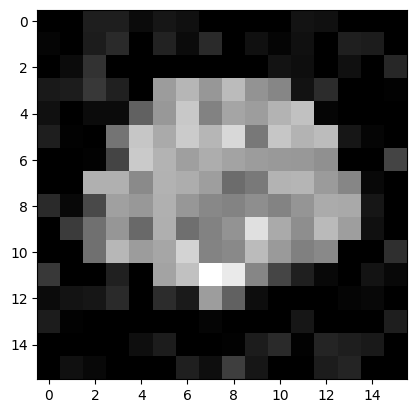

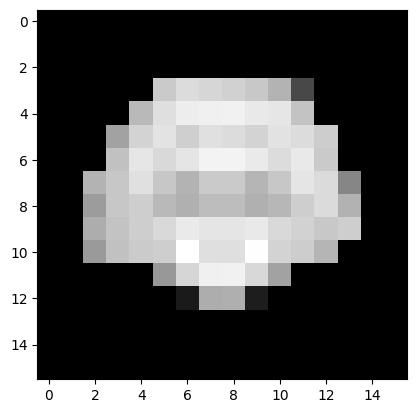

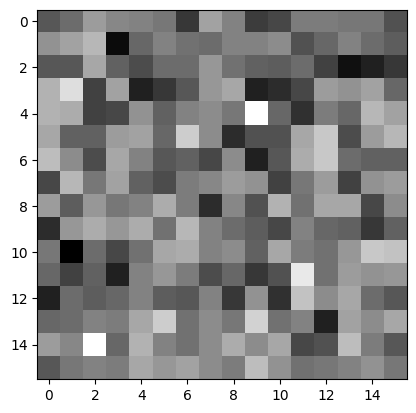

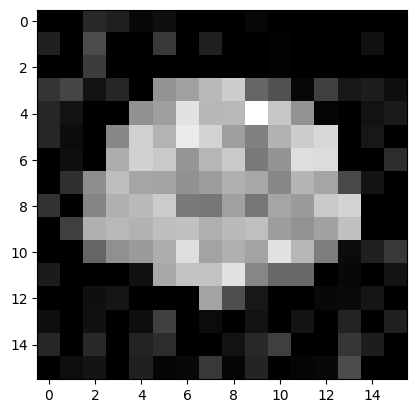

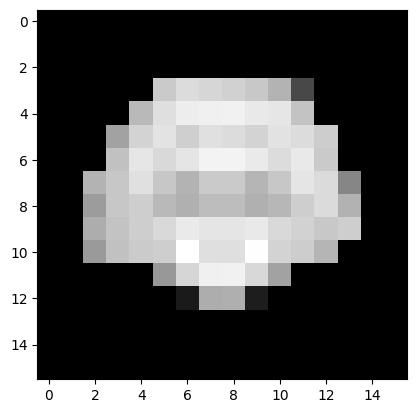

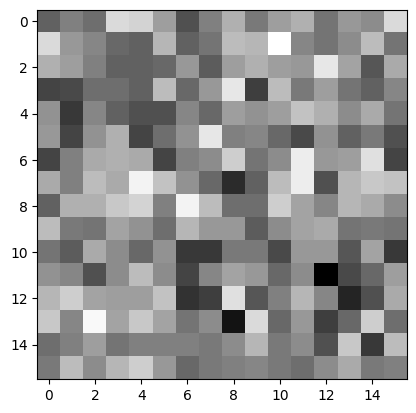

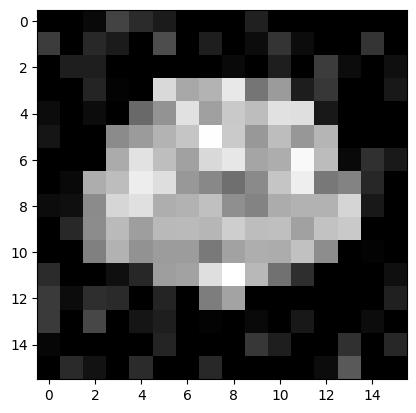

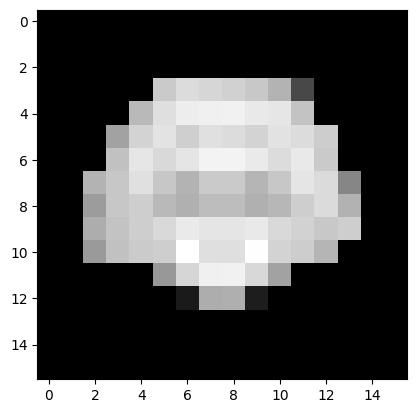

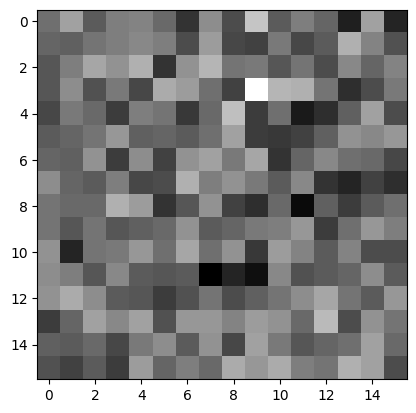

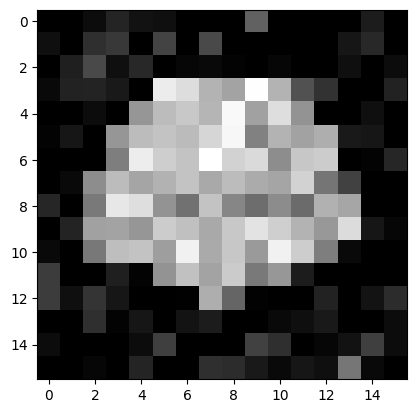

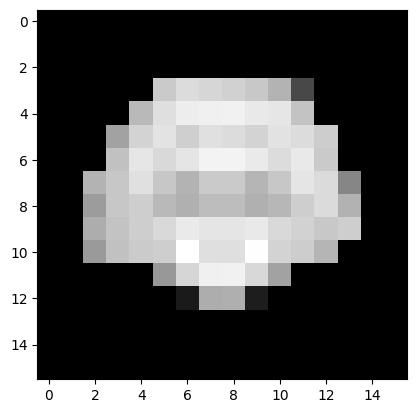

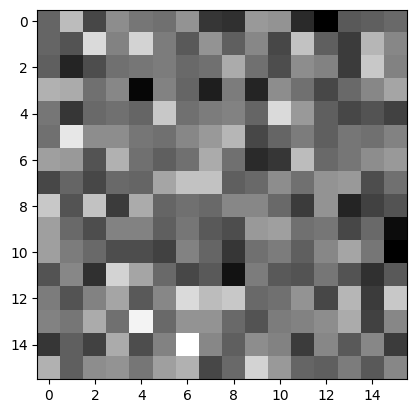

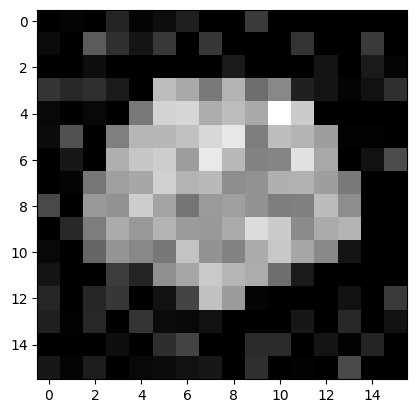

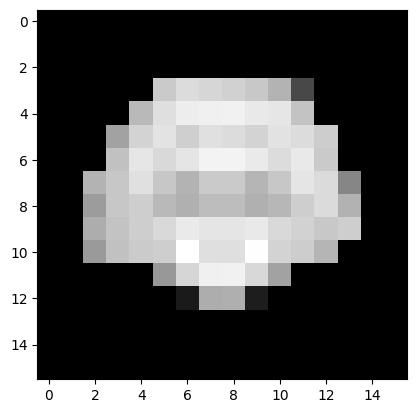

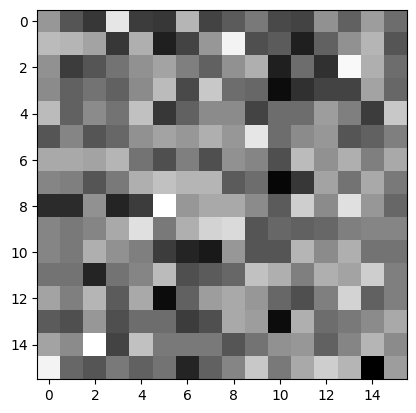

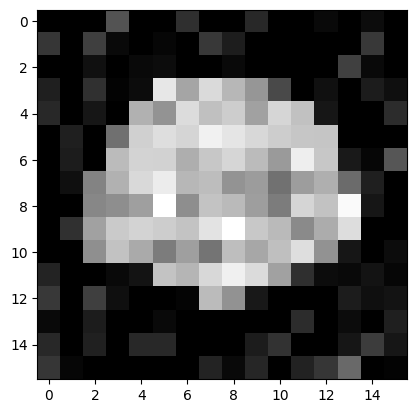

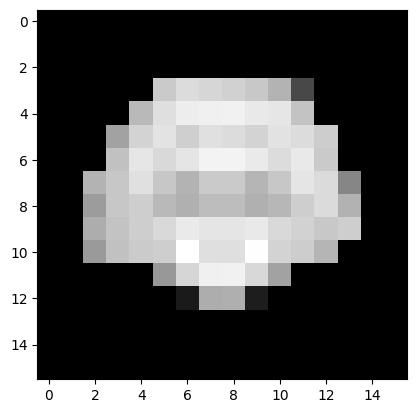

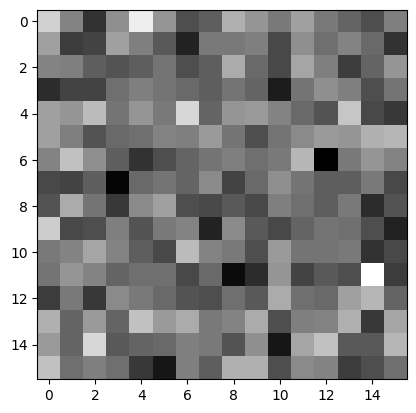

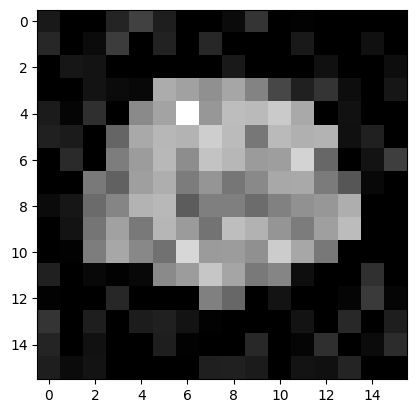

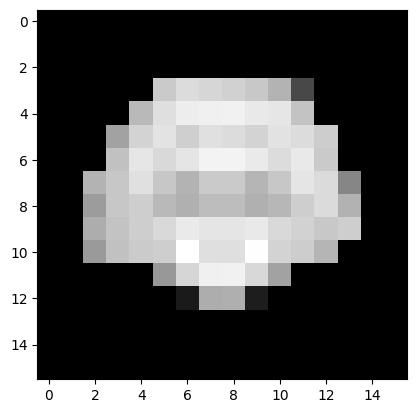

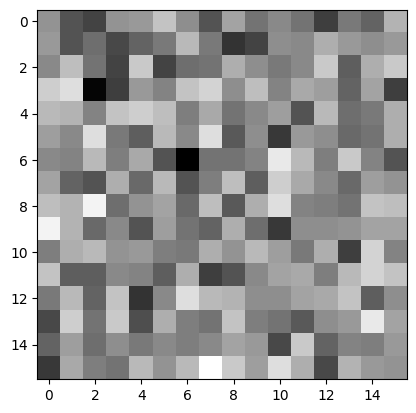

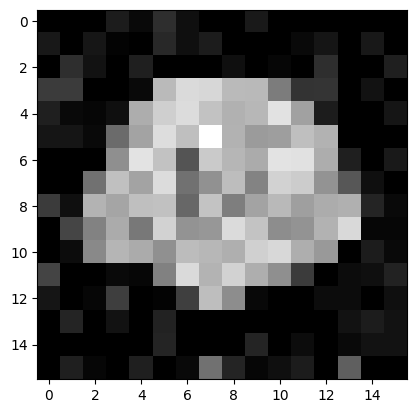

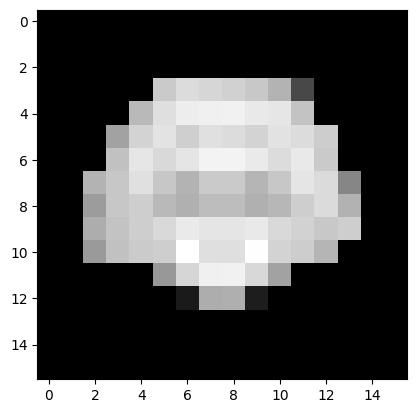

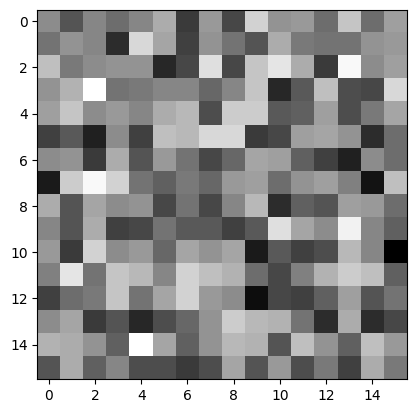

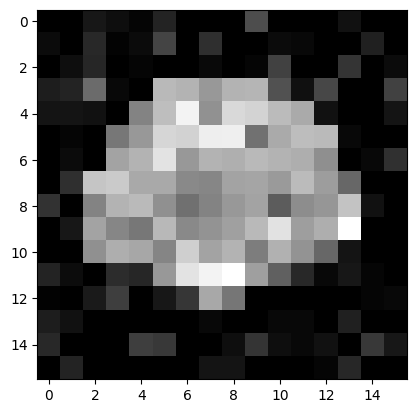

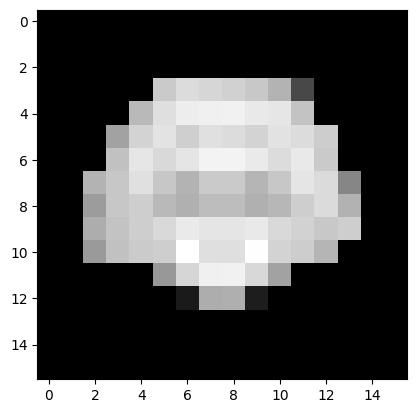

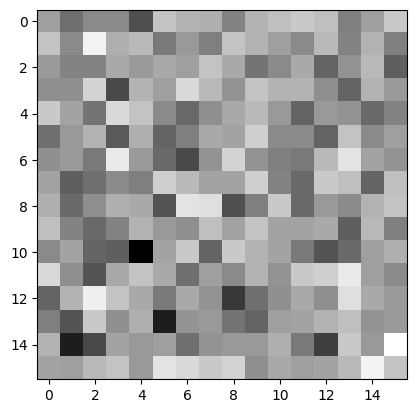

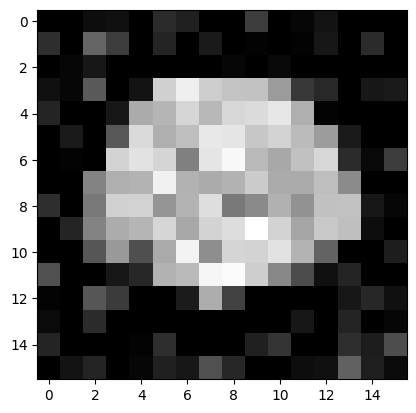

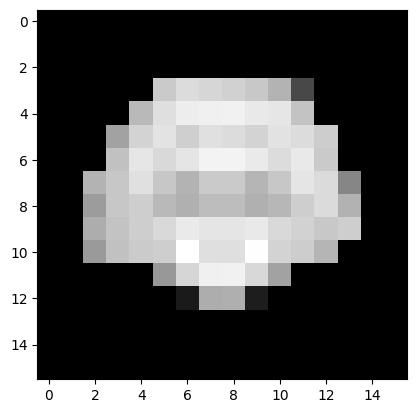

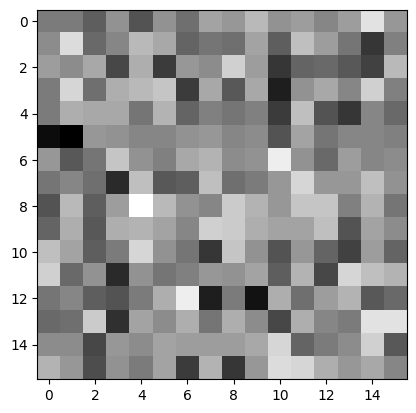

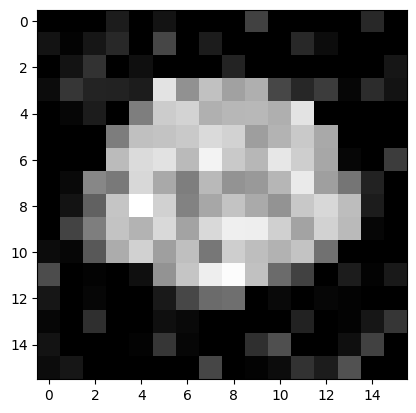

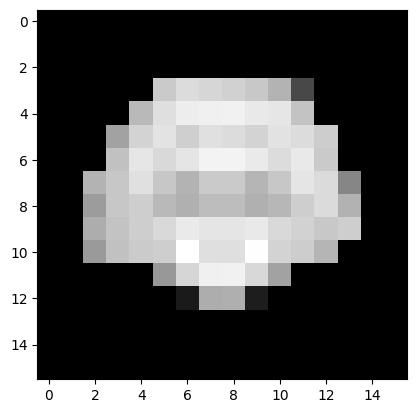

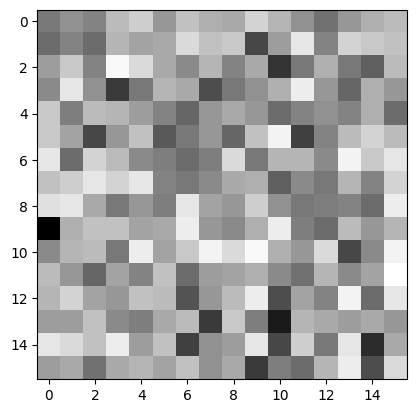

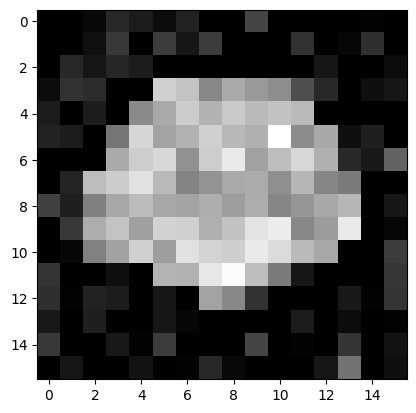

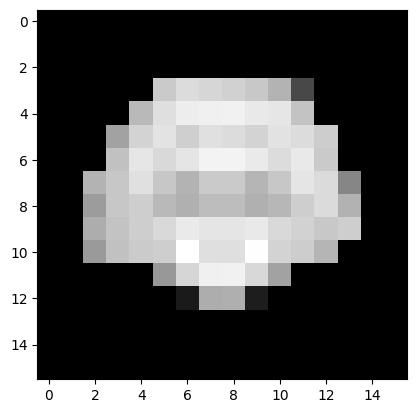

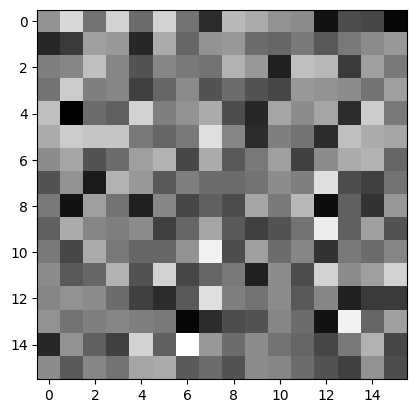

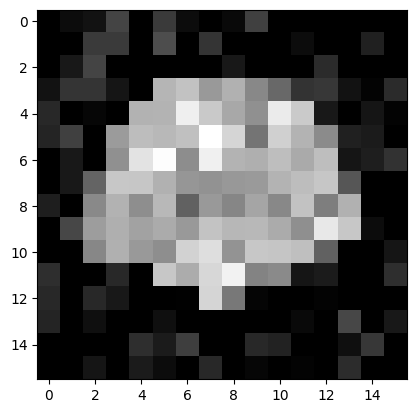

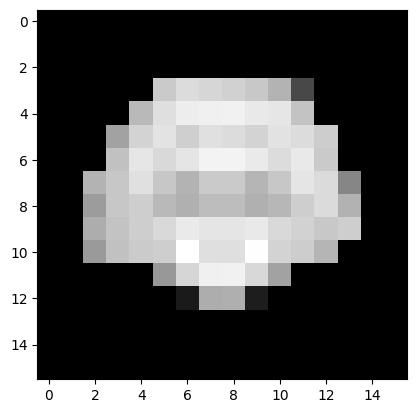

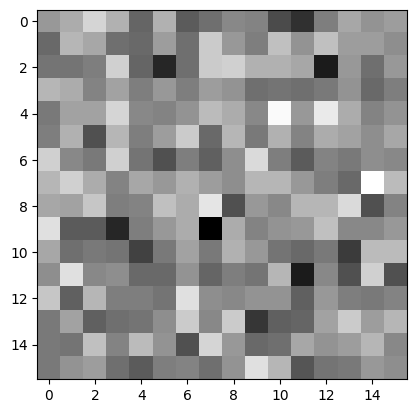

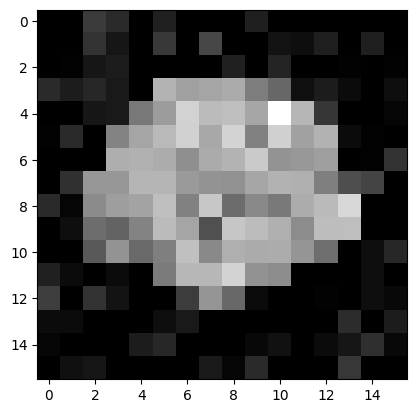

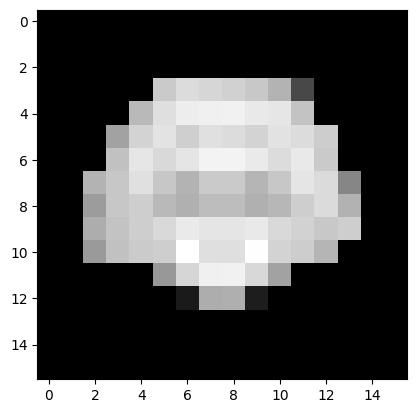

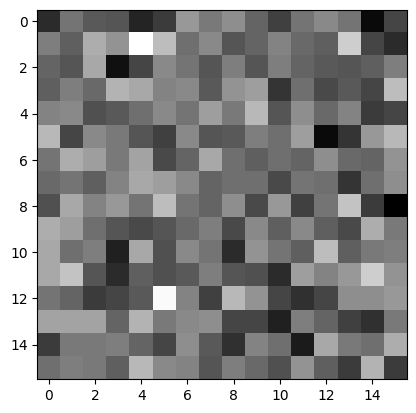

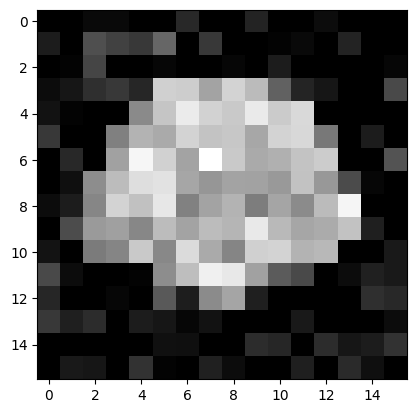

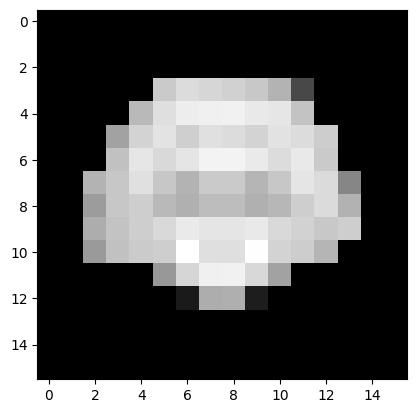

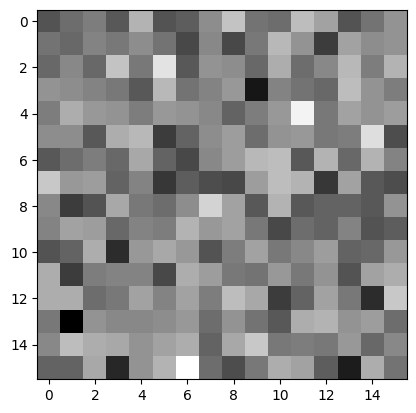

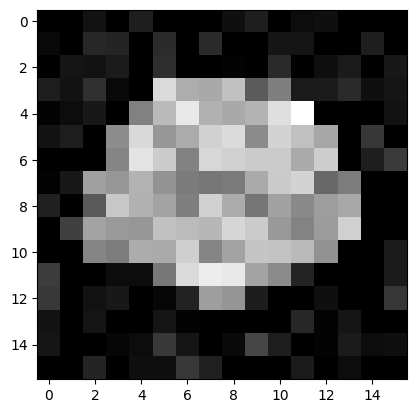

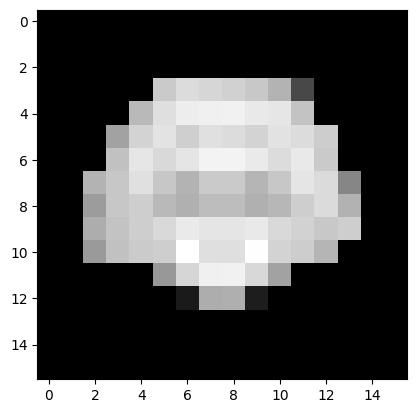

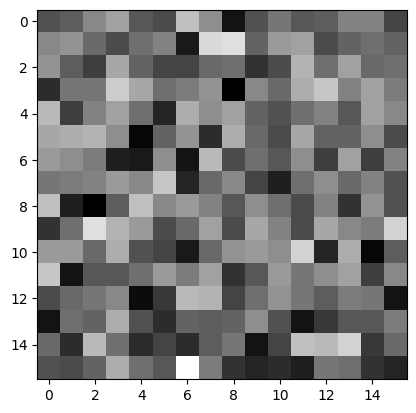

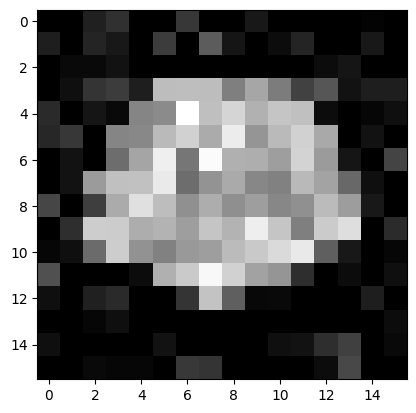

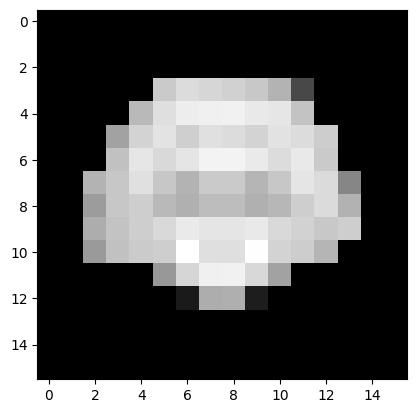

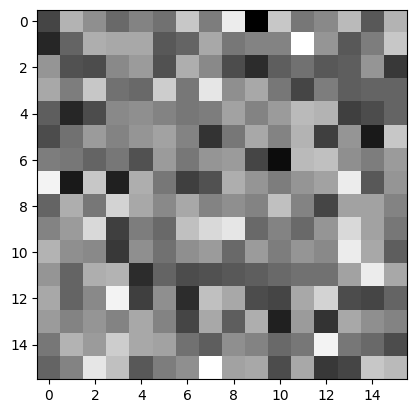

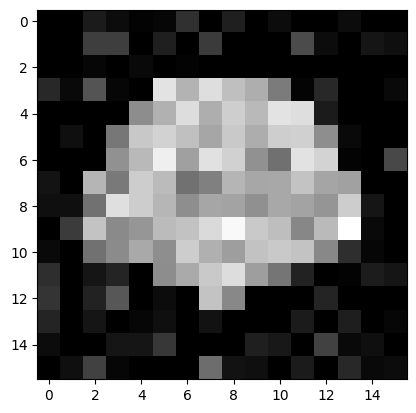

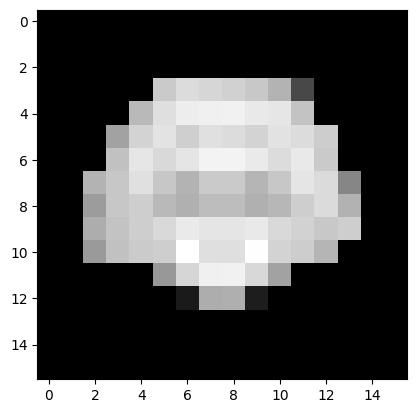

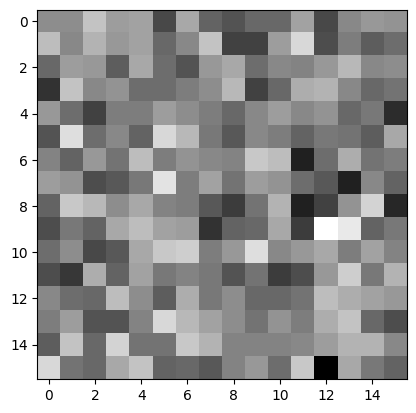

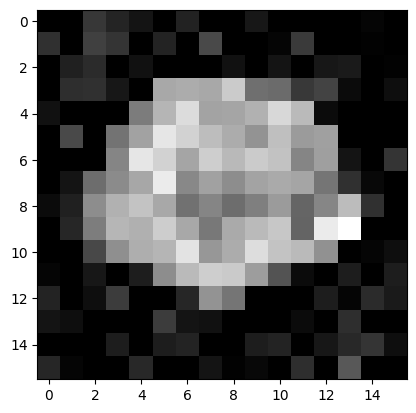

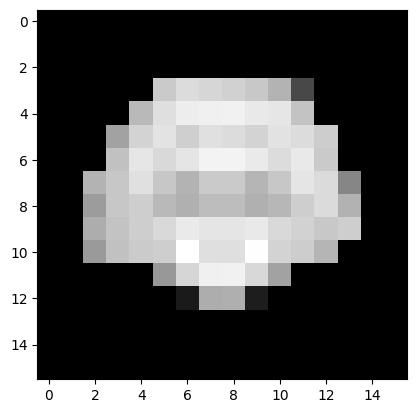

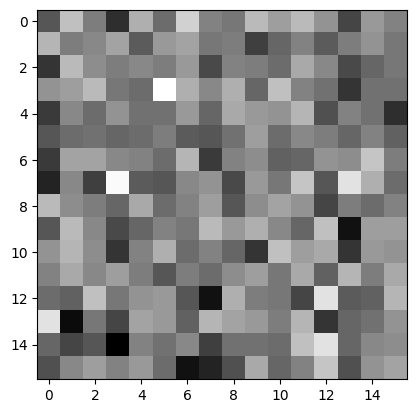

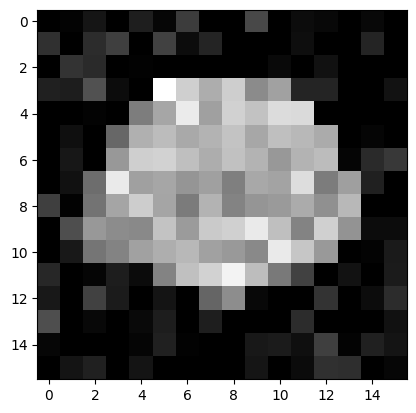

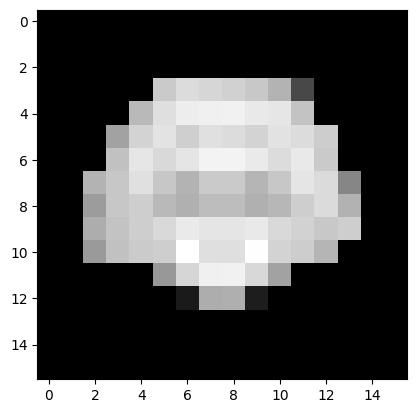

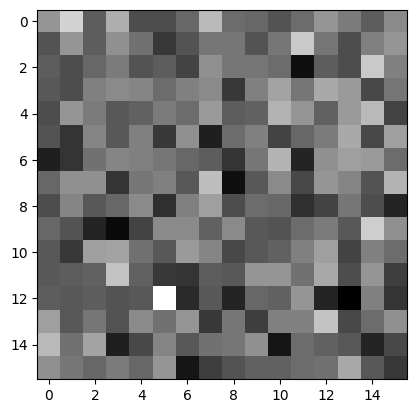

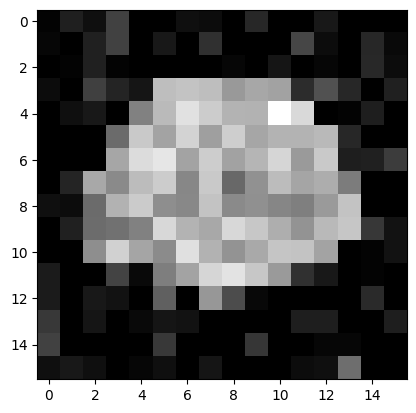

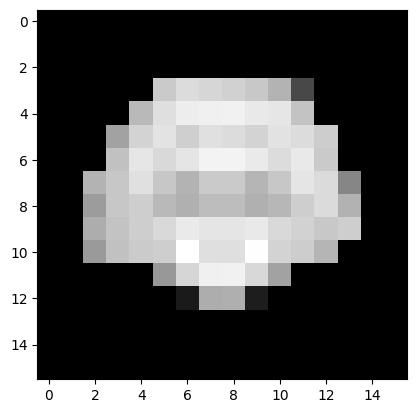

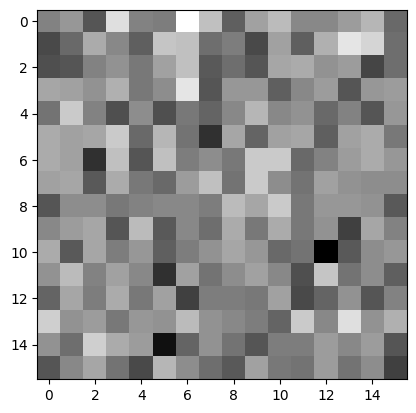

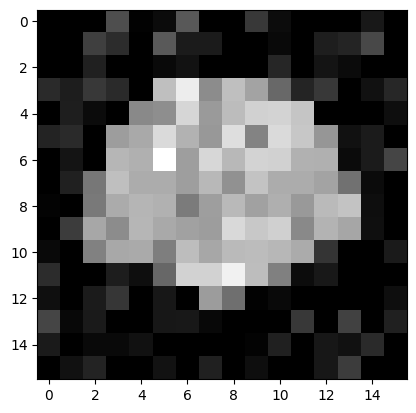

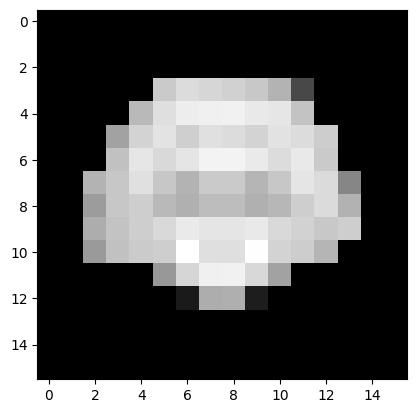

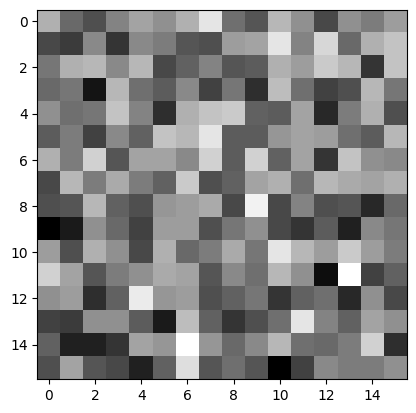

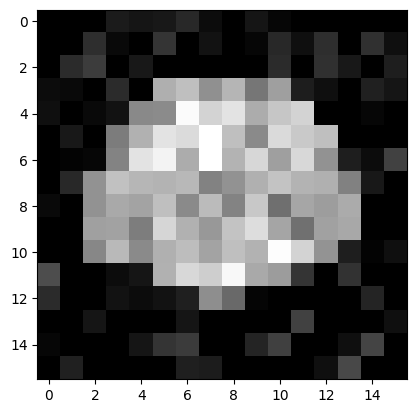

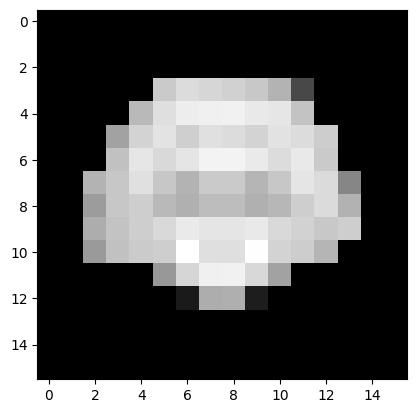

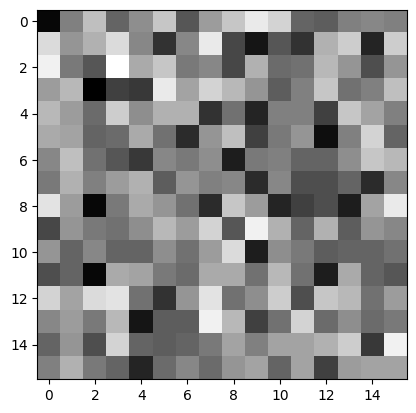

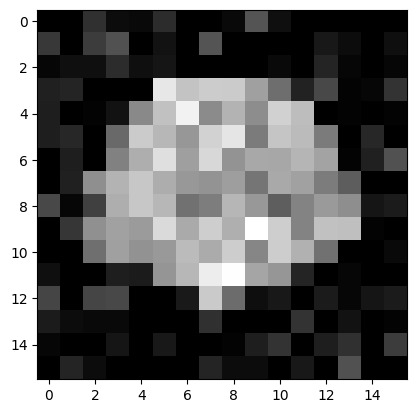

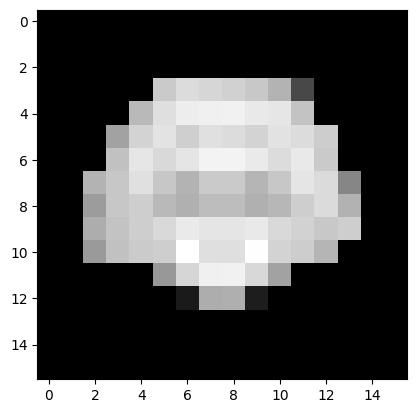

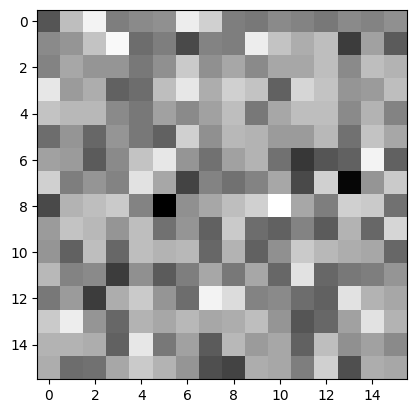

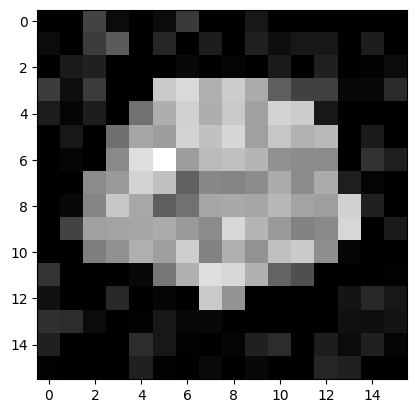

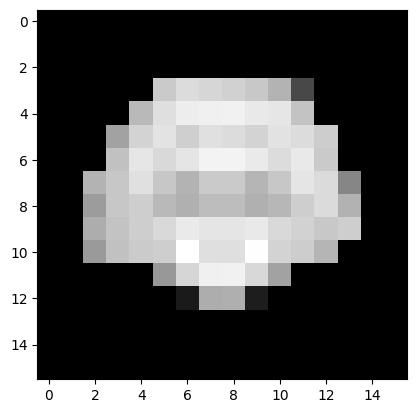

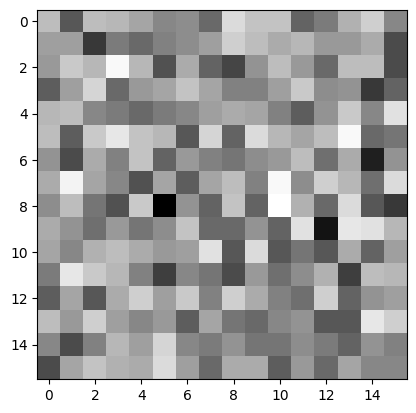

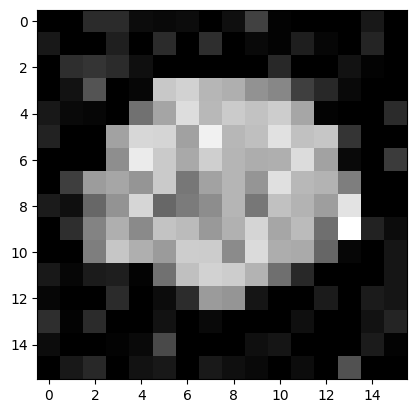

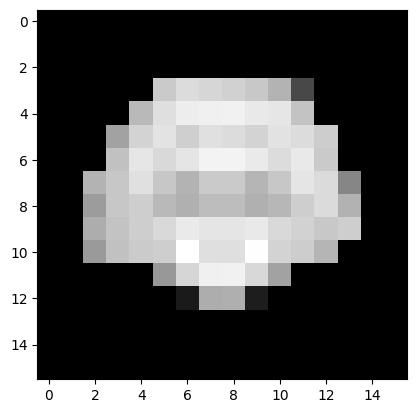

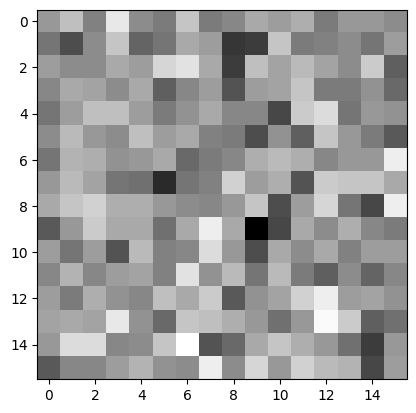

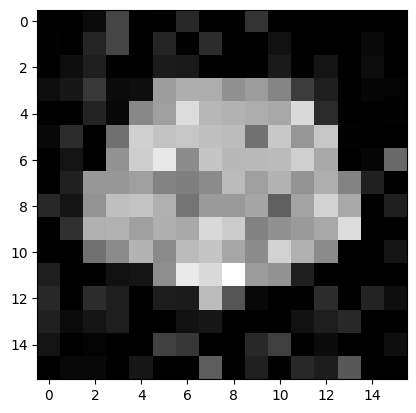

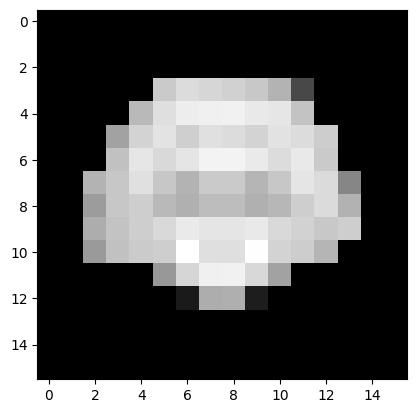

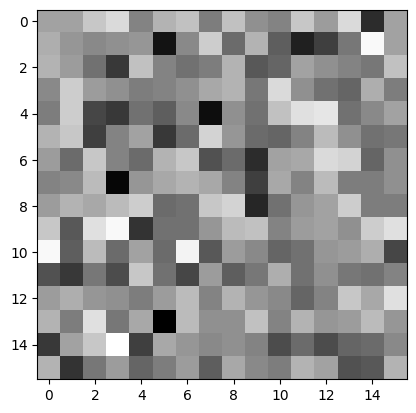

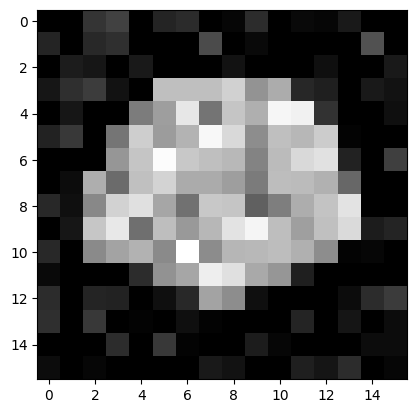

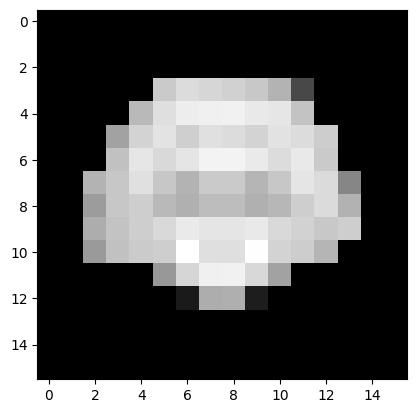

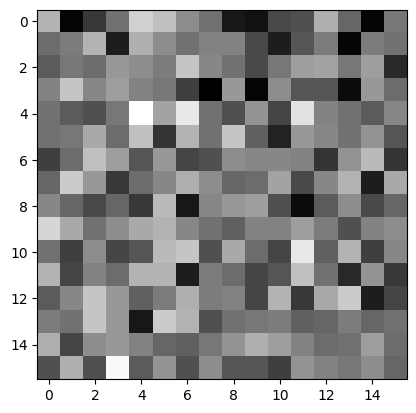

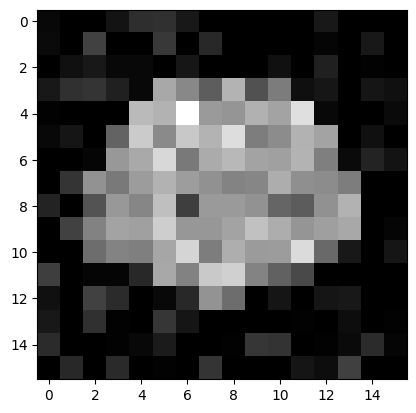

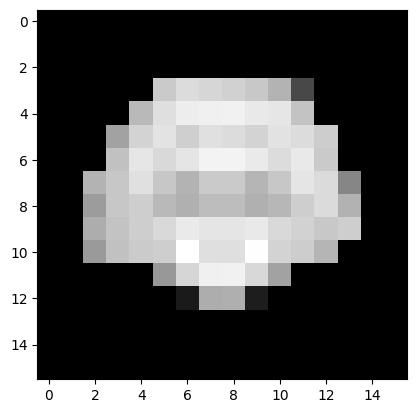

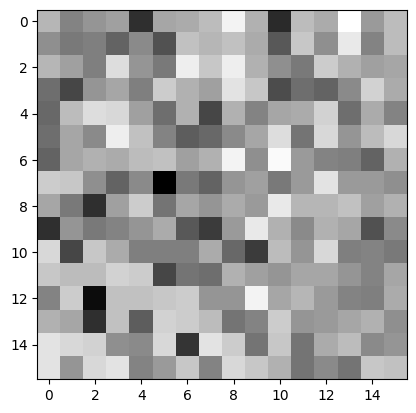

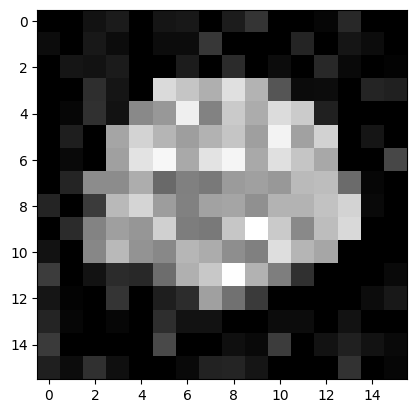

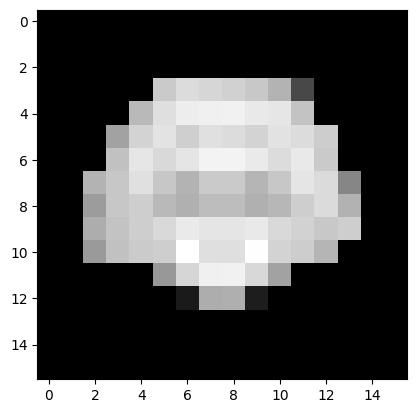

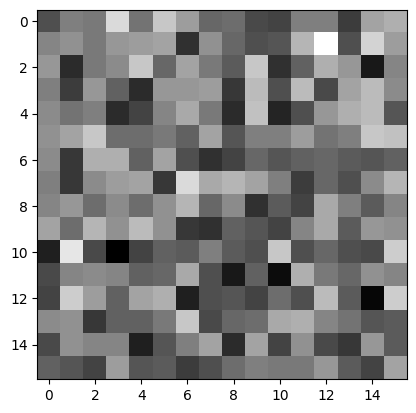

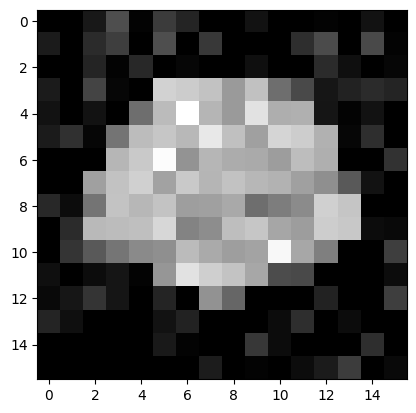

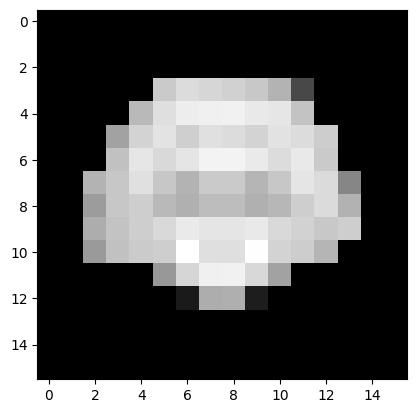

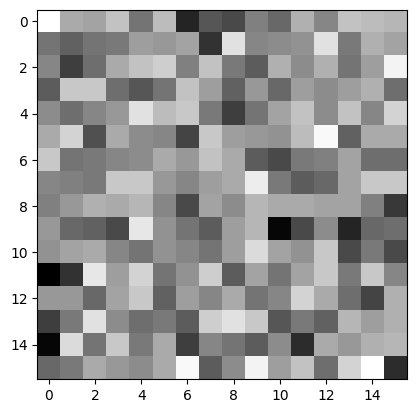

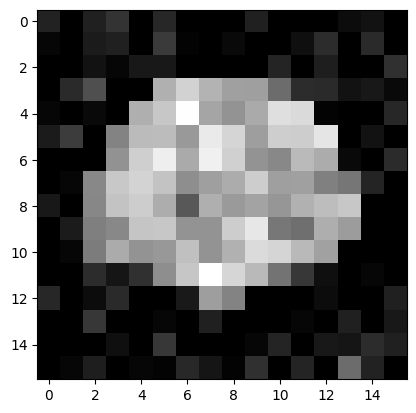

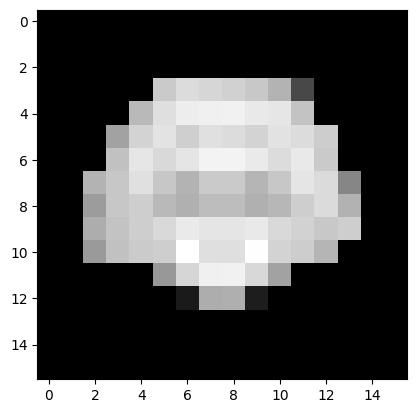

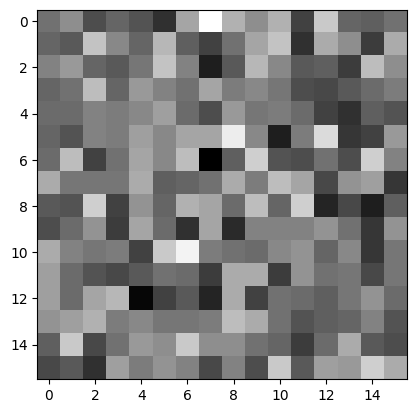

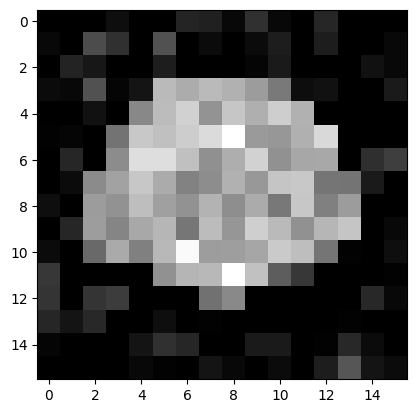

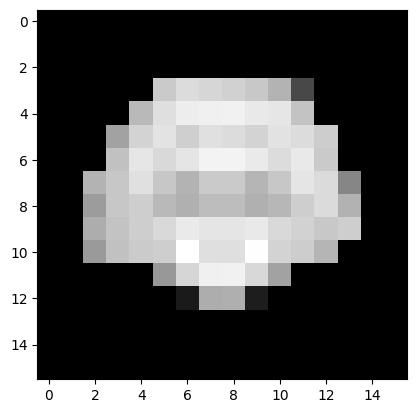

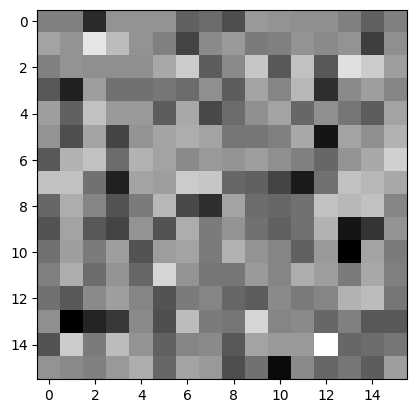

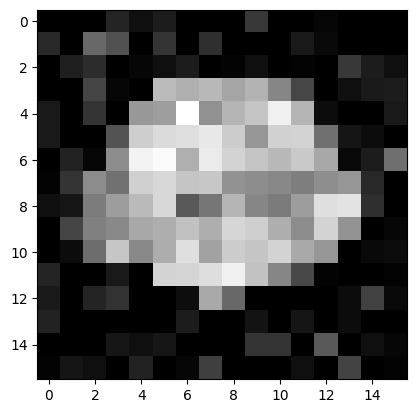

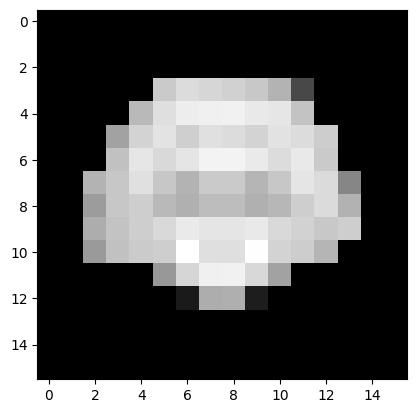

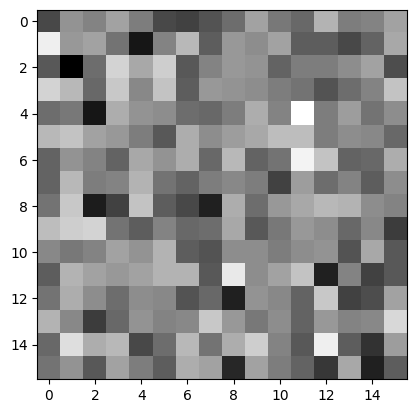

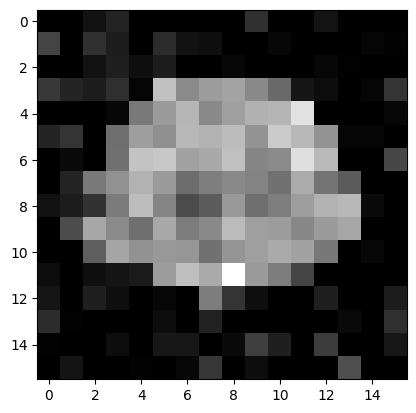

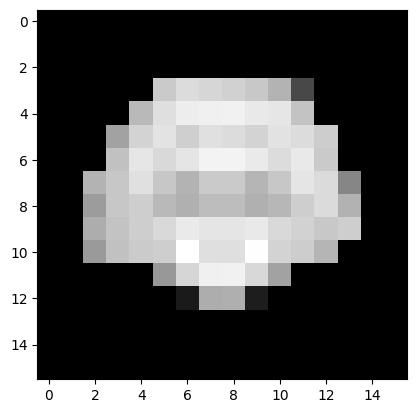

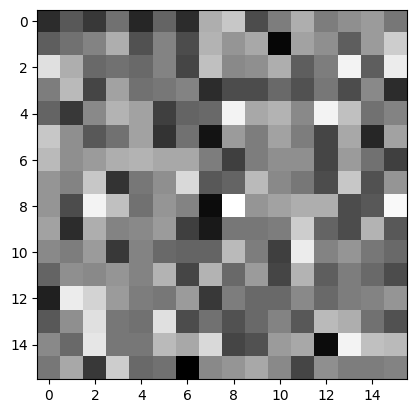

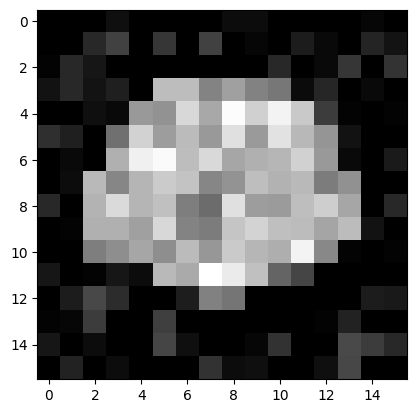

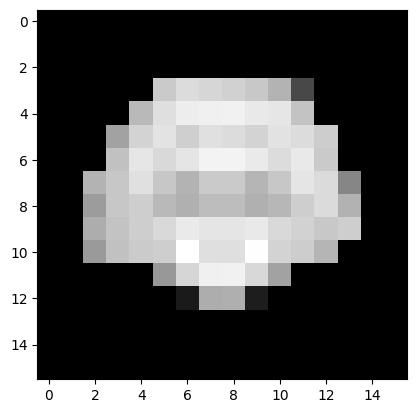

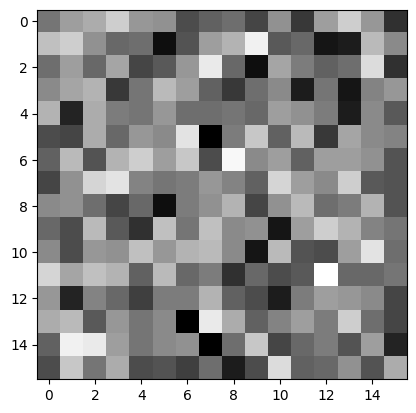

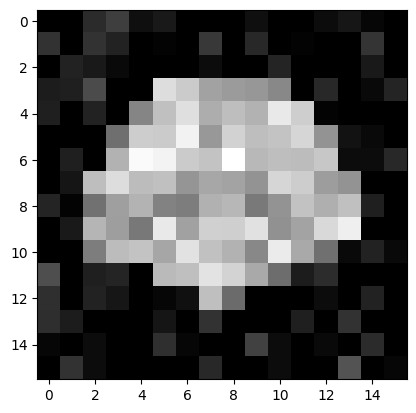

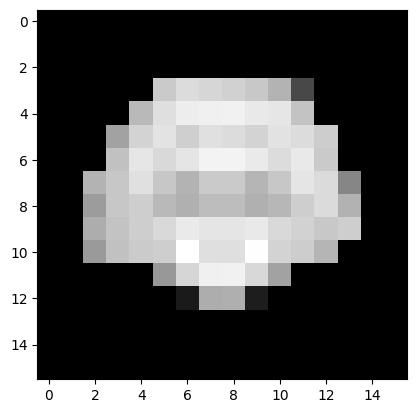

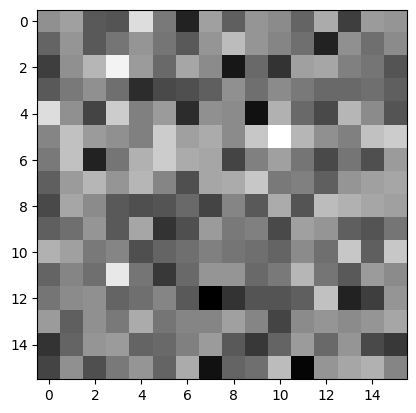

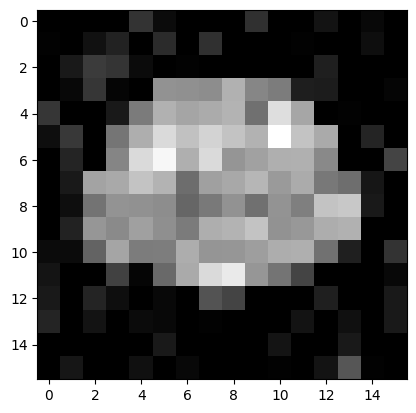

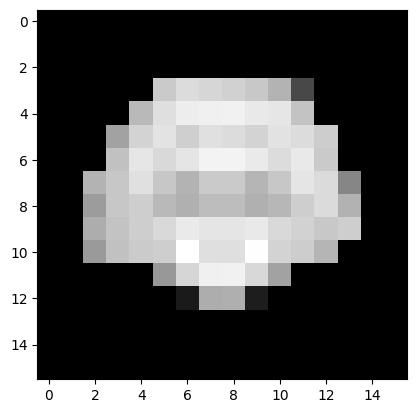

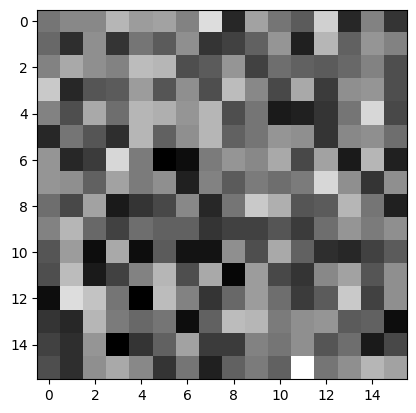

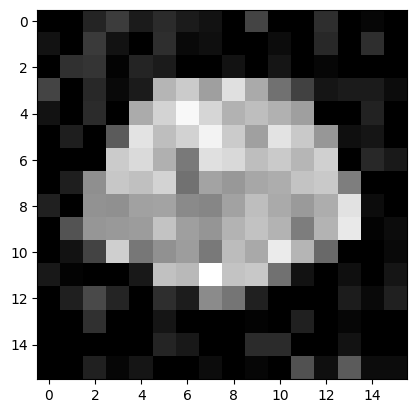

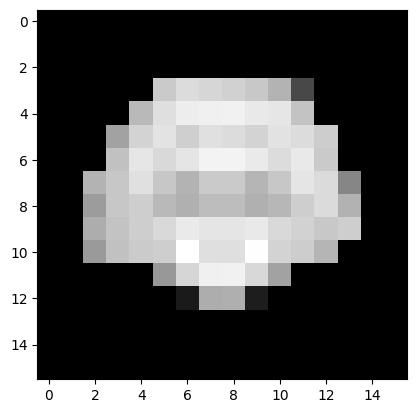

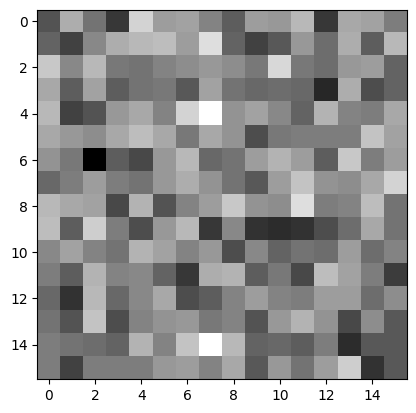

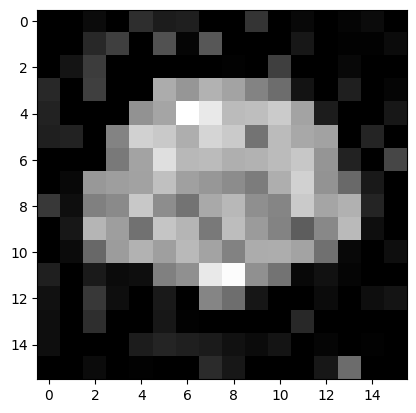

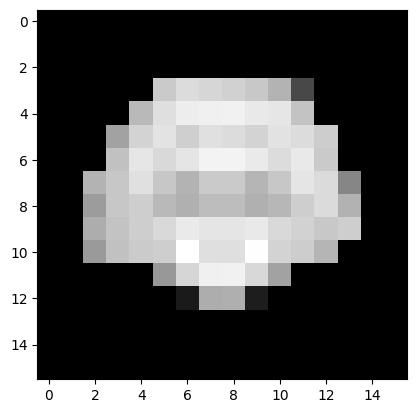

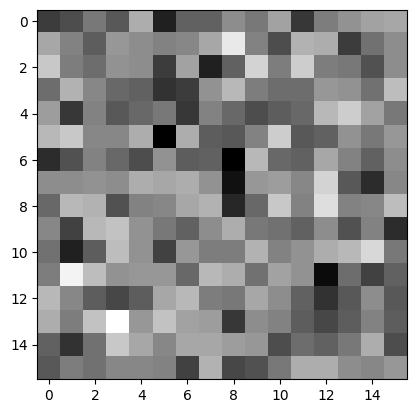

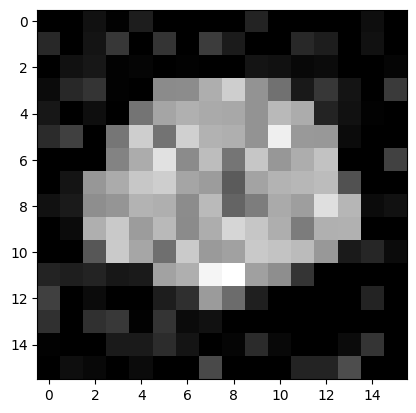

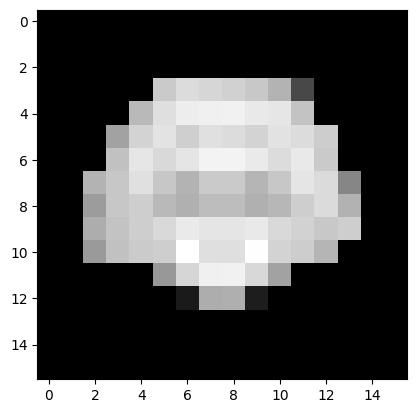

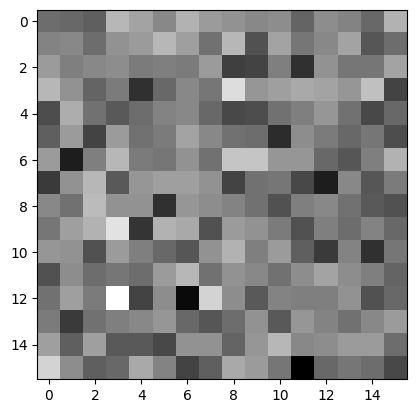

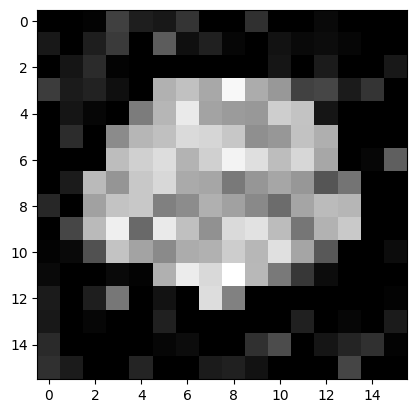

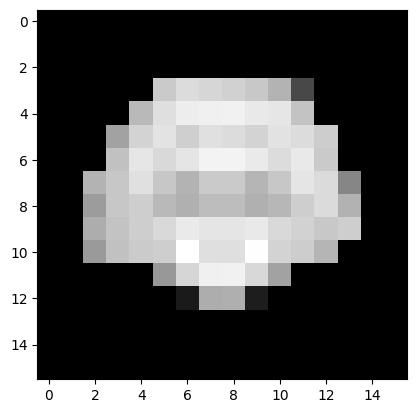

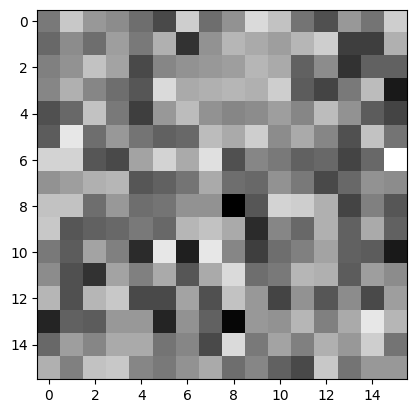

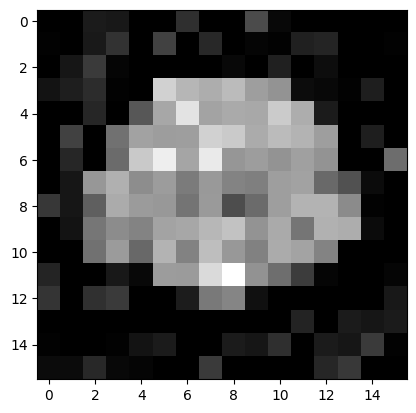

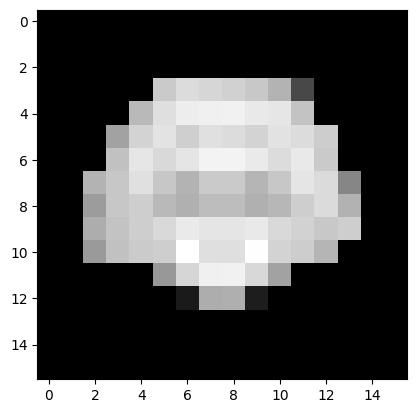

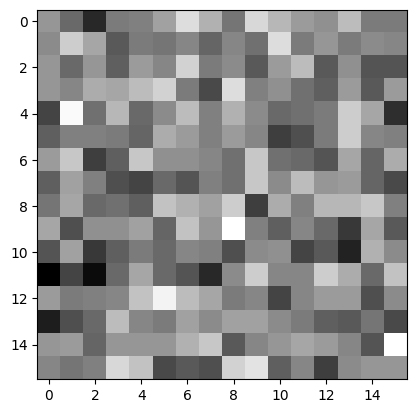

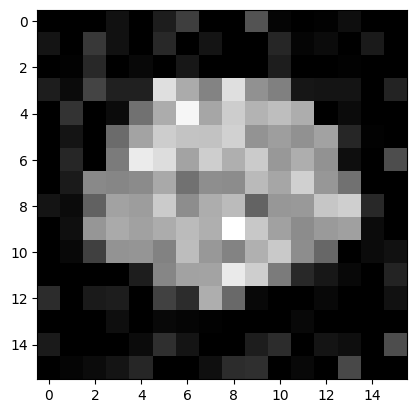

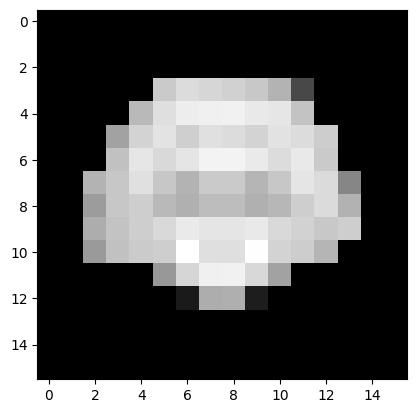

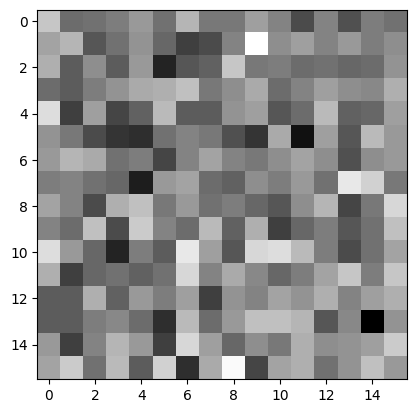

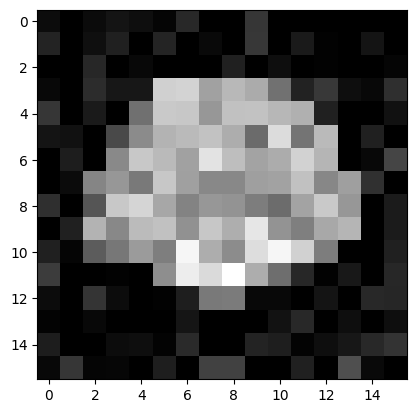

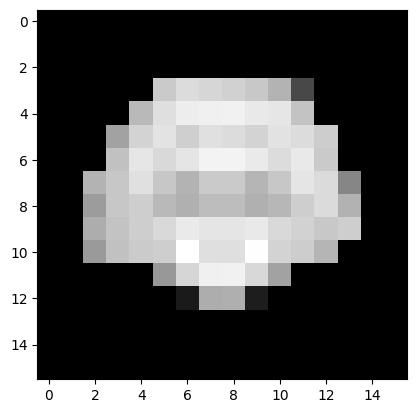

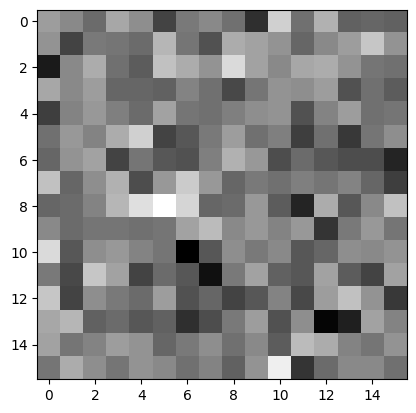

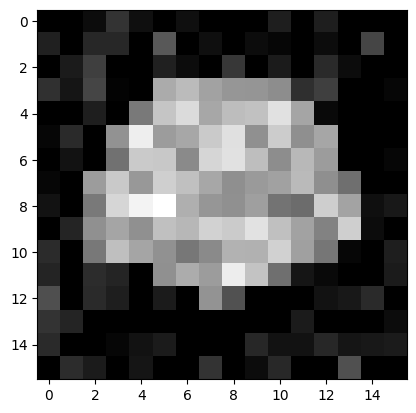

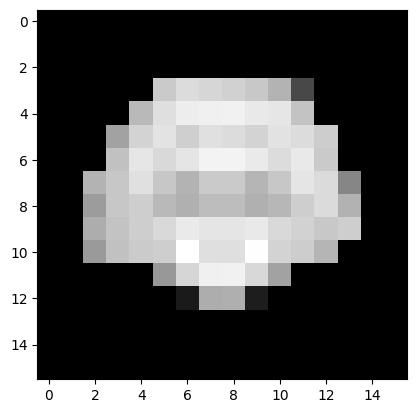

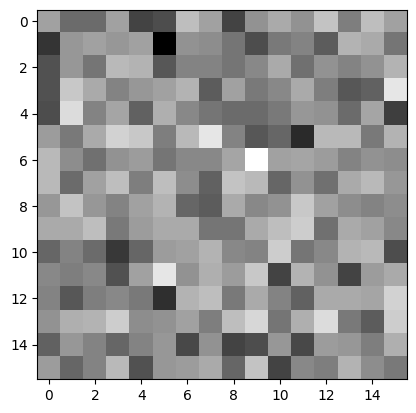

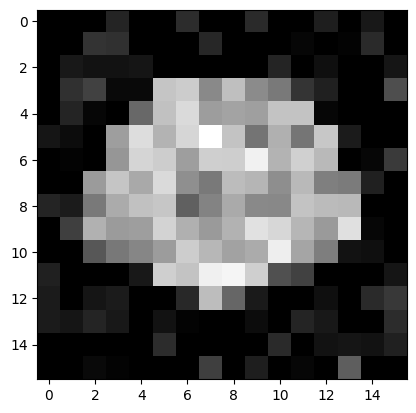

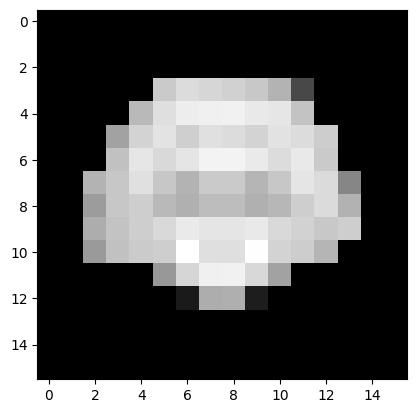

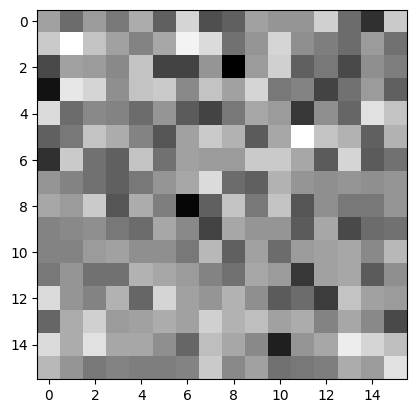

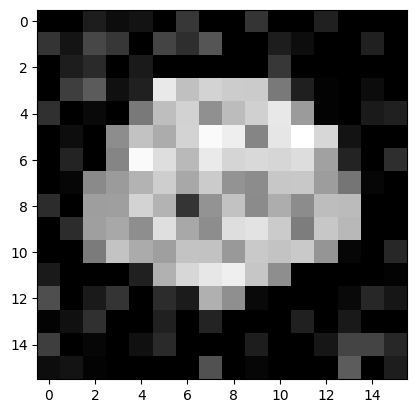

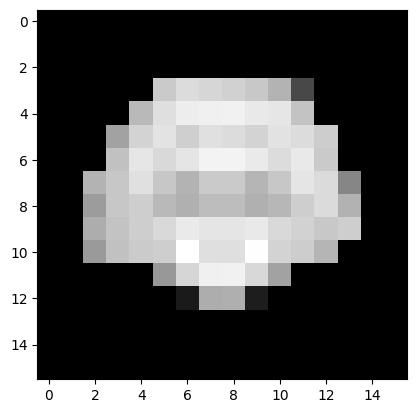

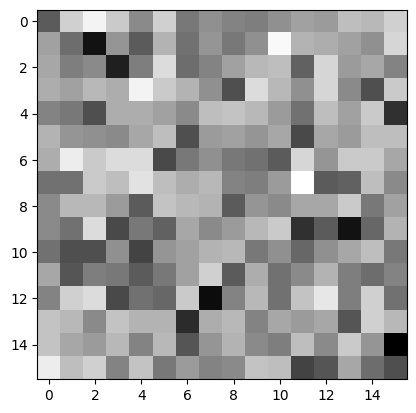

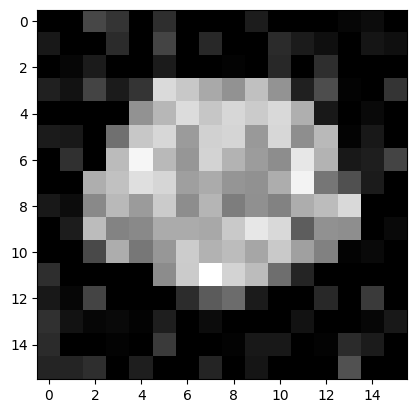

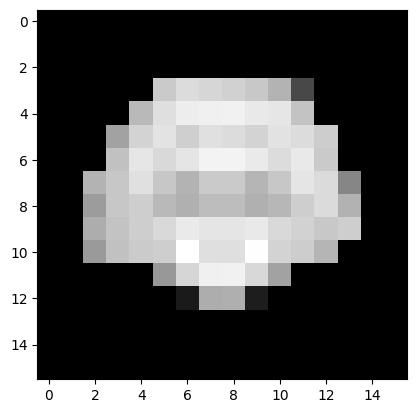

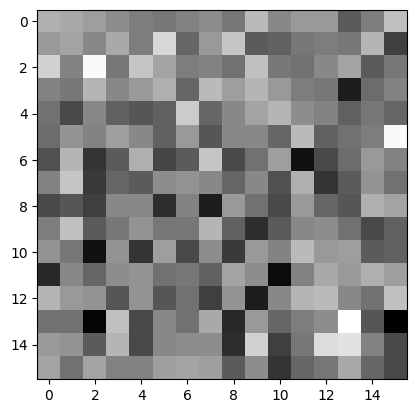

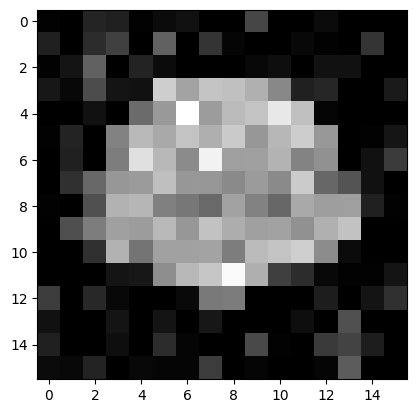

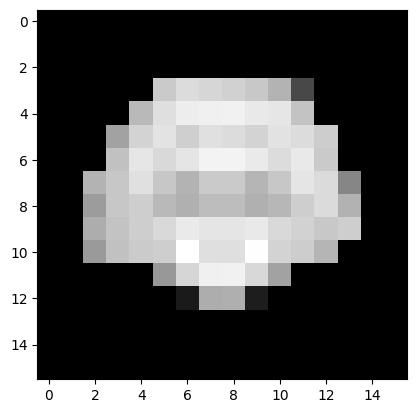

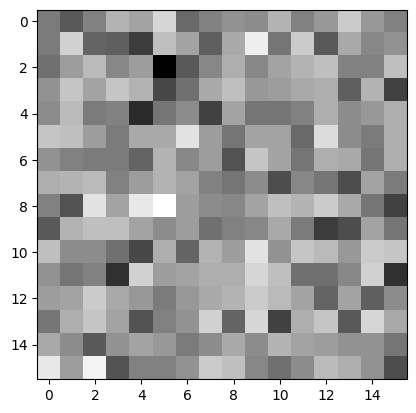

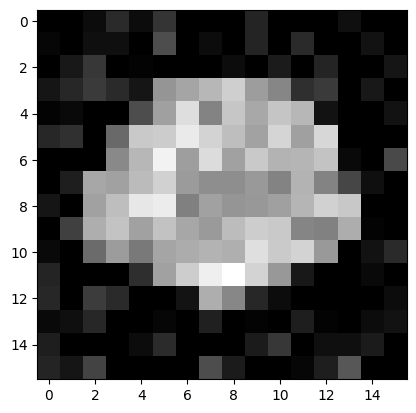

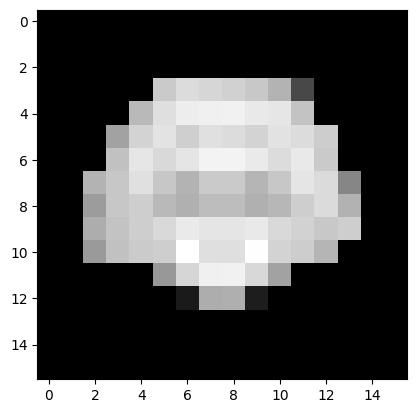

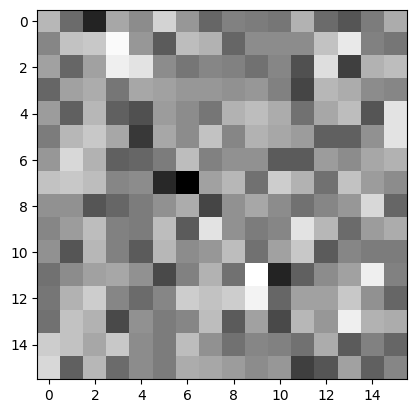

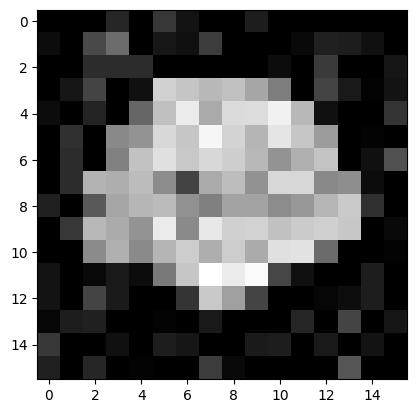

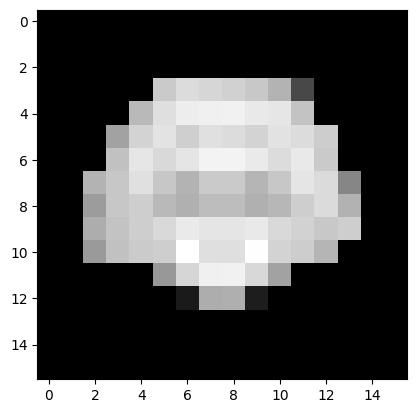

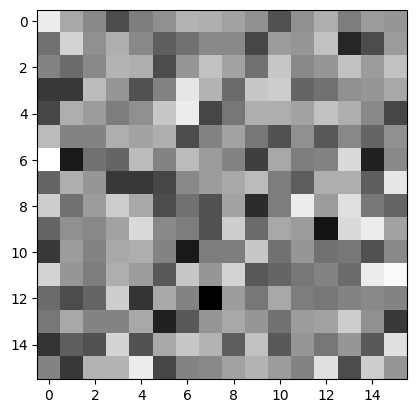

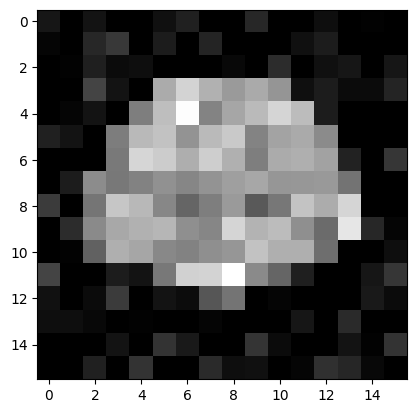

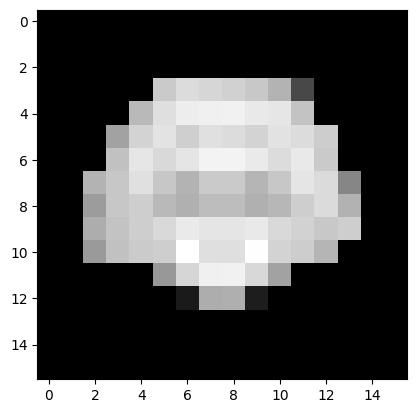

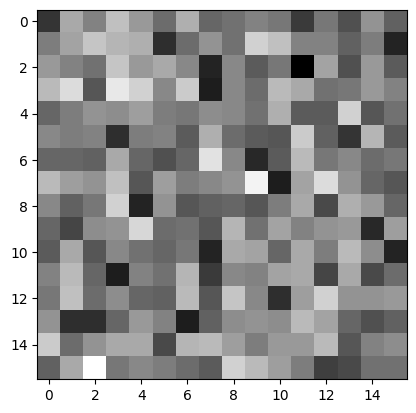

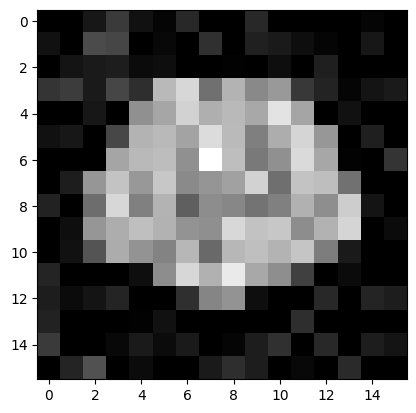

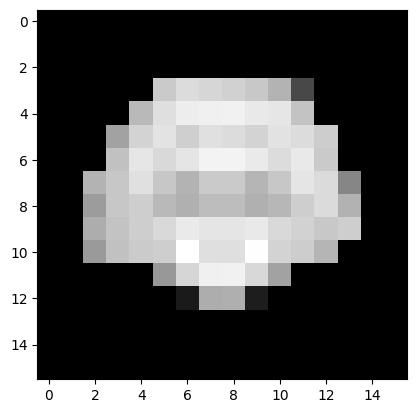

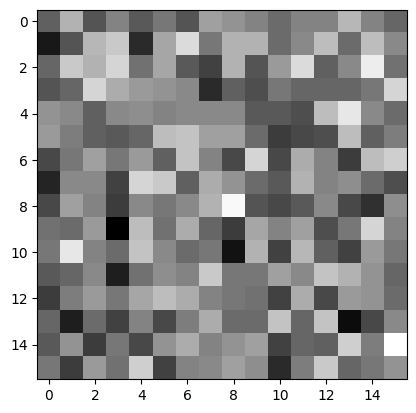

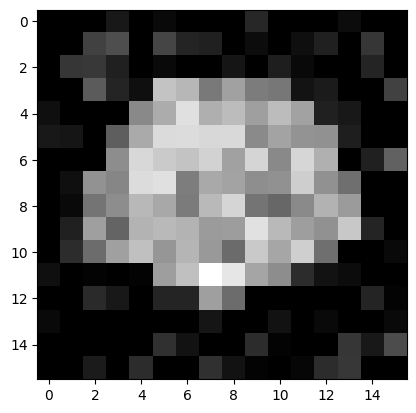

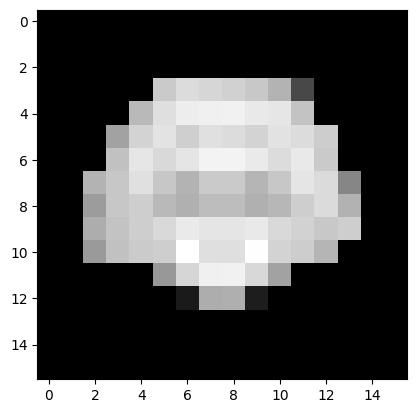

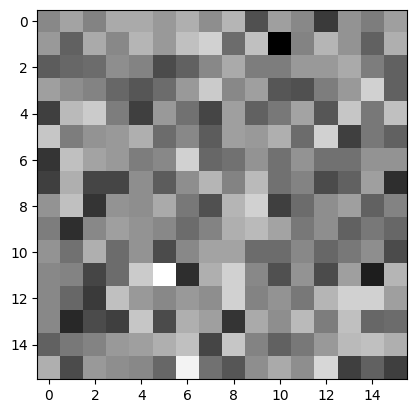

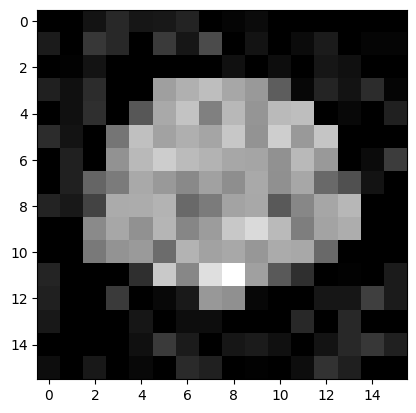

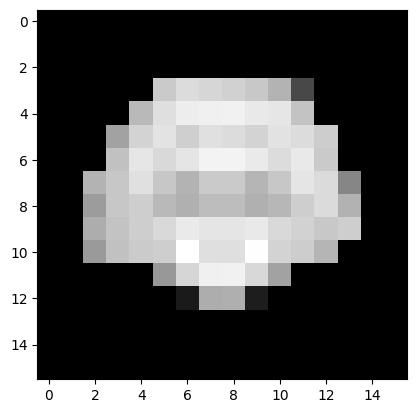

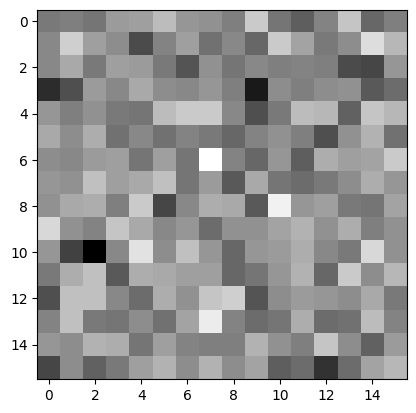

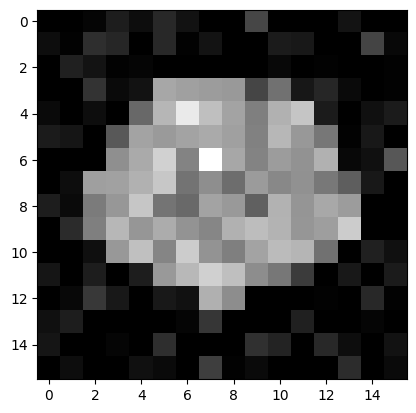

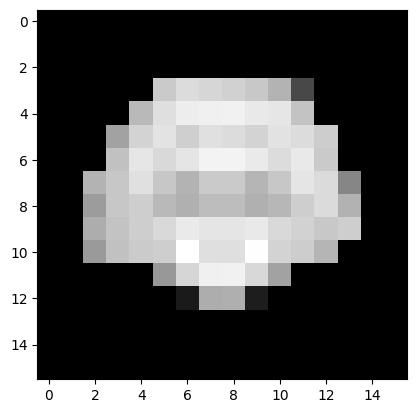

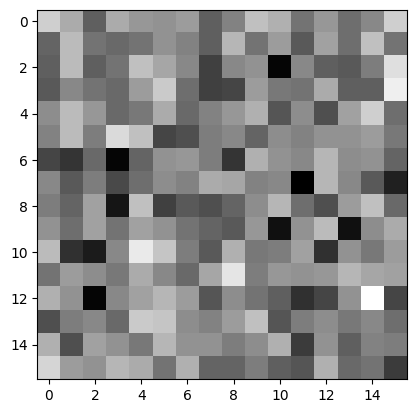

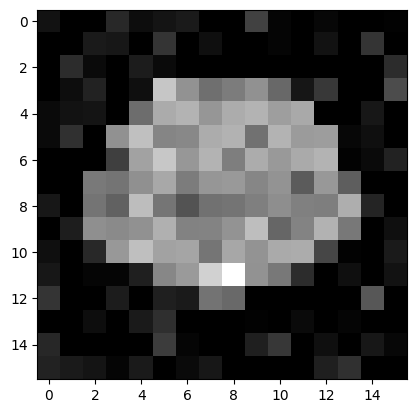

In [26]:
images_run_uuid = uuid.uuid4()
for image in range(1, 4):
    group_uuid = str(uuid.uuid4())
    for i in range(100):
        img_name = str(image) + '_original'
        img_path = 'original_images/' + img_name + ".png"
        make_experiment(img_path, img_name)